In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
from torch import optim
import copy
import random

In [2]:
class MemoryBank():
    '''Stores and retrieves memories. Also ranks memories by usefulness, and forgets unimportant ones.'''
    def __init__(self, brain):
        self.memories = []
        self.memory_probs = []
        
        self.memory_batch_n = 200
        self.memory_threshold = self.memory_batch_n*10
        self.memory_size = self.memory_batch_n*500
        
        self.brain = brain

    def remember(self, experience):
        self.memories.append(experience)
        
    def rank_memories(self):
        '''Rank all memories in bank based on usefulness, or the difference in results between Q and target_Q.'''
        qualities, target_qualities = self.brain.get_qualities(list(map(list, zip(*self.memories))))
        usefulness = abs(qualities - target_qualities)
        usefulness += max(usefulness)/100 # allow a non-zero chance for each item to be selected
        usefulness = usefulness.detach().numpy()
        self.memory_probs = usefulness/sum(usefulness)
        #print(f"Average memory usefulness at {np.mean(usefulness.detach().numpy()):.2f} with " +
              #f"{sum(np.array(self.memories)[:,4])}/{len(self.memories)} end-game states in memory")
        
    def forget(self):
        '''Forget least useful memories.'''
        self.memories = np.array(self.memories)[\
                        np.random.choice(len(self.memories), self.memory_size, replace=False,\
                        p=self.memory_probs)]
        self.memories = list(self.memories)

    def recall_batch(self):
        '''Recall a batch of memories, and forget some. Q and target_Q are used to determine how useful each memory
        is. Memories are retrieved or forgotten based on usefulness.'''
        if len(self.memories) < self.memory_threshold: return None
        self.rank_memories()
        memory_batch = np.array(self.memories)[\
                        np.random.choice(len(self.memories), self.memory_batch_n, replace=False,\
                                         p=self.memory_probs)]
        if len(self.memories) > self.memory_size:
            self.forget()
        return list(map(list, zip(*memory_batch)))

In [3]:
class QualityNet(nn.Module):
    '''Takes a state and returns qualities for each action.'''
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(128, 256)
        self.layer_2 = nn.Linear(256, 6)
        
    def forward(self, state):
        x = torch.Tensor(state)
        x = F.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

class DDQN():
    '''Determines the quality of an action-state pair. Can learn from experience.'''
    def __init__(self):
        self.Q = QualityNet()
        self.target_Q = copy.deepcopy(self.Q)
        self.memory = MemoryBank(self)
        
        self.gamma = .97
        self.learning_rate = 0.1
        self.learning_rate_decay = 0.95
        self.min_learning_rate = 0.001
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.learning_rate)
        
        self.target_count = 0
        self.target_refresh_frequency = 5

    def update_target(self):
        #print("Updating target net")
        self.target_Q = copy.deepcopy(self.Q)

    def get_qualities(self, memory_batch):
        state_batch, action_batch, reward_batch, new_state_batch, game_over_batch = memory_batch
        quality_batch = self.Q(state_batch)[list(range(len(action_batch))), action_batch]
        game_not_over_batch = [1-i for i in game_over_batch]
        DDQN_action_batch = torch.max(self.Q(new_state_batch), dim=1)[1]
        target_quality_batch = torch.Tensor(reward_batch) +\
                            torch.Tensor(game_not_over_batch)*self.gamma*\
                            self.target_Q(new_state_batch)[list(range(len(DDQN_action_batch))), DDQN_action_batch]
        #print("OLD", quality_batch)
        #print("NEW", target_quality_batch)
        return quality_batch, target_quality_batch

    def reduce_learning_rate(self):        
        '''Reduce the learning rate used to train the Q net.'''
        self.learning_rate *= self.learning_rate_decay
        if (self.learning_rate < self.min_learning_rate):
            self.learning_rate = self.min_learning_rate
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.learning_rate)
        
    def learn(self, memory_batch):
        if memory_batch is None:
            return
        
        quality_batch, target_quality_batch = self.get_qualities(memory_batch)
        loss = self.loss_function(quality_batch, target_quality_batch)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
        self.reduce_learning_rate()
        
        self.target_count += 1
        if (self.target_count >= self.target_refresh_frequency):
            self.target_count = 0
            self.update_target()

In [4]:
class Agent():
    '''This agent undergoes the act->remember->recall->learn loop for a certain number of games.
    At the same time, it stores the results of these loops for plotting.'''
    def __init__(self):
        self.env = gym.make("Pong-ram-v0")
        self.state = self.env.reset()
        
        self.brain = DDQN()

        self.n_games = 300
        self.group_n_games = 10
        self.training_history = []
        self.game_frames = []
        self.game_info = []
        
        self.epsilon = 1
        self.epsilon_decay = 0.95
        self.min_epsilon = 0.05

    def act(self, state):
        '''Choose an action using the policy, act on the environment, and return all the outputs.'''
        def policy(state):
            if np.random.uniform(0, 1) < self.epsilon:
                action = np.random.choice(self.env.action_space.n)
            else:
                action_probabilities = F.softmax(self.brain.Q(state), dim=0)
                action = Categorical(action_probabilities).sample().item()
            return action     
        
        action = policy(state)
        new_state, reward, game_over, _ = self.env.step(action)
        self.state = new_state
        experience = (state, action, reward, new_state, game_over)
        return experience

    def reduce_policy_randomness(self):  
        '''Reduce the epsilon used in the policy for less randomness in picking actions.'''
        self.epsilon *= self.epsilon_decay
        if (self.epsilon < self.min_epsilon):
            self.epsilon = self.min_epsilon
        
    def play(self):
        for n in range(self.n_games):
            game_over = False
            self.state = self.env.reset()
            game_reward = 0
            new_game_frames = []
            new_game_info =[]
            
            while not game_over:
                experience = self.act(self.state)
                game_reward += experience[2]
                game_over = experience[4]
                self.brain.memory.remember(experience)

                if (n+1)%self.group_n_games == 0:
                    new_game_frames.append(self.env.render(mode='rgb_array'))
                    new_game_info.append((experience, self.brain.Q(experience[0])))
          
            for _ in range(5):
                memory_batch = self.brain.memory.recall_batch()
                self.brain.learn(memory_batch)
            self.reduce_policy_randomness()
            self.training_history.append([game_reward, self.epsilon, self.brain.learning_rate])
  
            if (n+1)%self.group_n_games == 0:
                self.game_frames.append(new_game_frames)
                self.game_info.append(new_game_info)
                avg_score = np.average(np.array(self.training_history)[:,0][-self.group_n_games:])
                if (avg_score >= 20): break
                print(f"Finished playing {n+1} games. Average score of last {self.group_n_games} games " +
                      f"was {avg_score:.2f}.")

    def display_game(self, game_n):
        print("quality, action")
        for info in self.game_info[game_n]:
            print(info[1].detach().numpy(), info[0][1])
        patch = plt.imshow(self.game_frames[game_n][0])
        plt.axis('off')
        def animate(i): patch.set_data(self.game_frames[game_n][i])
        anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(self.game_frames[game_n]), interval=50)
        display(display_animation(anim, default_mode='once'))

# Train and Save Model

In [5]:
agent = Agent()
agent.play()

Finished playing 10 games. Average score of last 10 games was -20.10.
Finished playing 20 games. Average score of last 10 games was -20.40.
Finished playing 30 games. Average score of last 10 games was -21.00.
Finished playing 40 games. Average score of last 10 games was -20.80.
Finished playing 50 games. Average score of last 10 games was -21.00.
Finished playing 60 games. Average score of last 10 games was -20.70.
Finished playing 70 games. Average score of last 10 games was -20.80.
Finished playing 80 games. Average score of last 10 games was -20.20.
Finished playing 90 games. Average score of last 10 games was -20.90.
Finished playing 100 games. Average score of last 10 games was -20.60.
Finished playing 110 games. Average score of last 10 games was -20.60.
Finished playing 120 games. Average score of last 10 games was -20.50.
Finished playing 130 games. Average score of last 10 games was -20.70.
Finished playing 140 games. Average score of last 10 games was -20.80.
Finished playin

quality, action
[ 3.1457098  1.9808617  2.1906679  2.3169427 -1.2517667  2.4700367] 5
[ 2.9600332  2.0937262  2.27481    2.5594468 -1.1104417  2.5458598] 2
[ 2.9701955  2.051011   2.2339485  2.484305  -1.1296926  2.5046952] 1
[ 3.0437582  2.070488   2.2643104  2.496924  -1.1654534  2.5396855] 0
[ 3.0415304  2.0392323  2.2329612  2.4446168 -1.1740327  2.5075595] 2
[ 3.1306837  2.0201197  2.227369   2.3875794 -1.2308335  2.5066905] 2
[ 3.1660612  2.017068   2.2296476  2.3726182 -1.2519479  2.510937 ] 4
[ 3.2731206  2.0373     2.265783   2.3772492 -1.3065476  2.5536406] 2
[ 3.2705534  2.0191326  2.2473714  2.347197  -1.3108125  2.5347044] 1
[ 3.1668394  2.1049309  2.3169518  2.5211854 -1.2246995  2.6001103] 1
[ 3.1867368  2.101942   2.316969   2.5106149 -1.2369752  2.6012082] 2
[ 3.1638143  2.0747738  2.2865722  2.4709535 -1.2324777  2.568931 ] 3
[ 3.1871068  2.0691576  2.2844942  2.4550004 -1.247519   2.568074 ] 3
[ 3.2104032  2.0635414  2.2824156  2.4390397 -1.2625604  2.5672166] 1
[ 3.

[ 3.4015615  2.263442   2.5094523  2.724627  -1.3084321  2.8093812] 0
[ 3.387367   2.27954    2.5232968  2.755816  -1.2952752  2.8227446] 3
[ 3.1884763  2.3510532  2.564425   2.9319558 -1.1594529  2.8539364] 5
[ 3.218952   2.3738136  2.5915813  2.9620614 -1.1696343  2.883315 ] 3
[ 3.197971   2.33957    2.5544538  2.9098802 -1.1684823  2.8442729] 1
[ 3.2509916  2.3551636  2.5778813  2.9216142 -1.1937623  2.8710682] 2
[ 3.431255   2.2537374  2.5042772  2.6999803 -1.3284059  2.8057098] 0
[ 3.2381895  2.3283997  2.5494032  2.8798356 -1.1949067  2.8412993] 1
[ 3.2879674  2.3518324  2.5801225  2.9057374 -1.2158761  2.8753636] 3
[ 3.569435   2.101447   2.373887   2.4038606 -1.4551034  2.680093 ] 0
[ 3.3675764  2.177248   2.4188232  2.58808   -1.3162446  2.7150114] 0
[ 3.3739927  2.1772366  2.419774   2.586287  -1.3198991  2.7163298] 0
[ 3.5203626  2.0623693  2.3277493  2.351275  -1.439467   2.6303253] 4
[ 3.5463903  2.1031132  2.3720827  2.4130616 -1.4414544  2.6769998] 4
[ 3.4724424  2.20835

[ 3.3300169  2.1560469  2.3921518  2.5625749 -1.3015313  2.6857426] 0
[ 3.432037   2.1885786  2.4397378  2.5894265 -1.3493829  2.7398622] 0
[ 3.3707235  2.2174406  2.459179   2.6552682 -1.3053651  2.7563815] 0
[ 3.2956007  2.1880035  2.4186997  2.6262116 -1.2718568  2.7109773] 1
[ 3.3369138  2.2169342  2.4536047  2.6637673 -1.2862649  2.7488556] 3
[ 3.4242208  2.2071867  2.4570284  2.6230989 -1.3390718  2.7570908] 2
[ 3.351734   2.2332659  2.4720345  2.687323  -1.2895646  2.7684748] 0
[ 3.355602   2.1747665  2.4145646  2.587195  -1.3102021  2.7100132] 5
[ 3.2950323  2.2376842  2.4679136  2.7104974 -1.255877   2.7611907] 5
[ 3.2766569  2.2415419  2.4689841  2.7221131 -1.2441926  2.7612855] 0
[ 3.2449377  2.2132282  2.4361305  2.6829476 -1.2350526  2.7260222] 2
[ 3.4436834  2.2065115  2.4592786  2.616572  -1.3503671  2.7604444] 1
[ 3.3838384  2.2765179  2.5197687  2.7516732 -1.2942185  2.8189518] 0
[ 3.2658193  2.221178   2.4471521  2.6906343 -1.2444367  2.7384086] 5
[ 3.2625196  2.22552

[ 3.3833425  2.1868591  2.4307256  2.5999932 -1.3221917  2.728018 ] 0
[ 3.373432   2.198      2.4402947  2.6215997 -1.3130364  2.7372496] 3
[ 3.4704702  2.1017828  2.3593736  2.4318185 -1.3986306  2.6599028] 0
[ 3.4807508  2.0956287  2.3548098  2.418551  -1.4064279  2.655802 ] 3
[ 3.4960134  2.0921774  2.3536744  2.408484  -1.4162049  2.655471 ] 0
[ 3.5550458  2.1344347  2.4044619  2.4637055 -1.4365106  2.7105262] 0
[ 3.294525   2.1107616  2.3418908  2.4957185 -1.295588   2.6325033] 3
[ 2.996761   2.1600332  2.3461165  2.6615586 -1.1104608  2.6206524] 1
[ 3.2535474  2.1076927  2.3326988  2.5018601 -1.2732148  2.6208944] 5
[ 3.0364683  2.1919985  2.383792   2.7046952 -1.1230035  2.6612713] 2
[ 3.268051   2.1354446  2.362413   2.5448403 -1.2727304  2.6520174] 2
[ 3.2562597  2.1463528  2.371468   2.5665765 -1.2625756  2.660622 ] 2
[ 3.2511442  2.1586514  2.3829045  2.5888162 -1.2557817  2.6720192] 5
[ 3.2048833  2.1560774  2.3734107  2.597262  -1.2302461  2.659816 ] 2
[ 3.1418798  2.15109


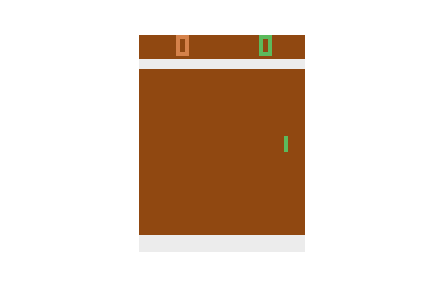
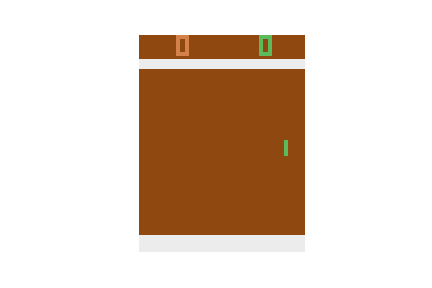
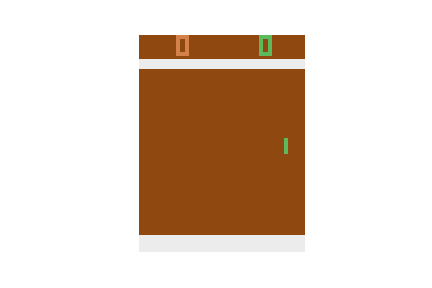
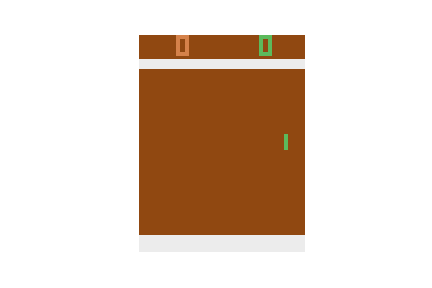
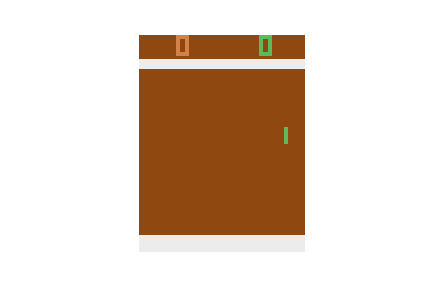
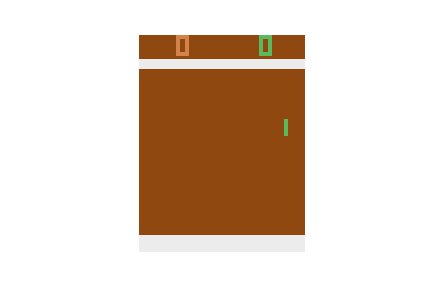
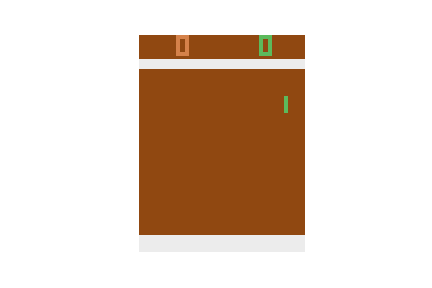
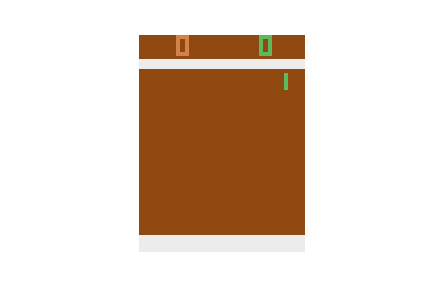
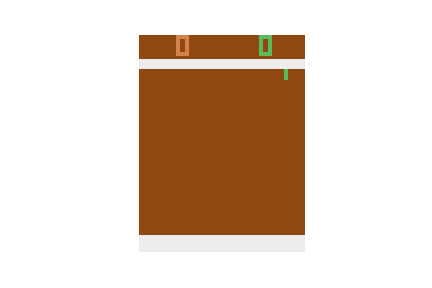
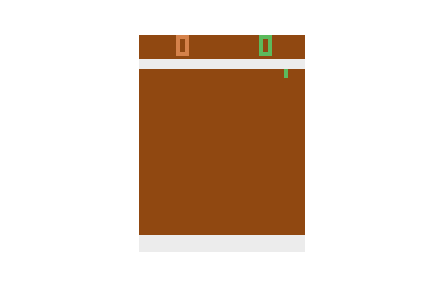
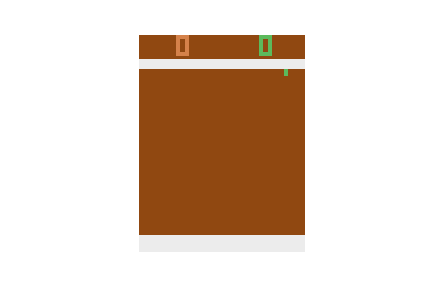
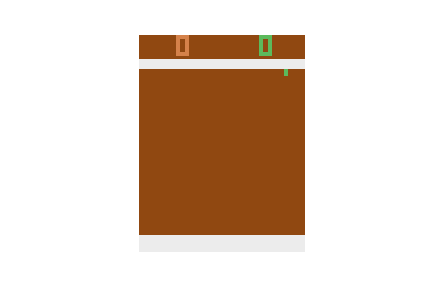
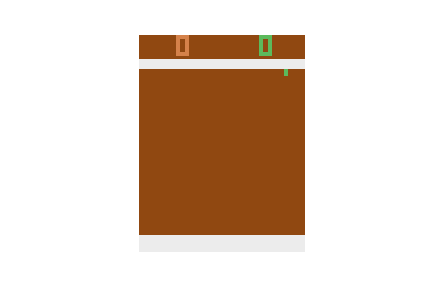
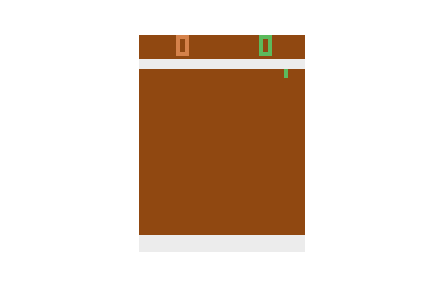
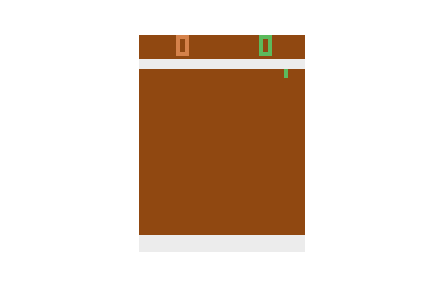
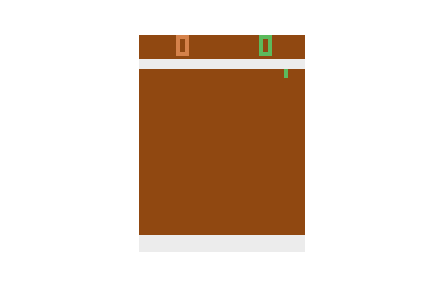
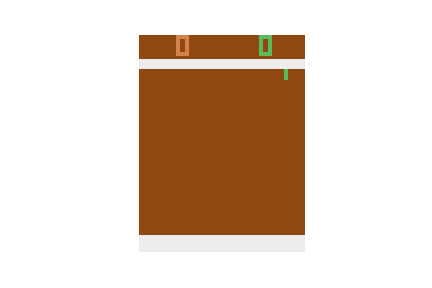
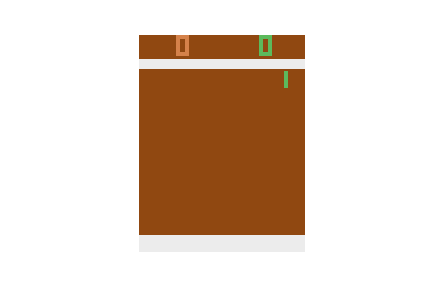
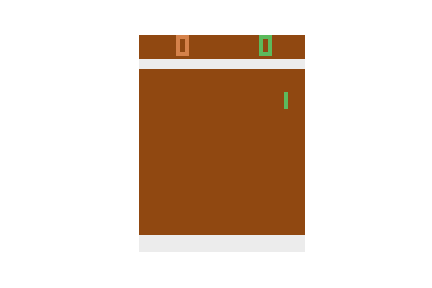
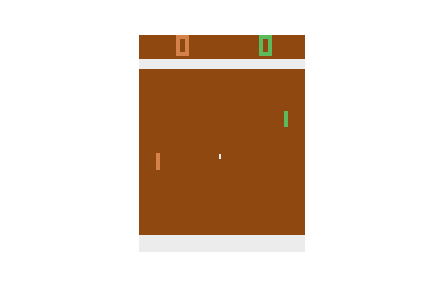
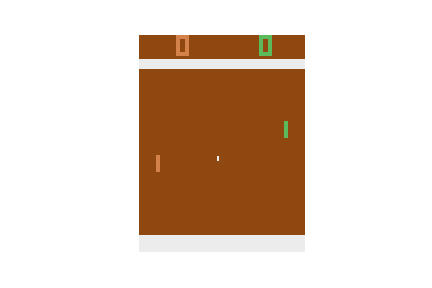
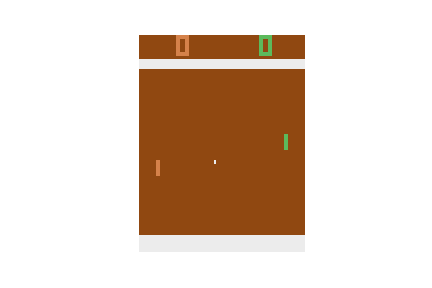
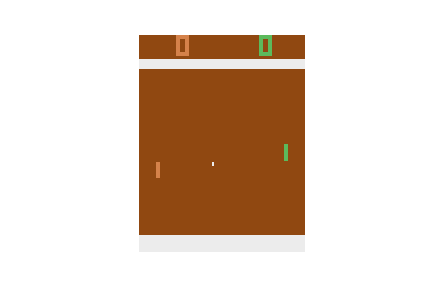
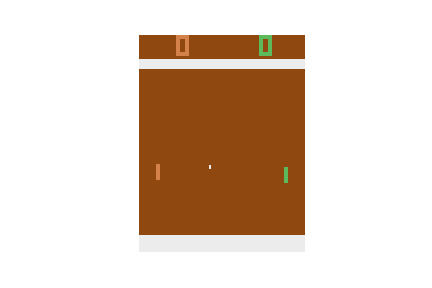
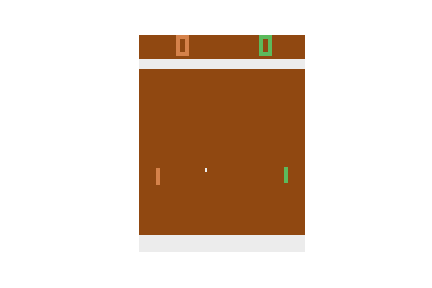
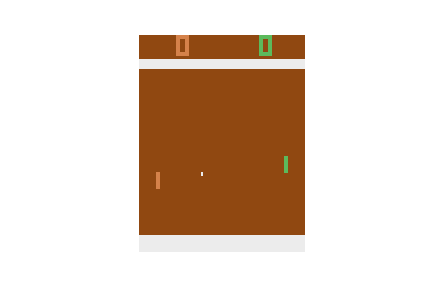
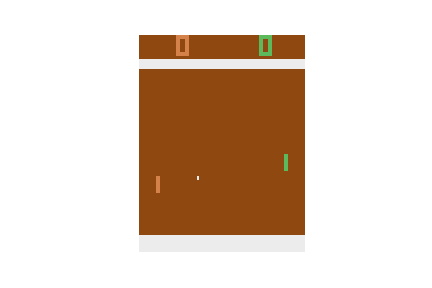
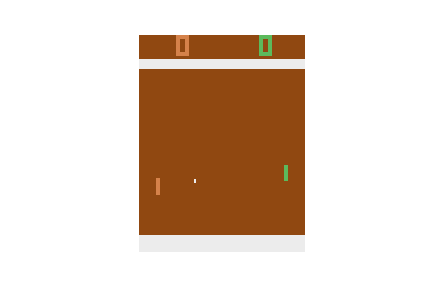
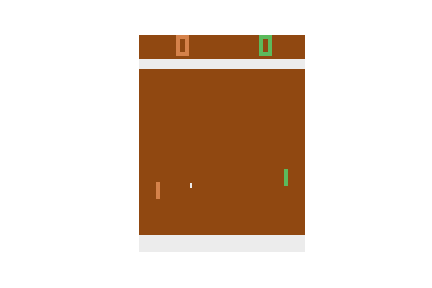
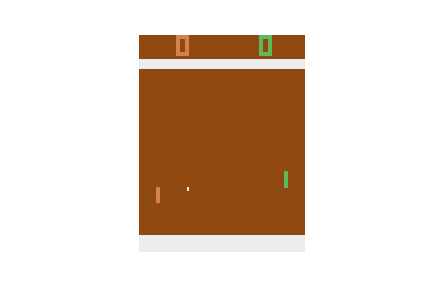
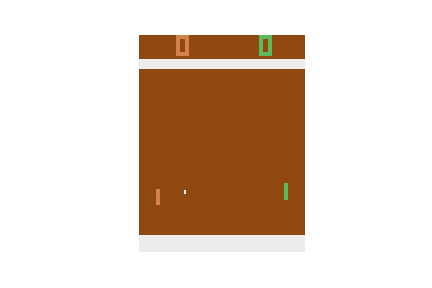
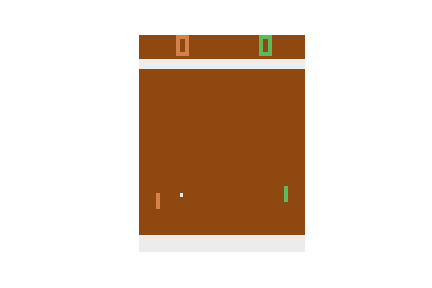
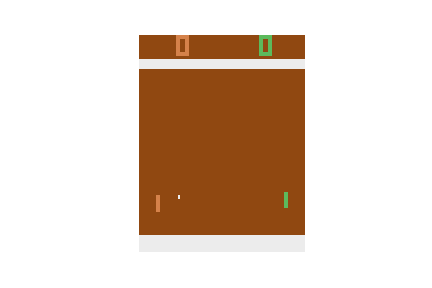
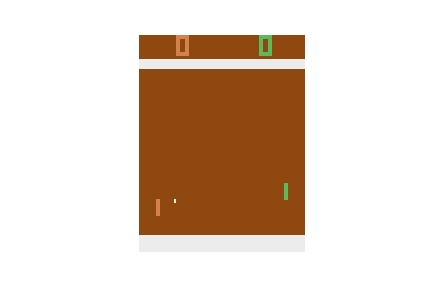
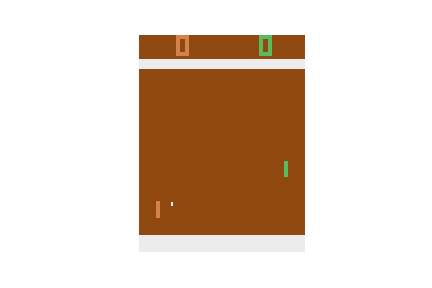
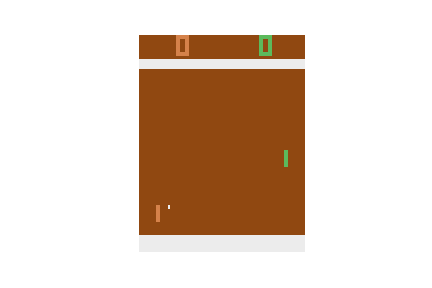
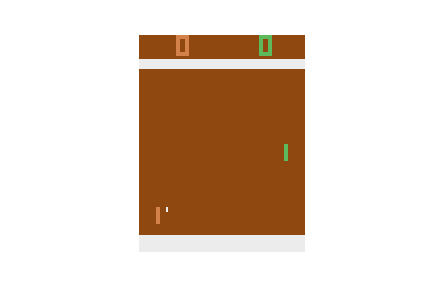
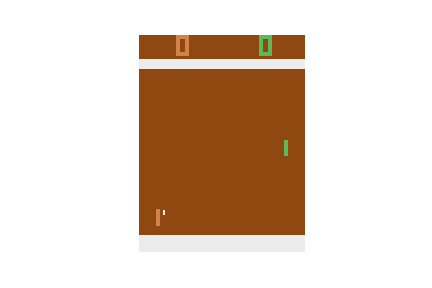
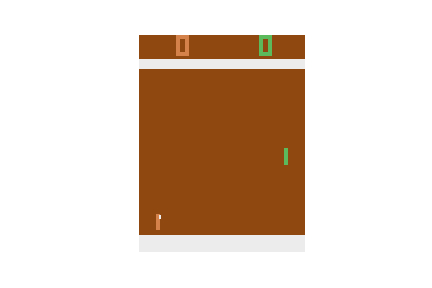
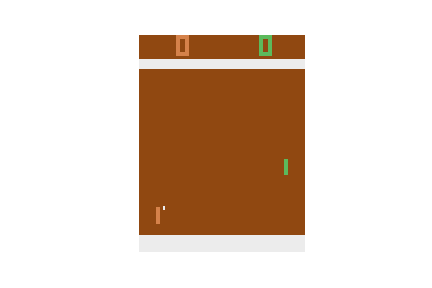
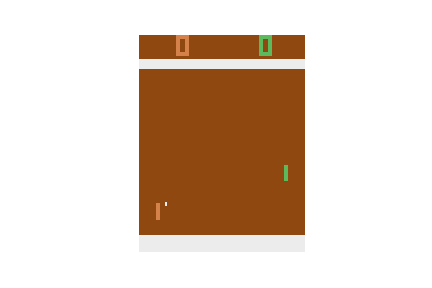
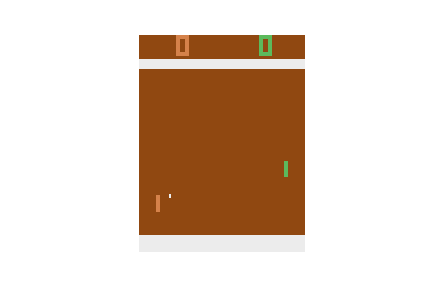
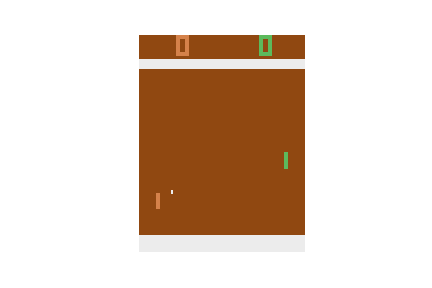
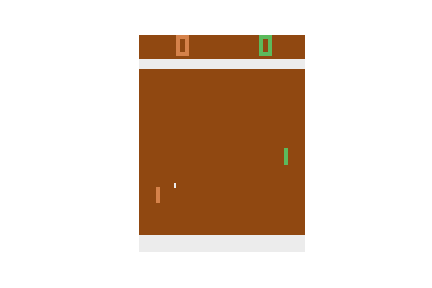
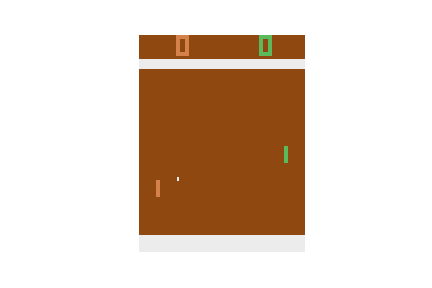
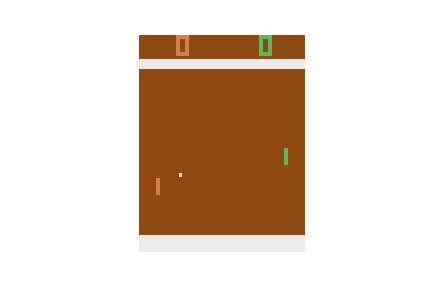
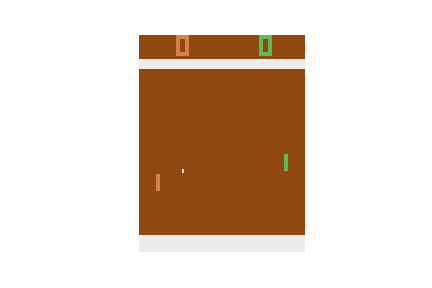
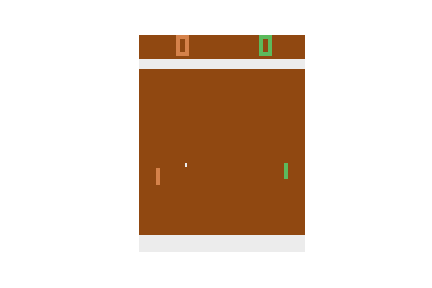
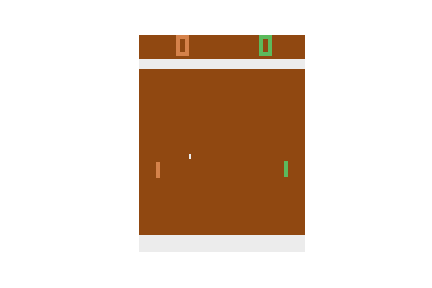
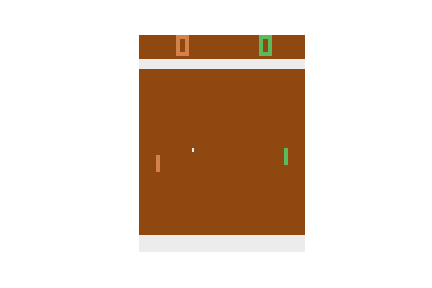
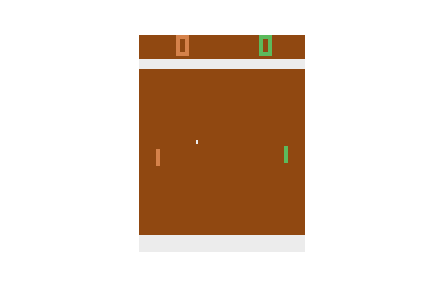
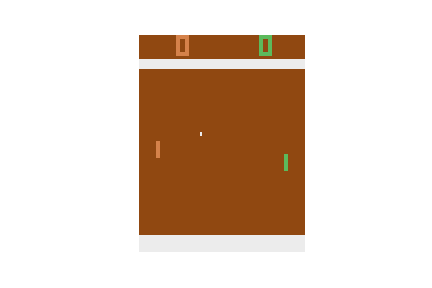
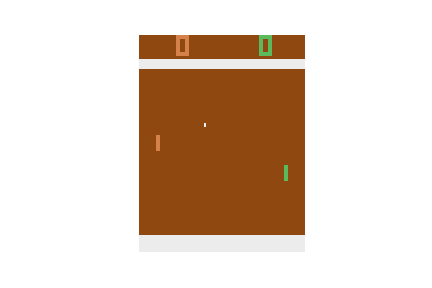
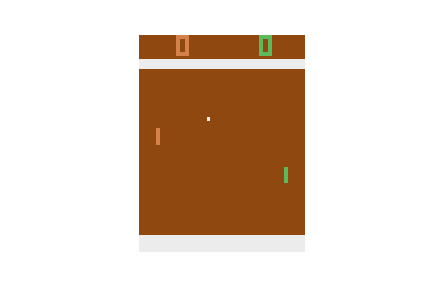
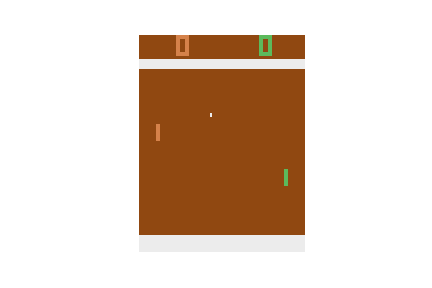
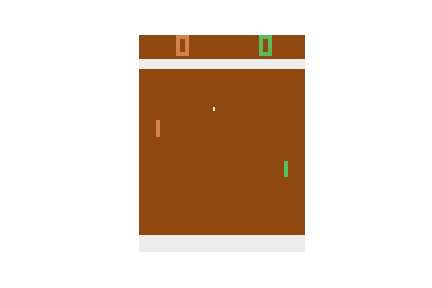
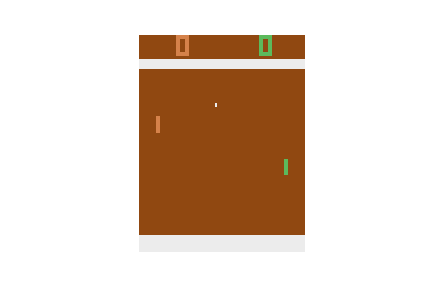
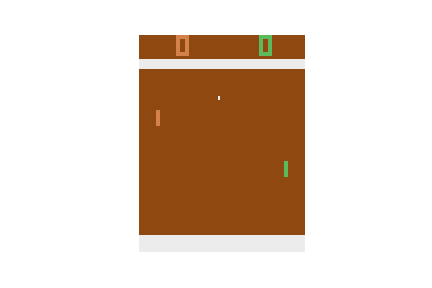
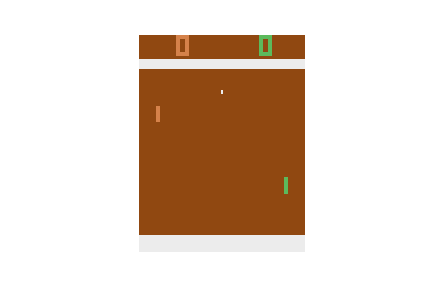
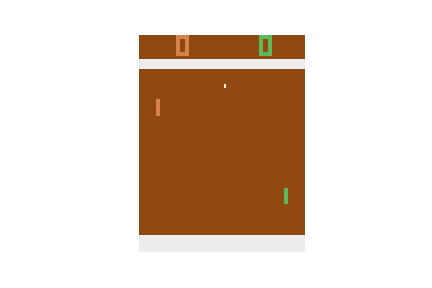
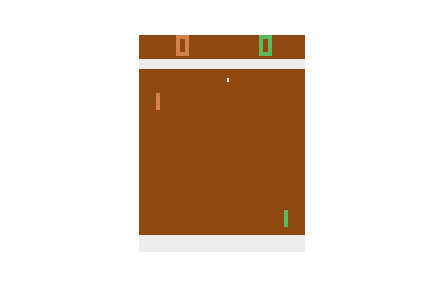
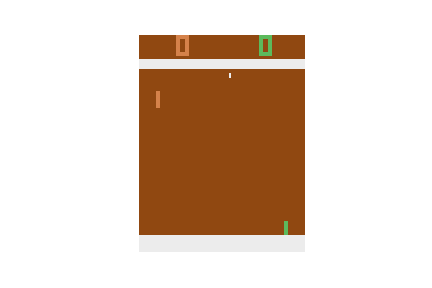
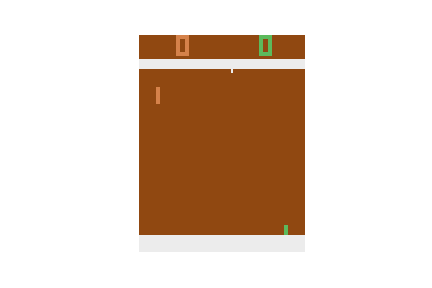
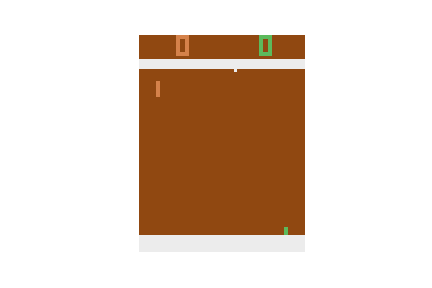
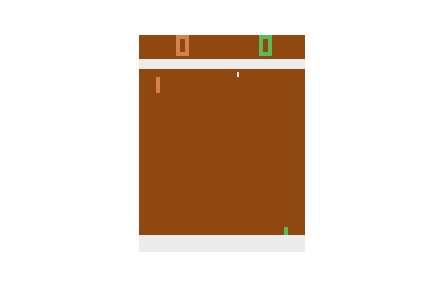
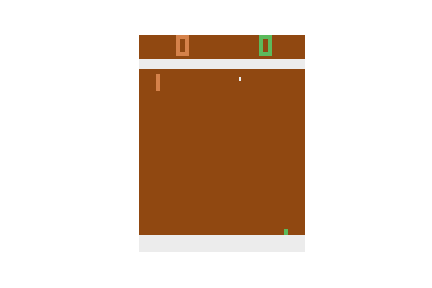
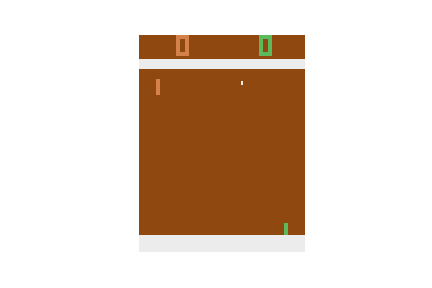
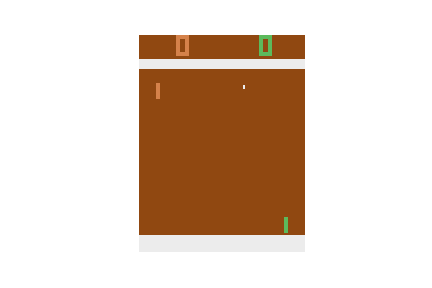
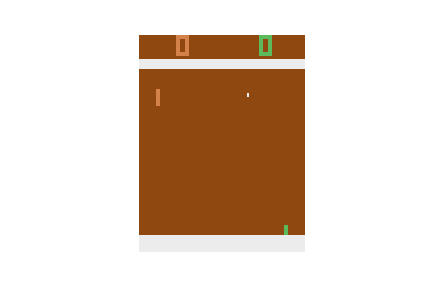
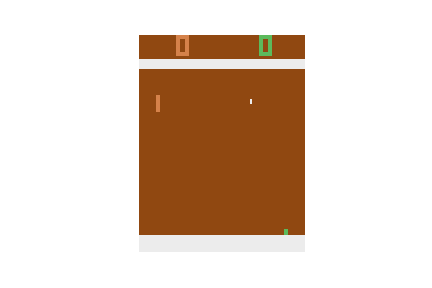
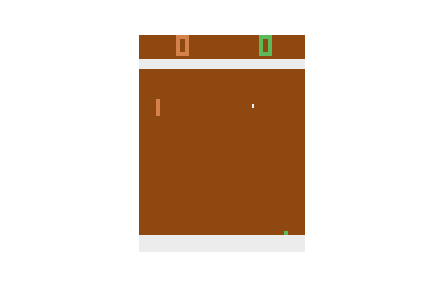
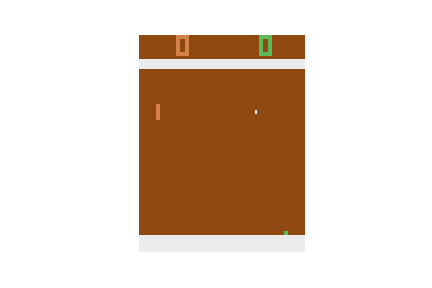
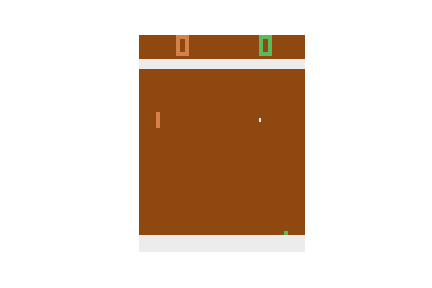
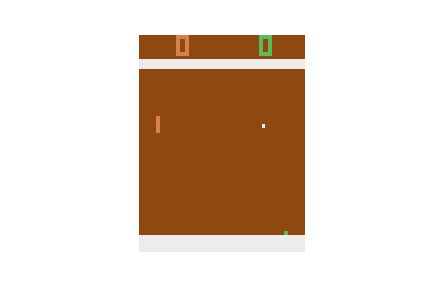
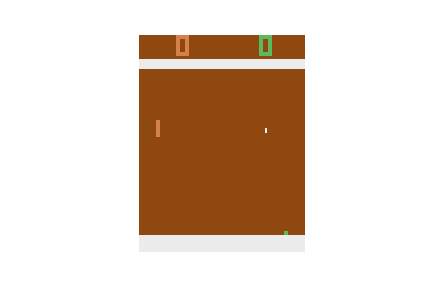
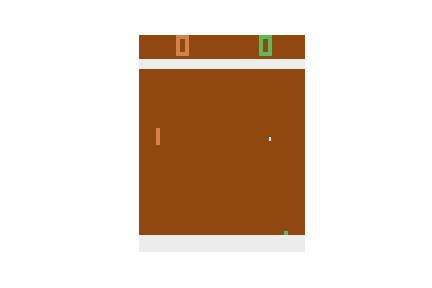
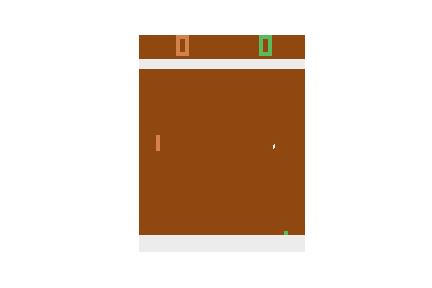
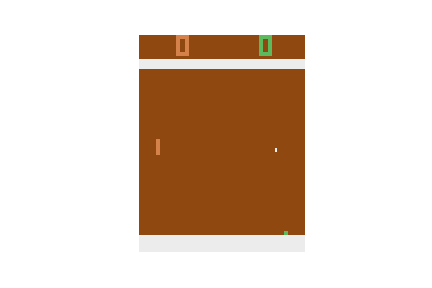
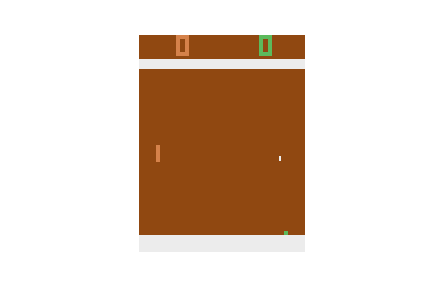
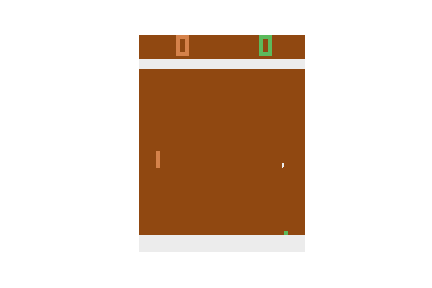
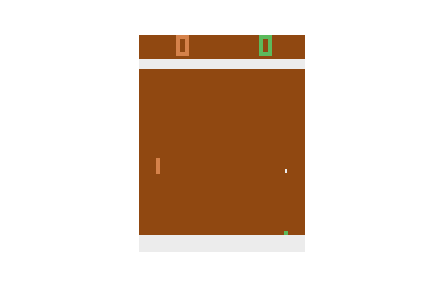
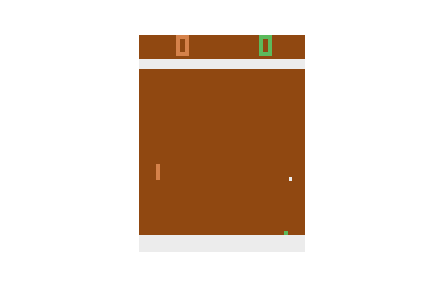
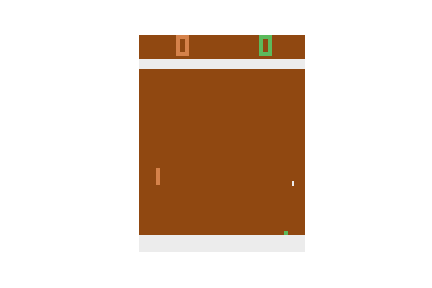
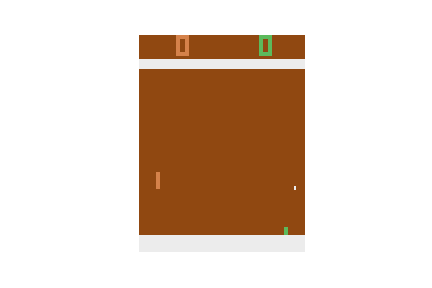
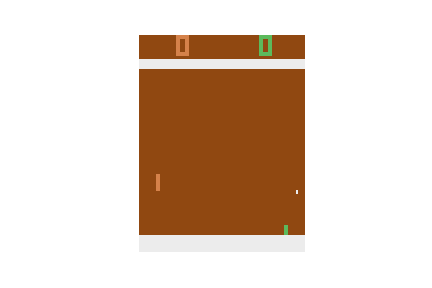
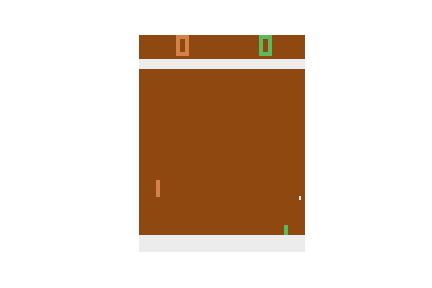
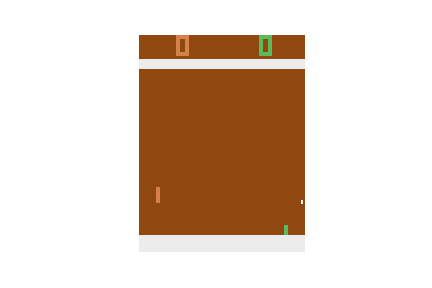
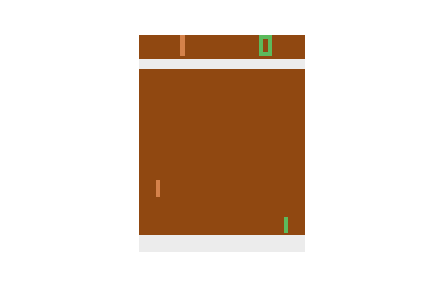
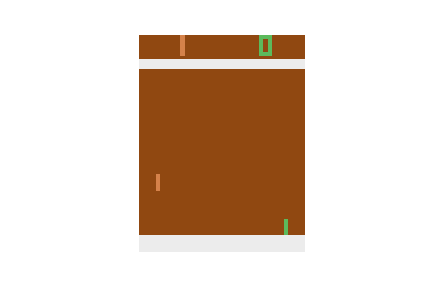
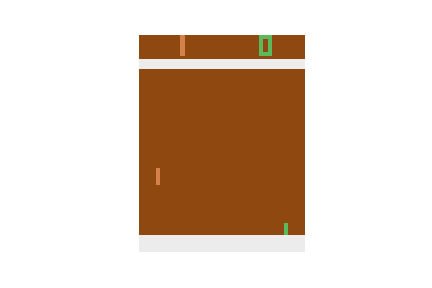
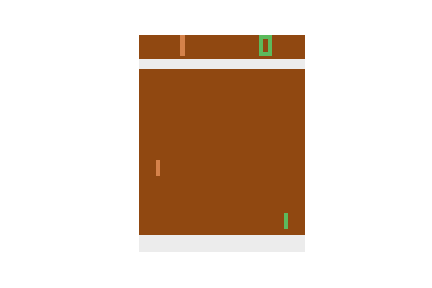
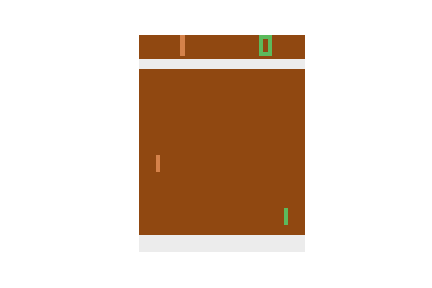
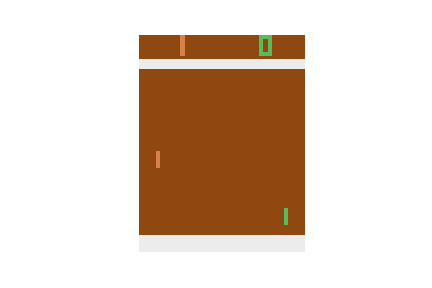
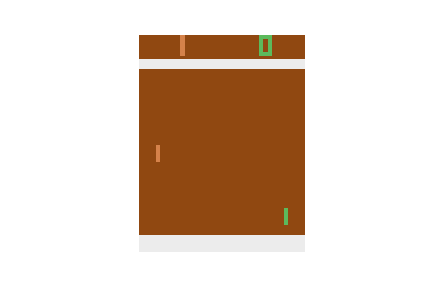
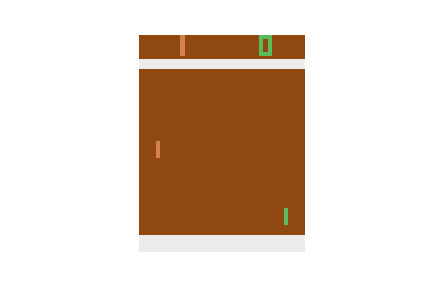
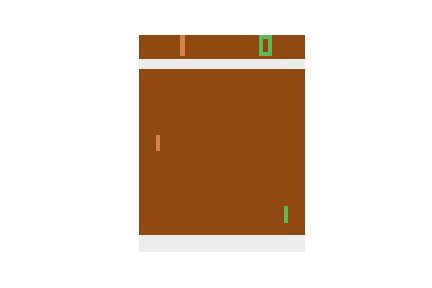
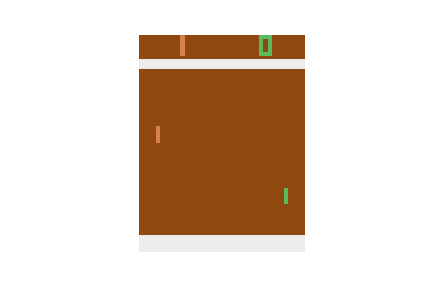
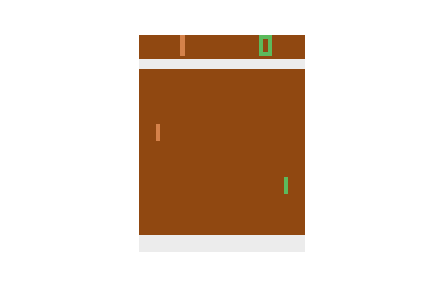
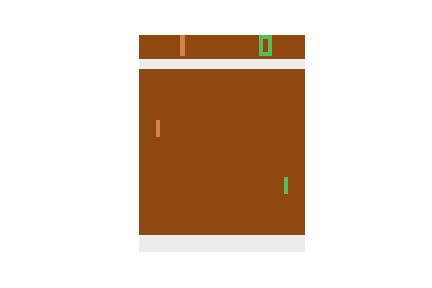
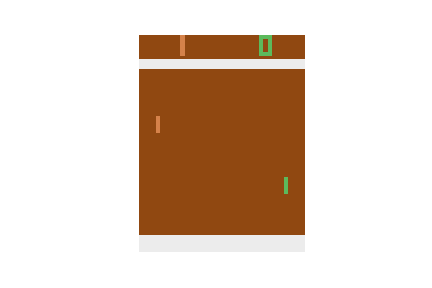
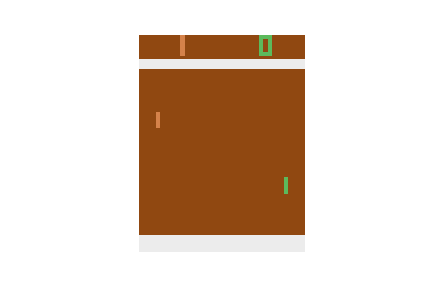
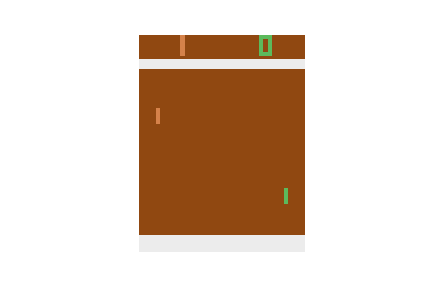
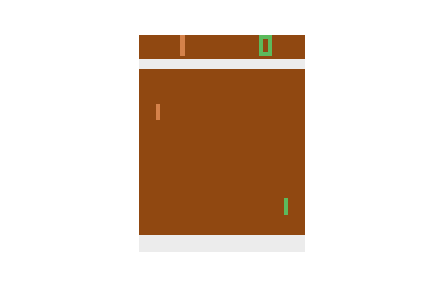
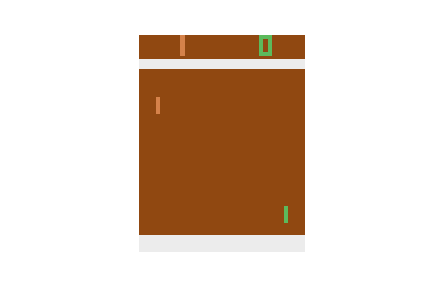
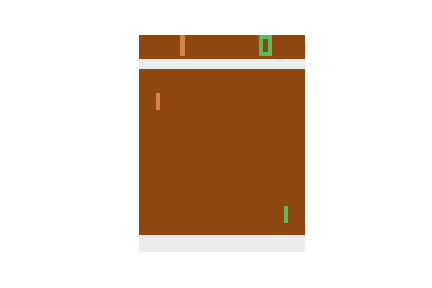
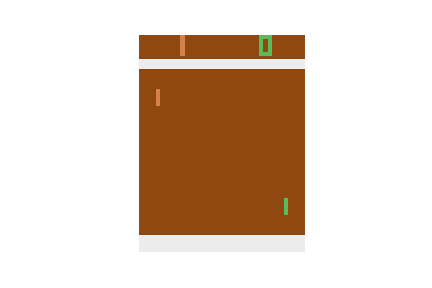
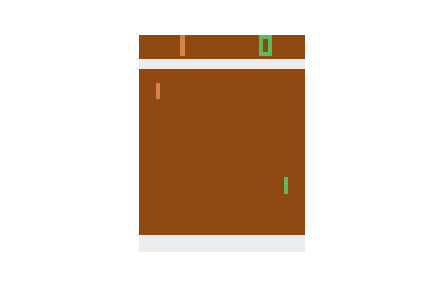
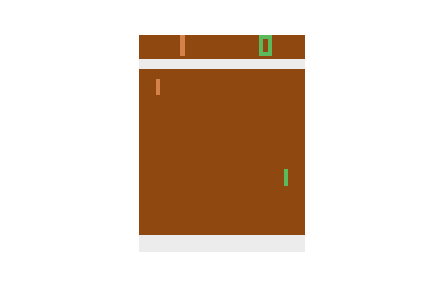
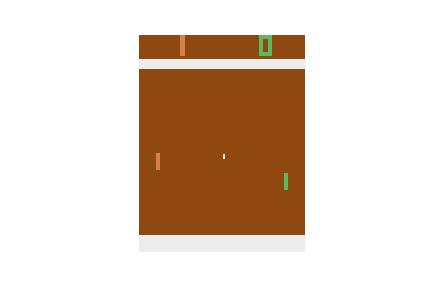
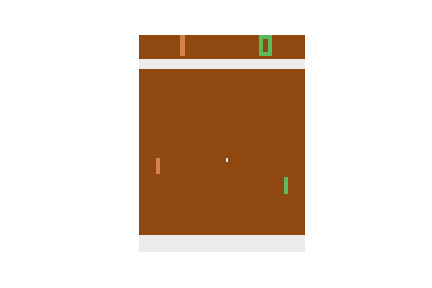
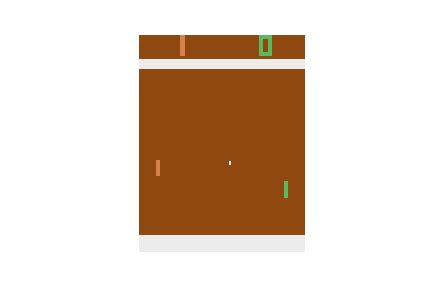
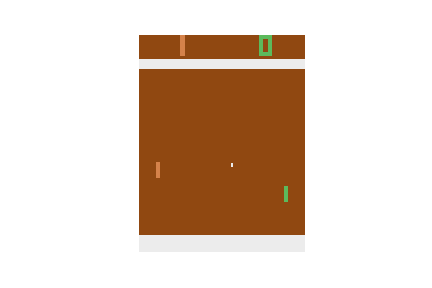
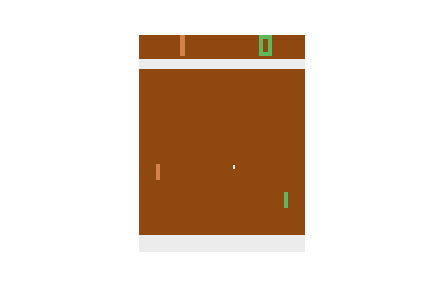
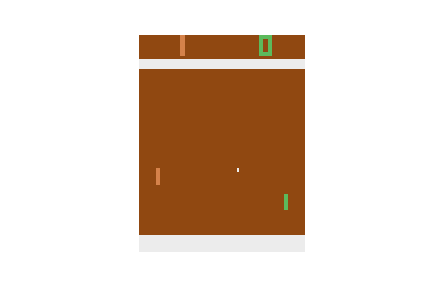
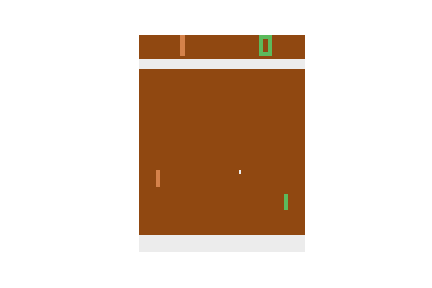
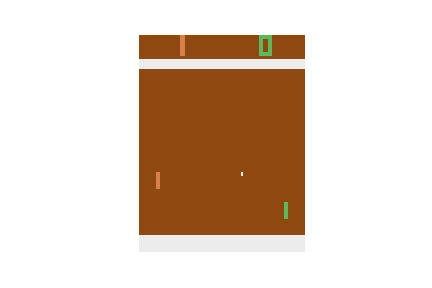
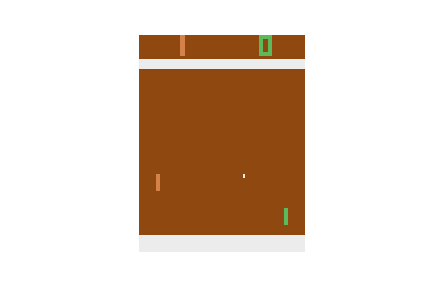
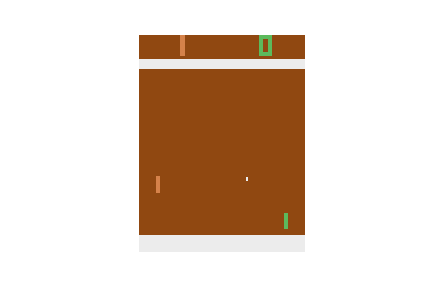
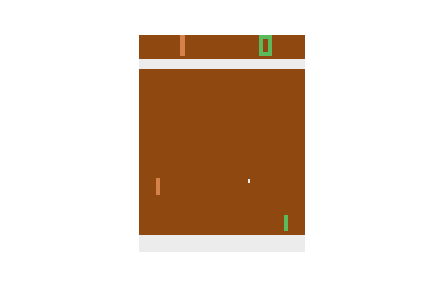
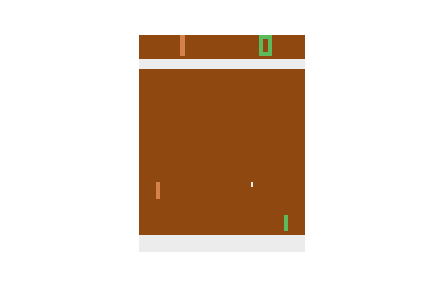
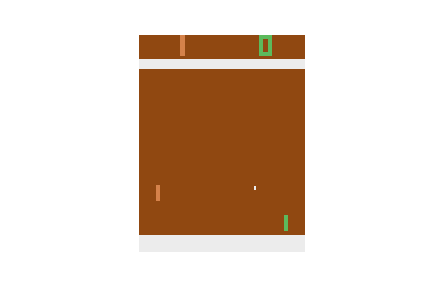
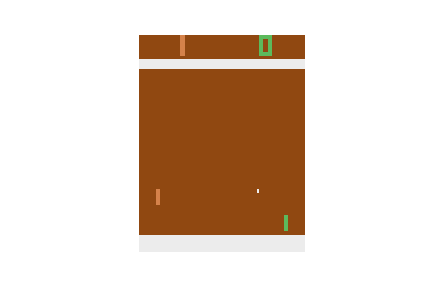
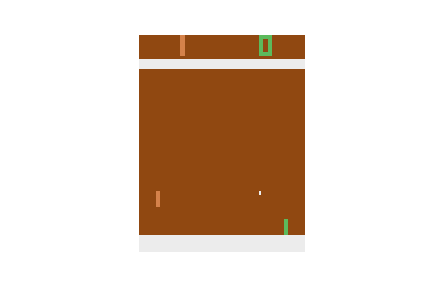
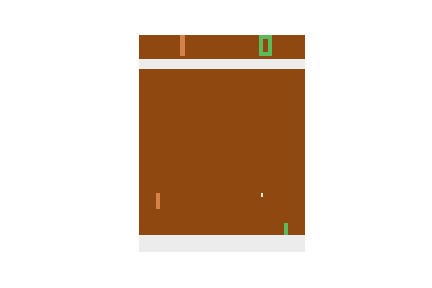
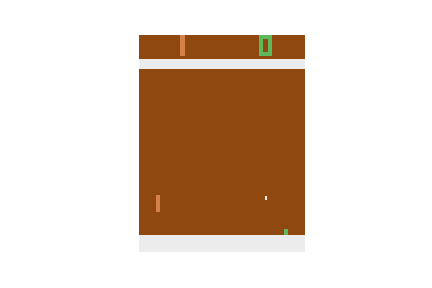
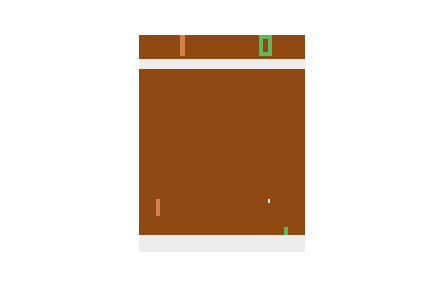
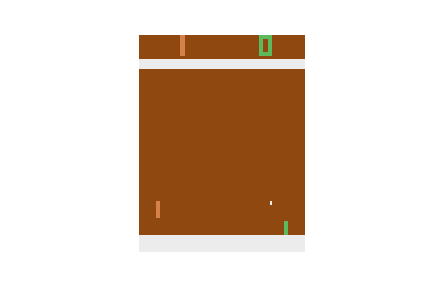
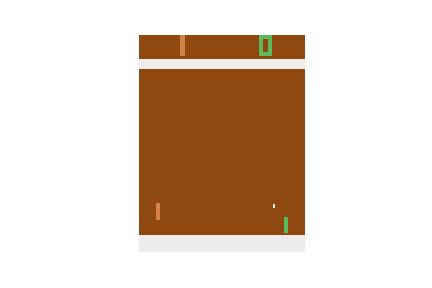
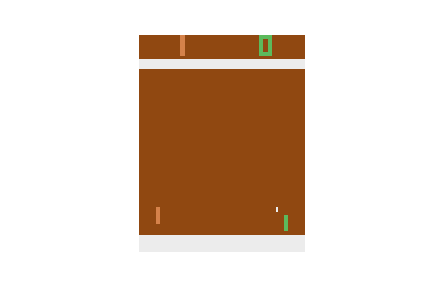
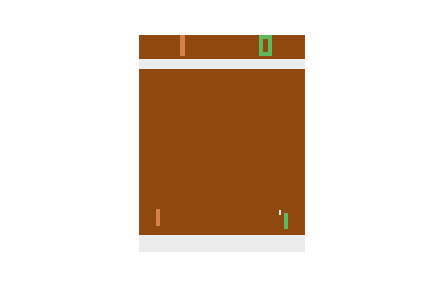
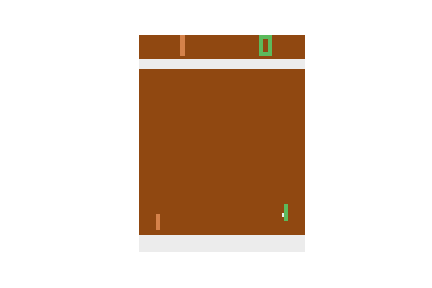
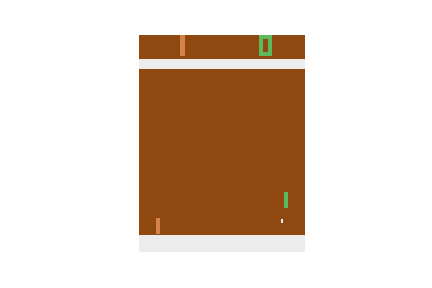
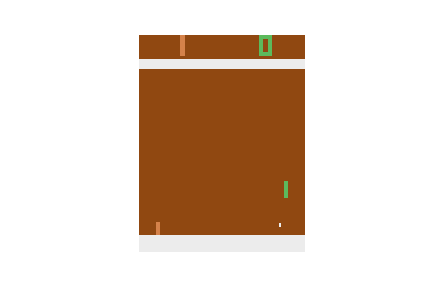
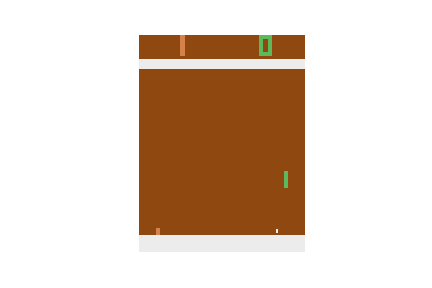
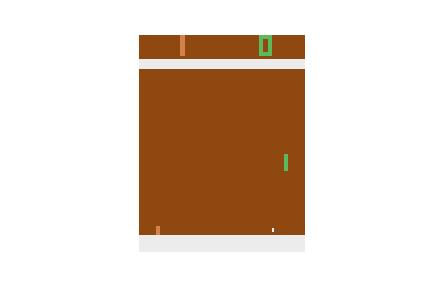
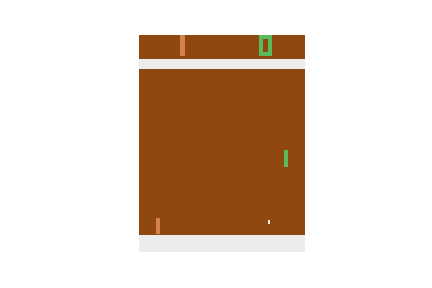
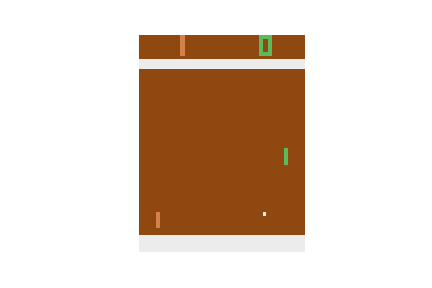
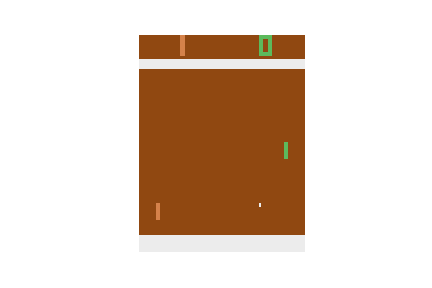
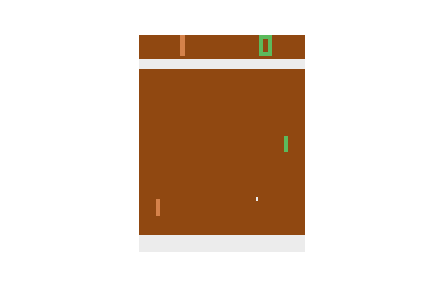
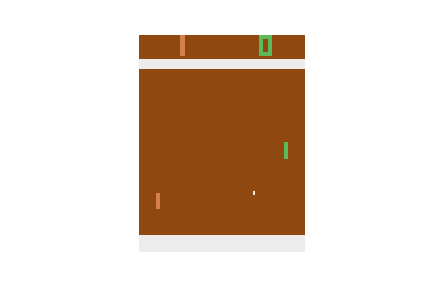
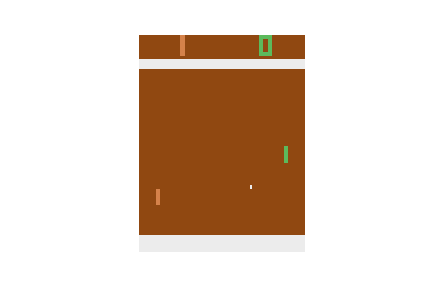
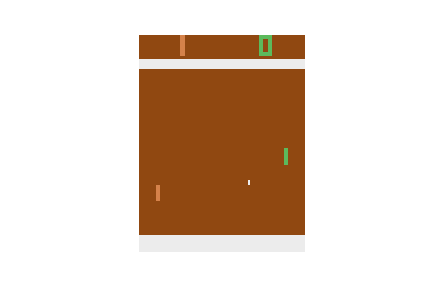
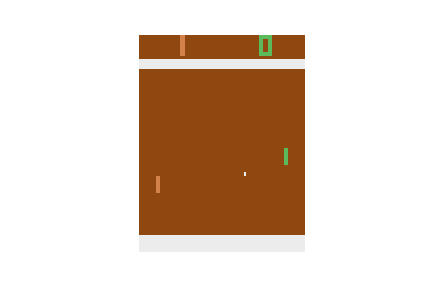
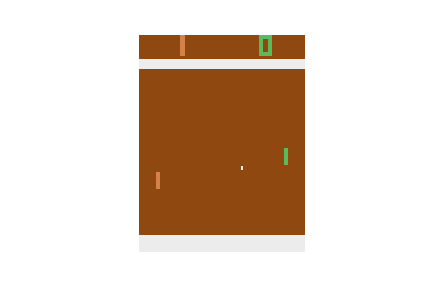
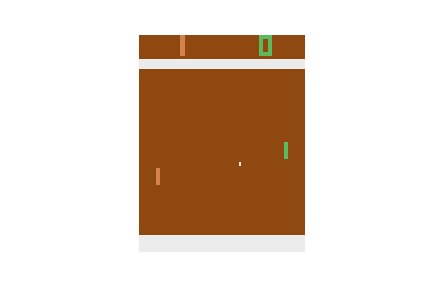
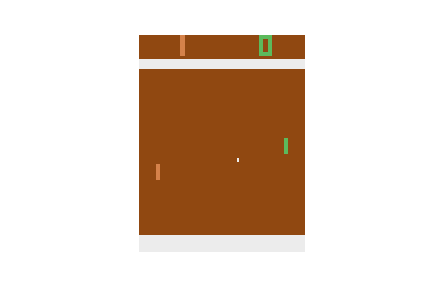
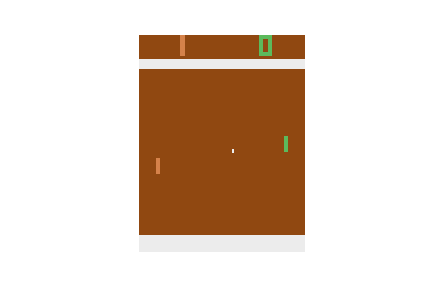
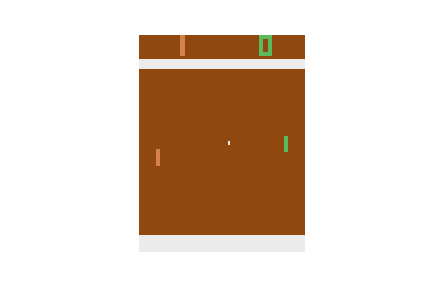
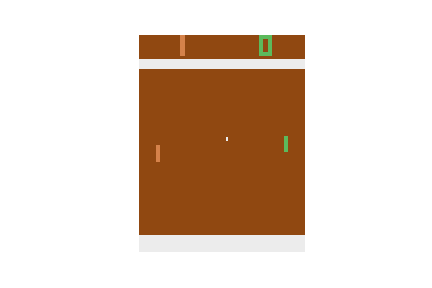
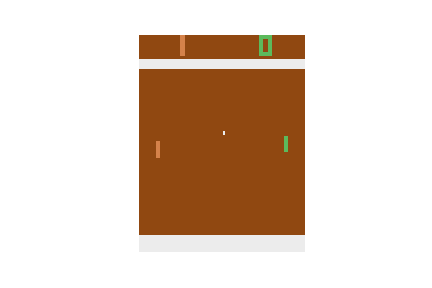
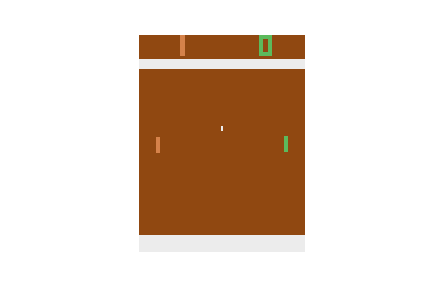
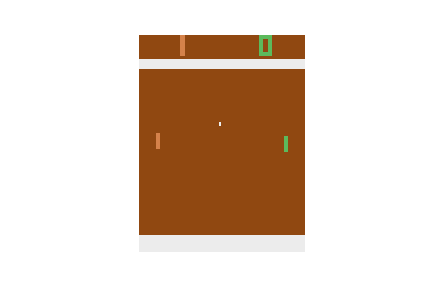
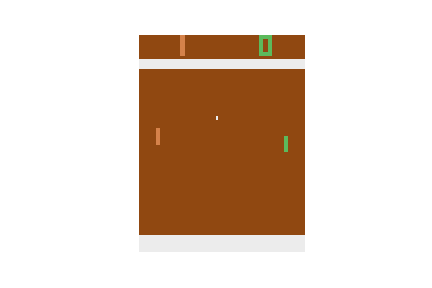
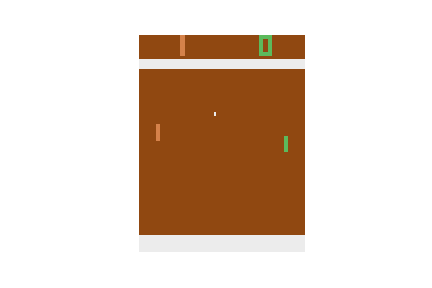
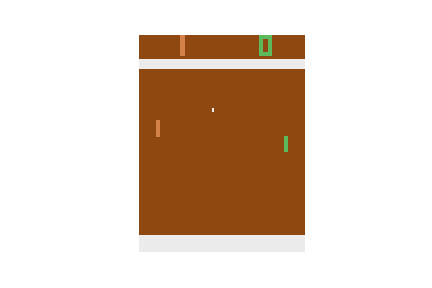
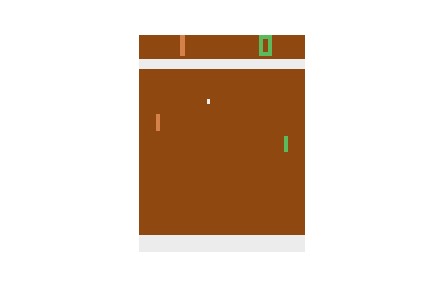
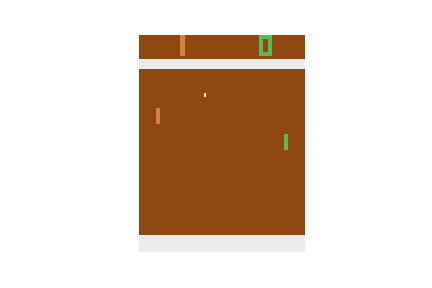
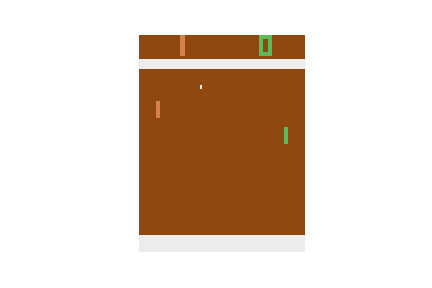
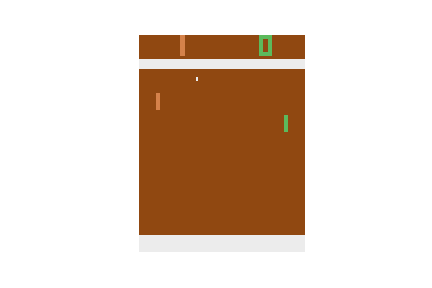
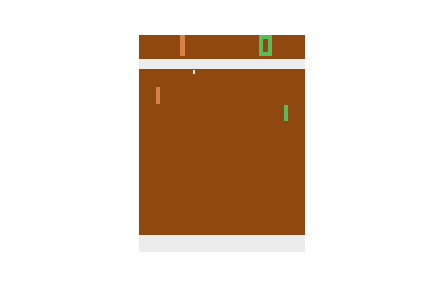
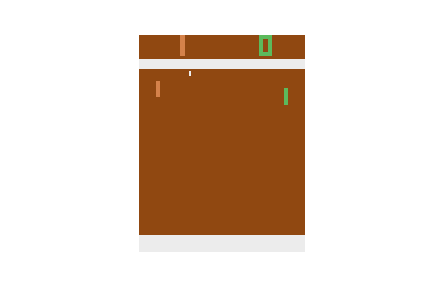
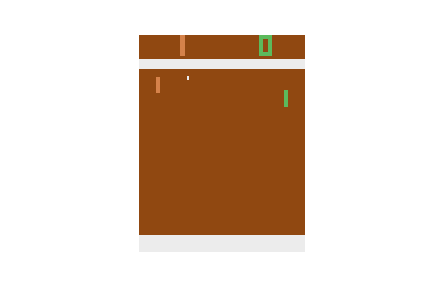
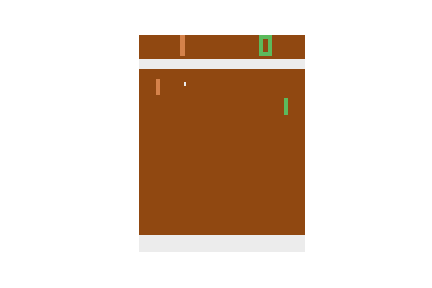
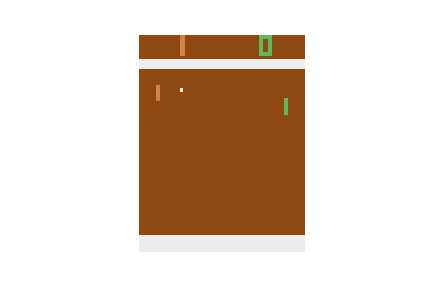
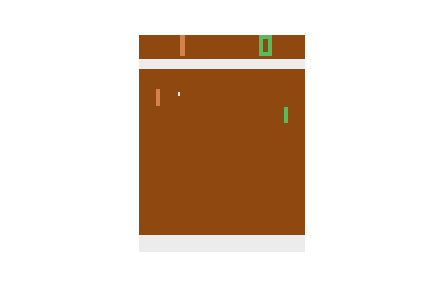
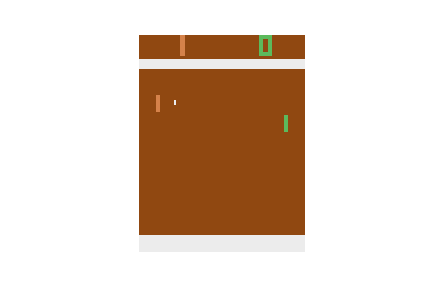
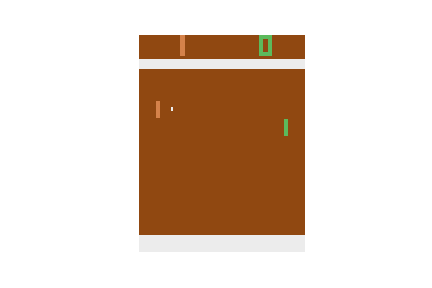
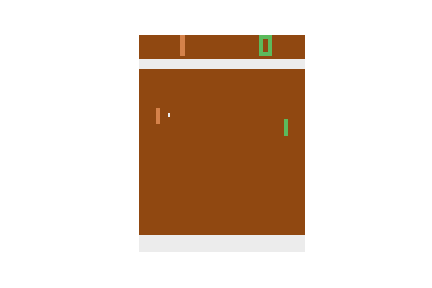
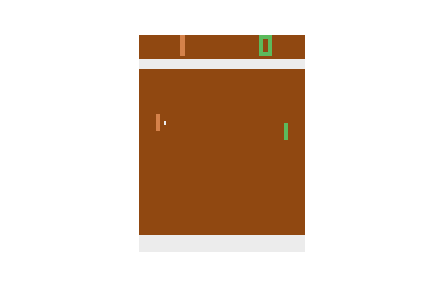
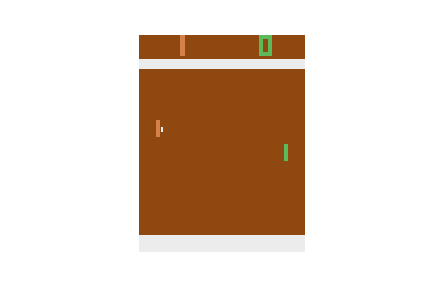
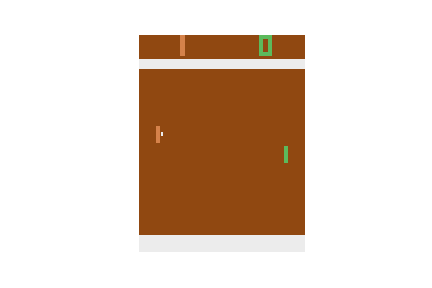
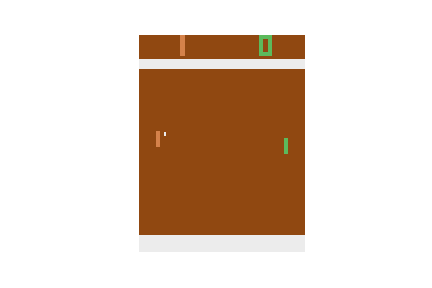
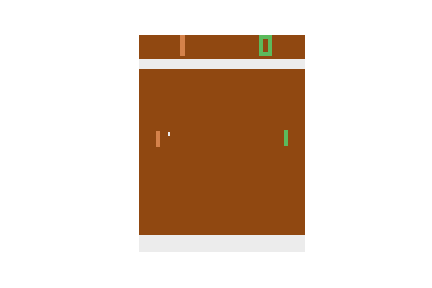
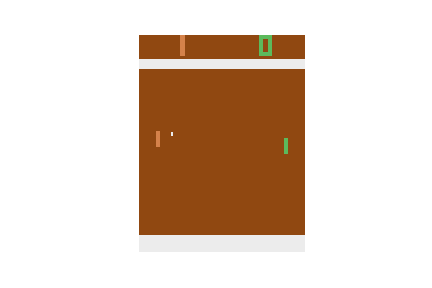
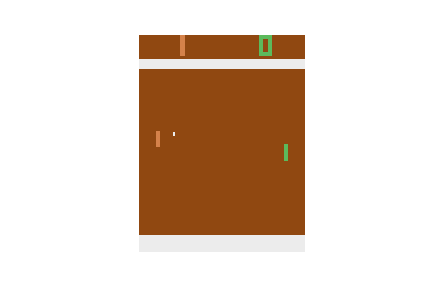
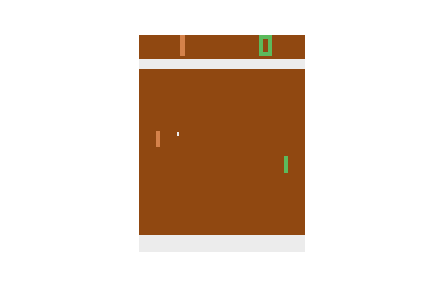
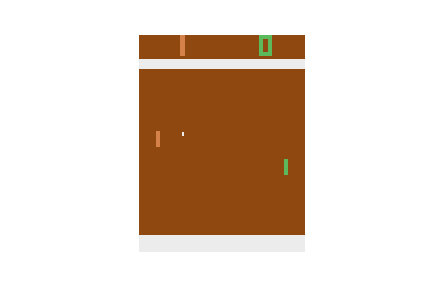
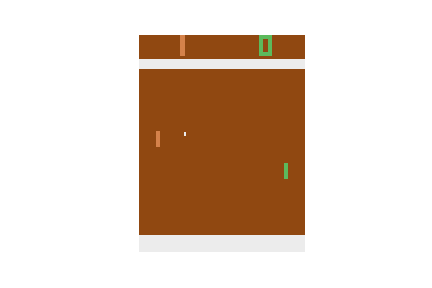
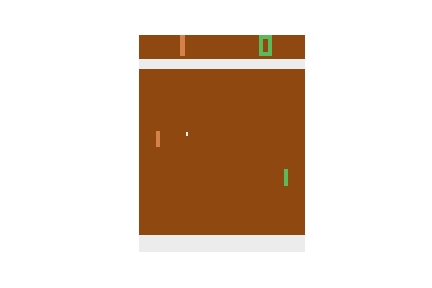
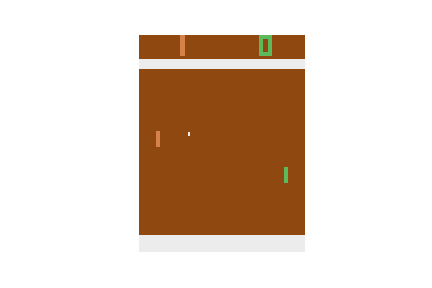
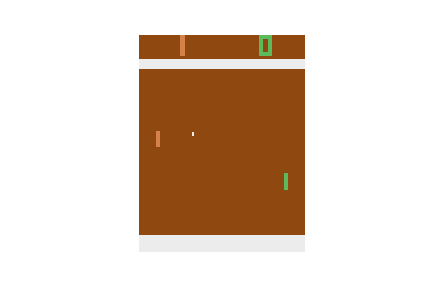
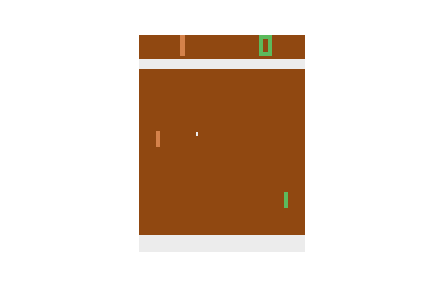
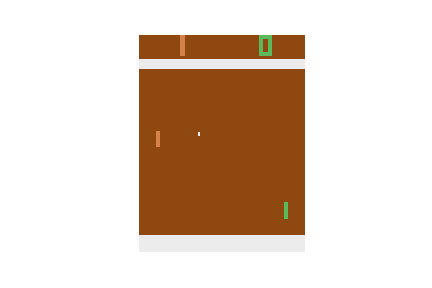
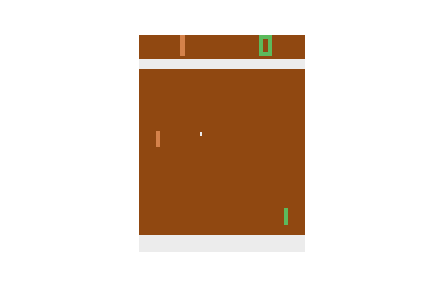
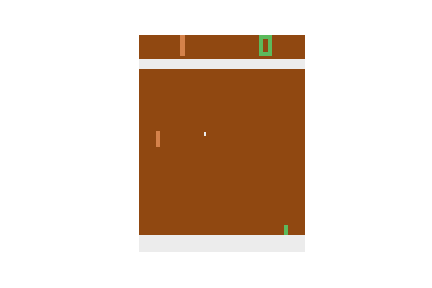
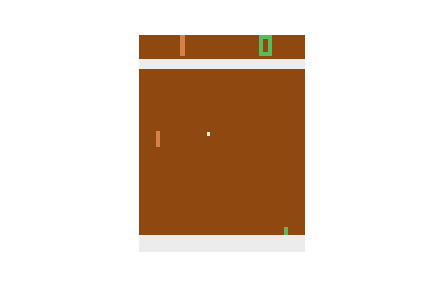
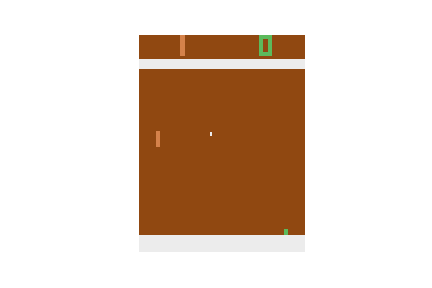
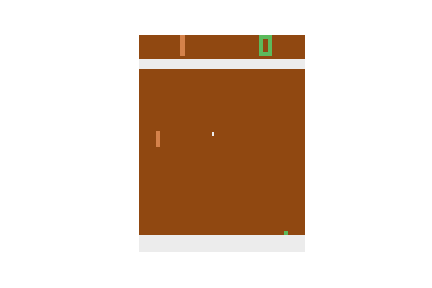
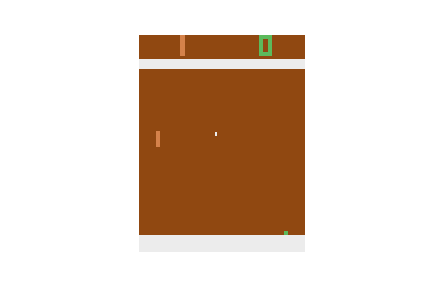
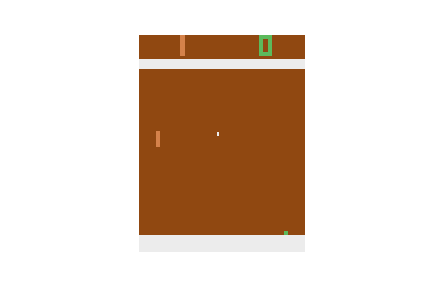
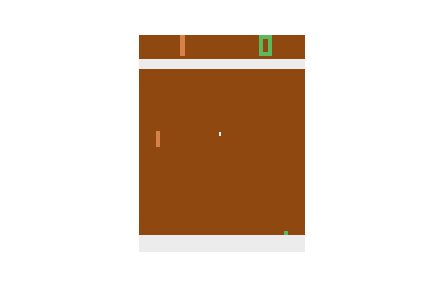
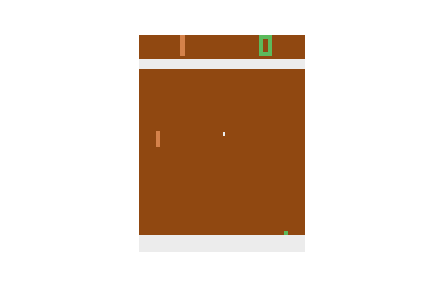
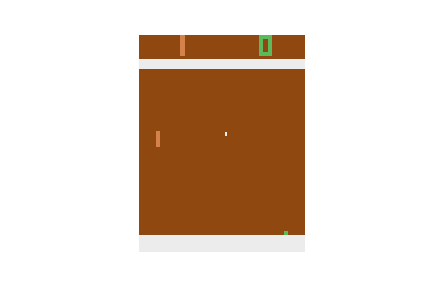
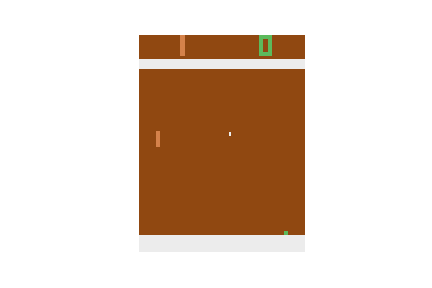
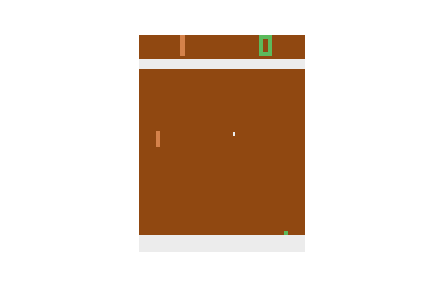
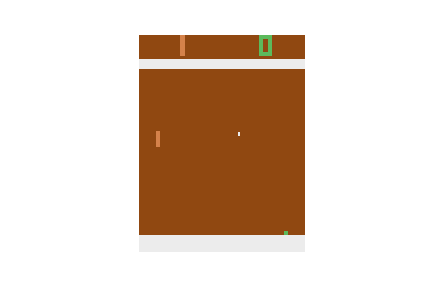
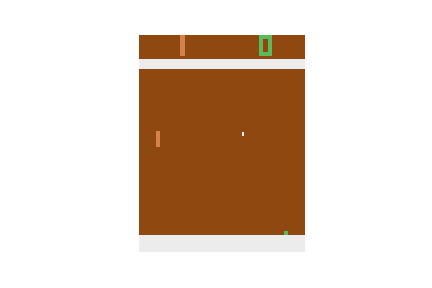
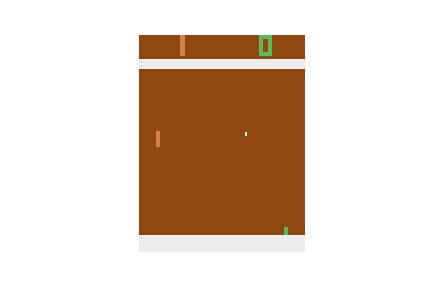
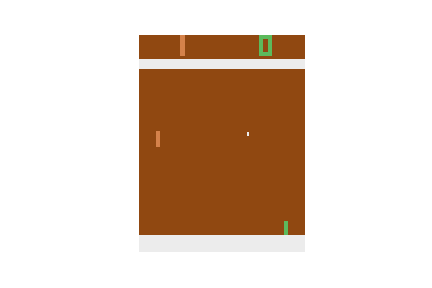
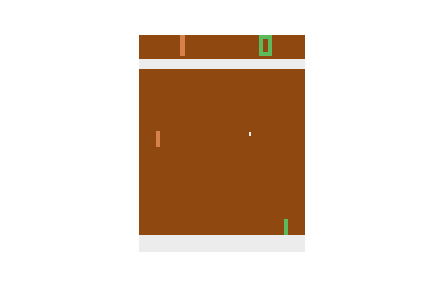
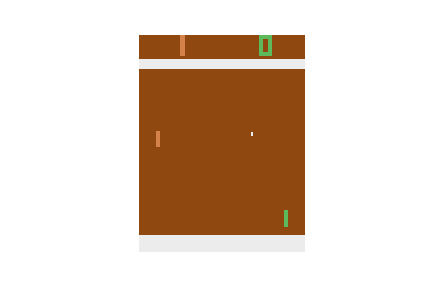
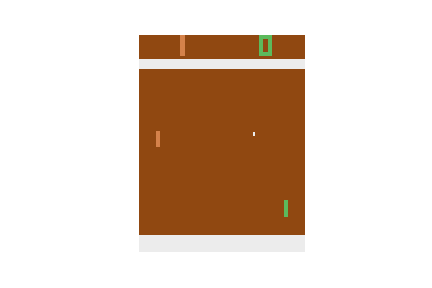
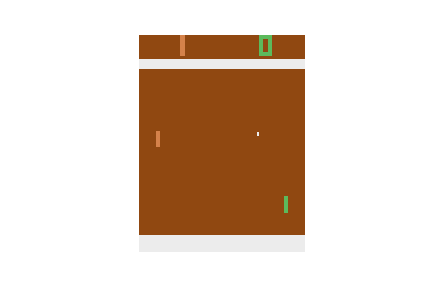
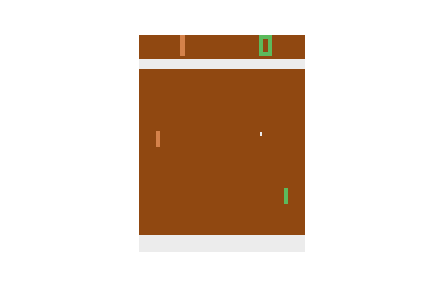
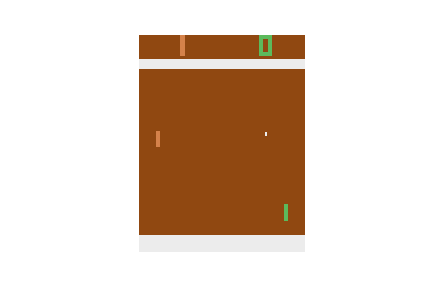
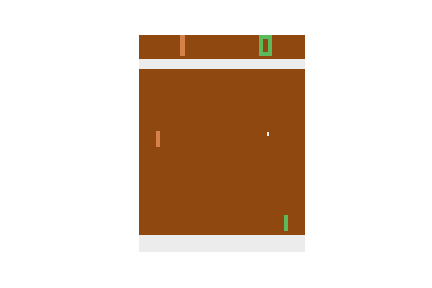
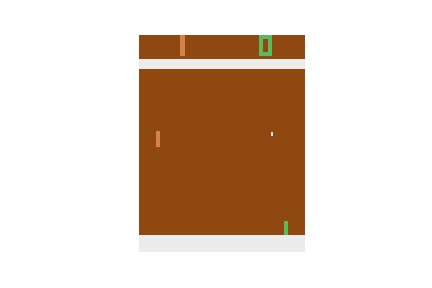
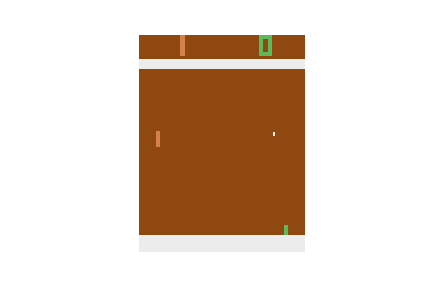
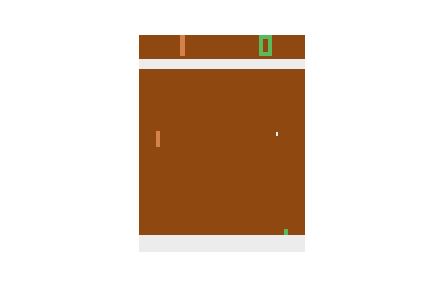
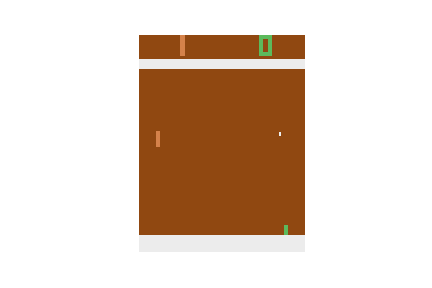
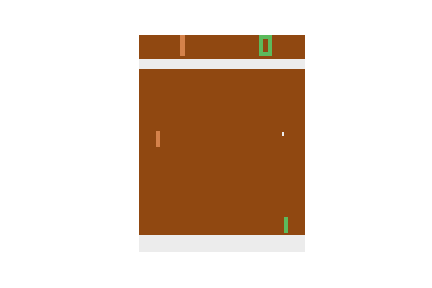
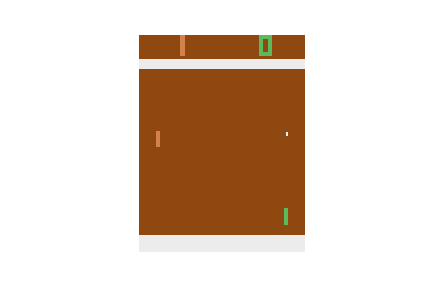
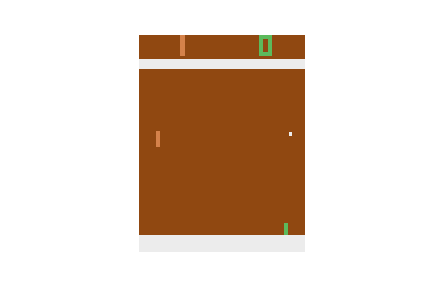
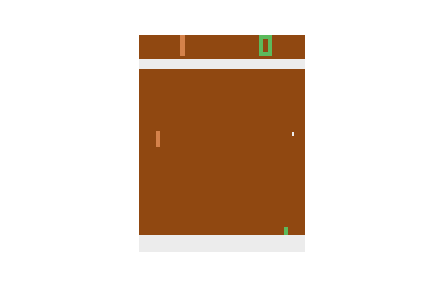
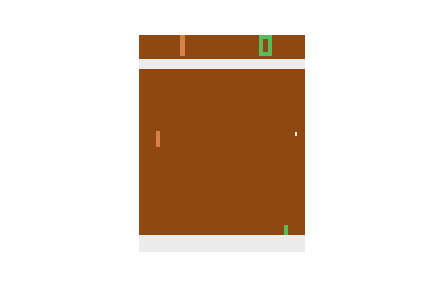
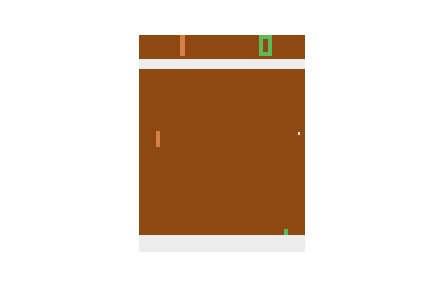
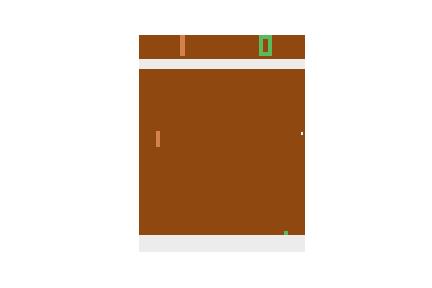
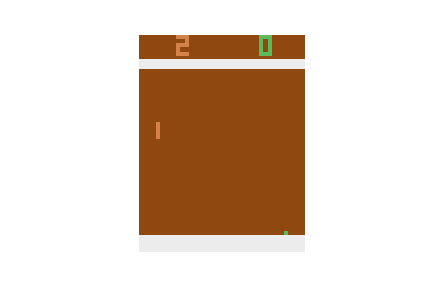
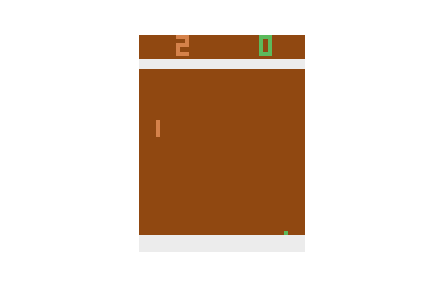
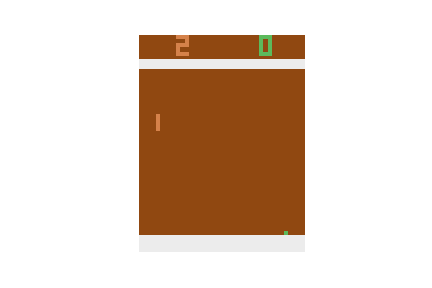
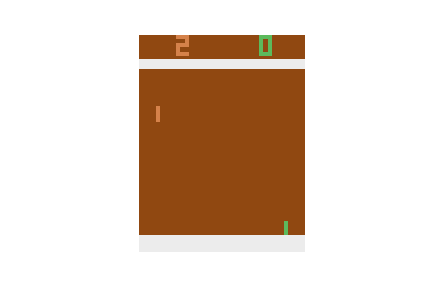
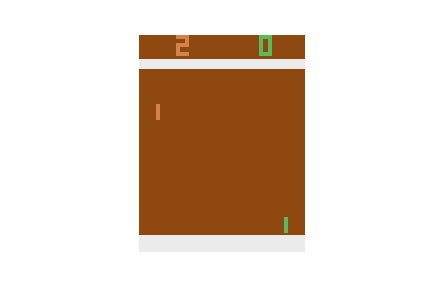
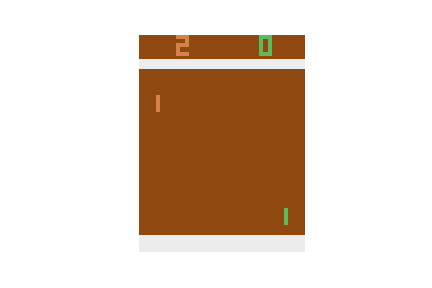
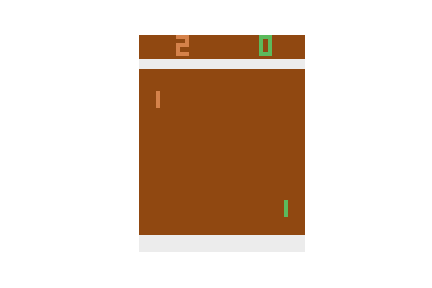
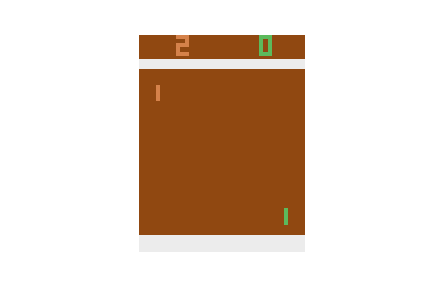
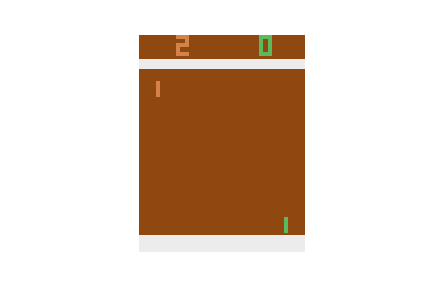
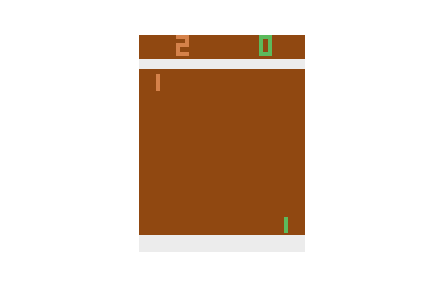
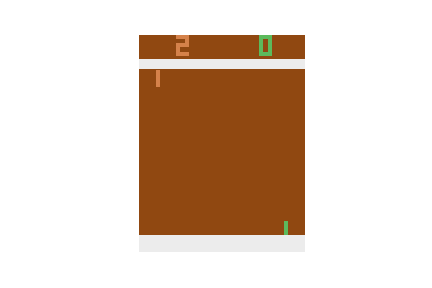
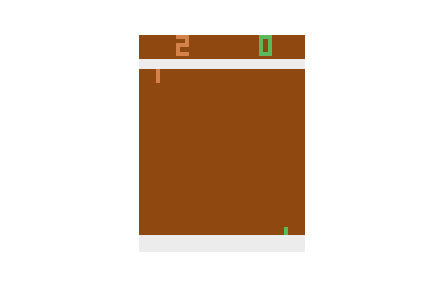
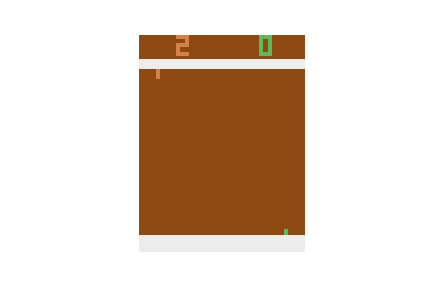
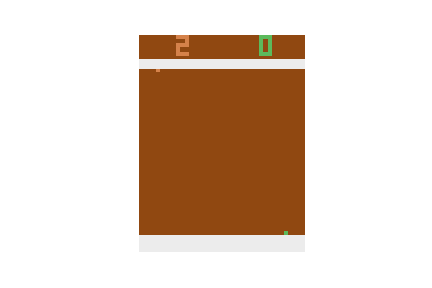
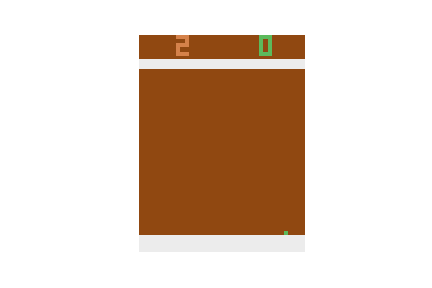
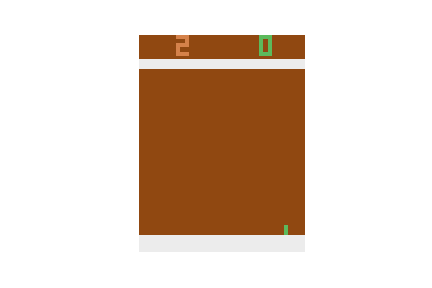
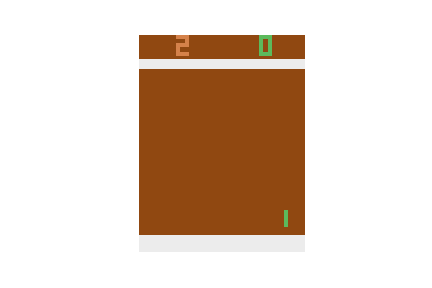
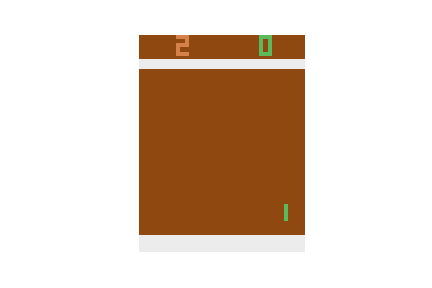
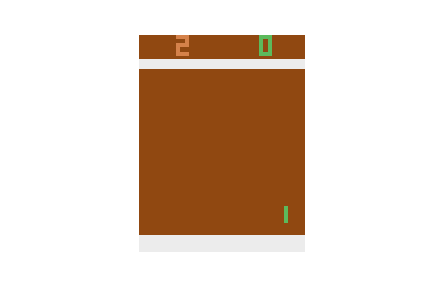
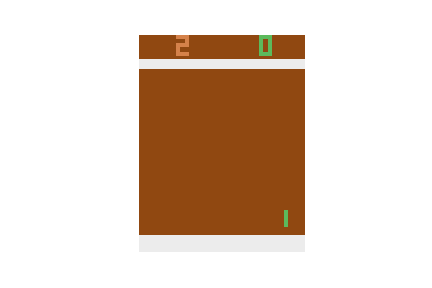
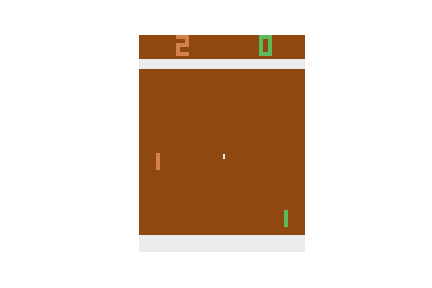
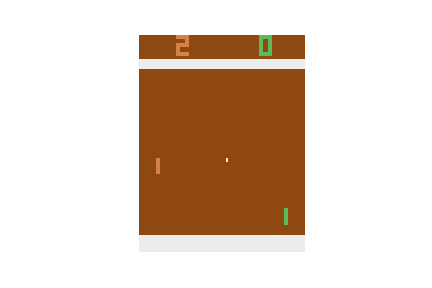
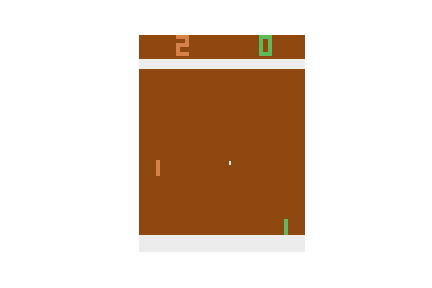
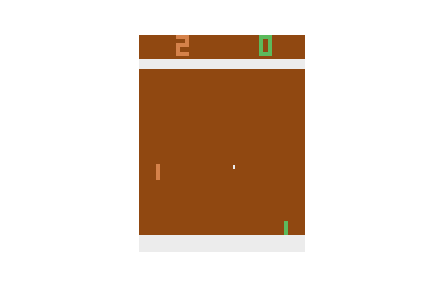
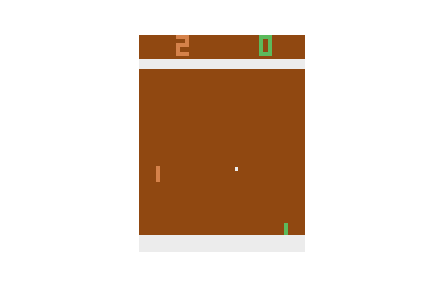
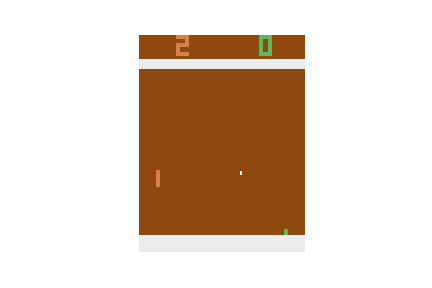
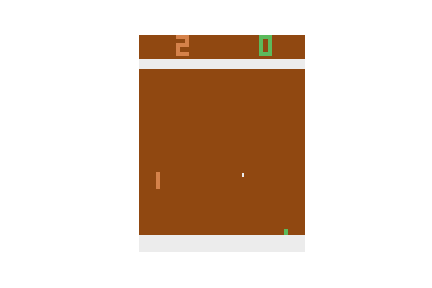
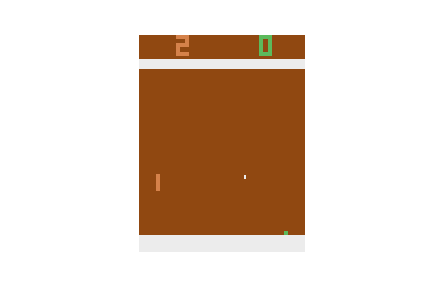
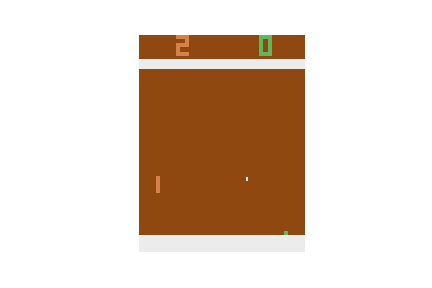
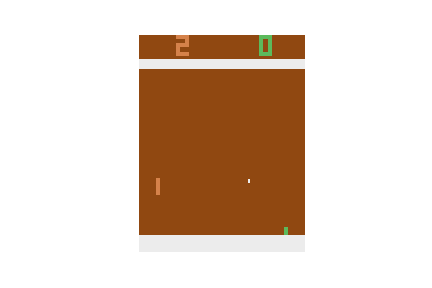
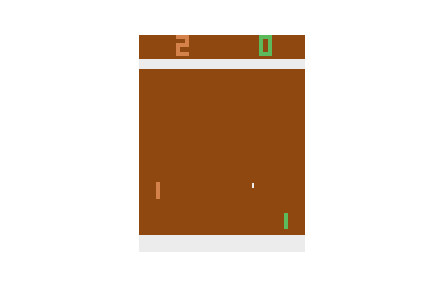
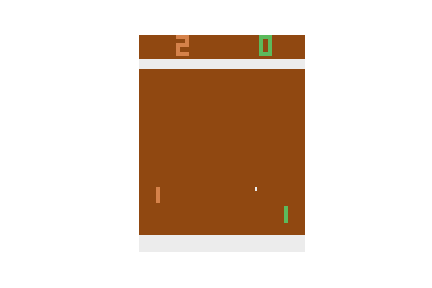
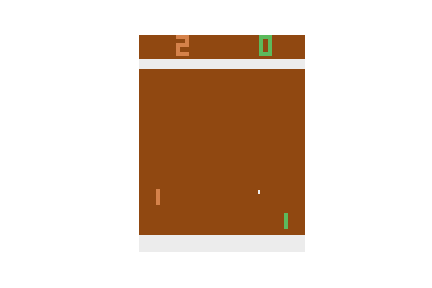
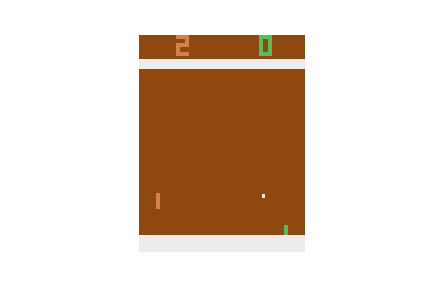
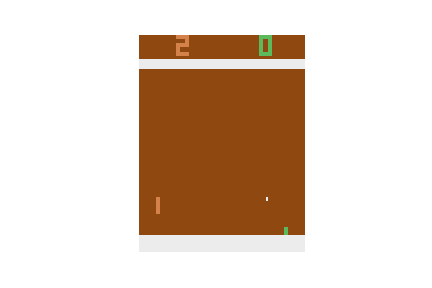
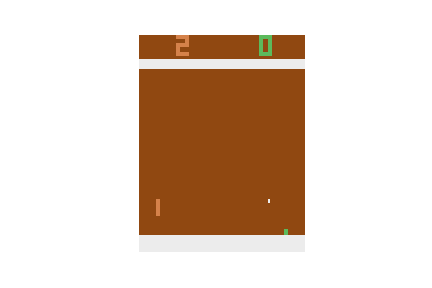
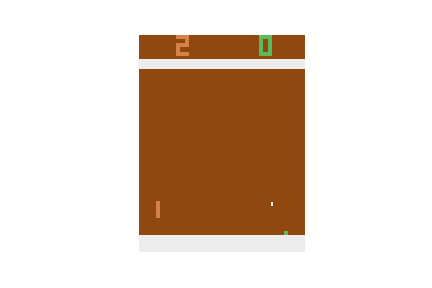
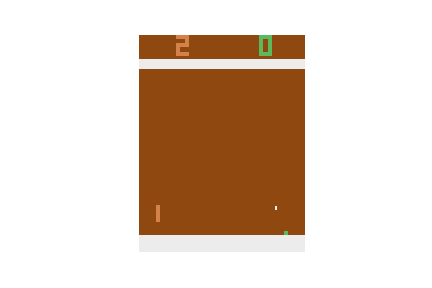
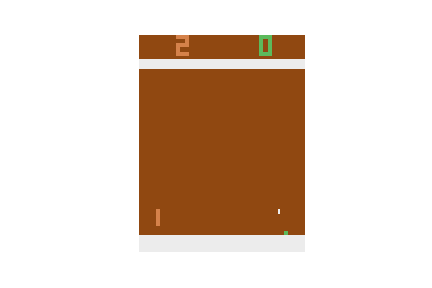
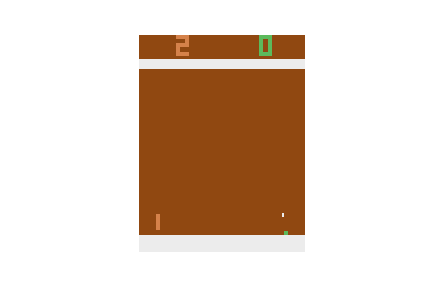
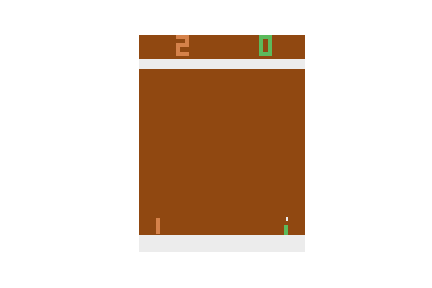
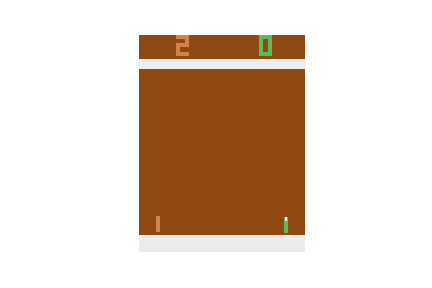
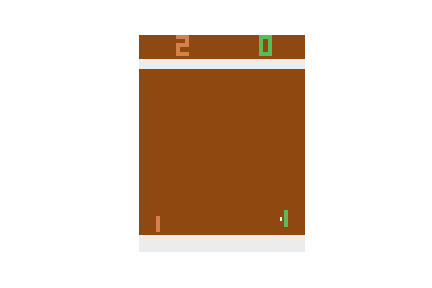
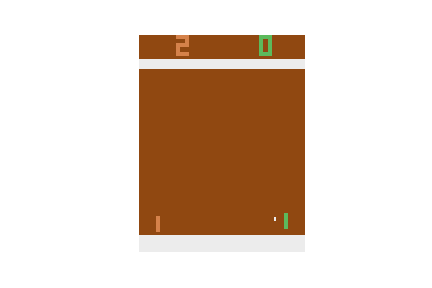
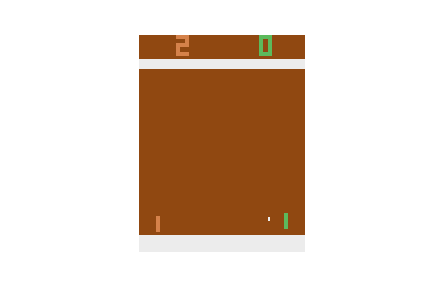
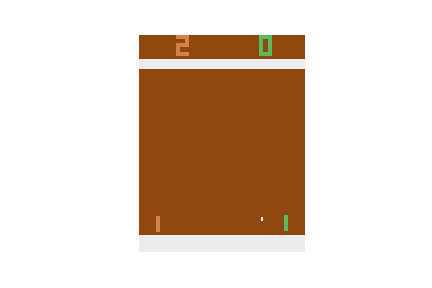
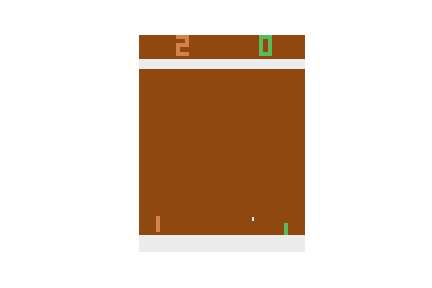
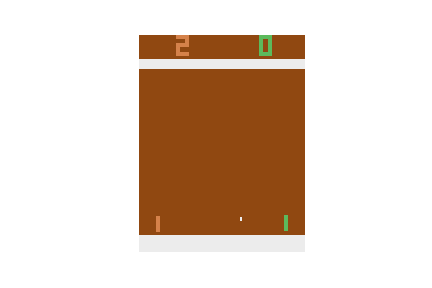
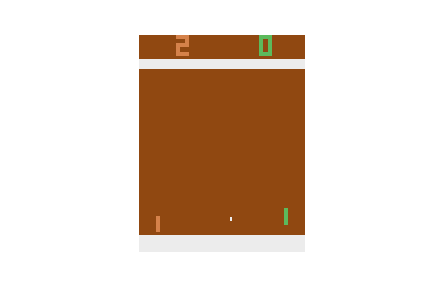
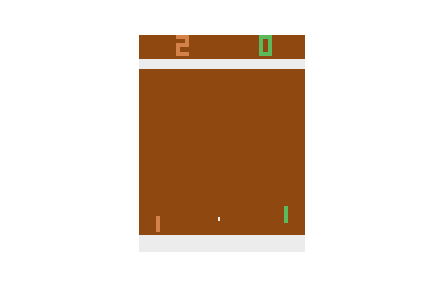
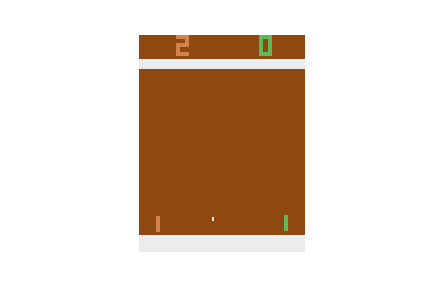
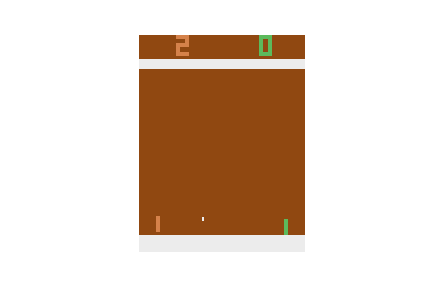
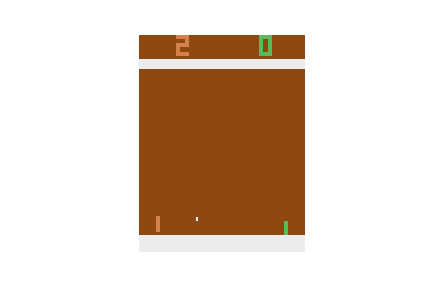
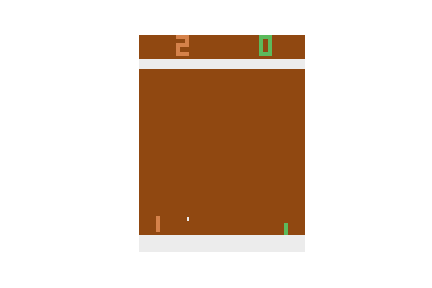
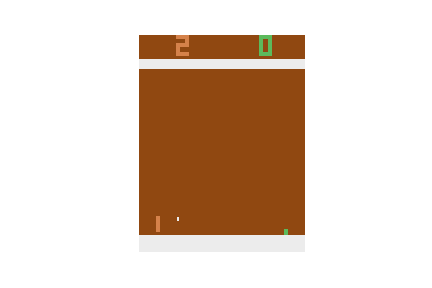
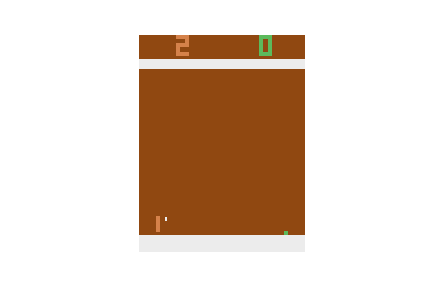
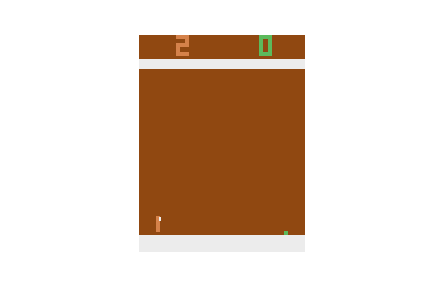
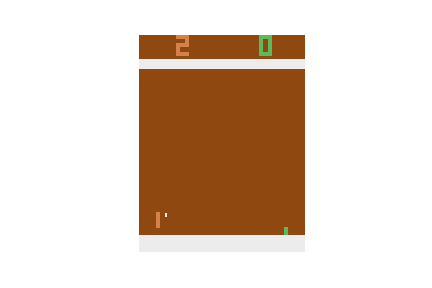
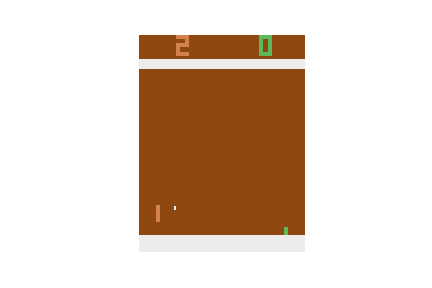
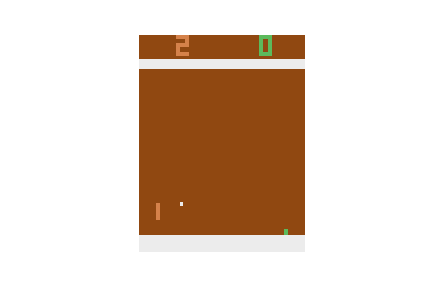
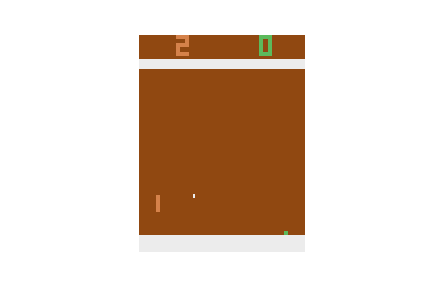
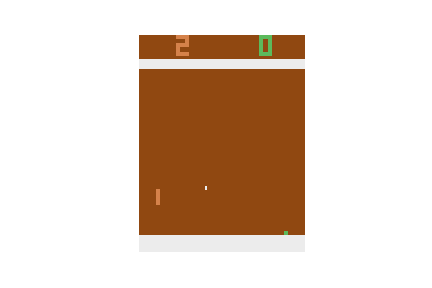
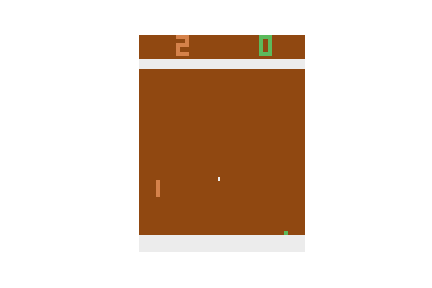
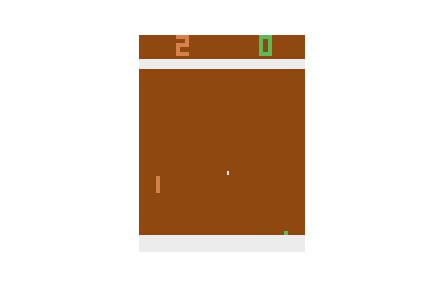
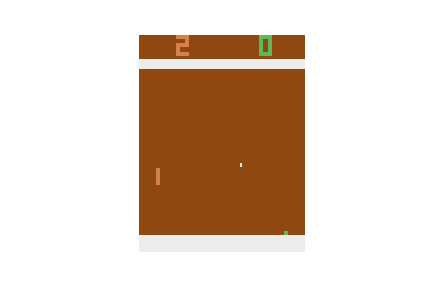
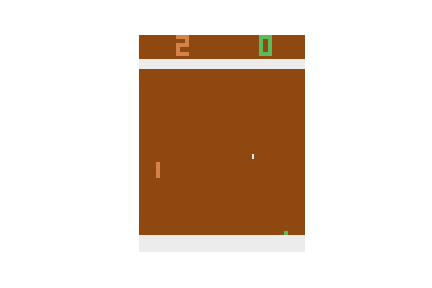
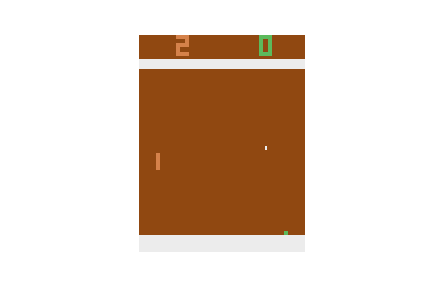
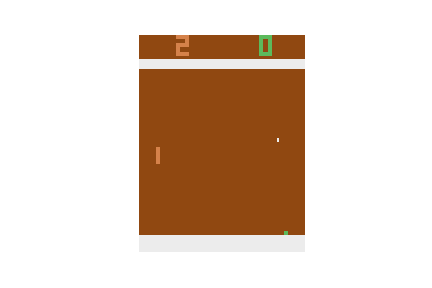
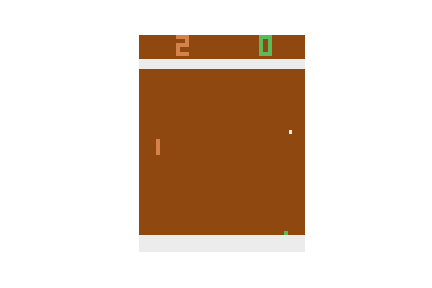
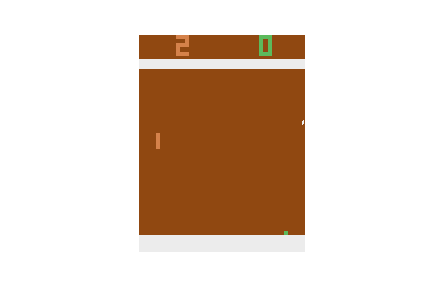
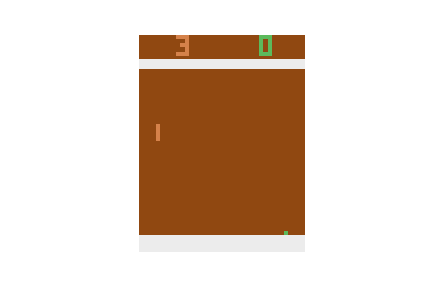
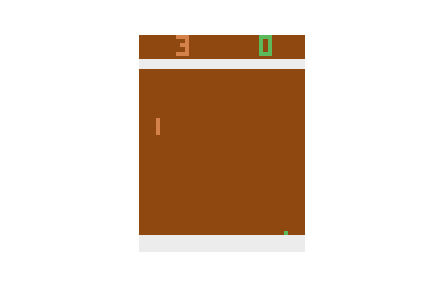
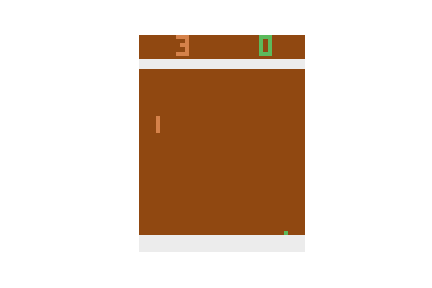
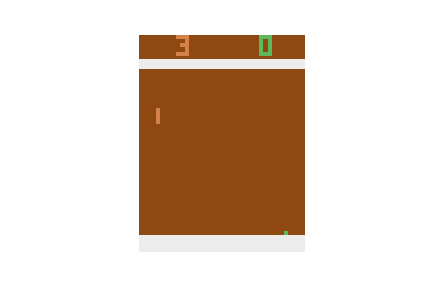
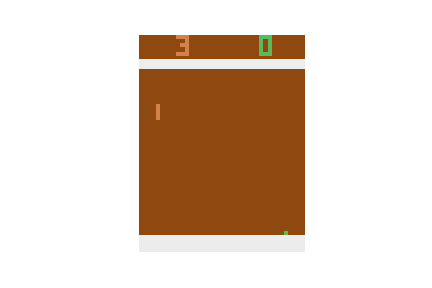
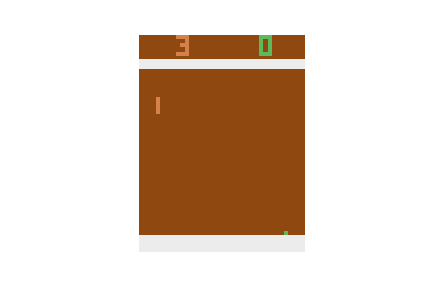
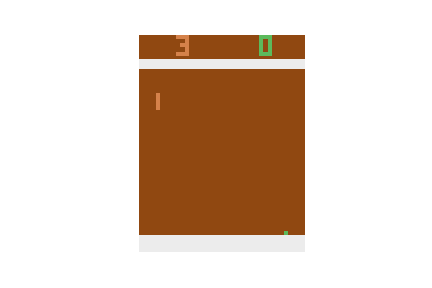
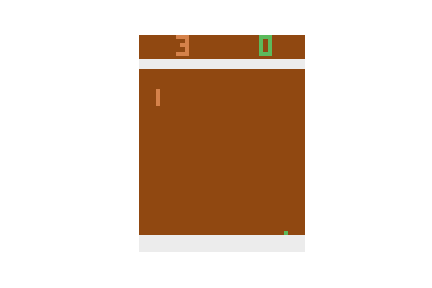
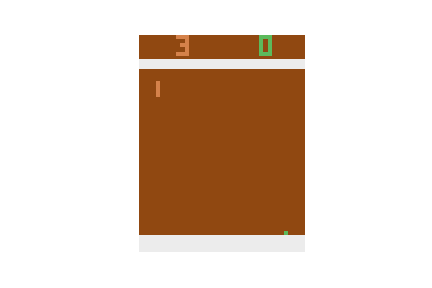
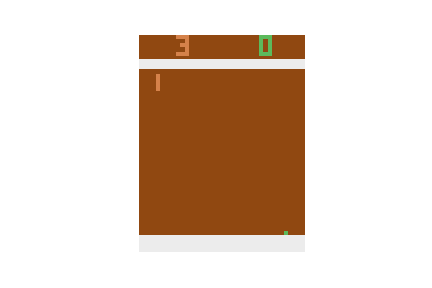
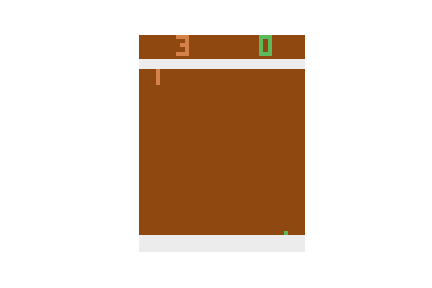
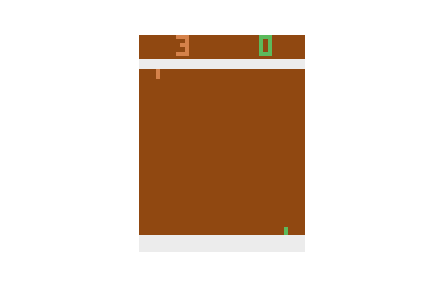
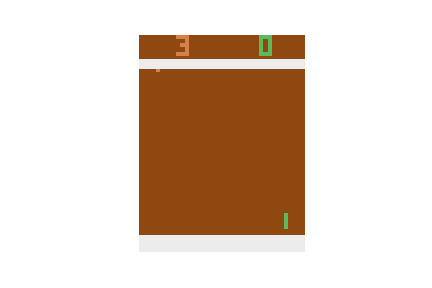
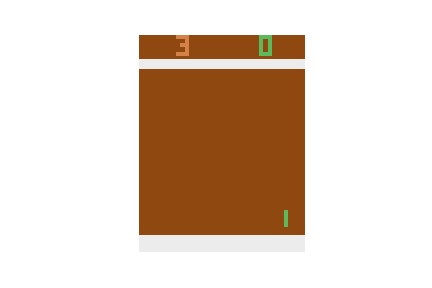
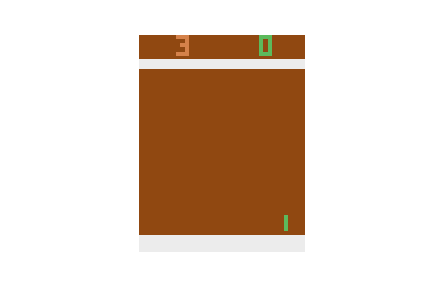
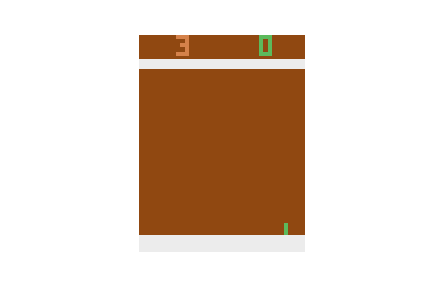
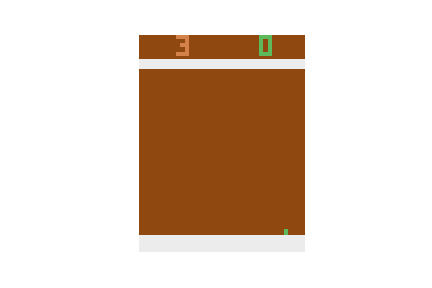
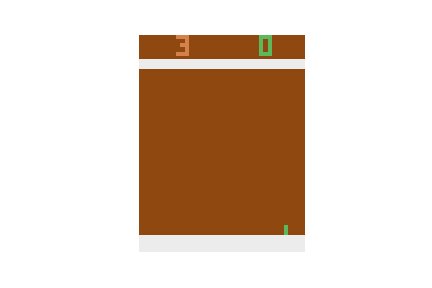
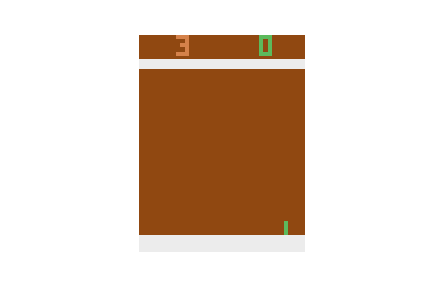
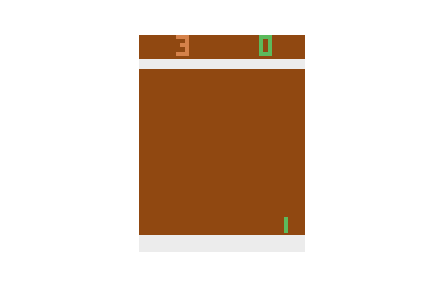
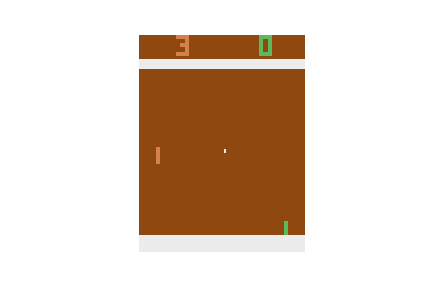
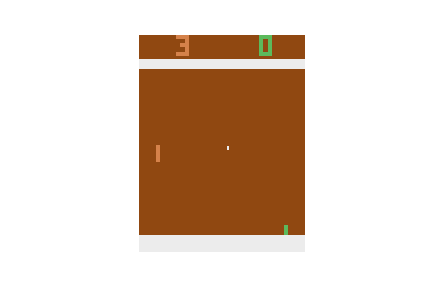
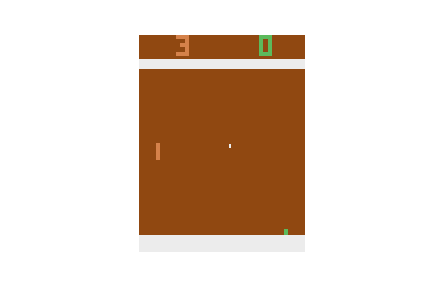
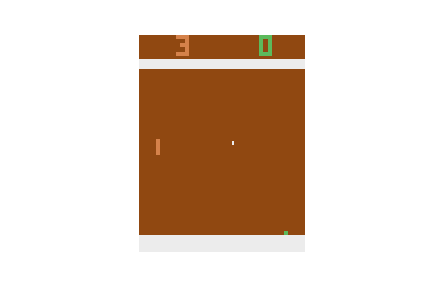
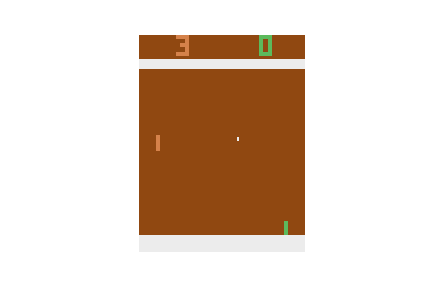
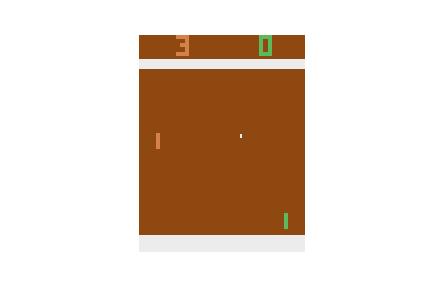
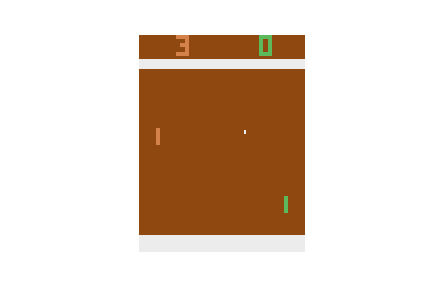
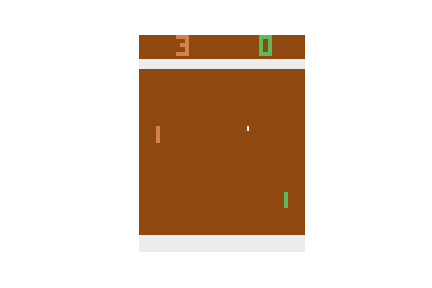
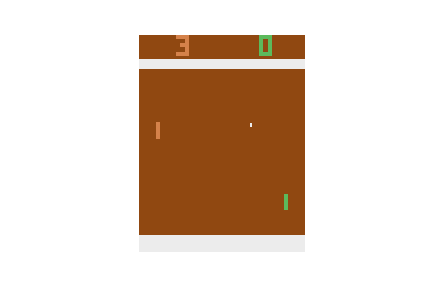
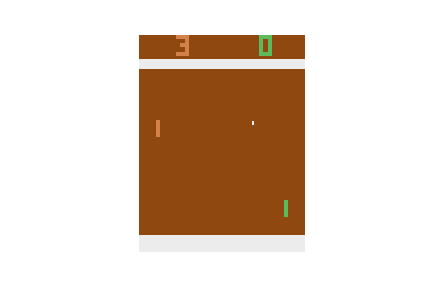
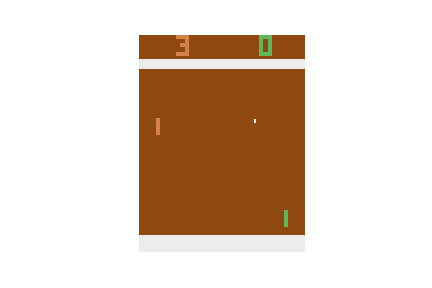
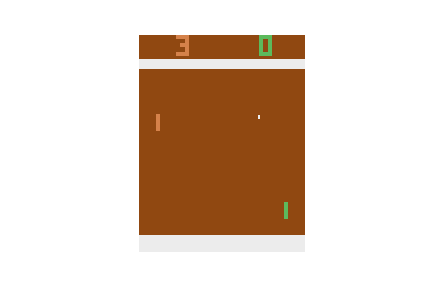
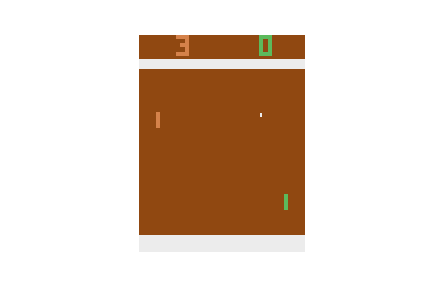
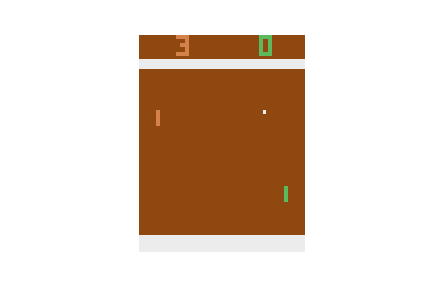
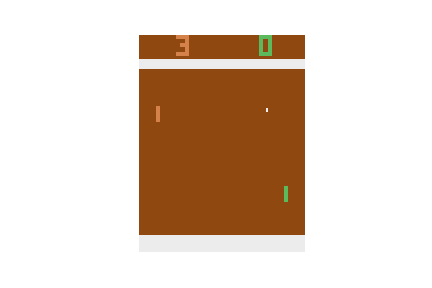
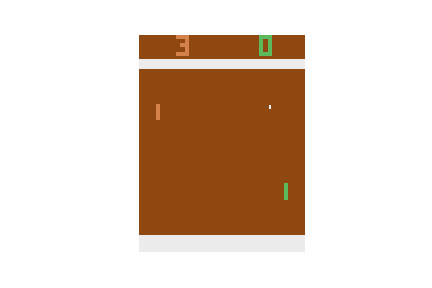
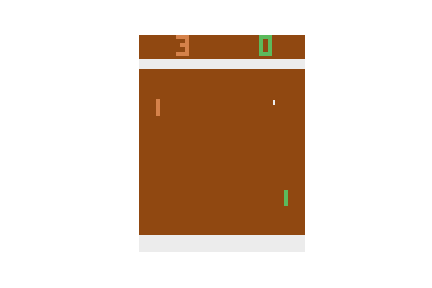
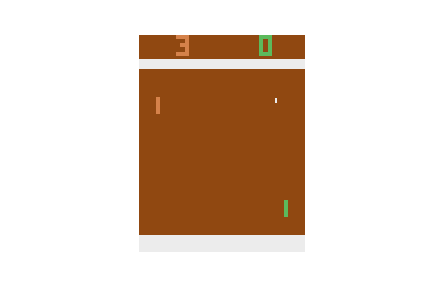
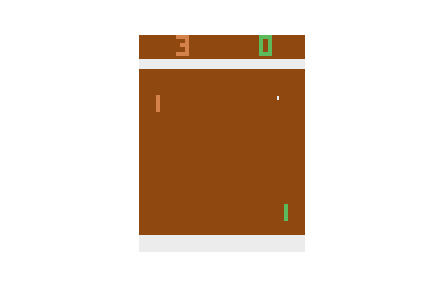
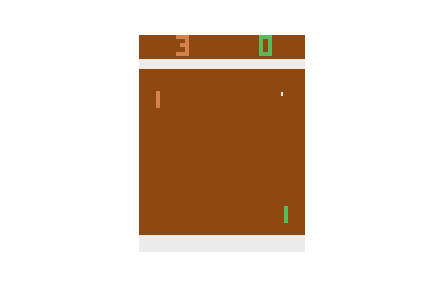
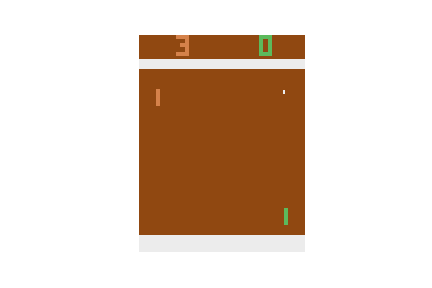
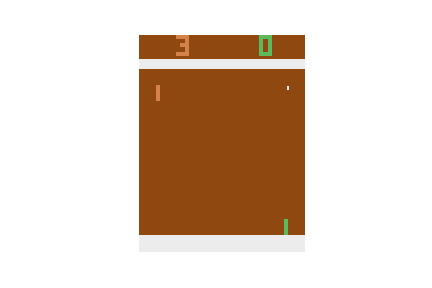
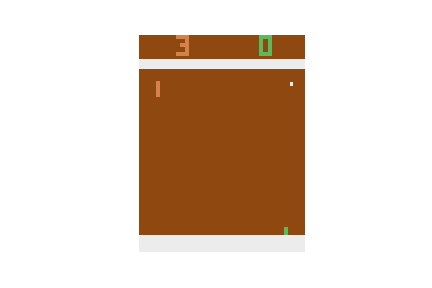
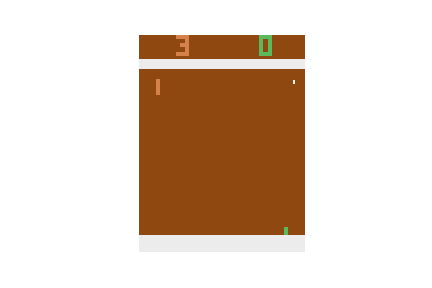
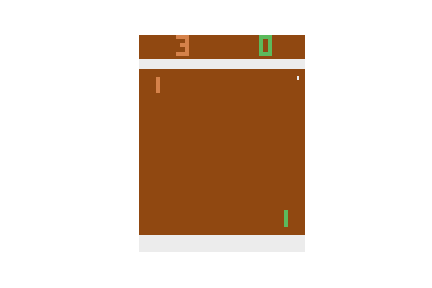
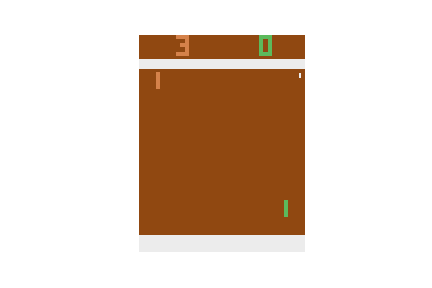
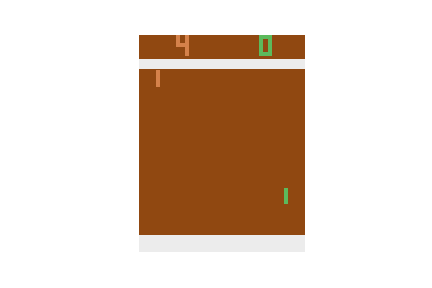
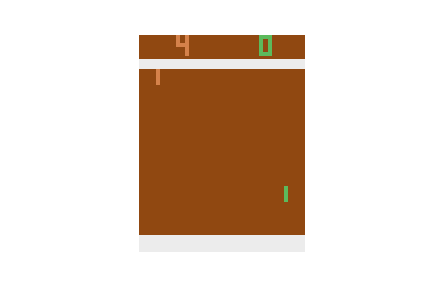
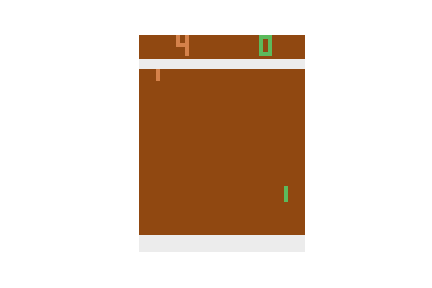
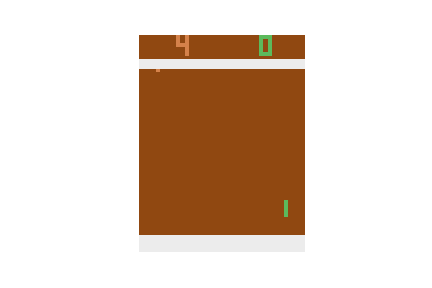
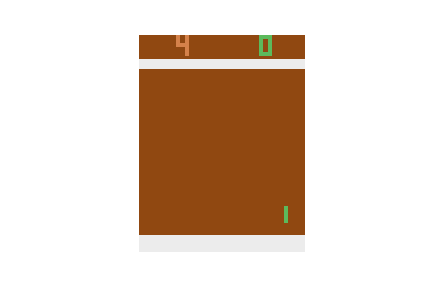
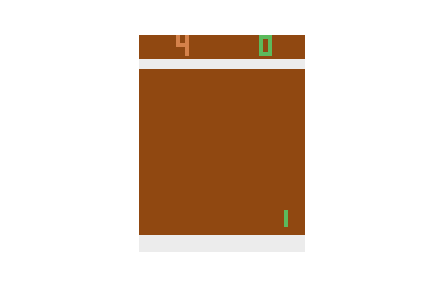
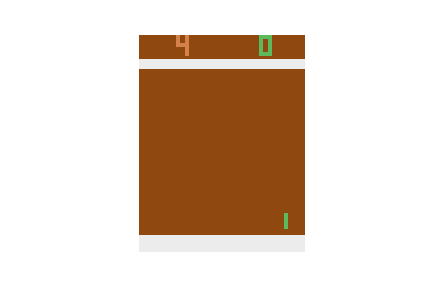
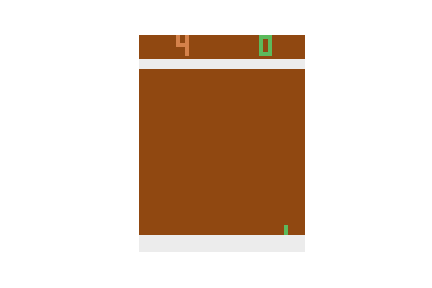
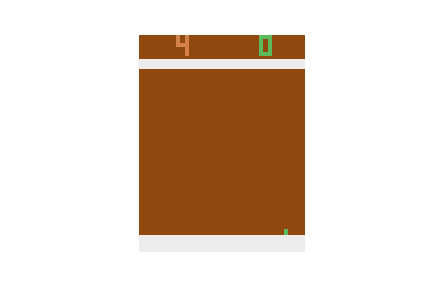
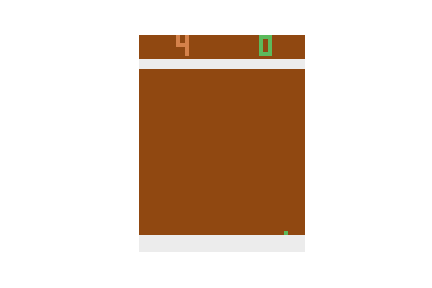
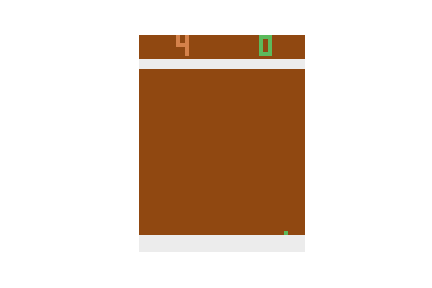
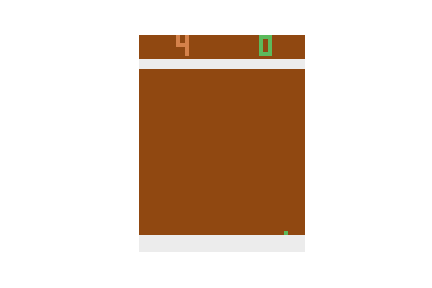
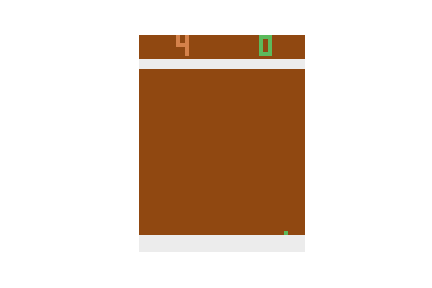
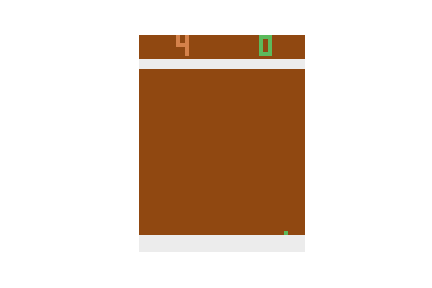
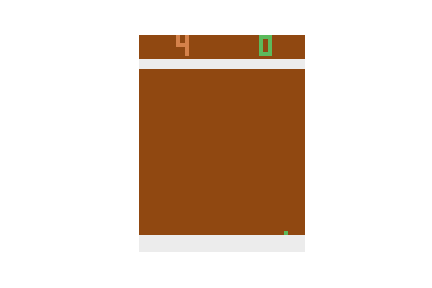
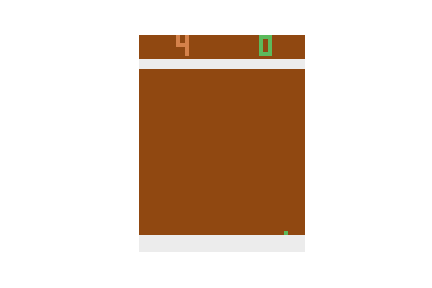
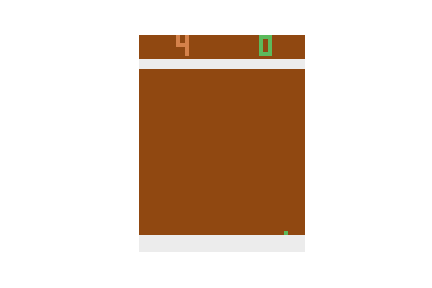
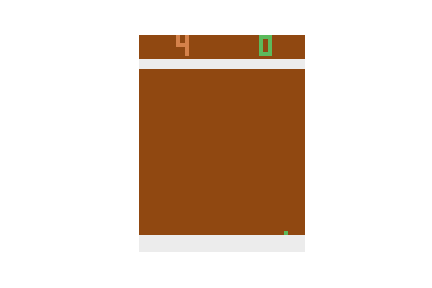
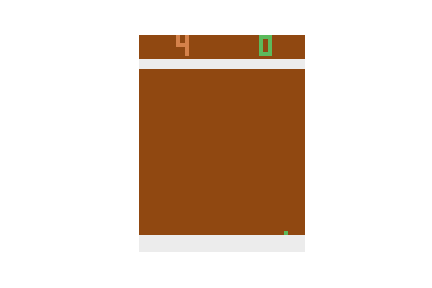
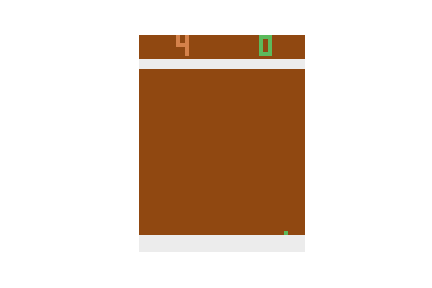
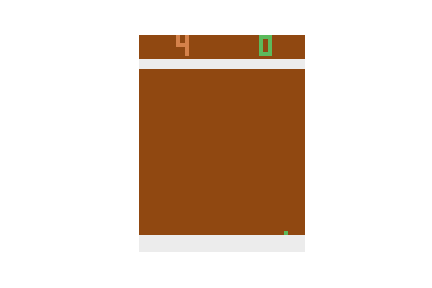
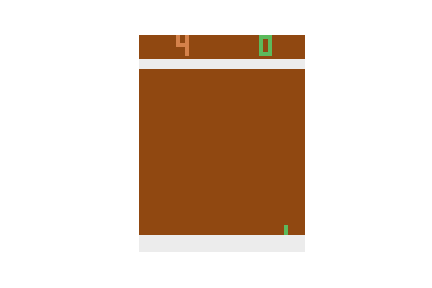
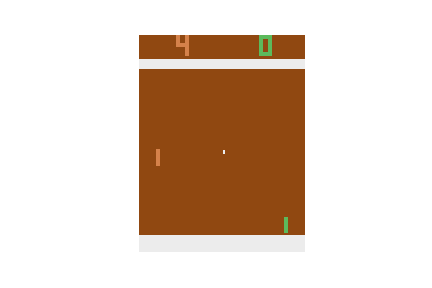
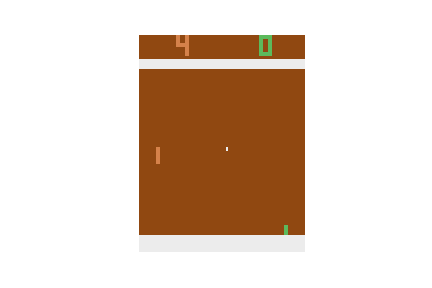
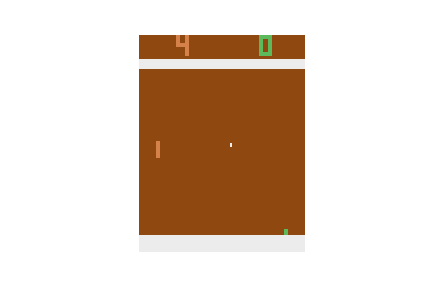
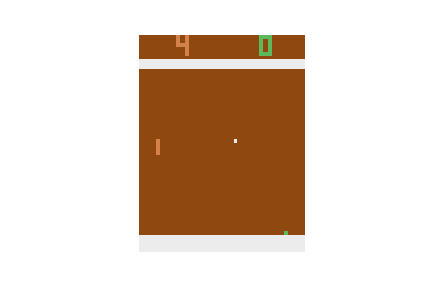
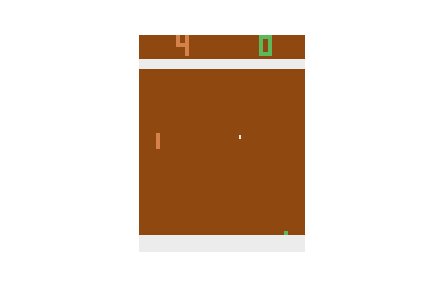
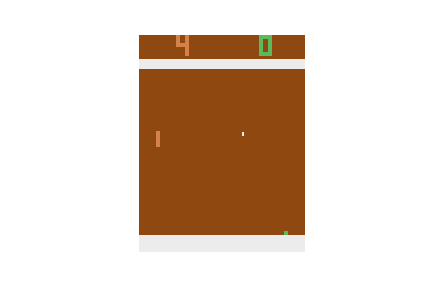
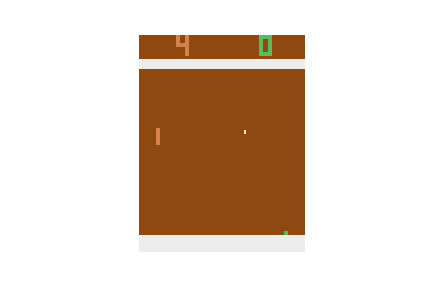
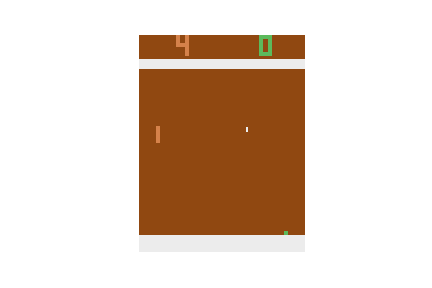
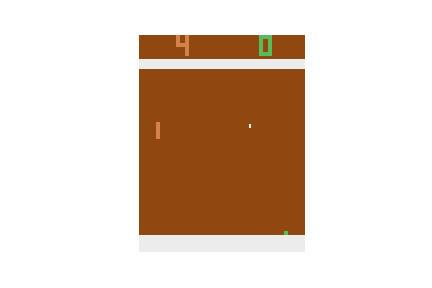
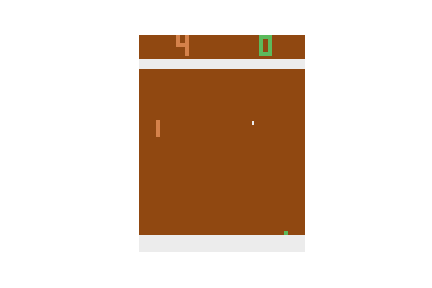
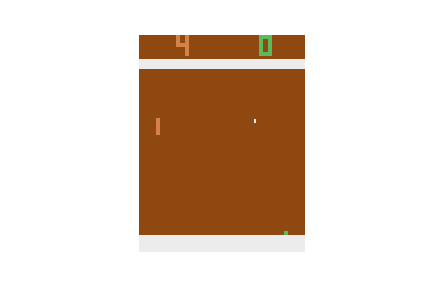
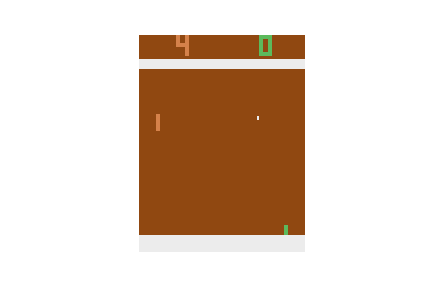
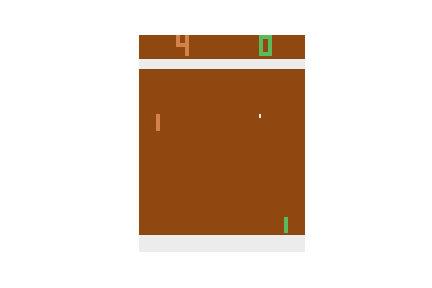
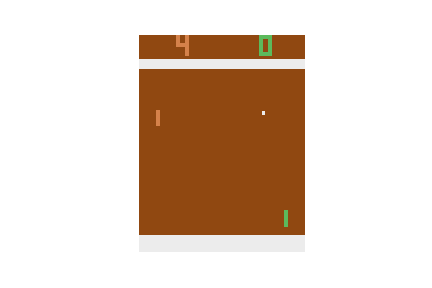
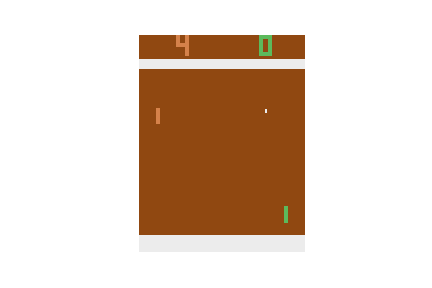
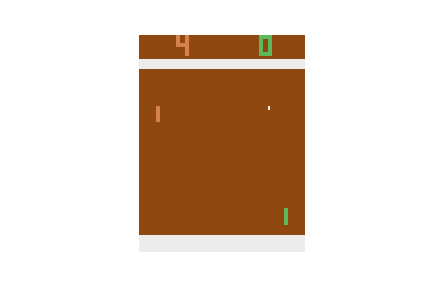
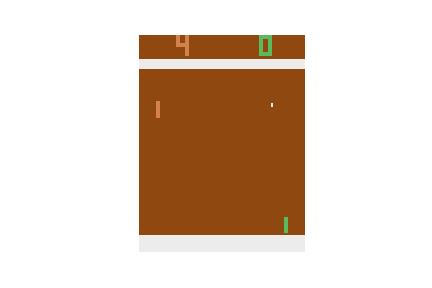
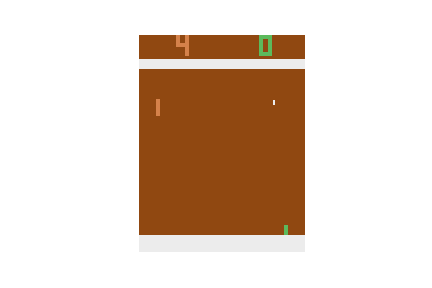
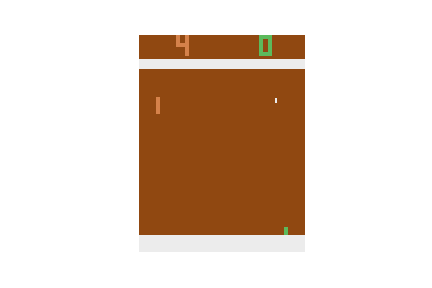
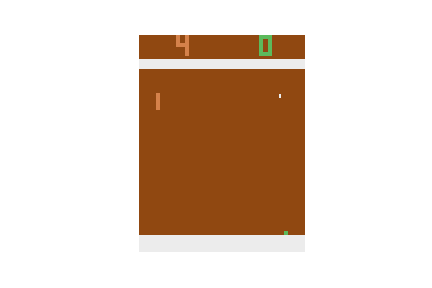
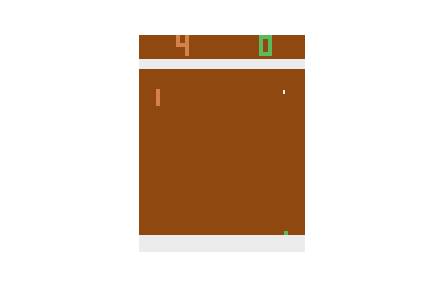
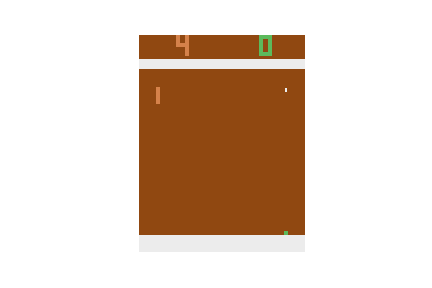
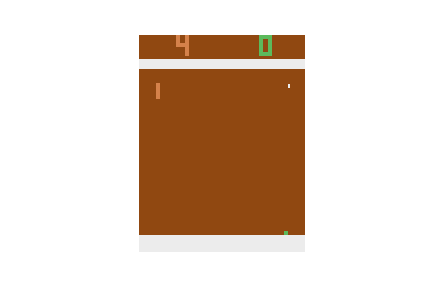
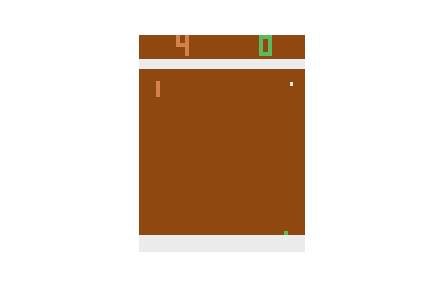
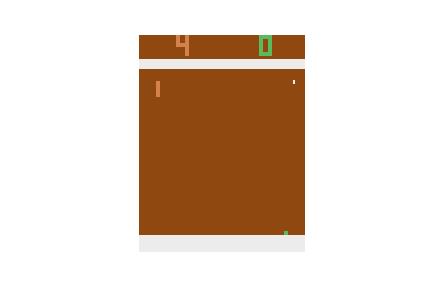
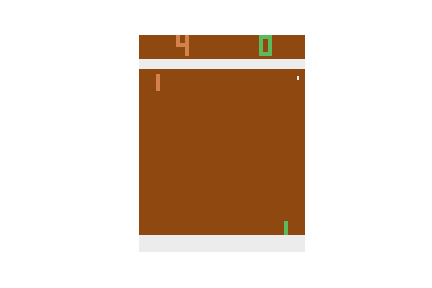
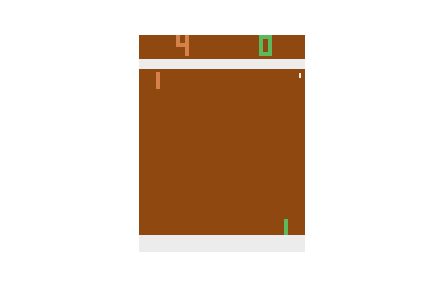
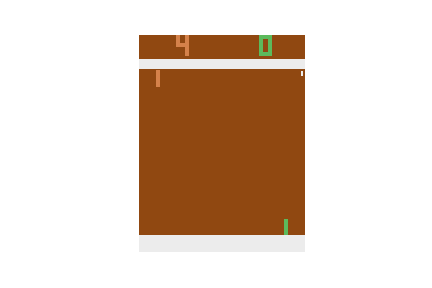
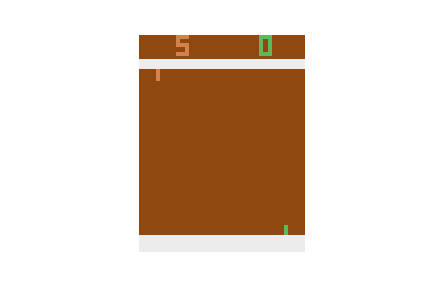
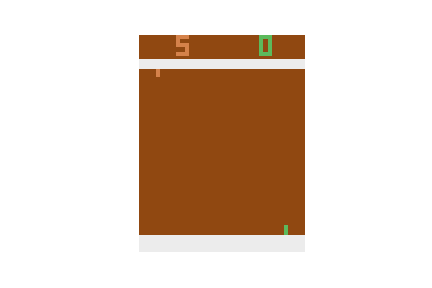
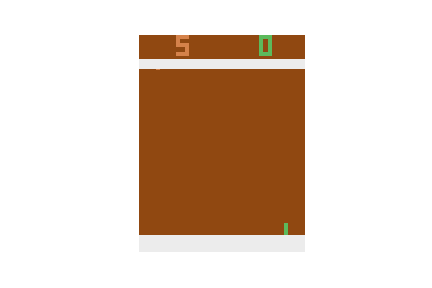
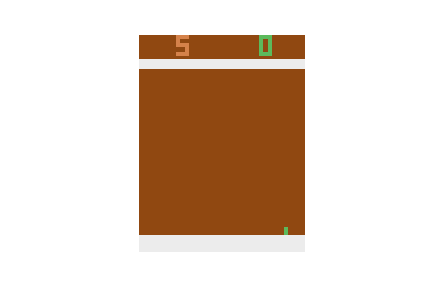
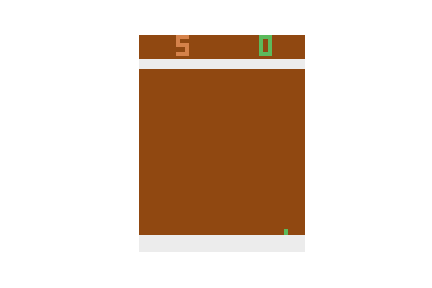
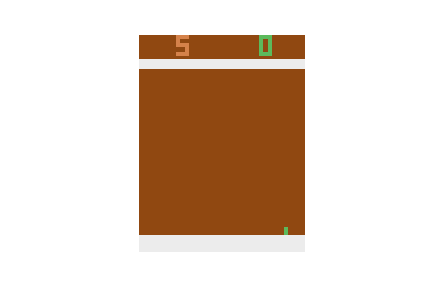
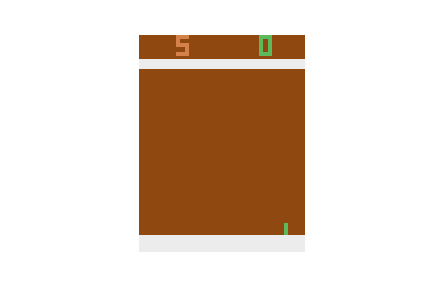
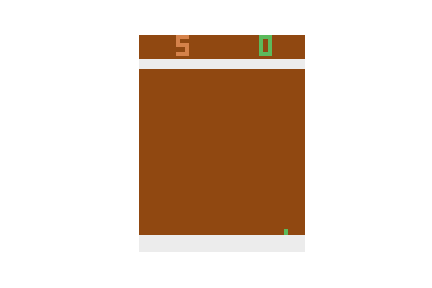
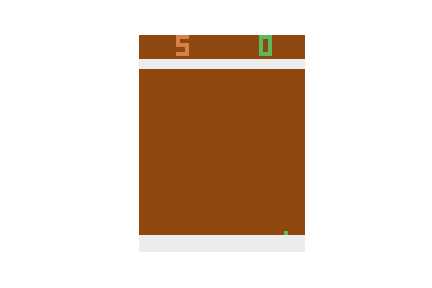
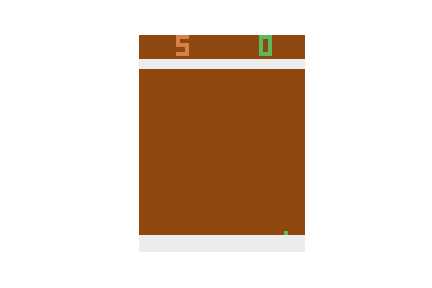
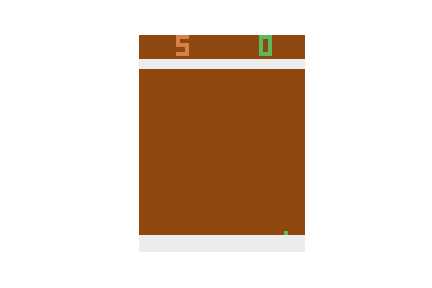
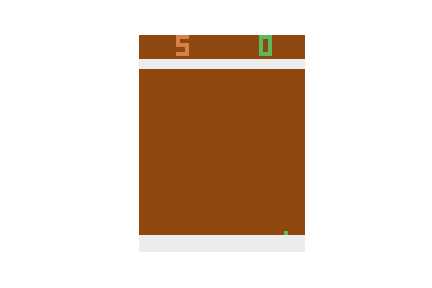
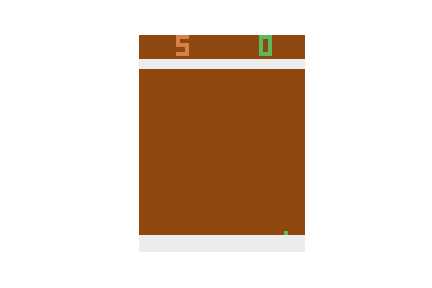
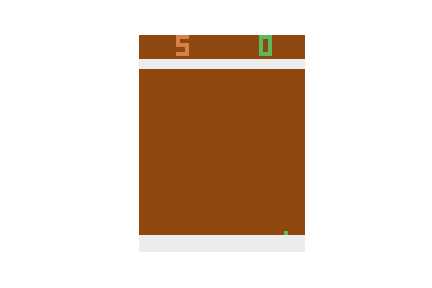
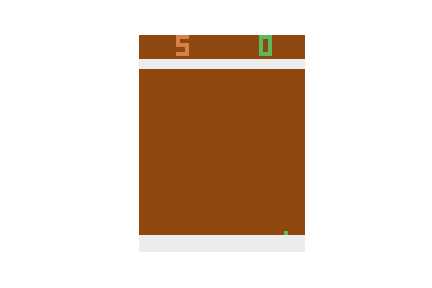
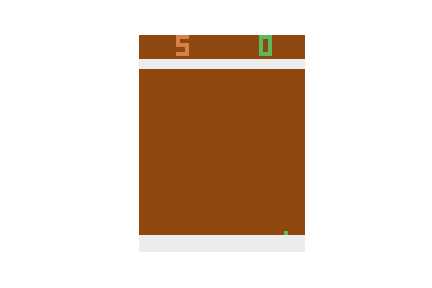
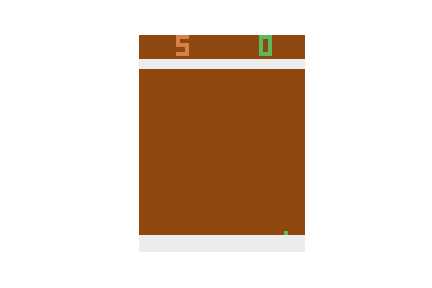
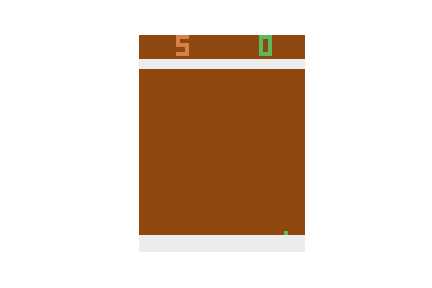
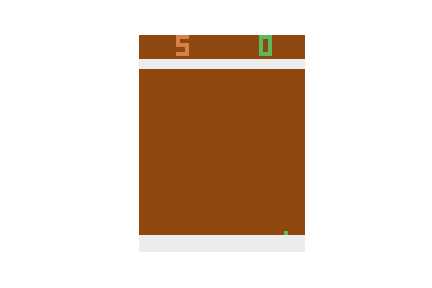
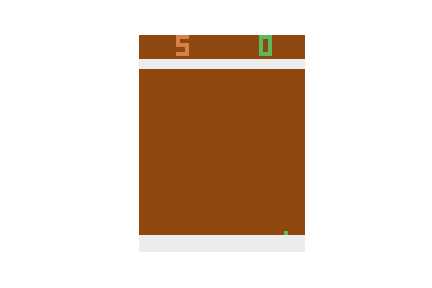
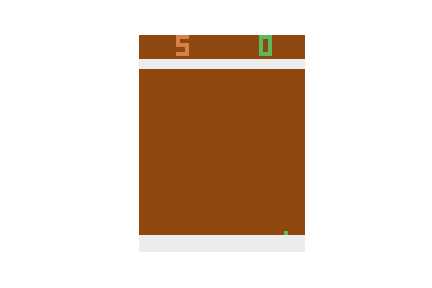
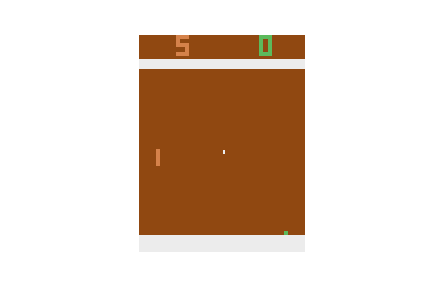
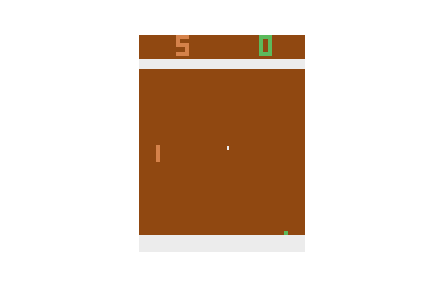
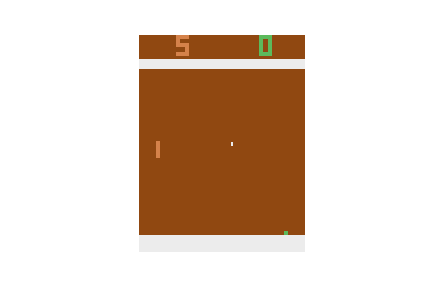
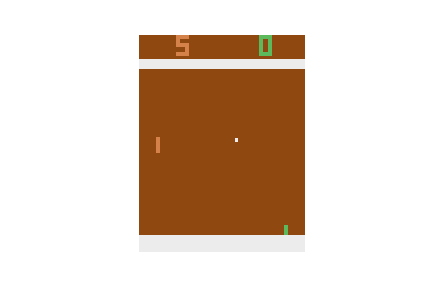
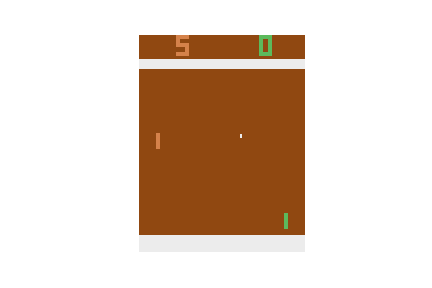
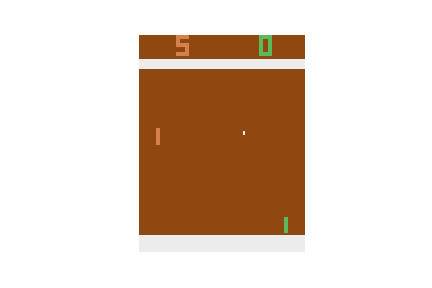
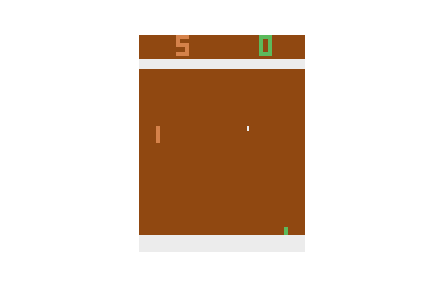
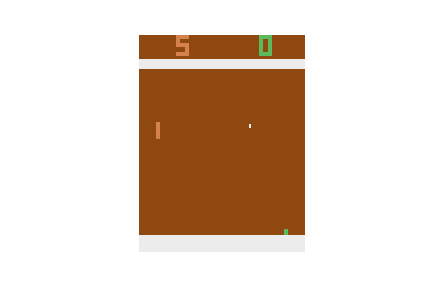
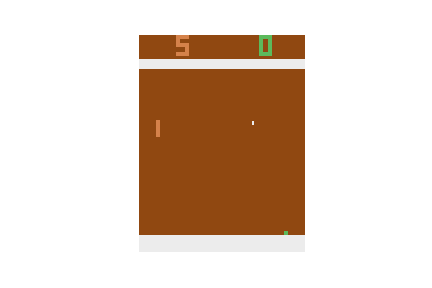
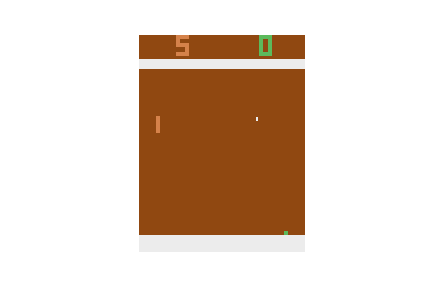
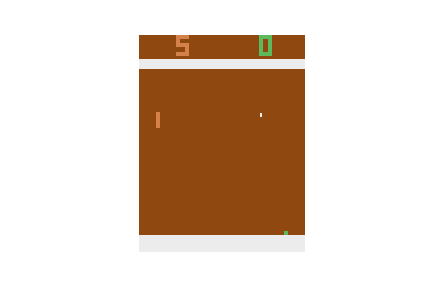
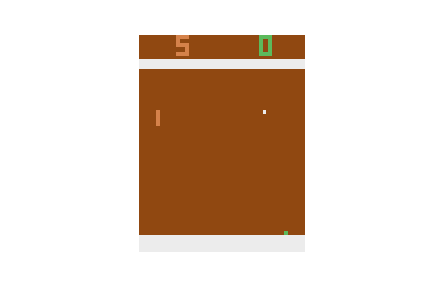
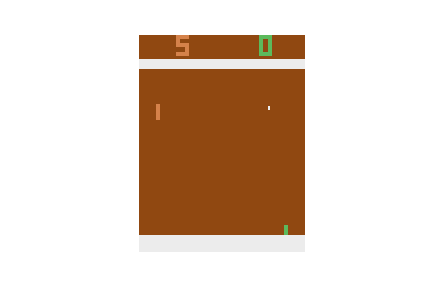
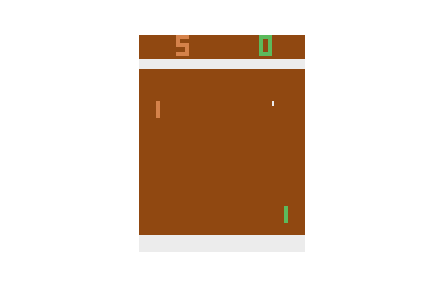
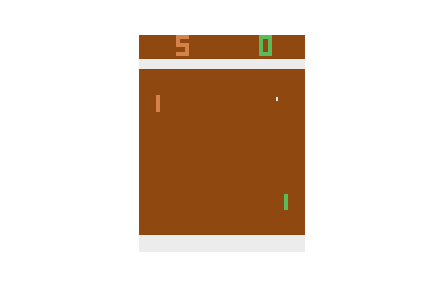
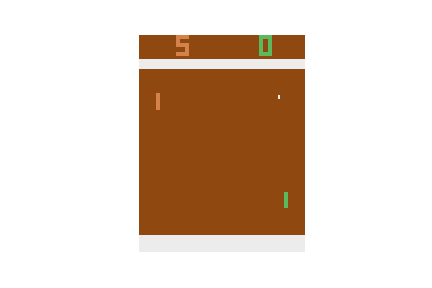
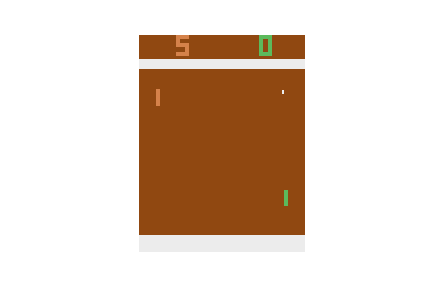
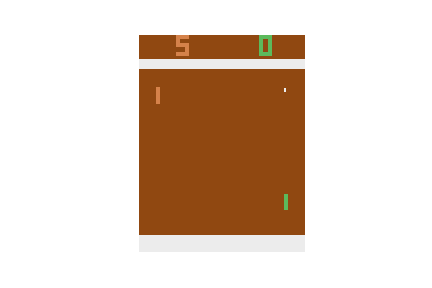
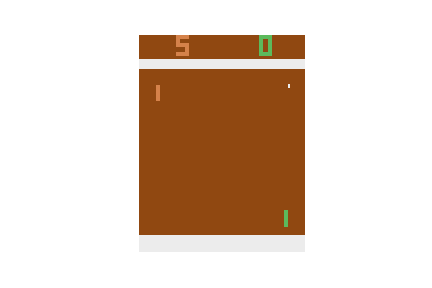
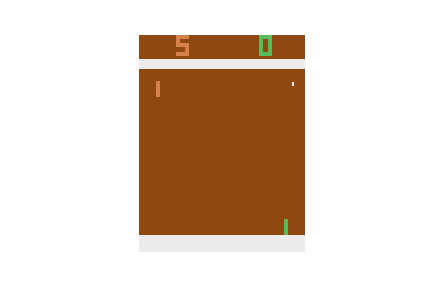
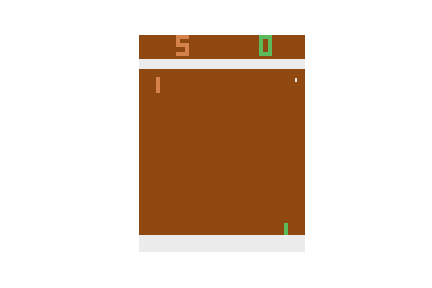
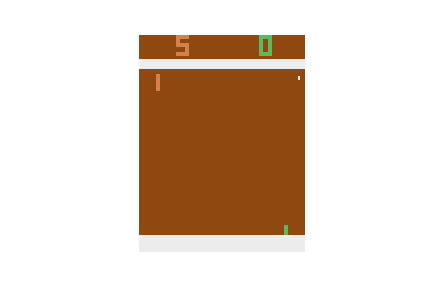
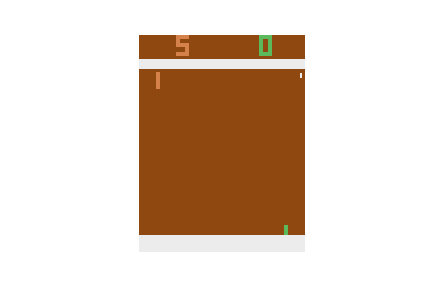
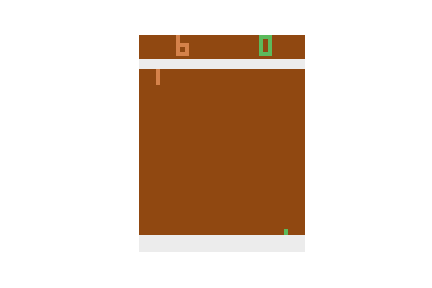
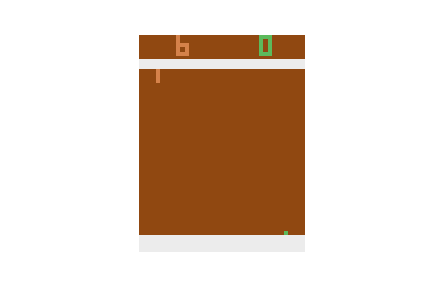
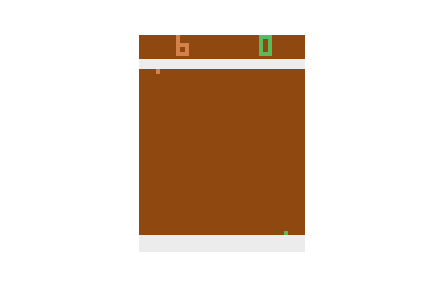
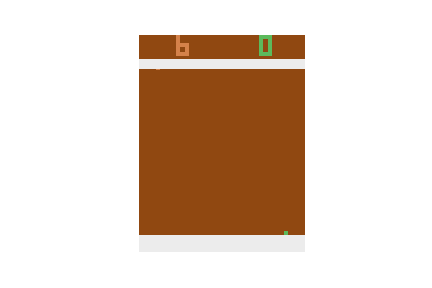
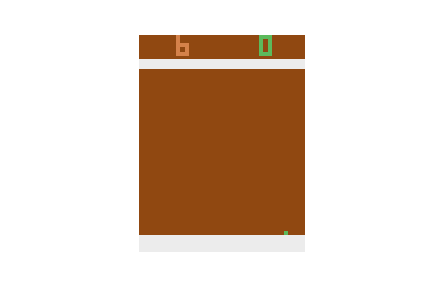
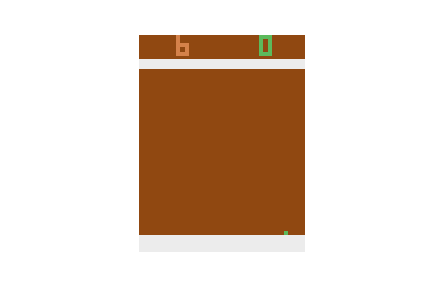
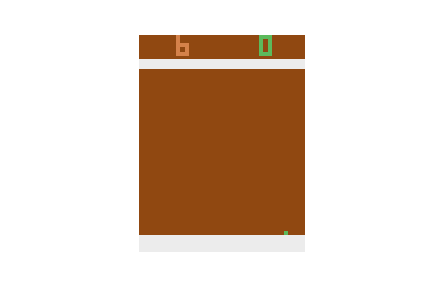
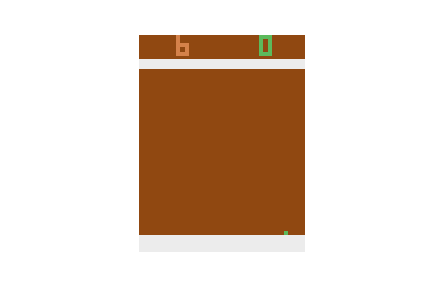
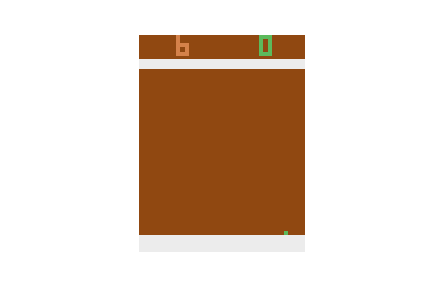
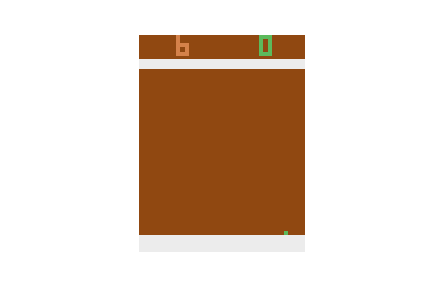
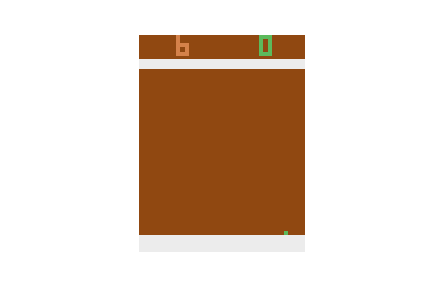
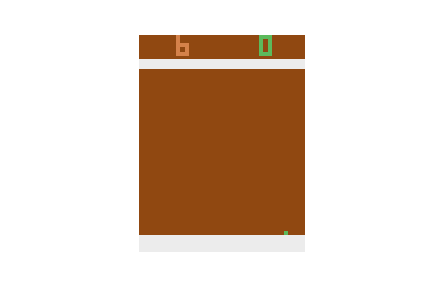
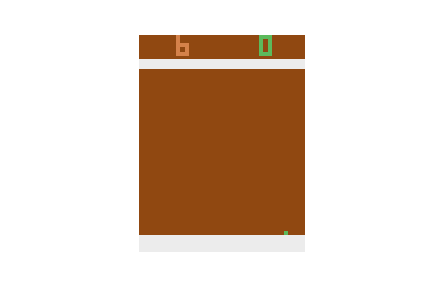
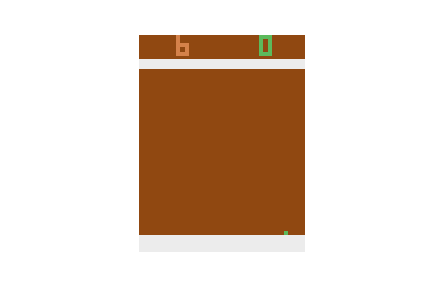
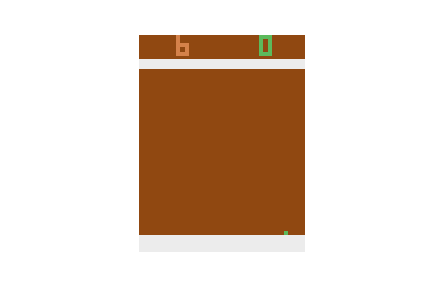
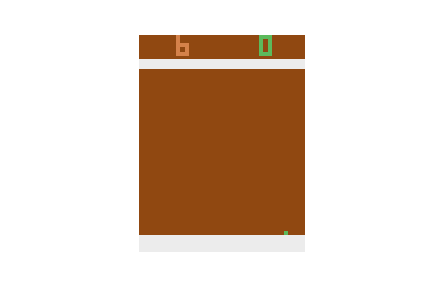
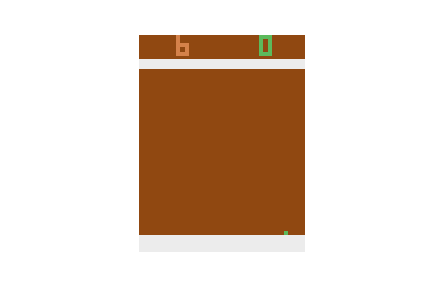
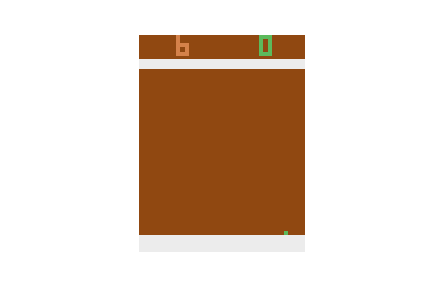
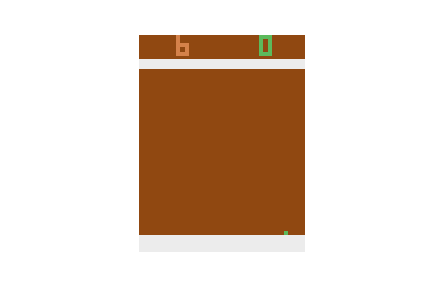
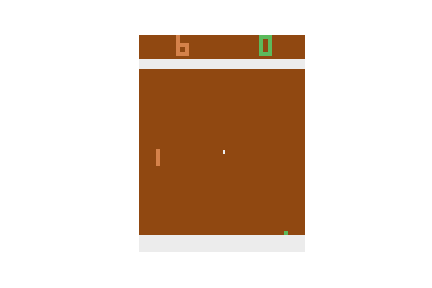
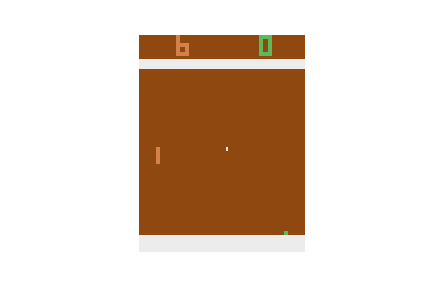
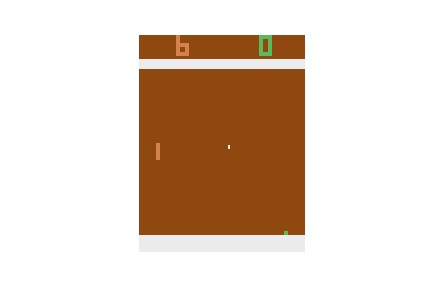
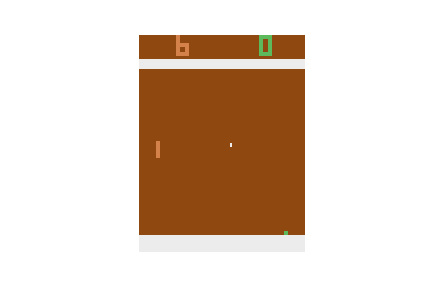
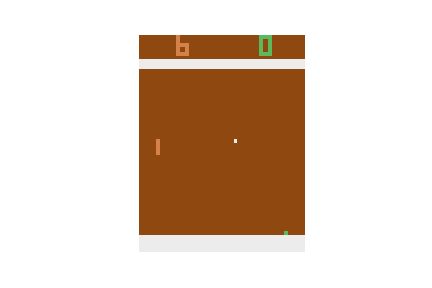
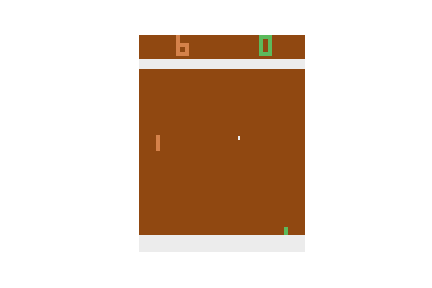
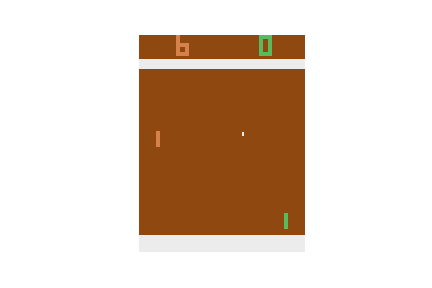
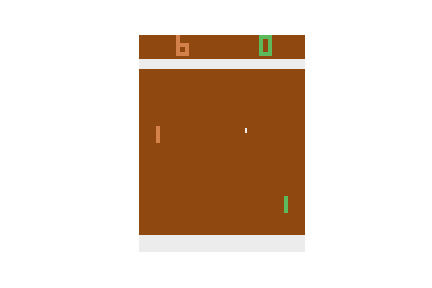
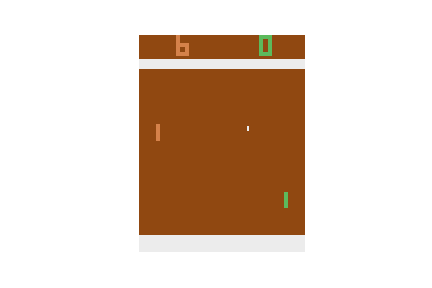
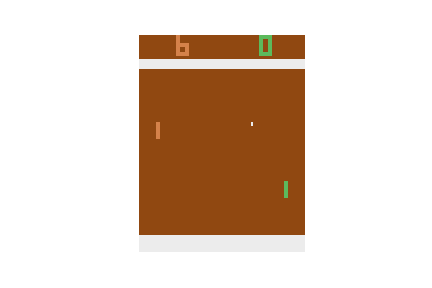
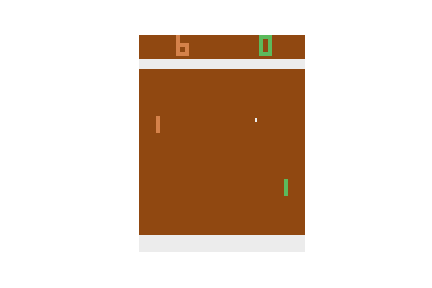
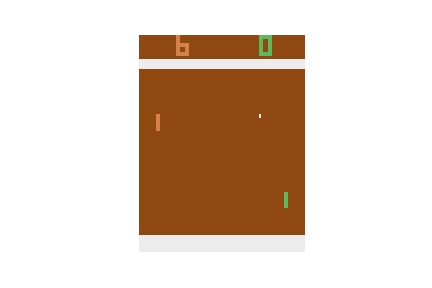
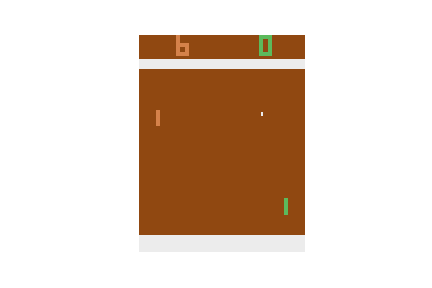
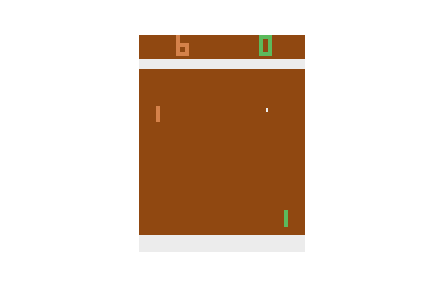
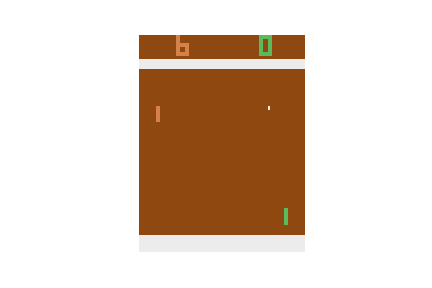
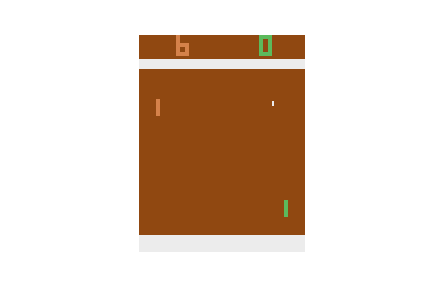
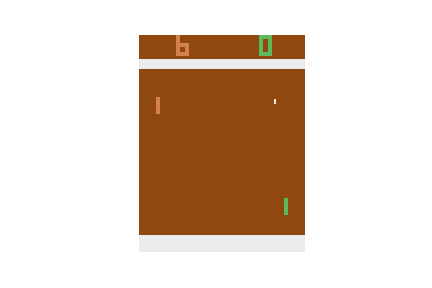
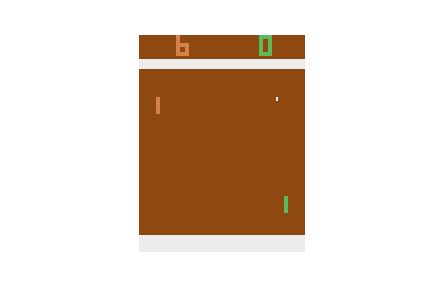
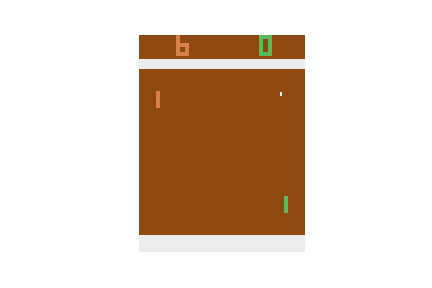
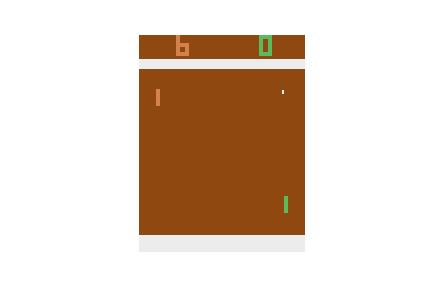
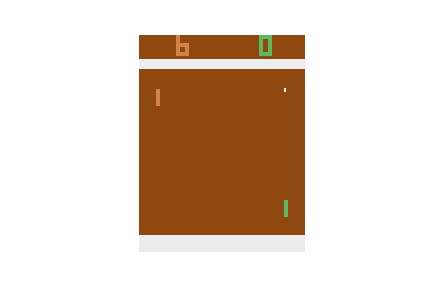
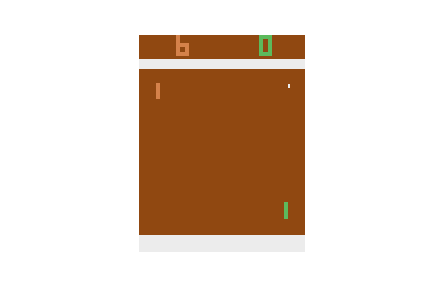
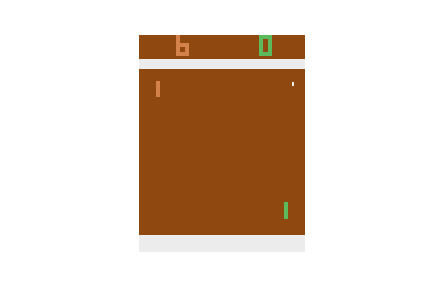
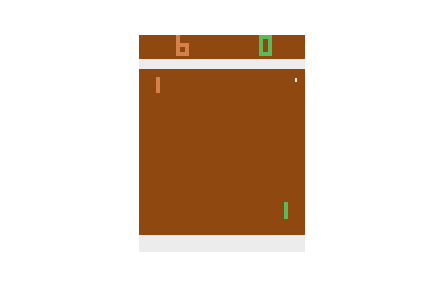
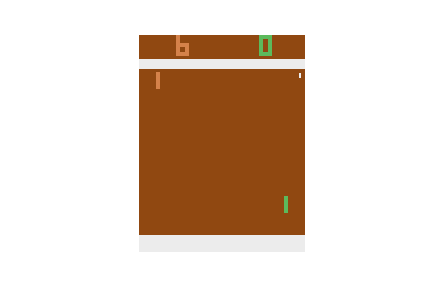
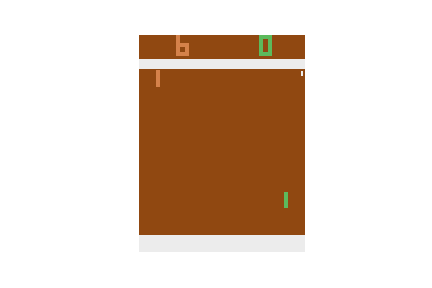
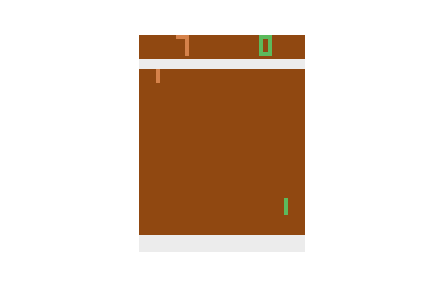
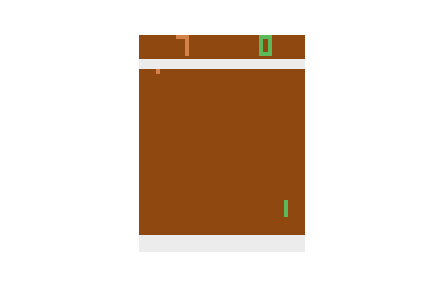
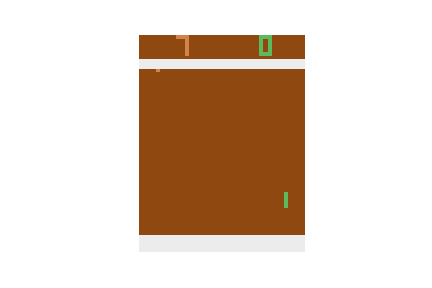
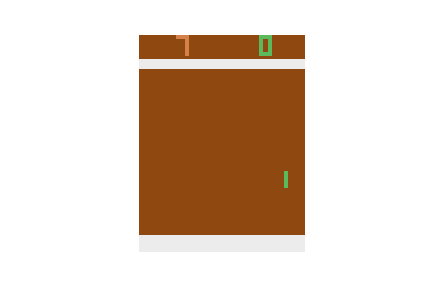
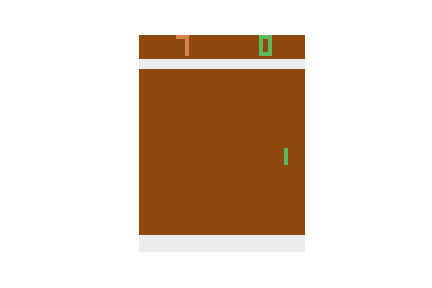
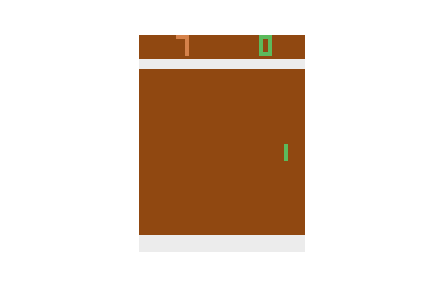
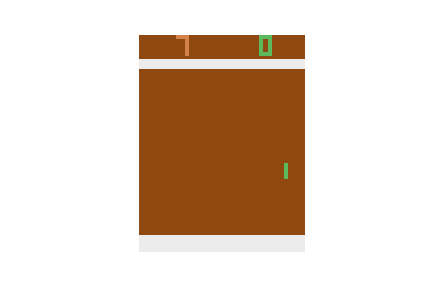
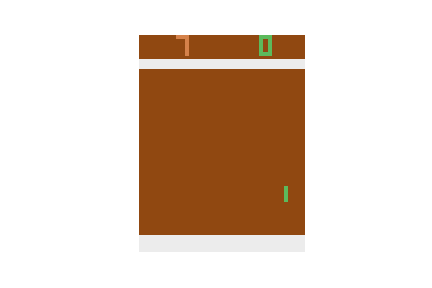
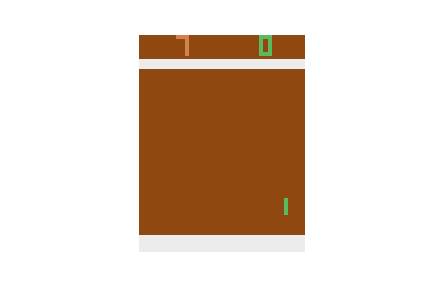
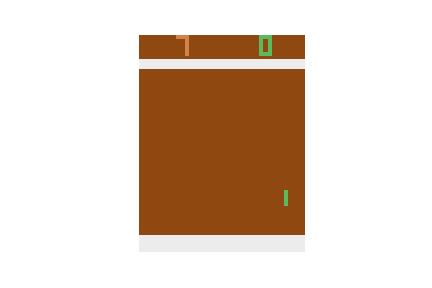
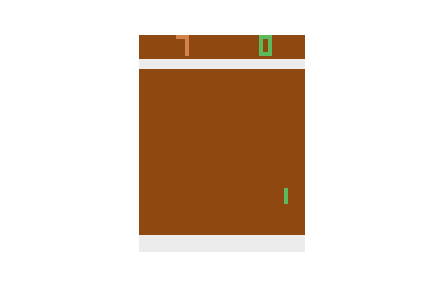
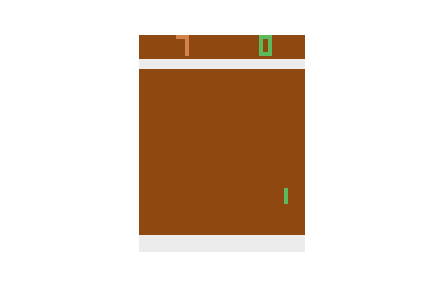
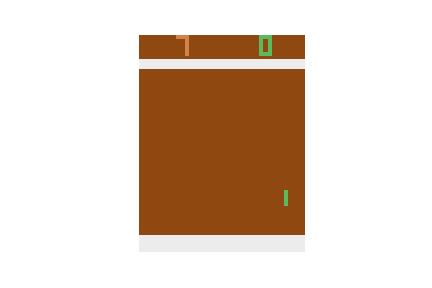
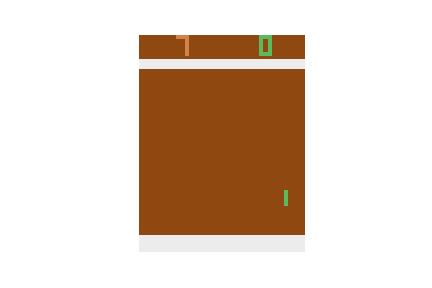
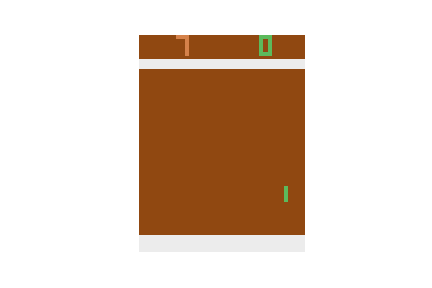
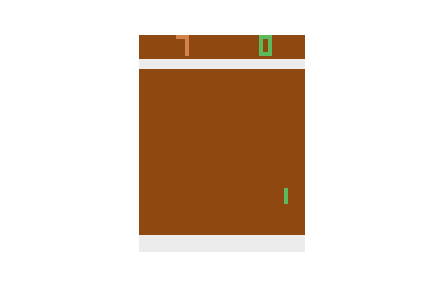
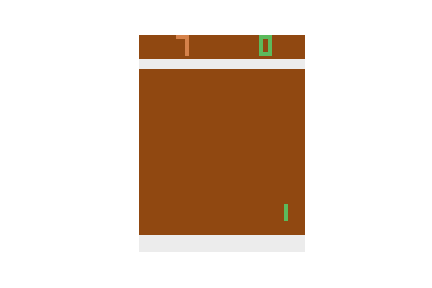
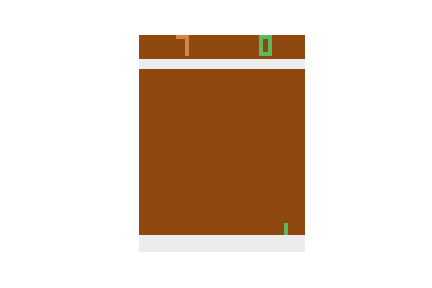
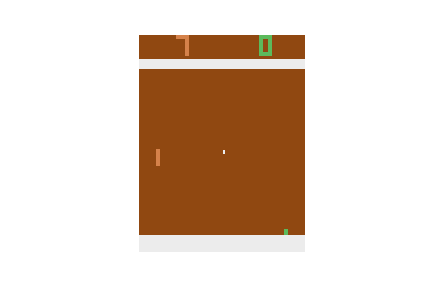
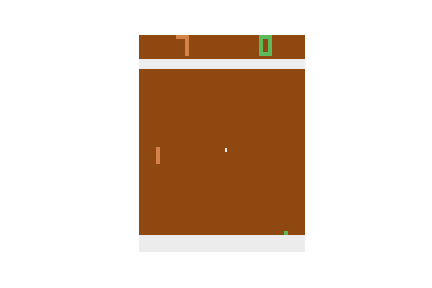
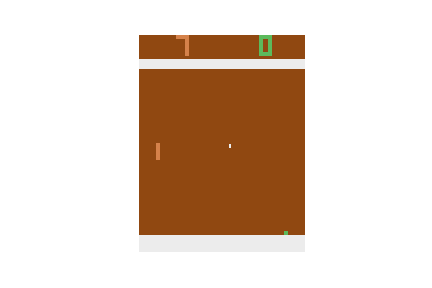
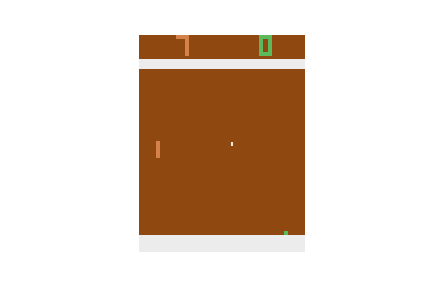
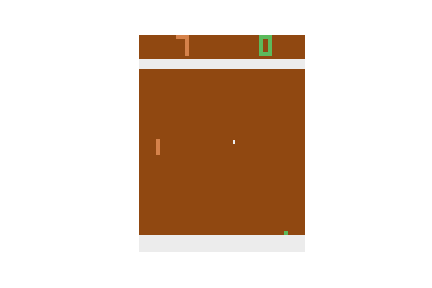
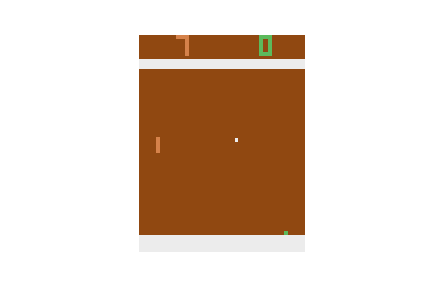
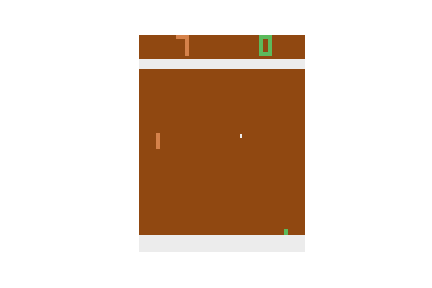
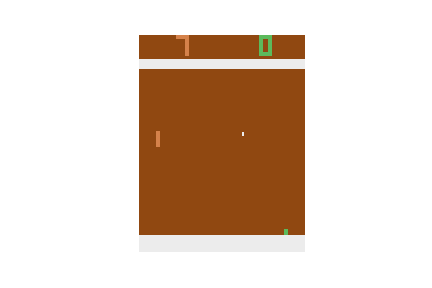
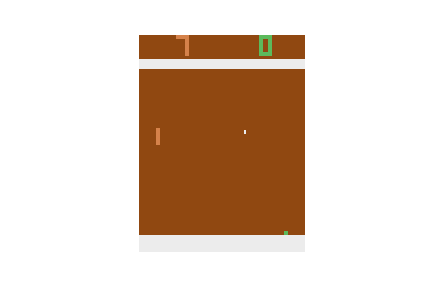
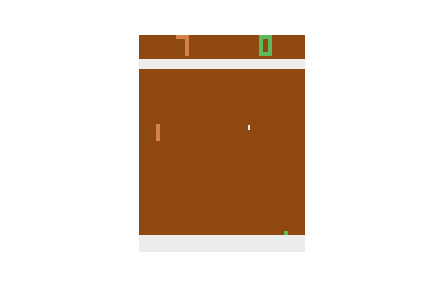
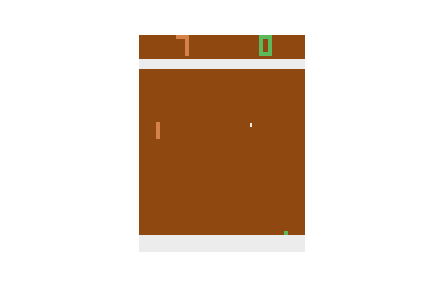
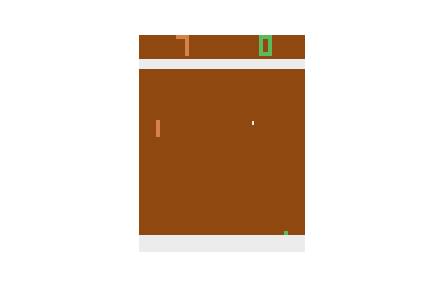
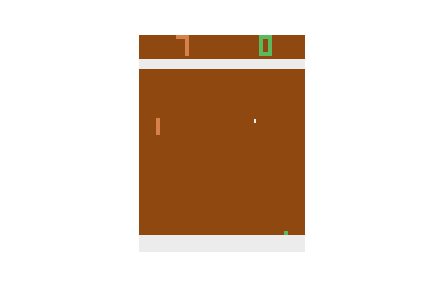
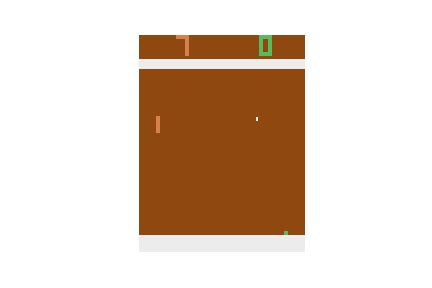
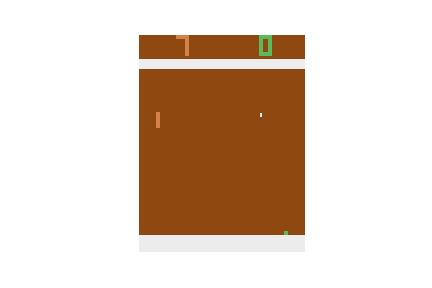
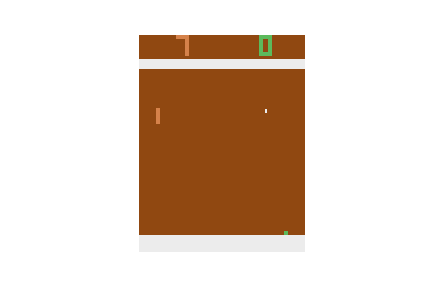
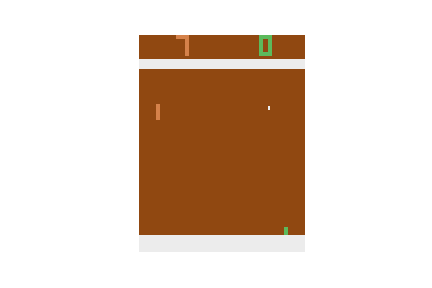
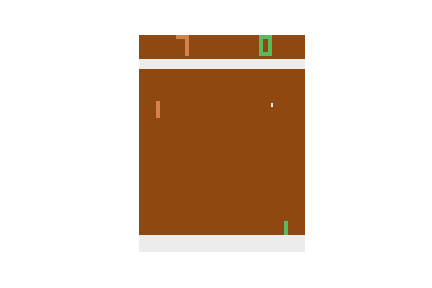
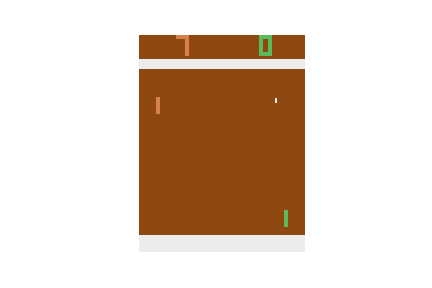
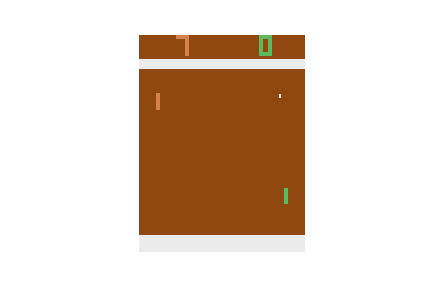
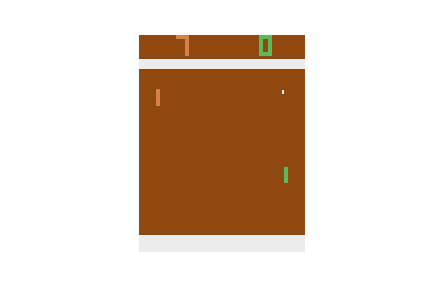
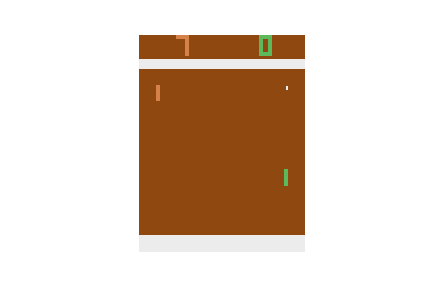
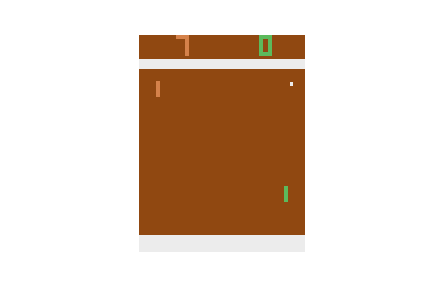
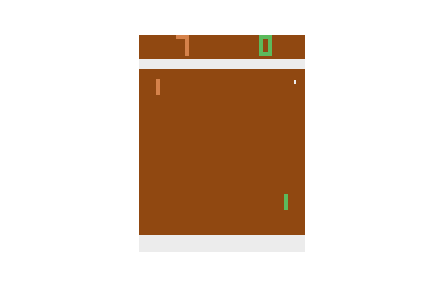
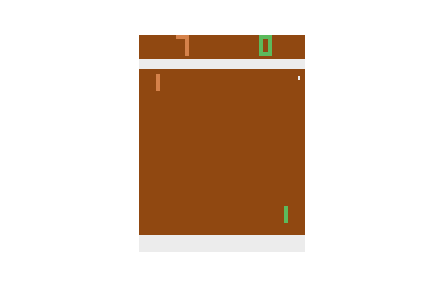
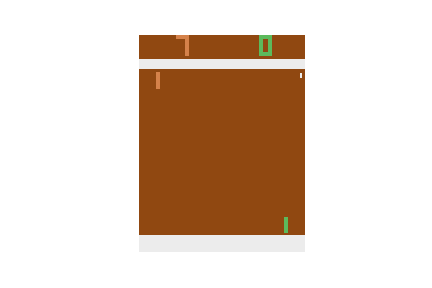
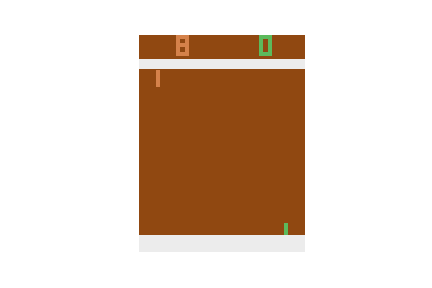
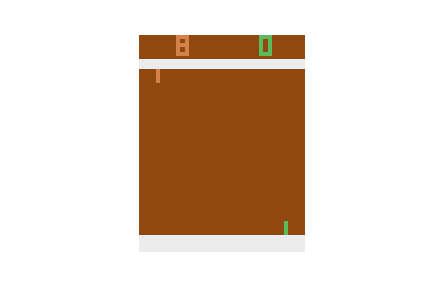
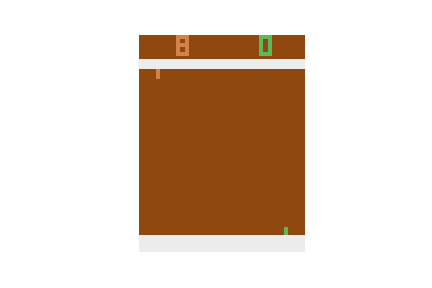
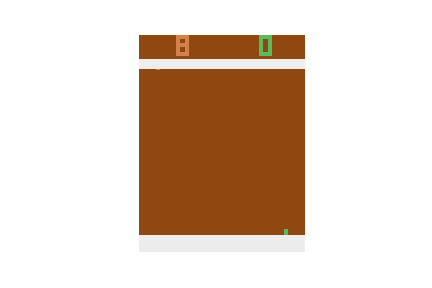
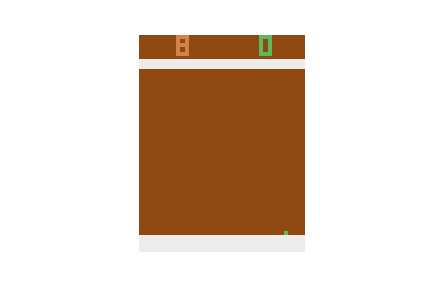
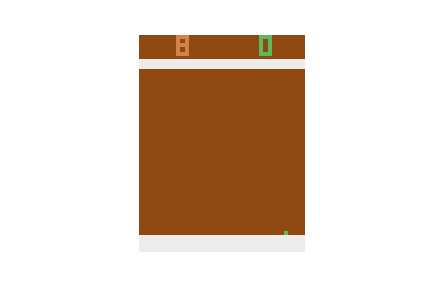
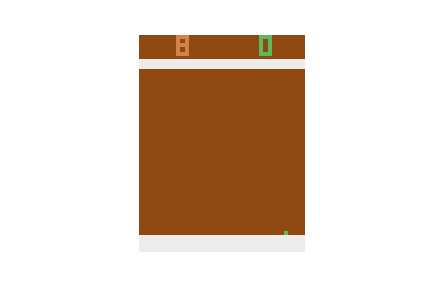
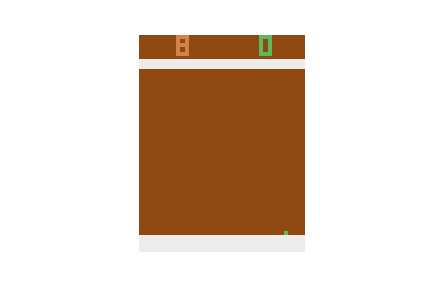
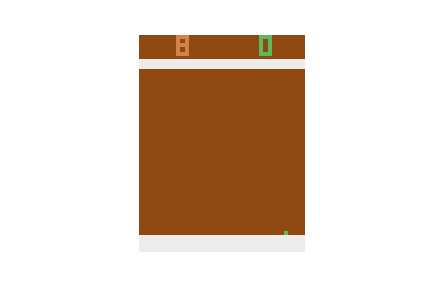
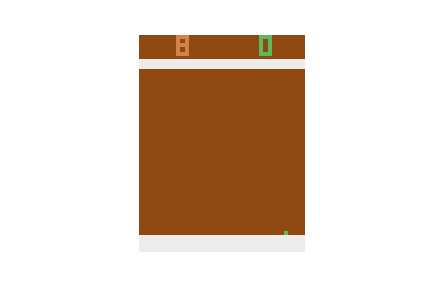
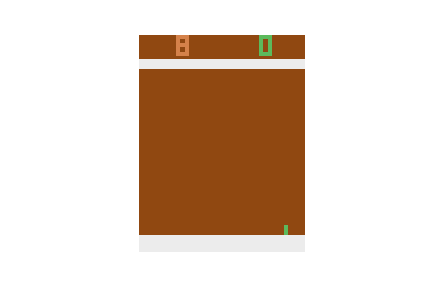
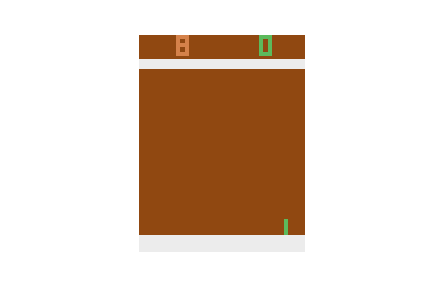
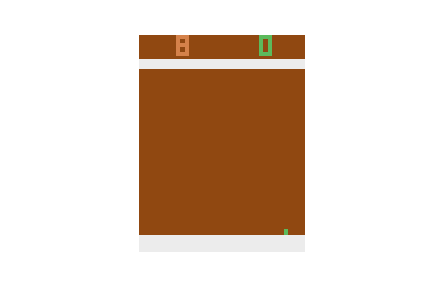
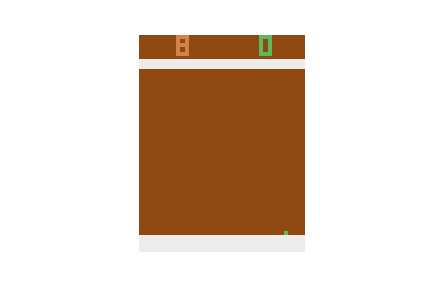
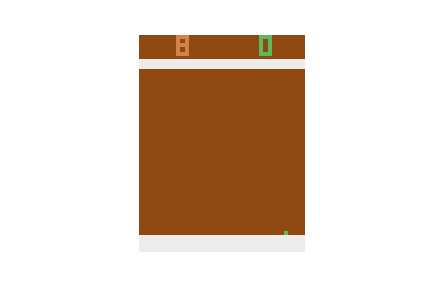
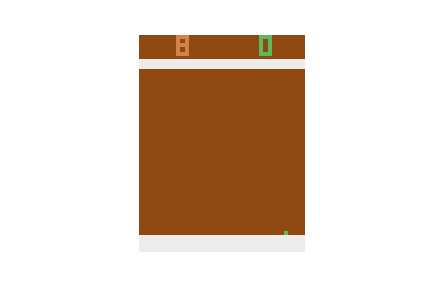
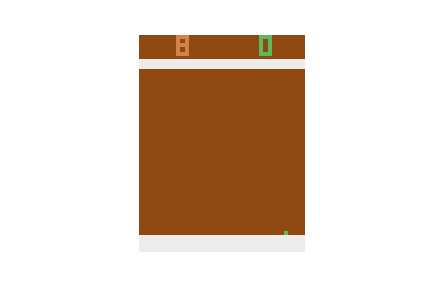
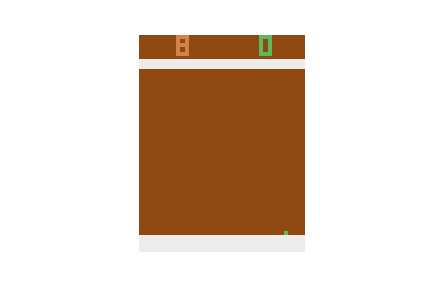
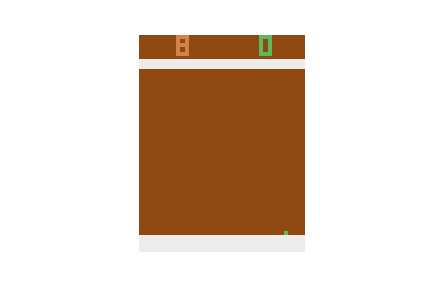
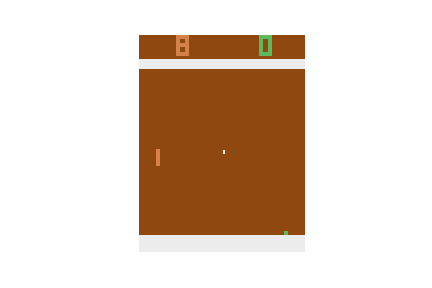
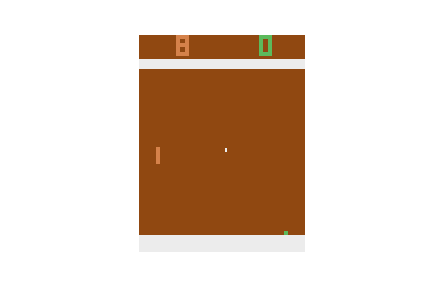
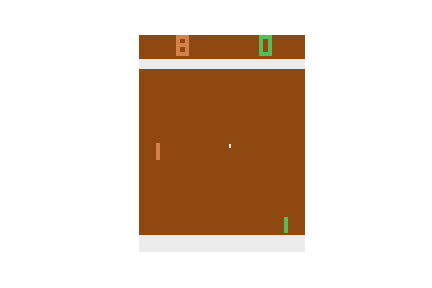
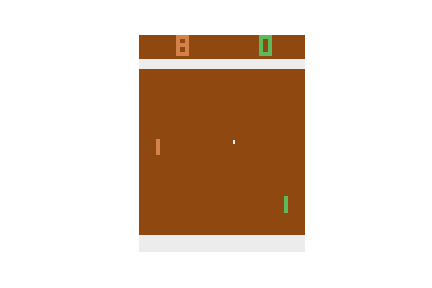
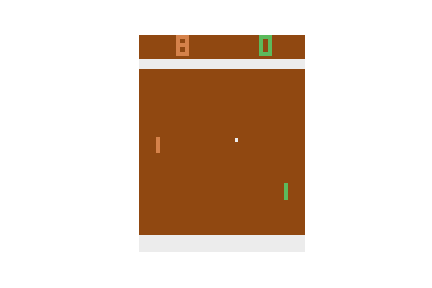
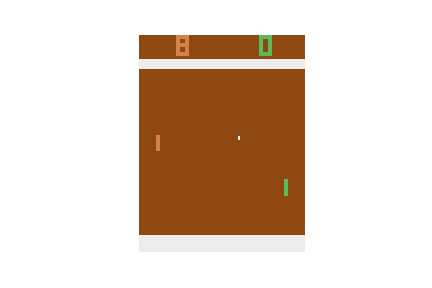
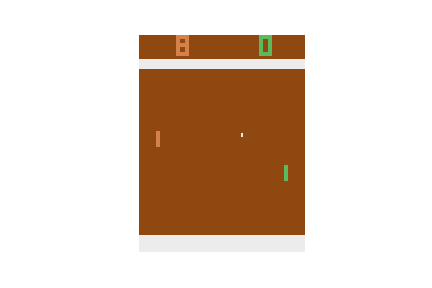
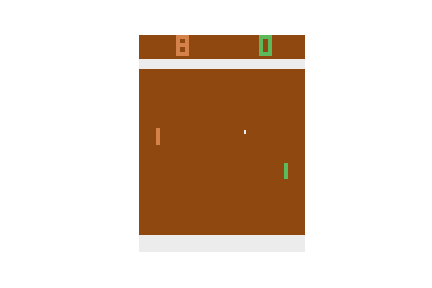
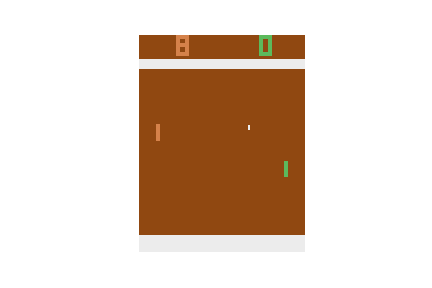
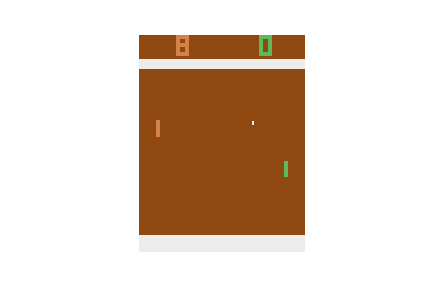
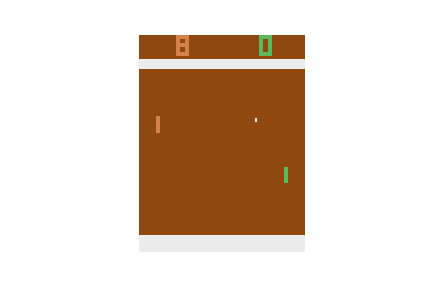
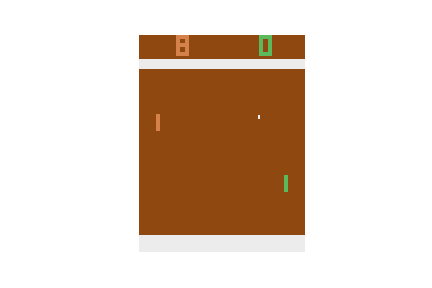
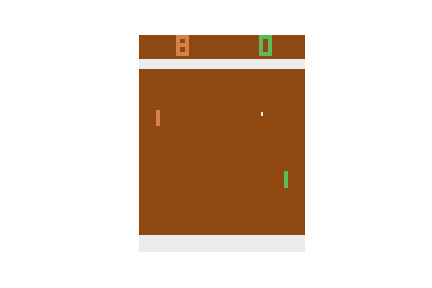
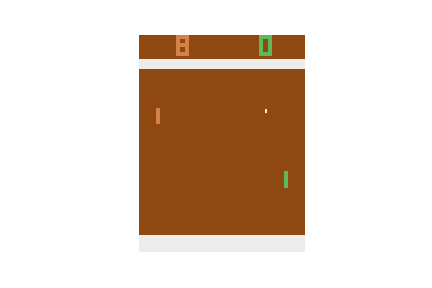
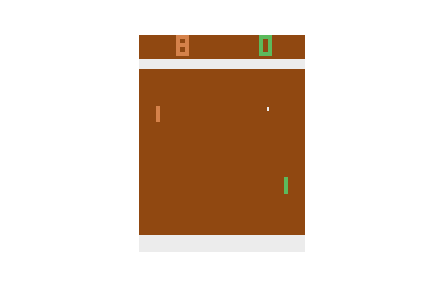
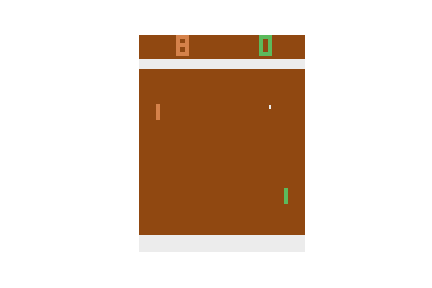
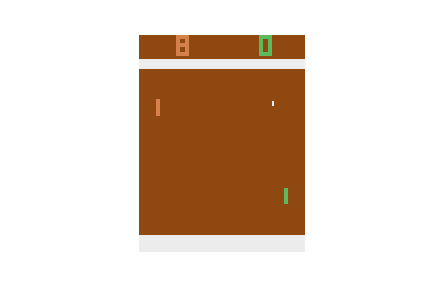
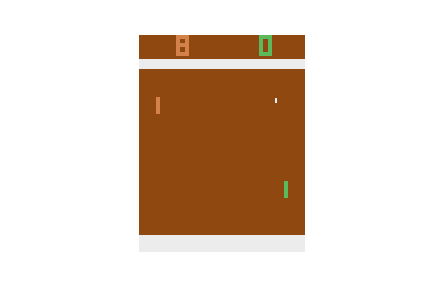
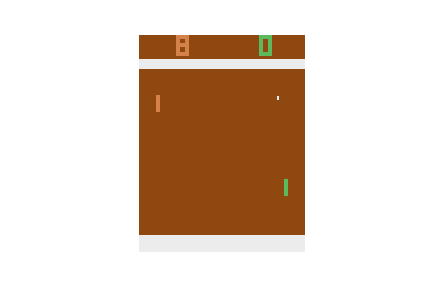
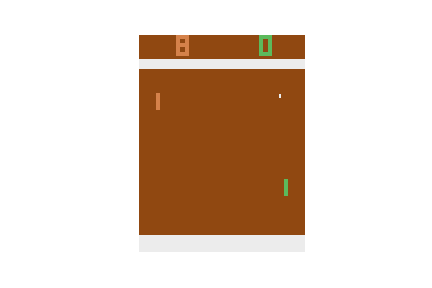
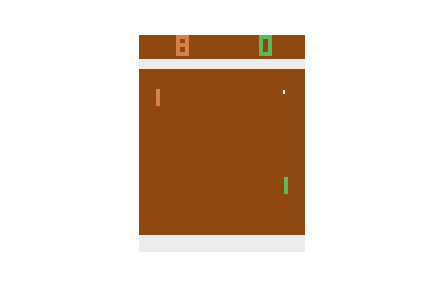
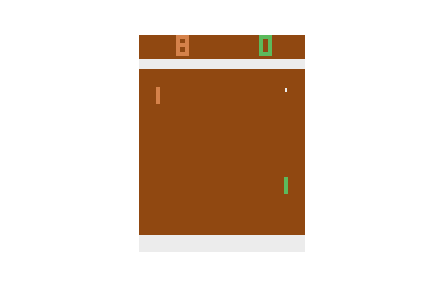
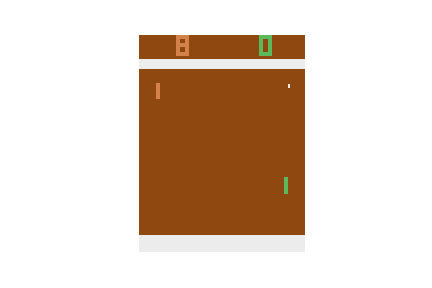
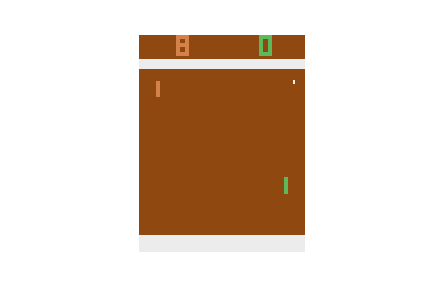
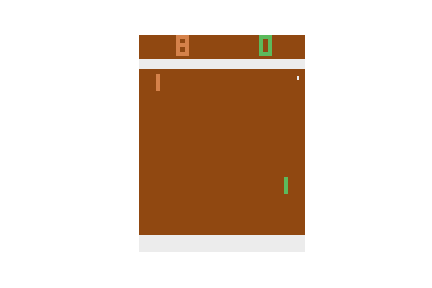
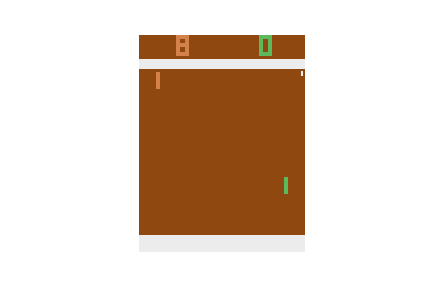
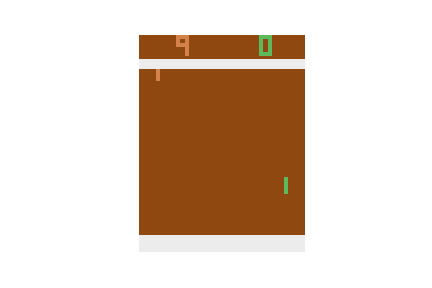
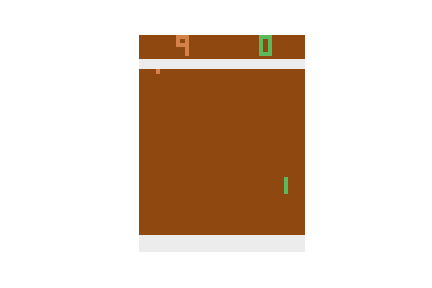
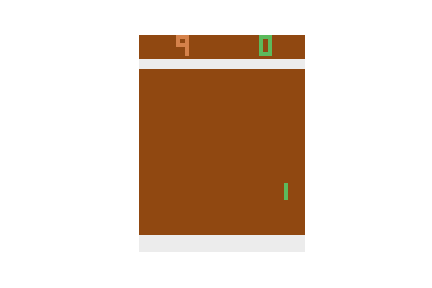
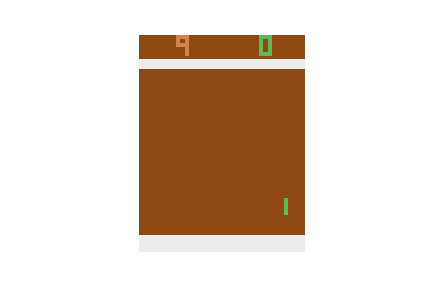
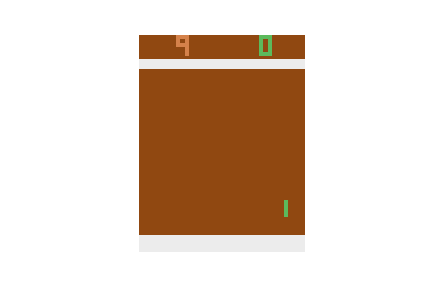
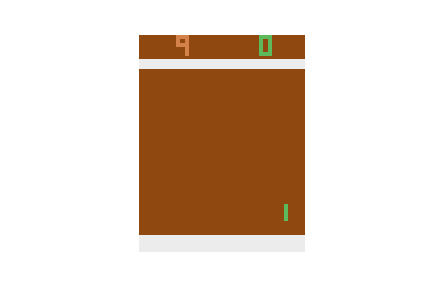
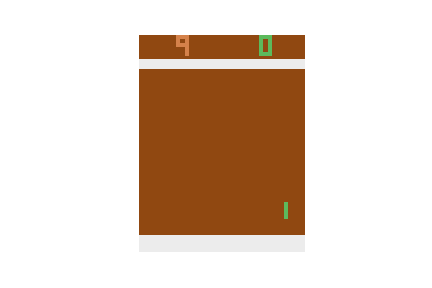
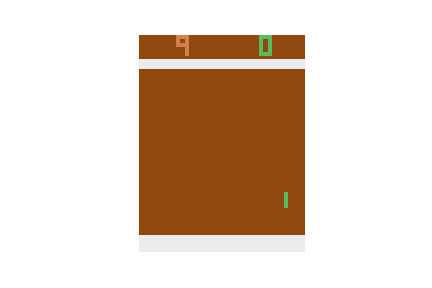
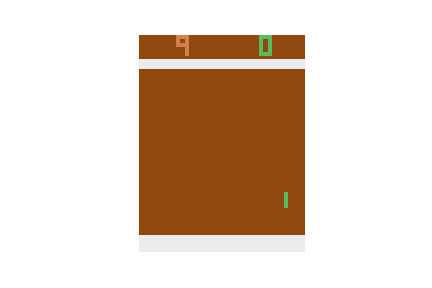
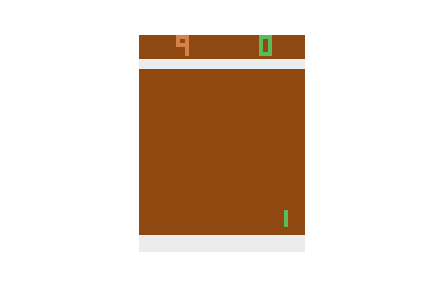
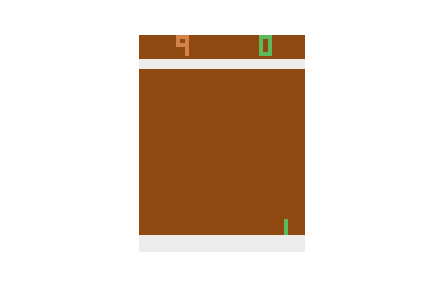
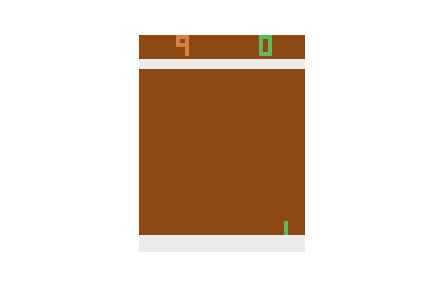
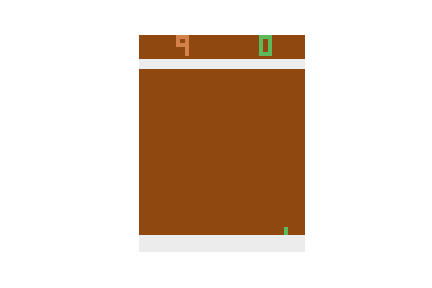
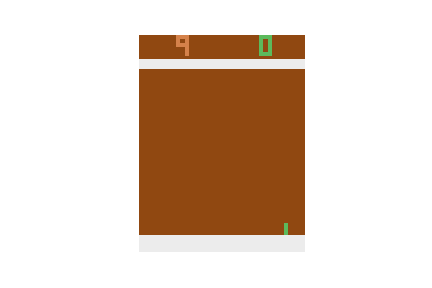
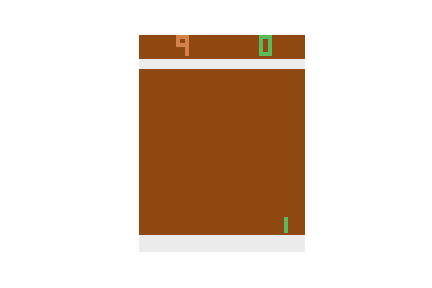
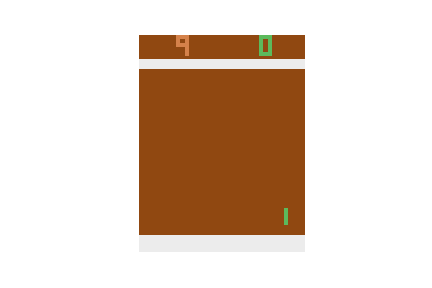
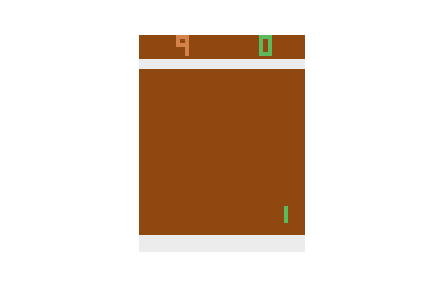
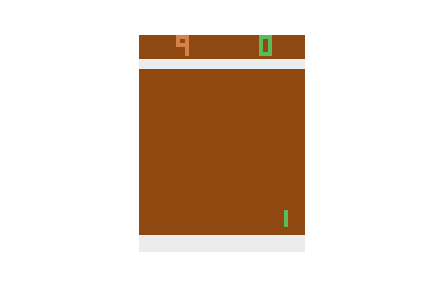
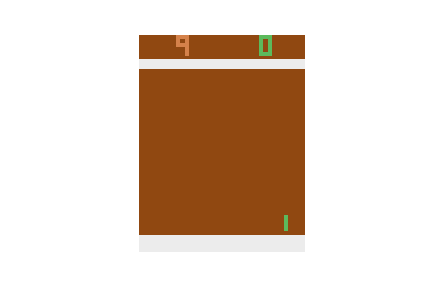
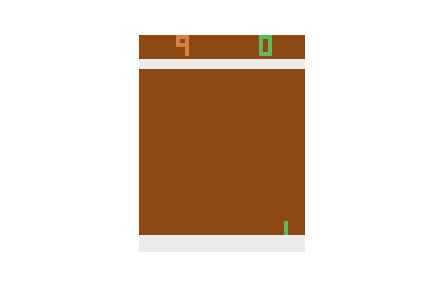
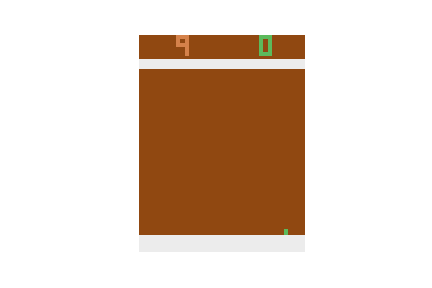
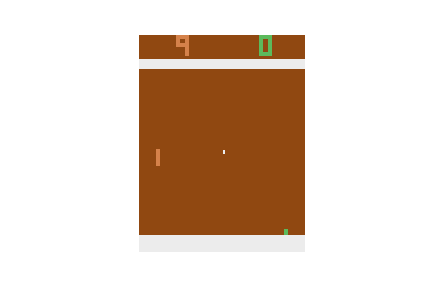
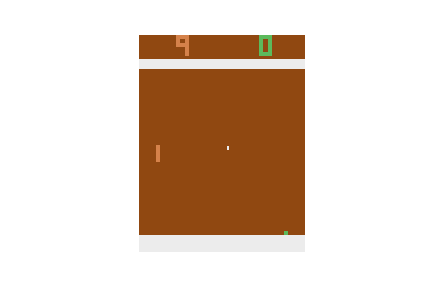
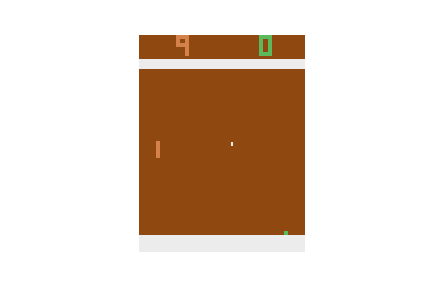
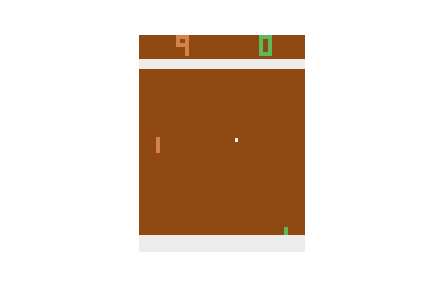
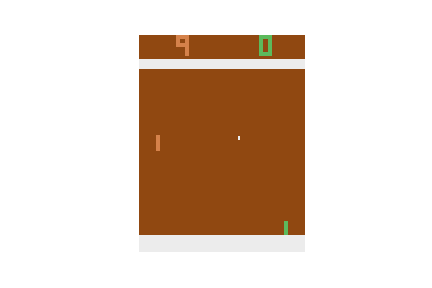
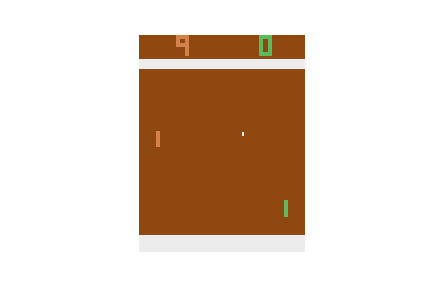
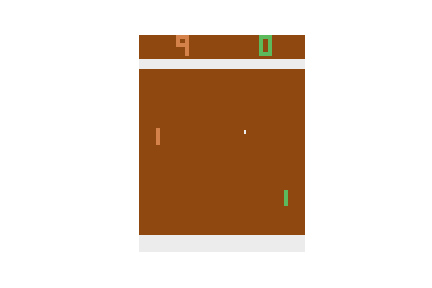
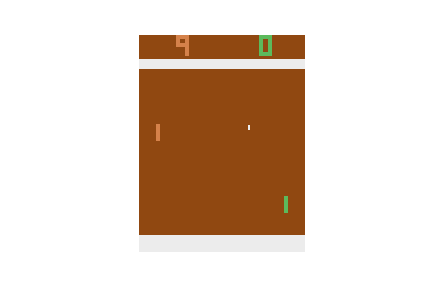
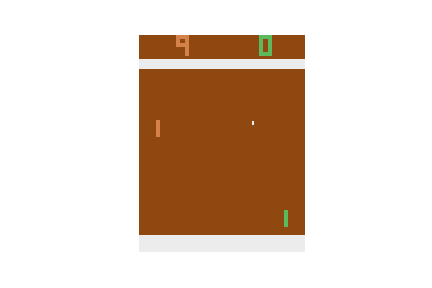
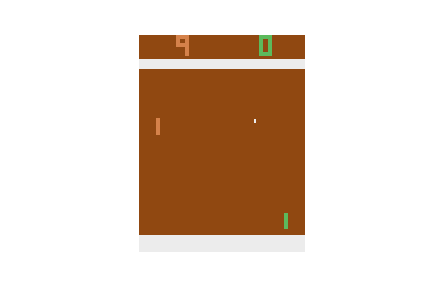
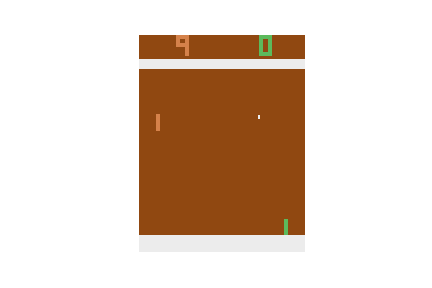
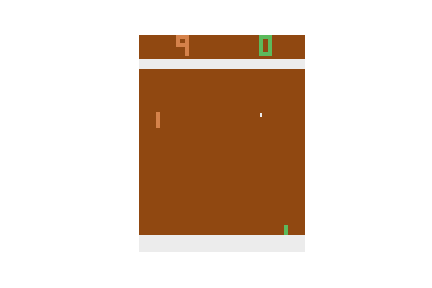
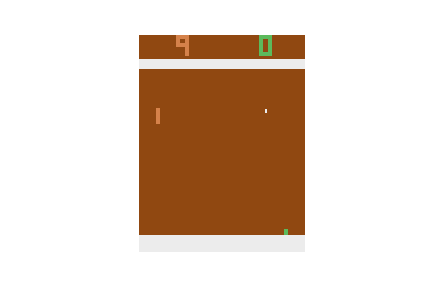
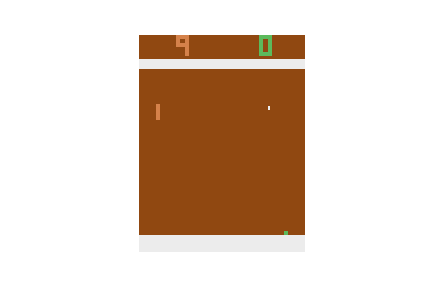
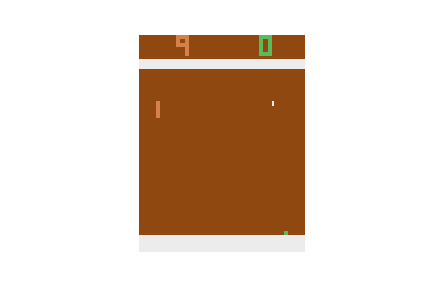
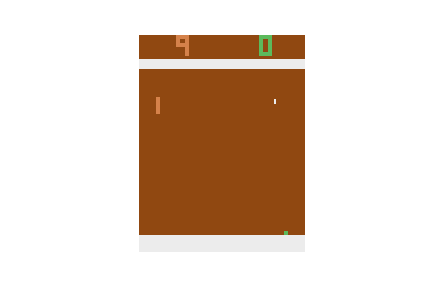
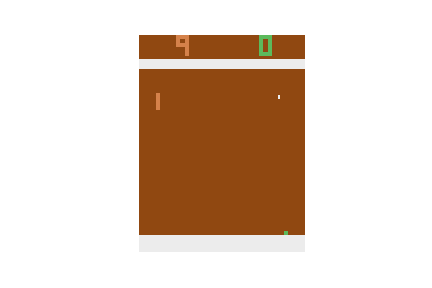
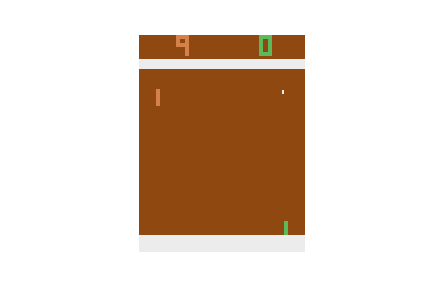
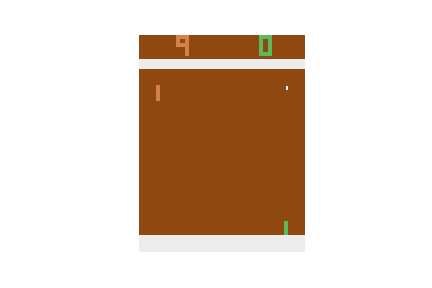
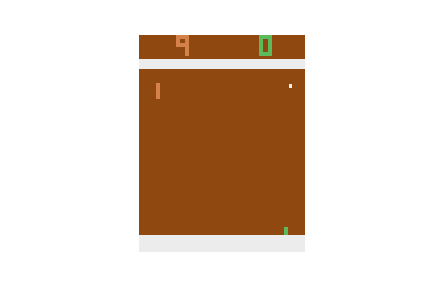
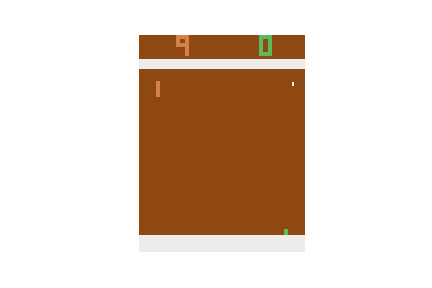
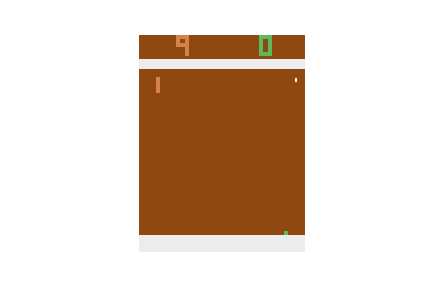
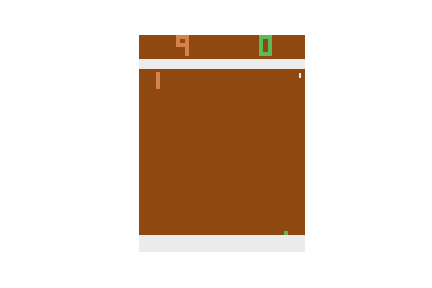
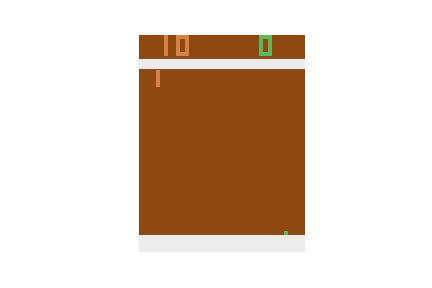
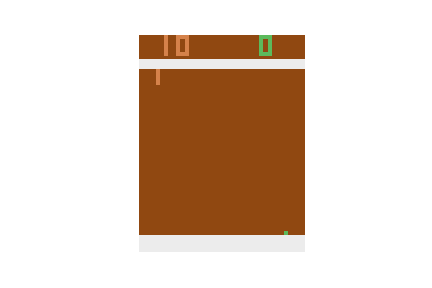
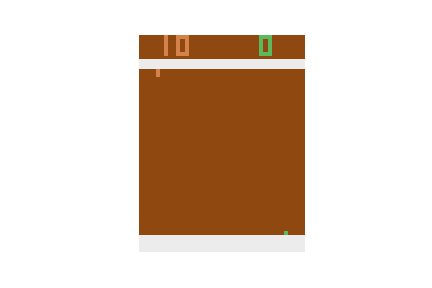
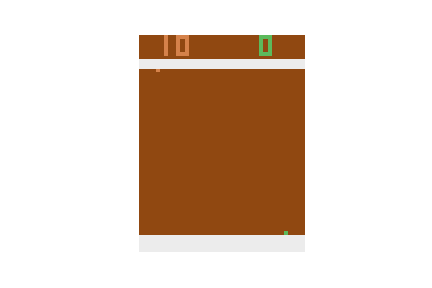
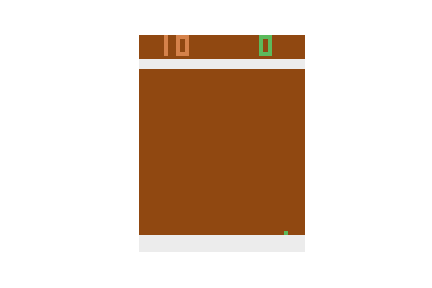
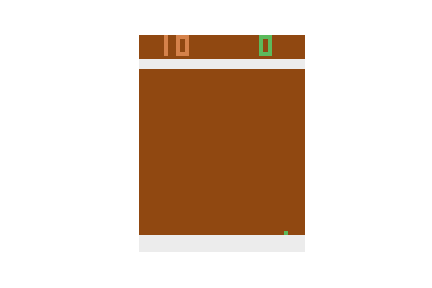
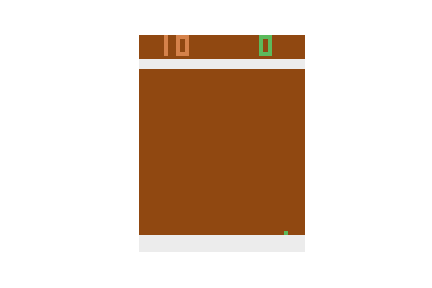
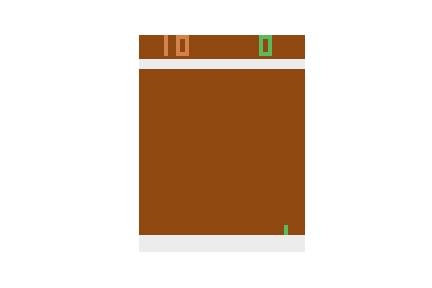
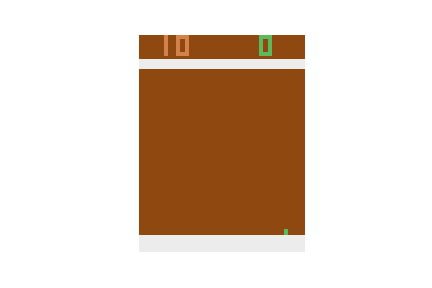
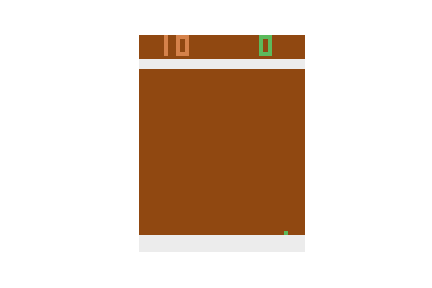
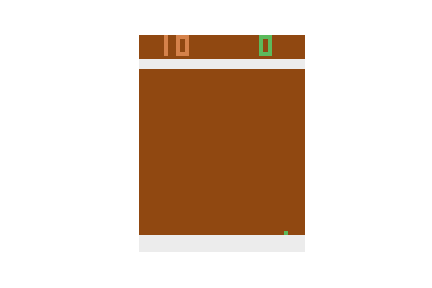
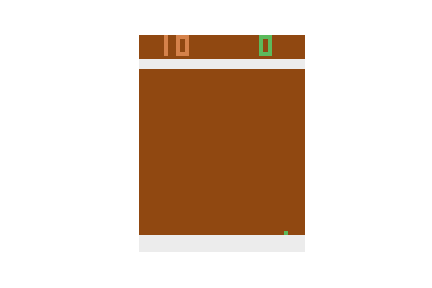
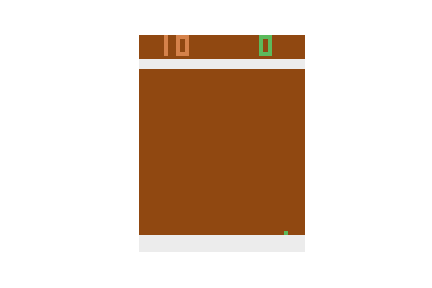
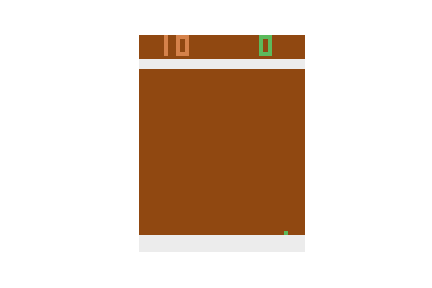
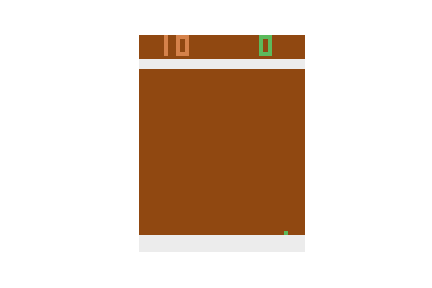
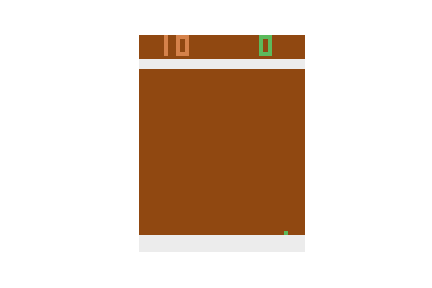
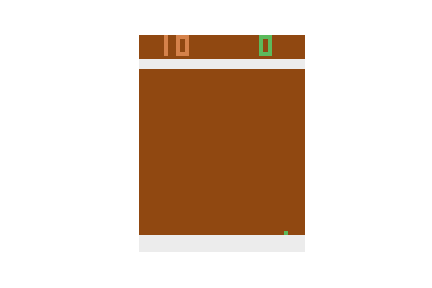
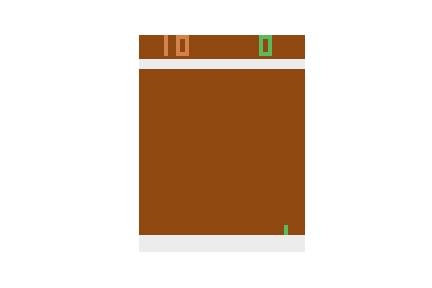
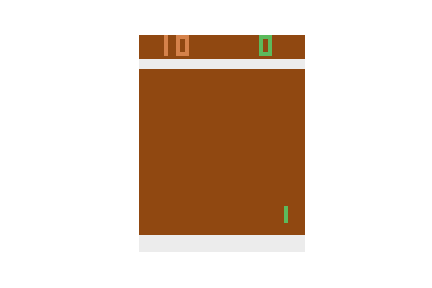
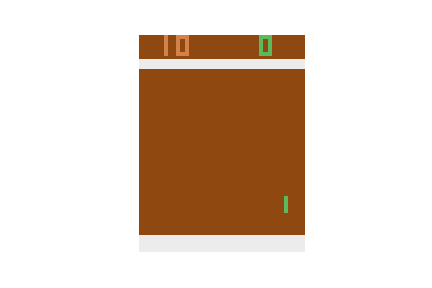
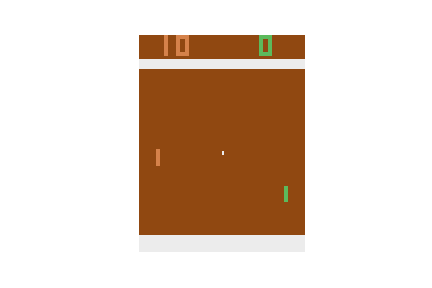
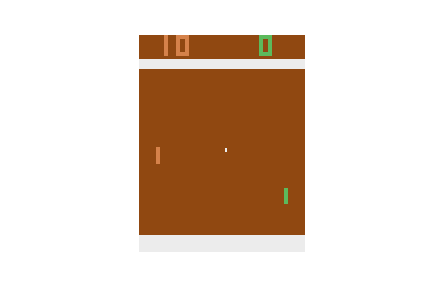
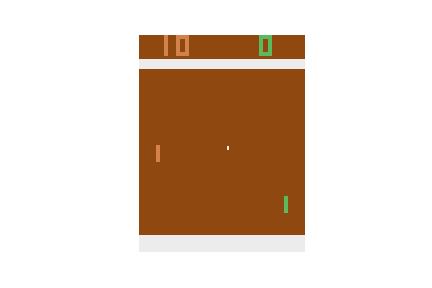
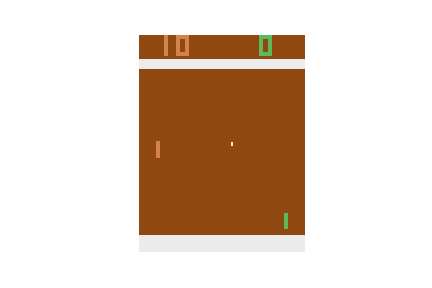
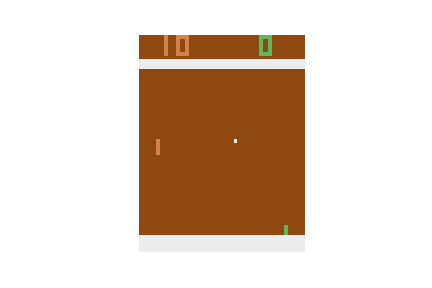
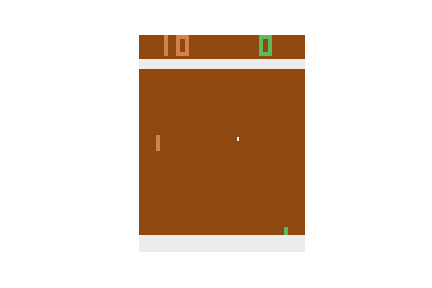
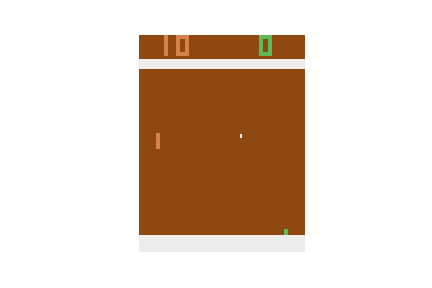
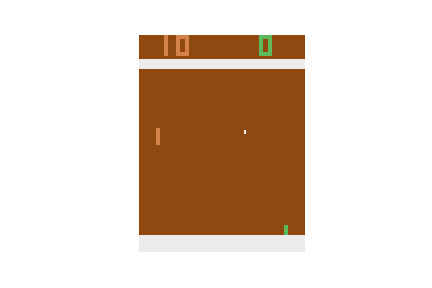
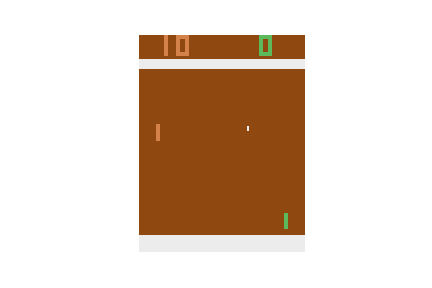
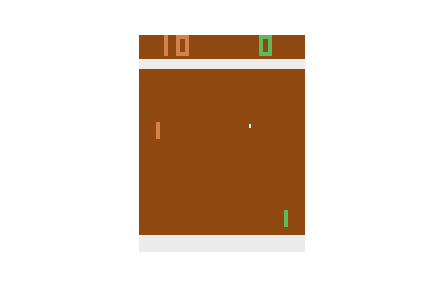
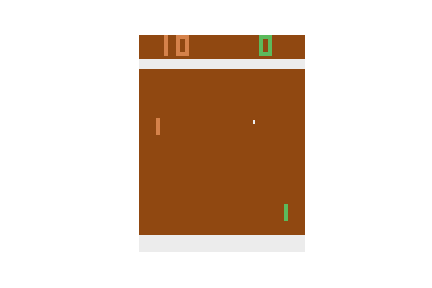
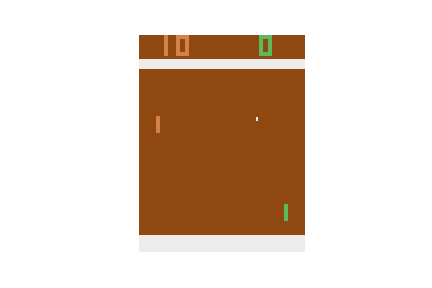
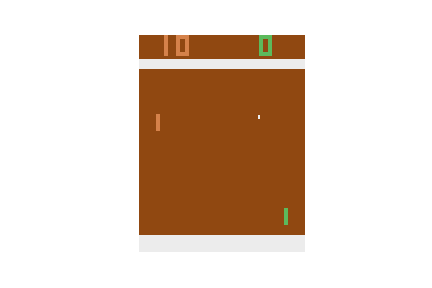
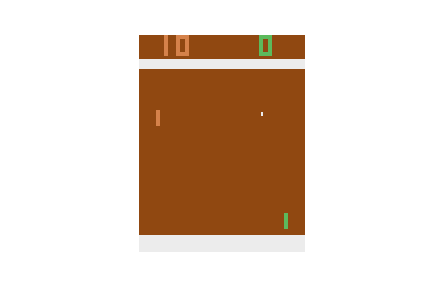
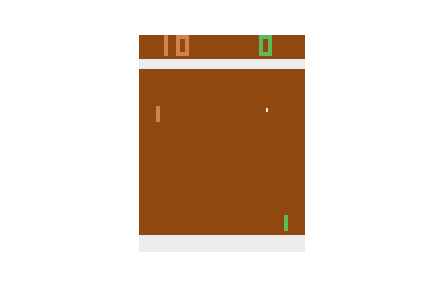
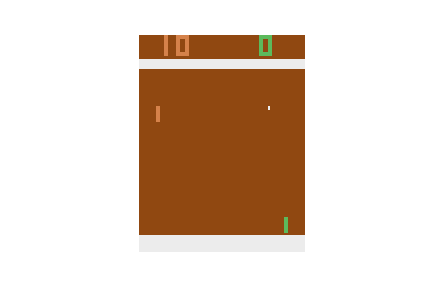
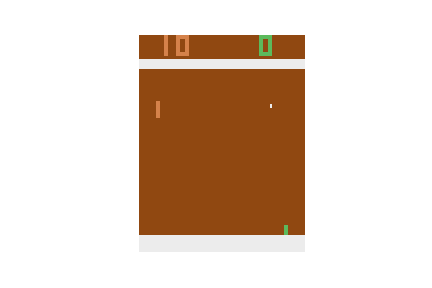
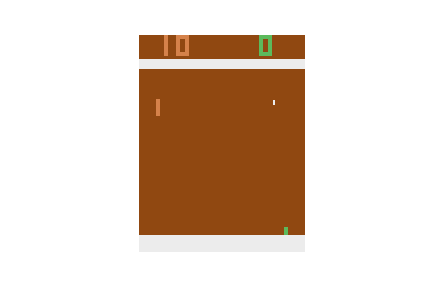
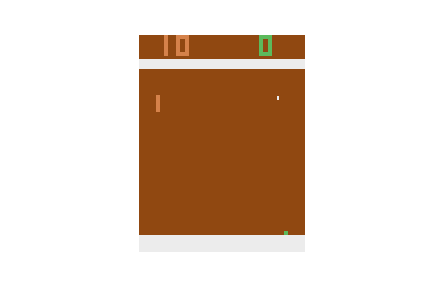
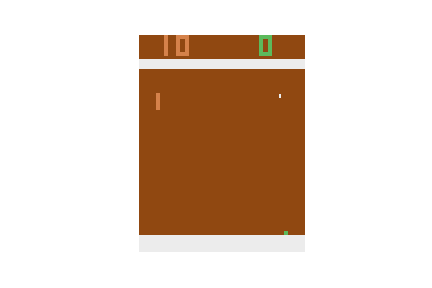
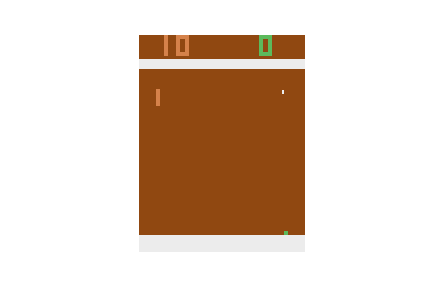
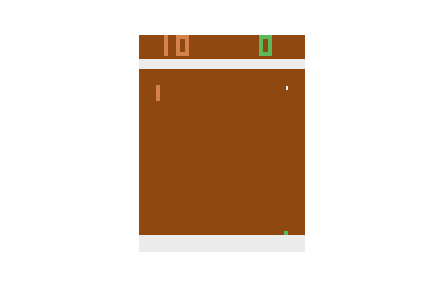
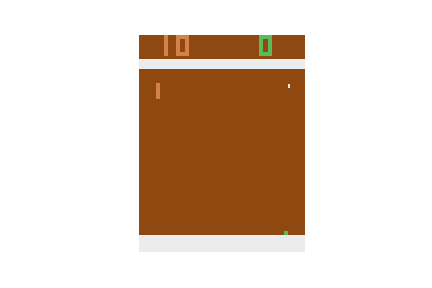
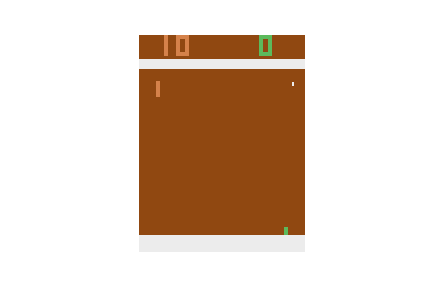
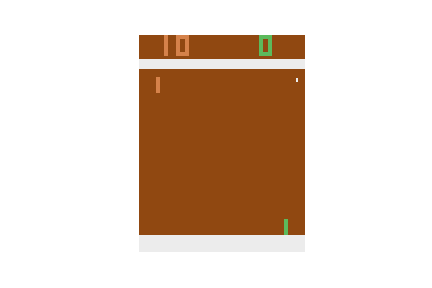
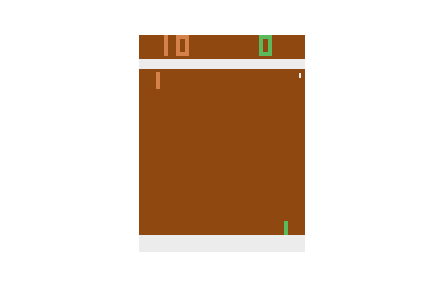
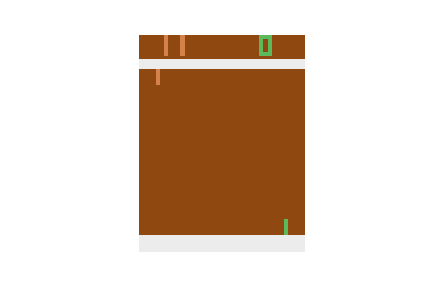
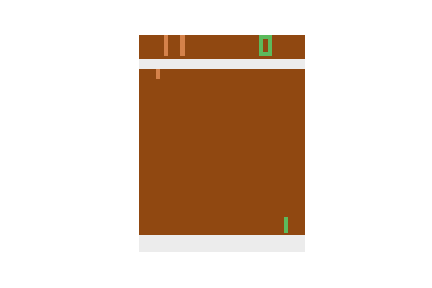
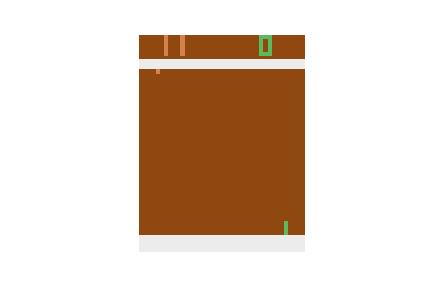
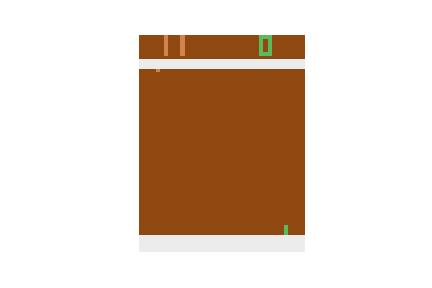
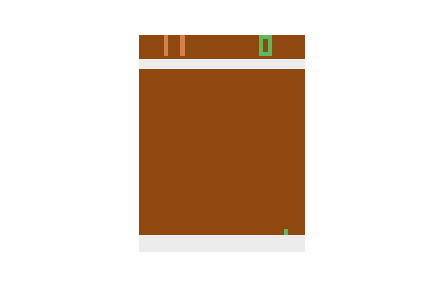
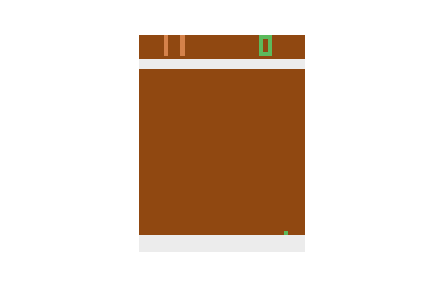
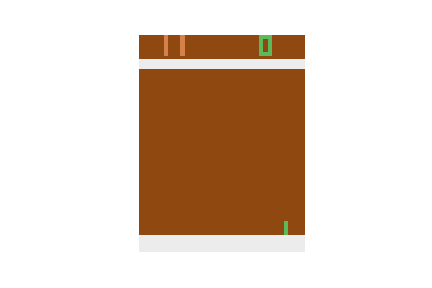
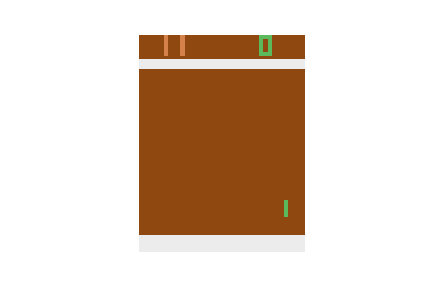
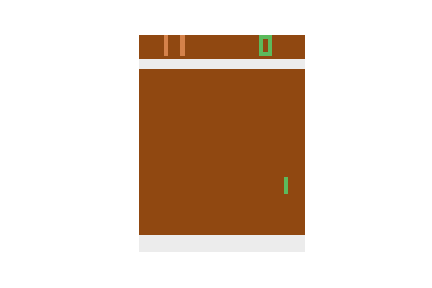
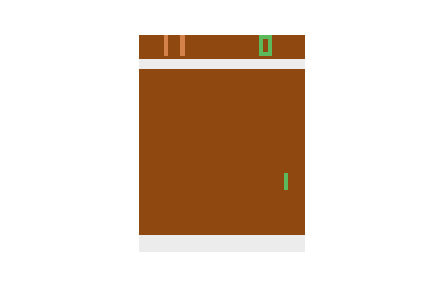
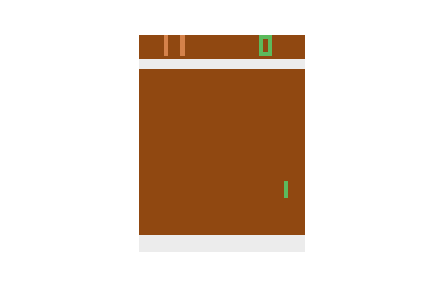
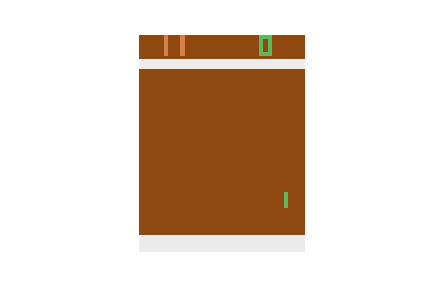
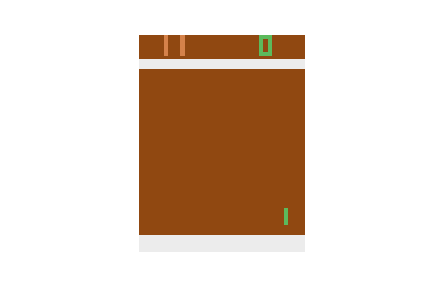
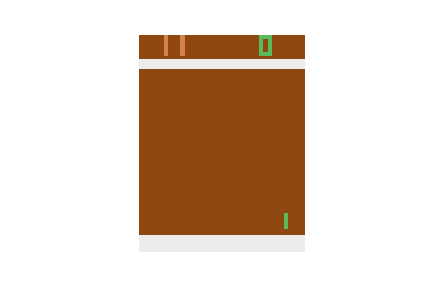
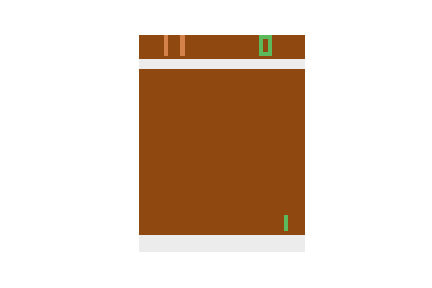
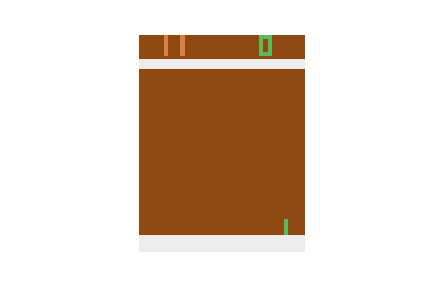
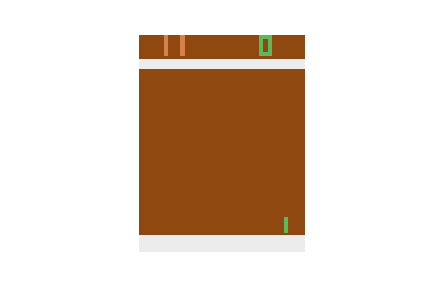
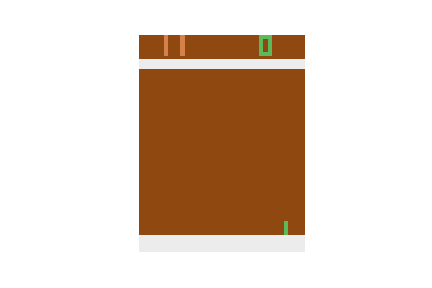
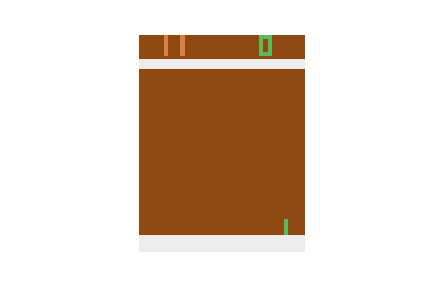
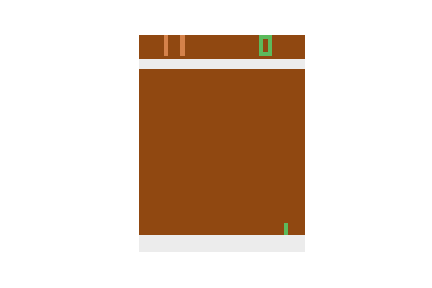
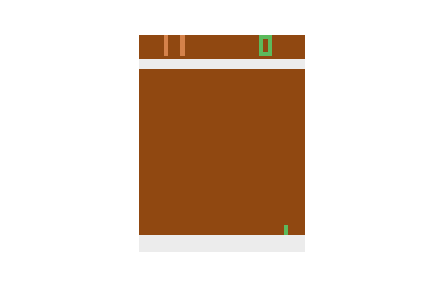
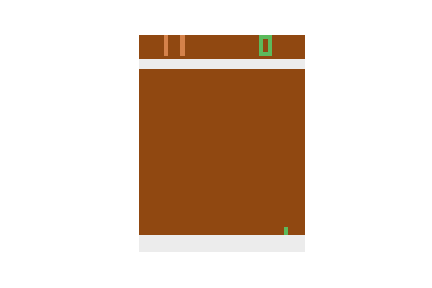
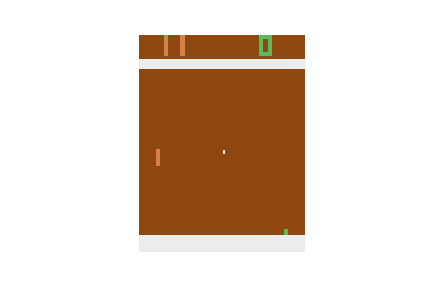
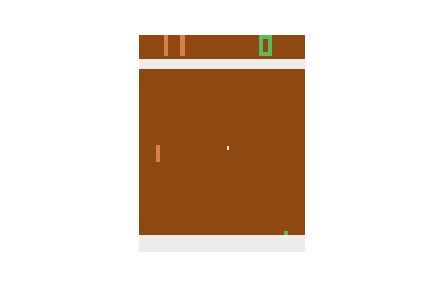
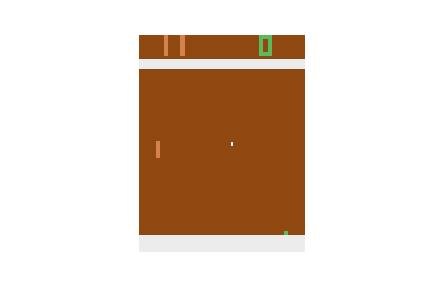
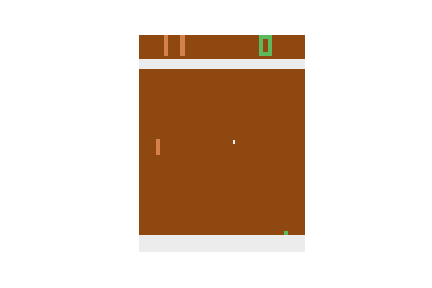
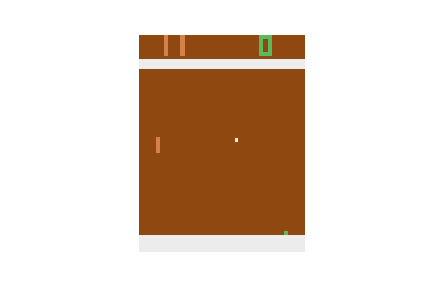
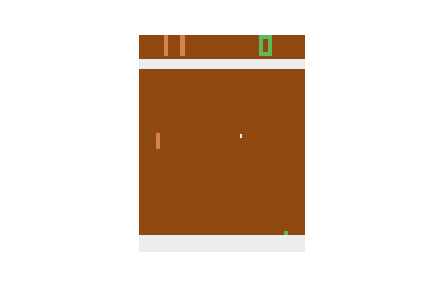
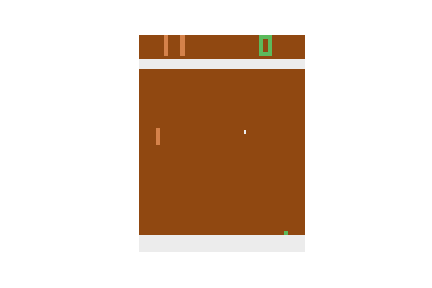
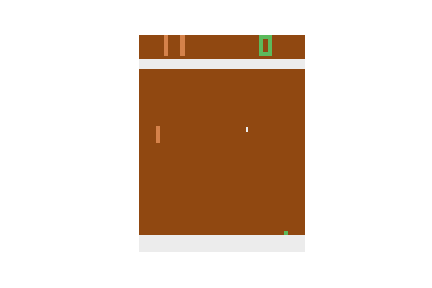
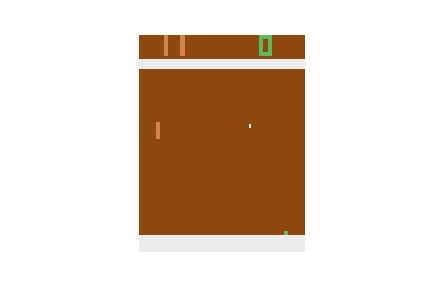
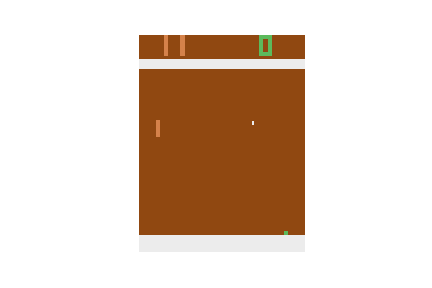
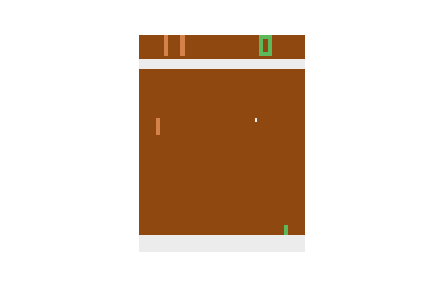
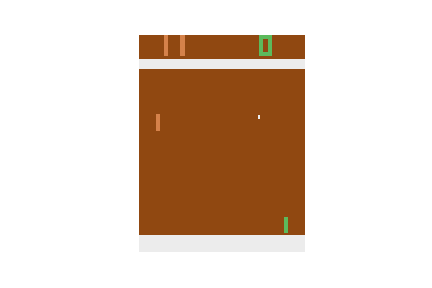
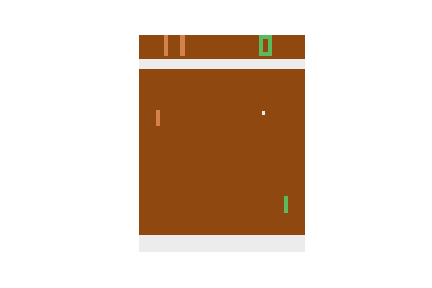
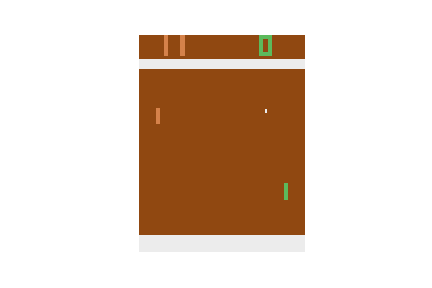
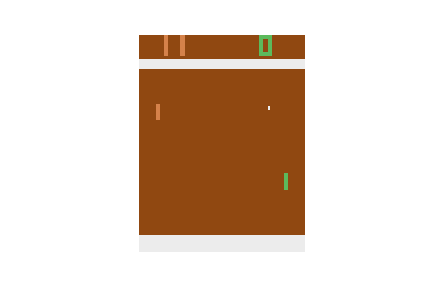
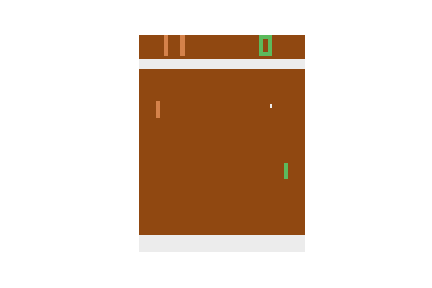
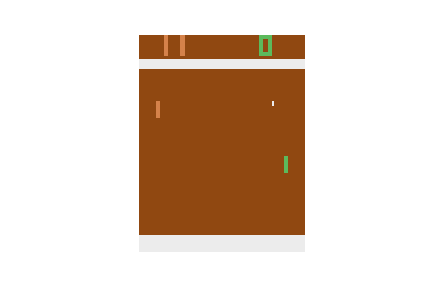
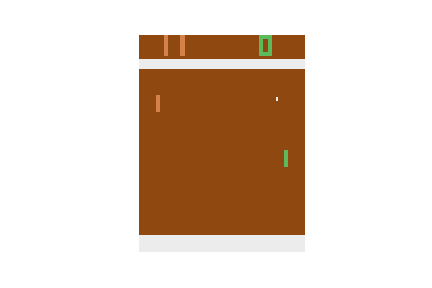
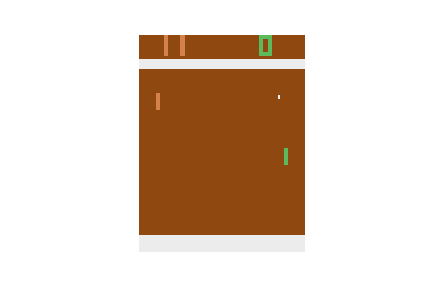
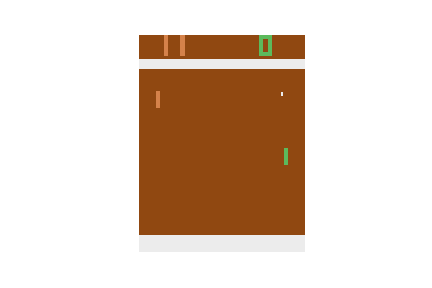
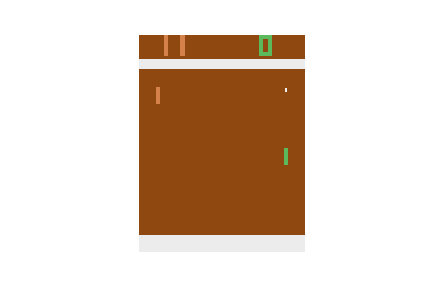
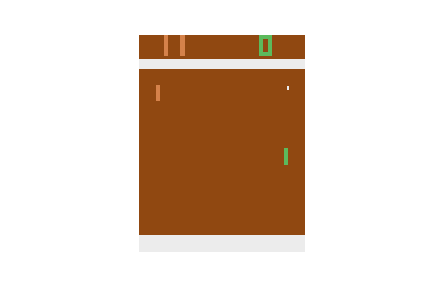
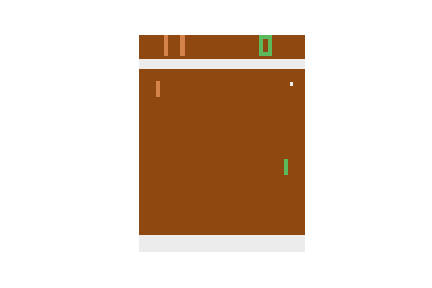
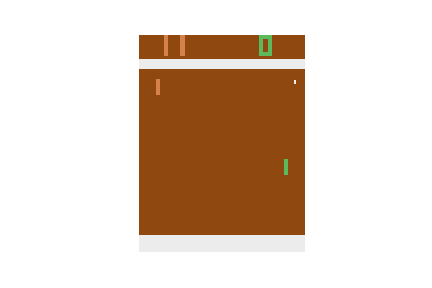
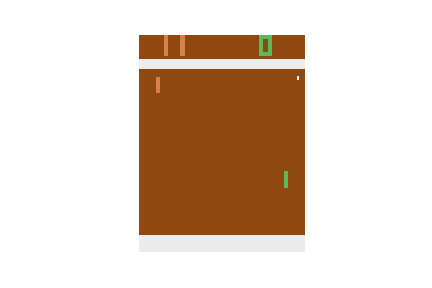
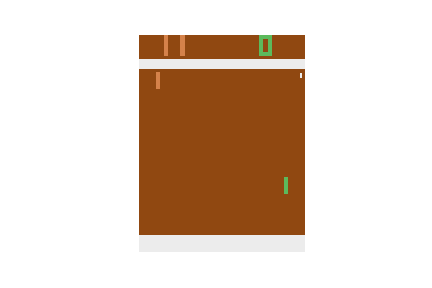
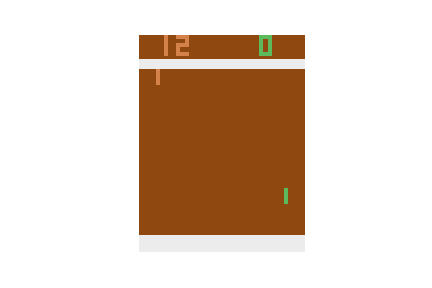
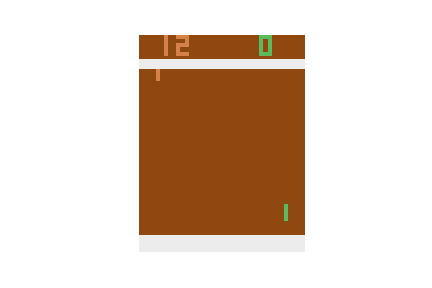
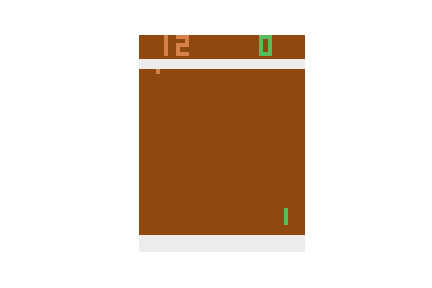
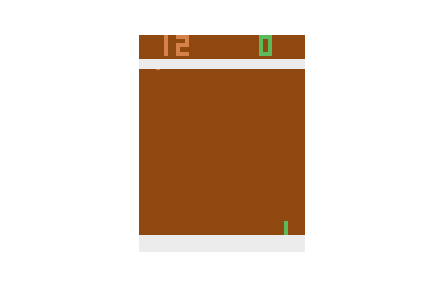
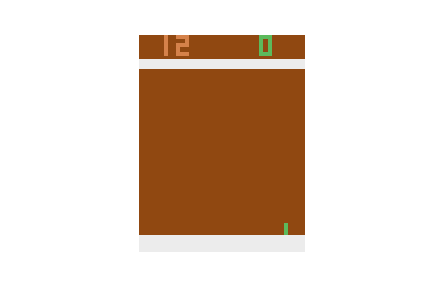
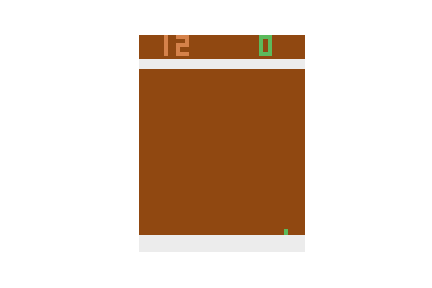
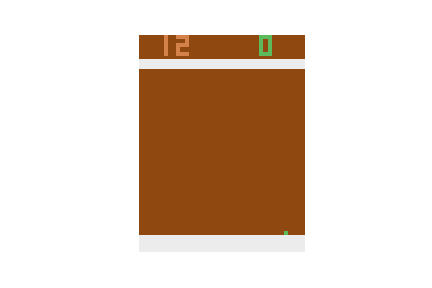
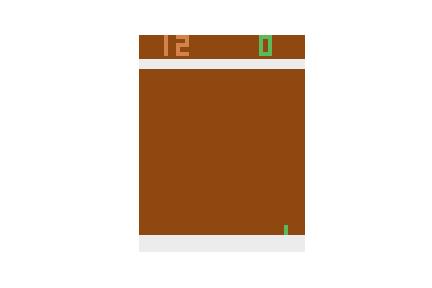
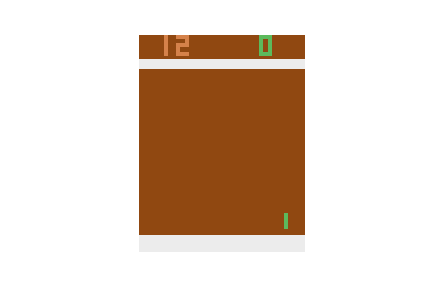
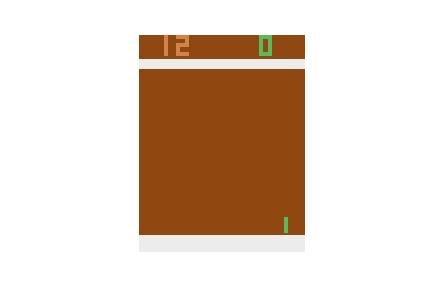
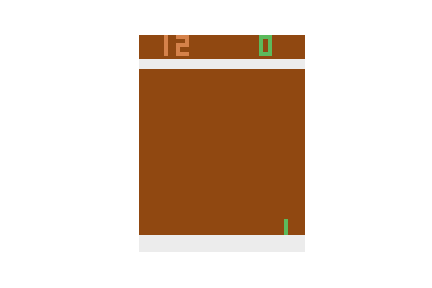
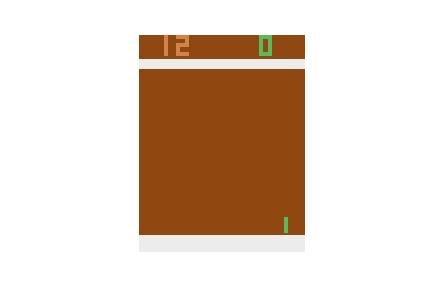
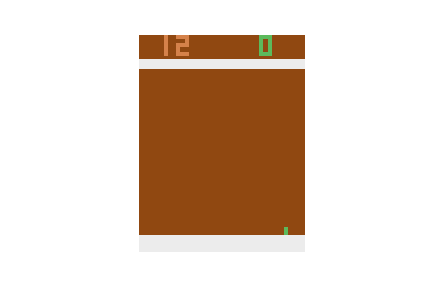
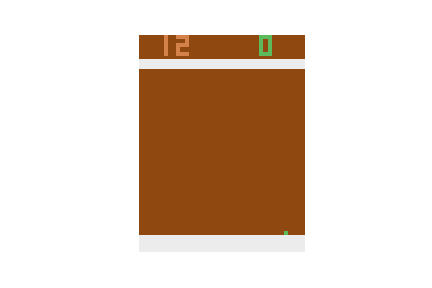
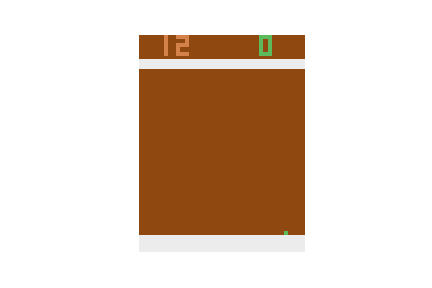
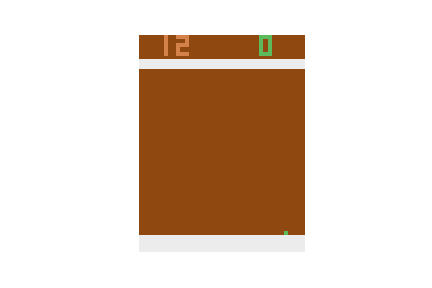
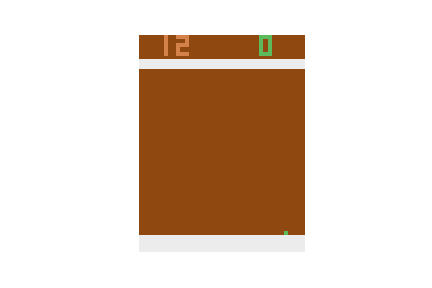
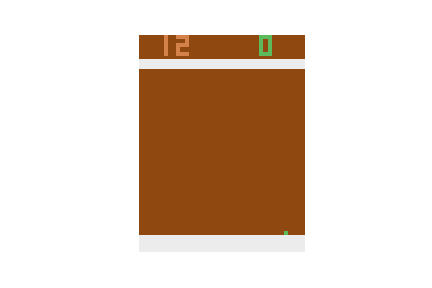
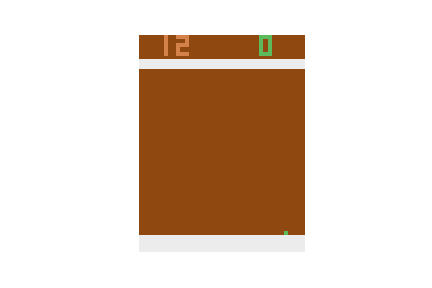
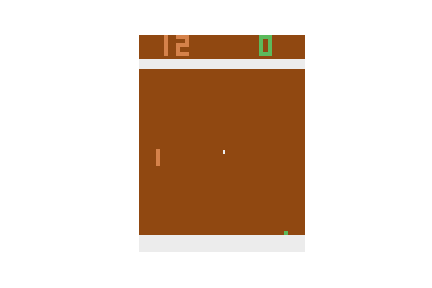
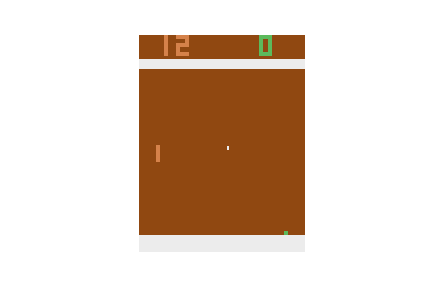
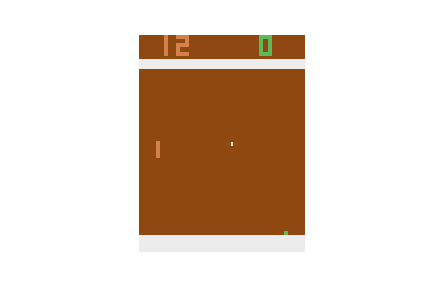
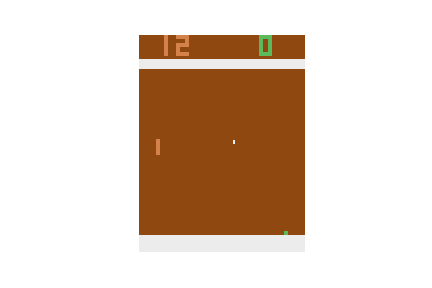
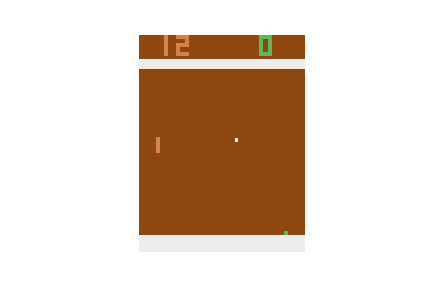
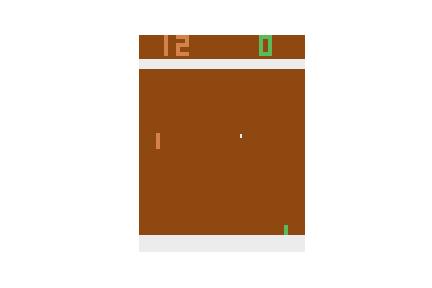
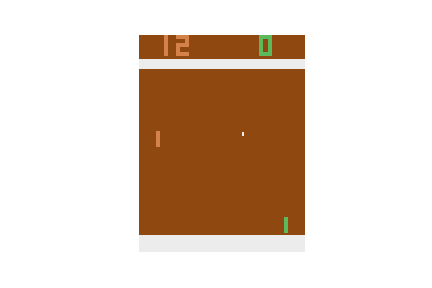
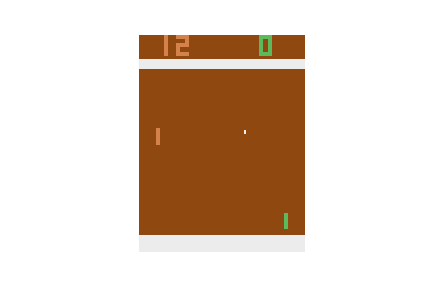
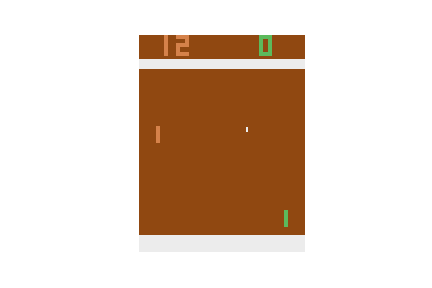
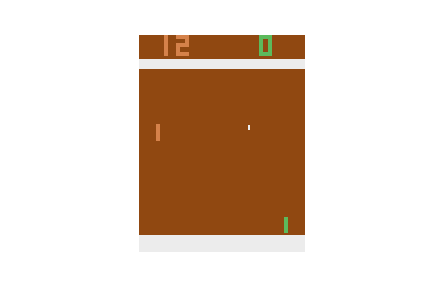
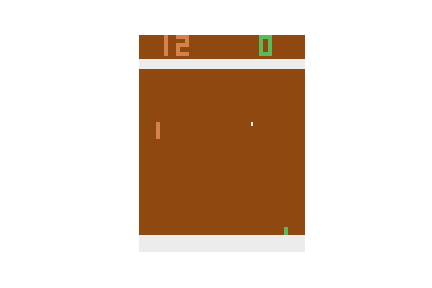
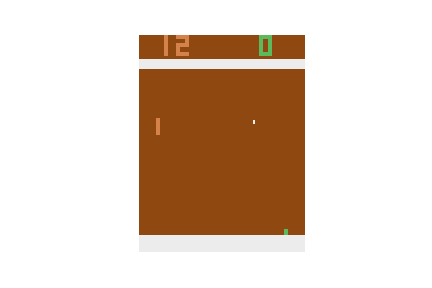
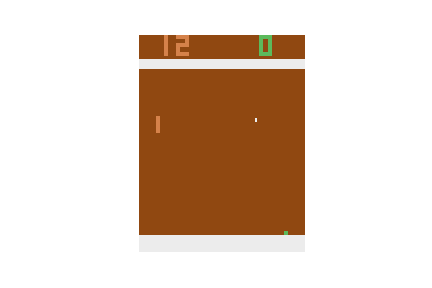
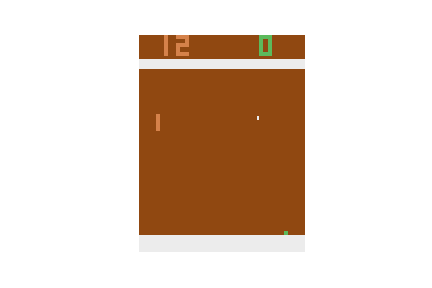
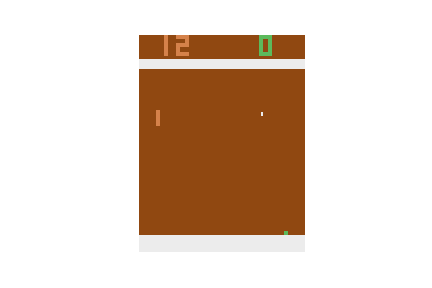
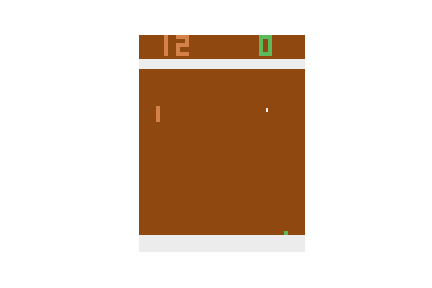
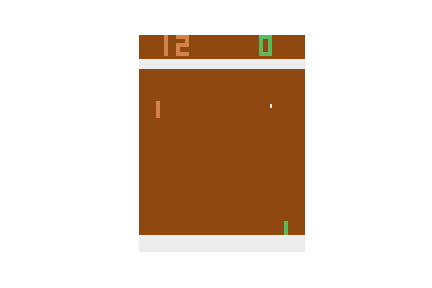
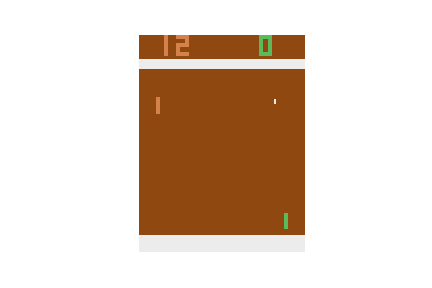
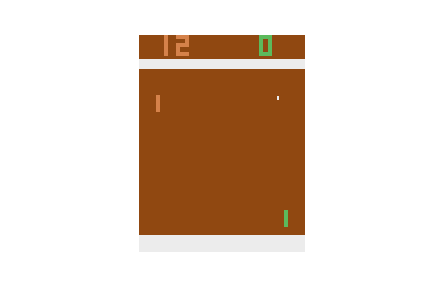
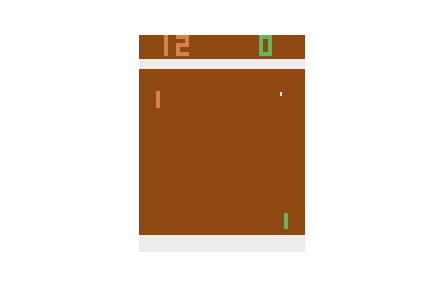
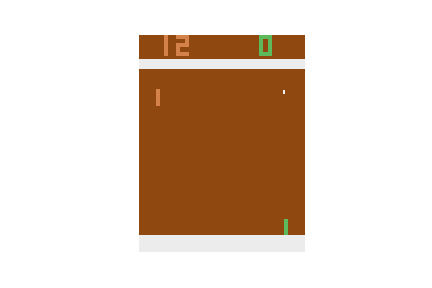
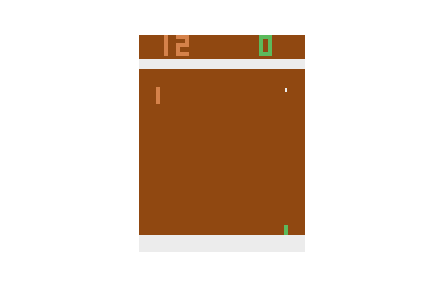
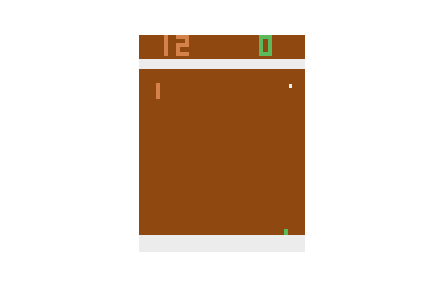
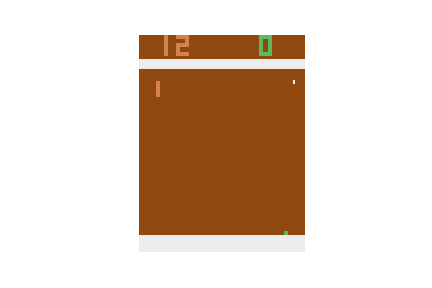
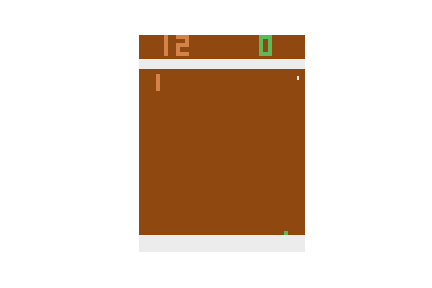
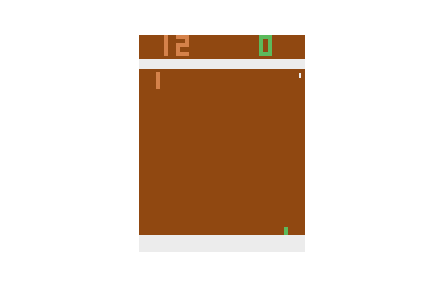
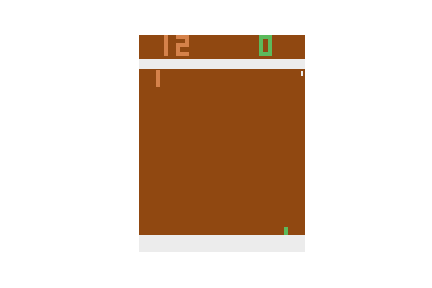
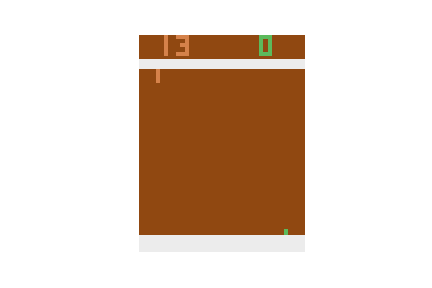
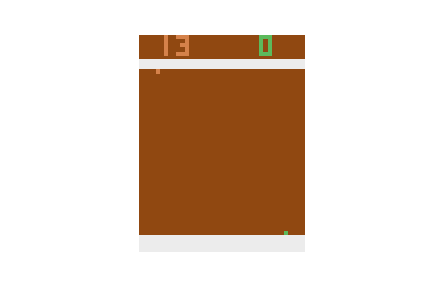
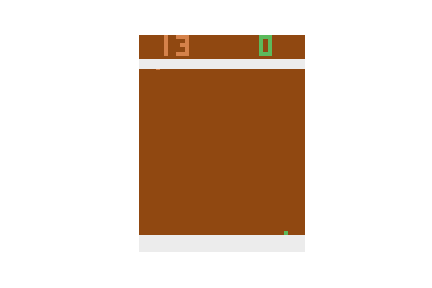
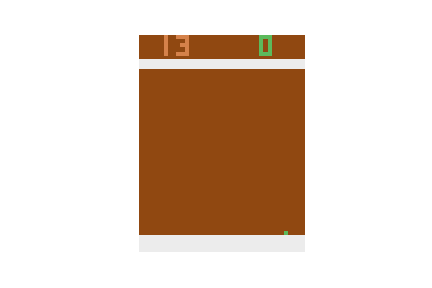
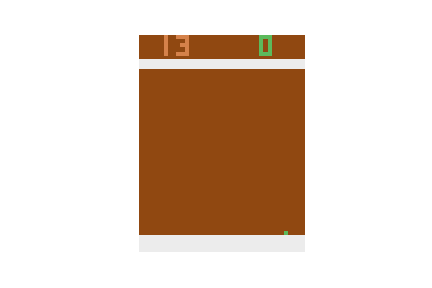
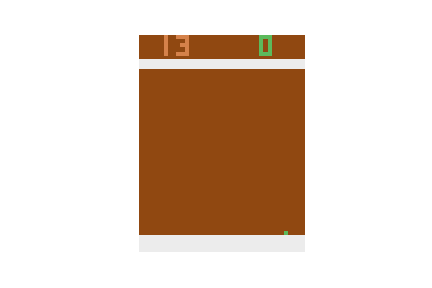
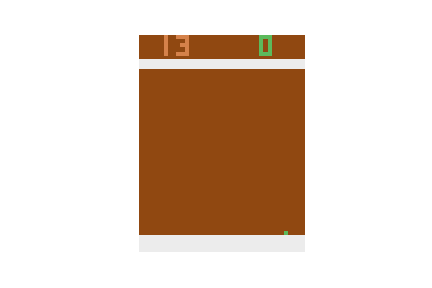
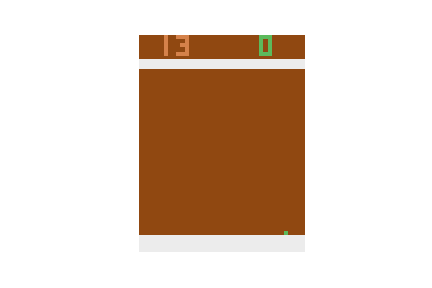
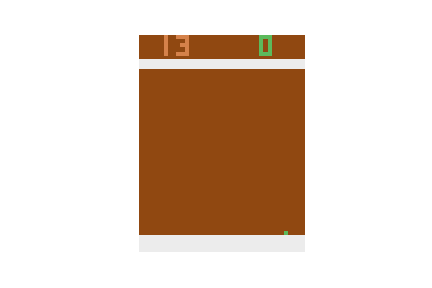
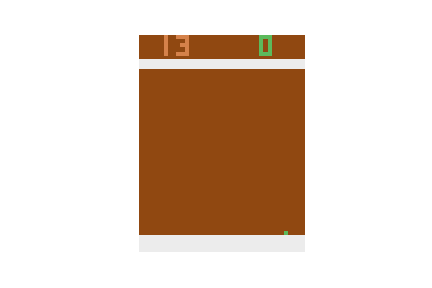
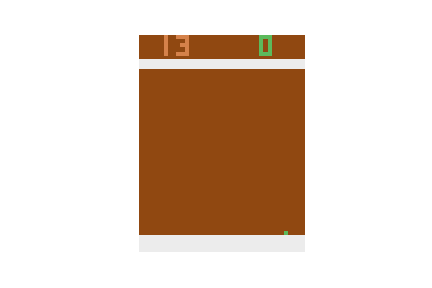
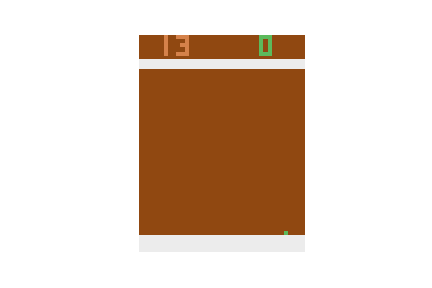
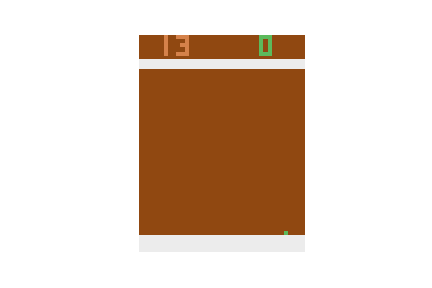
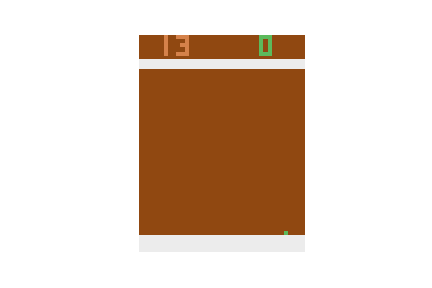
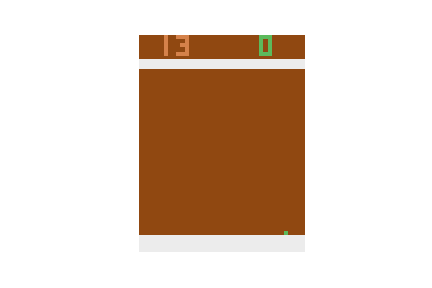
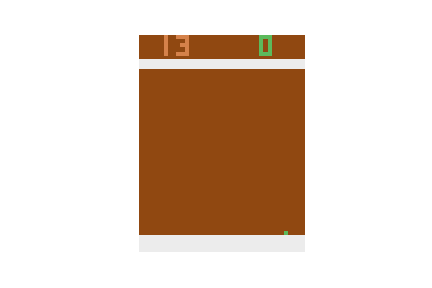
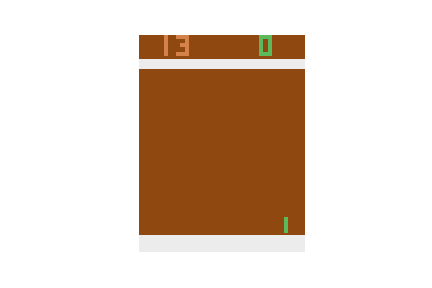
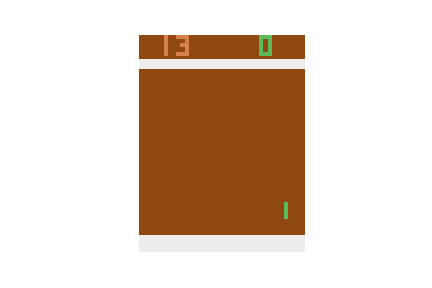
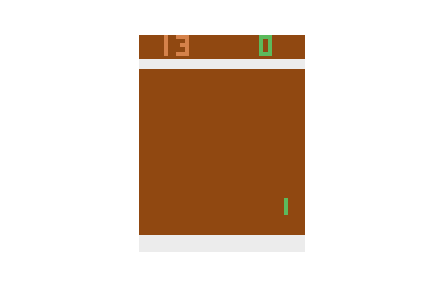
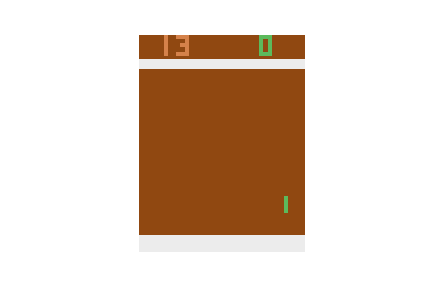
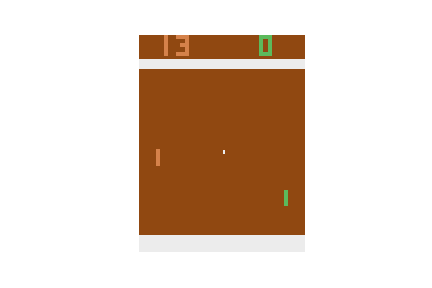
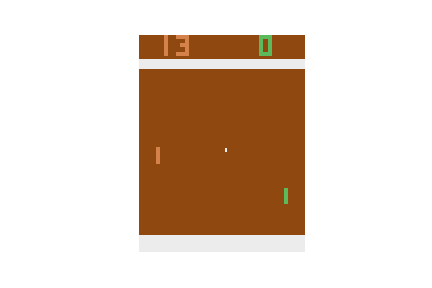
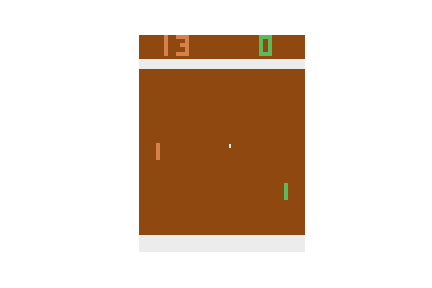
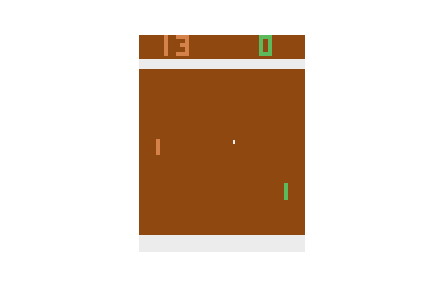
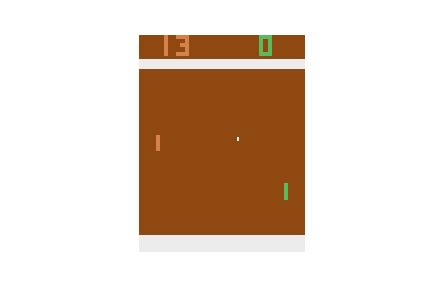
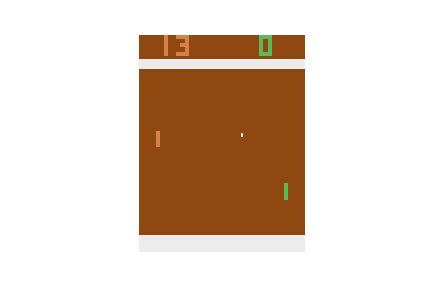
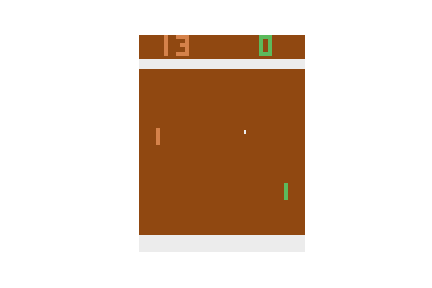
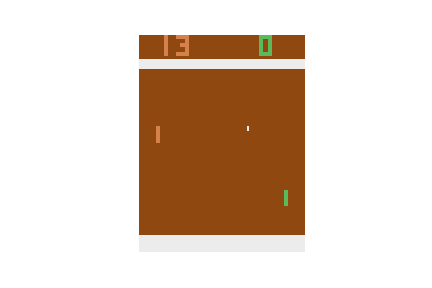
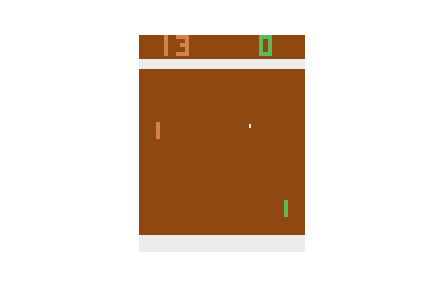
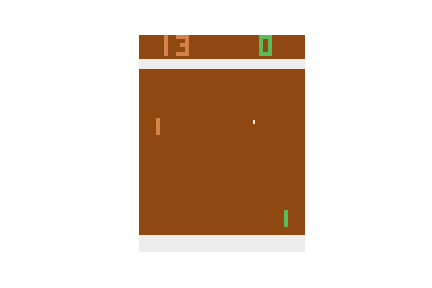
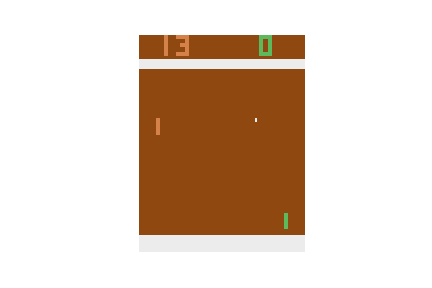
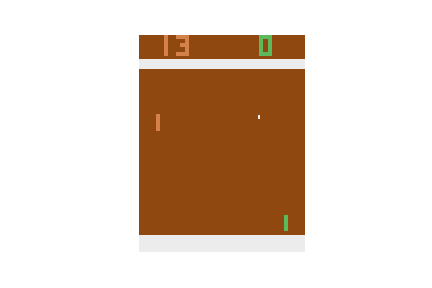
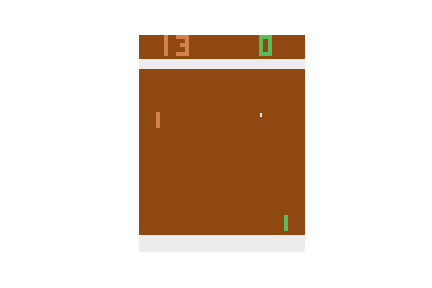
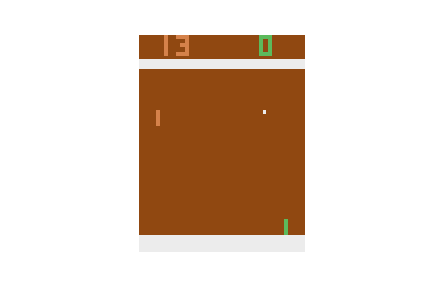
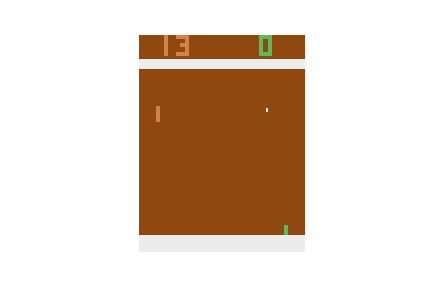
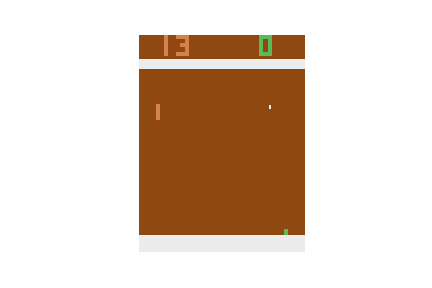
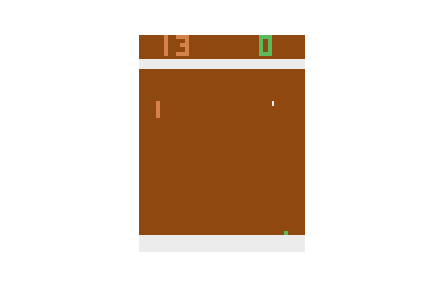
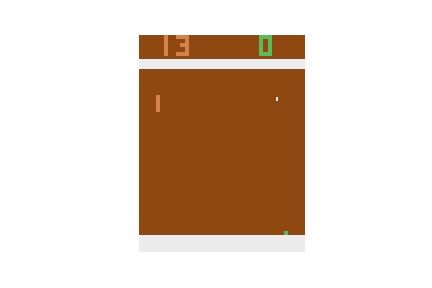
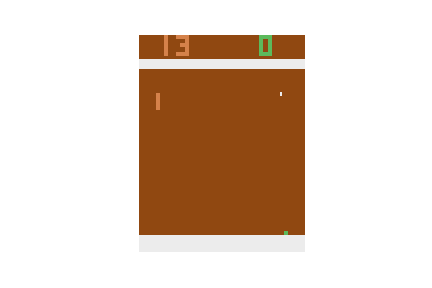
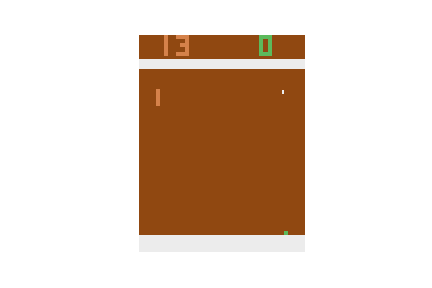
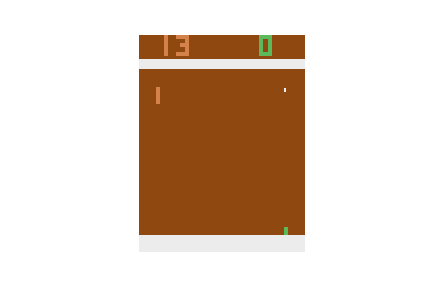
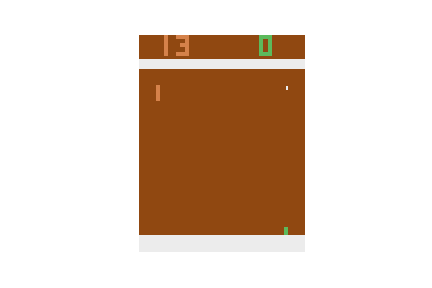
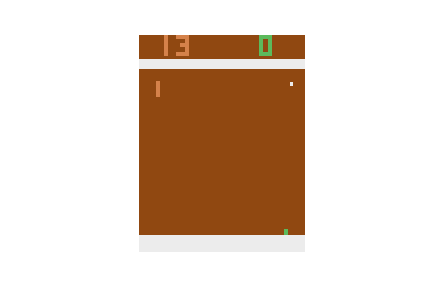
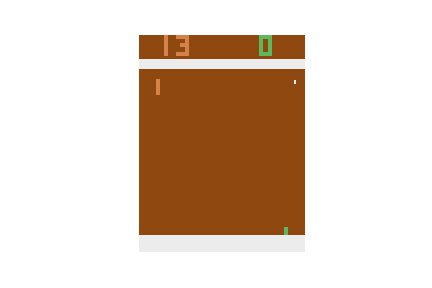
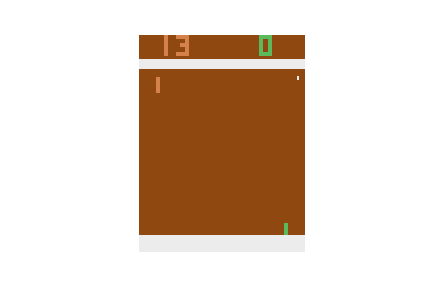
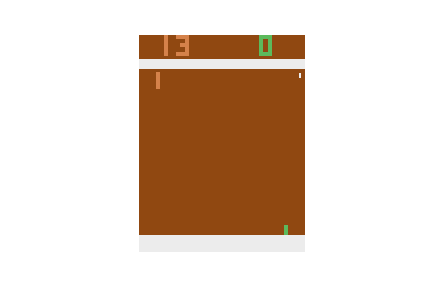
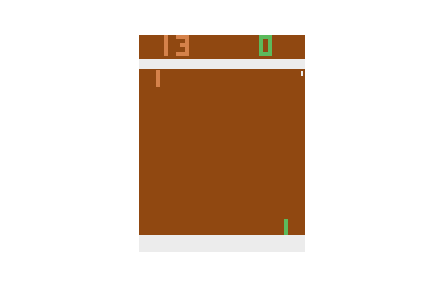
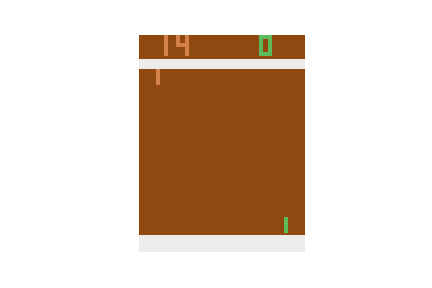
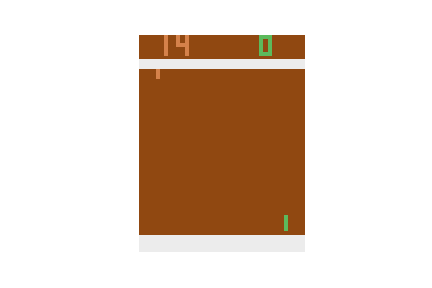
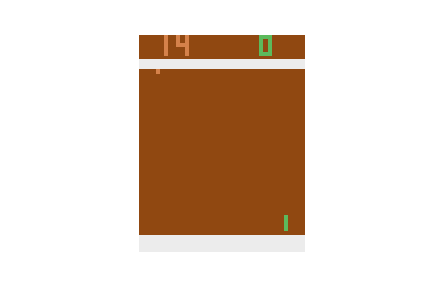
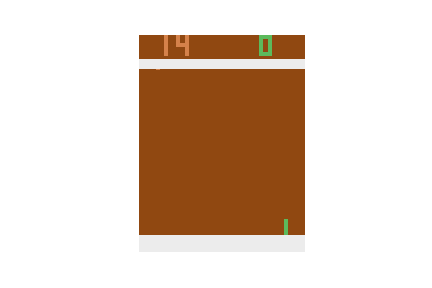
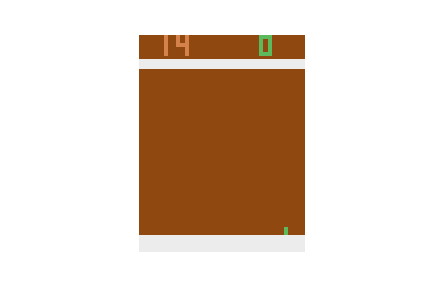
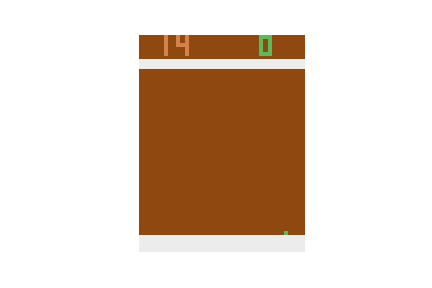
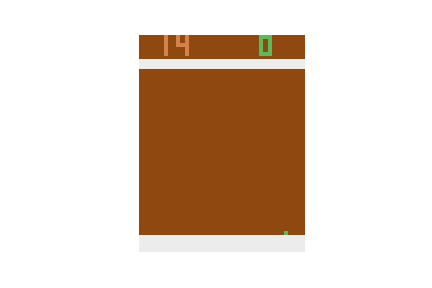
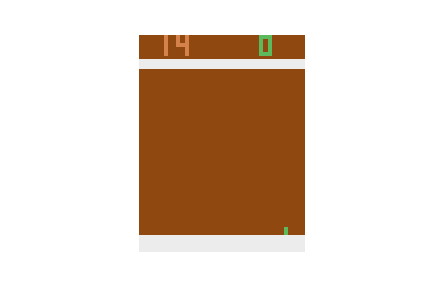
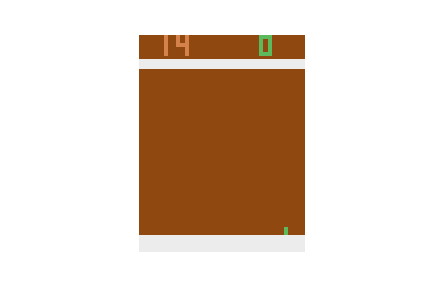
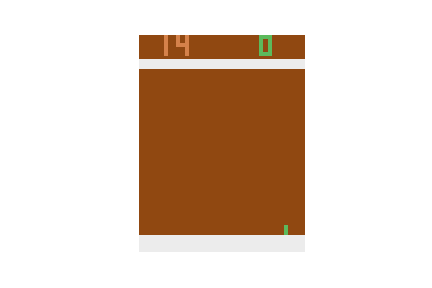
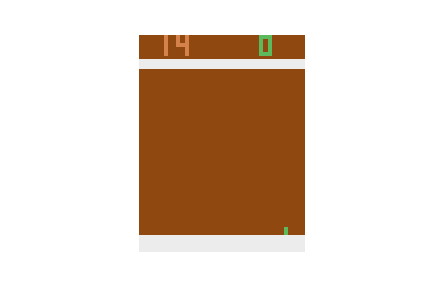
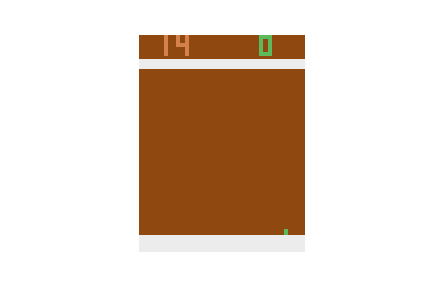
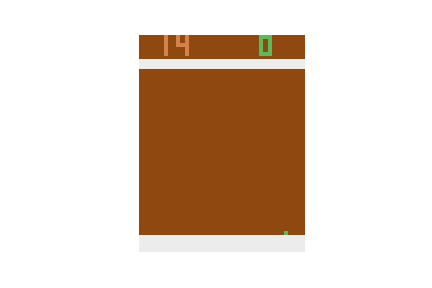
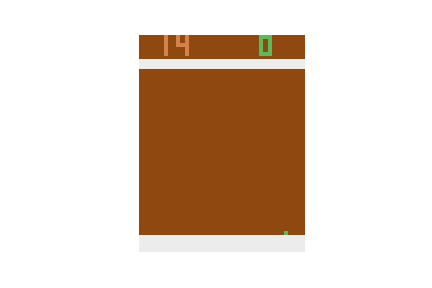
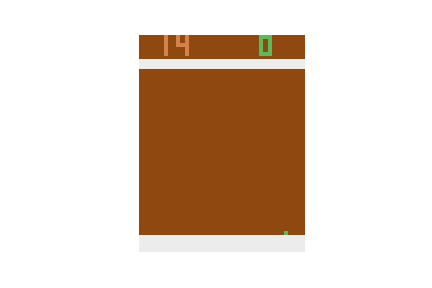
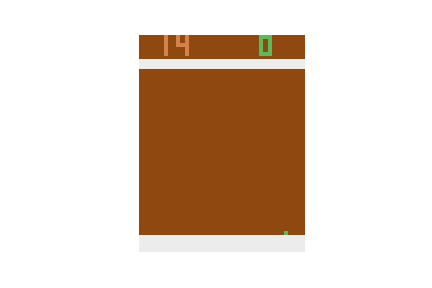
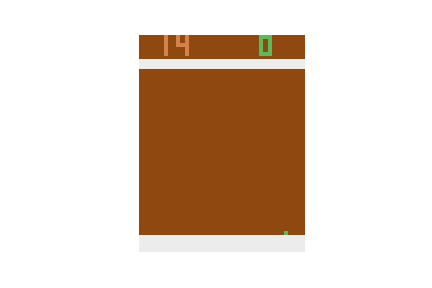
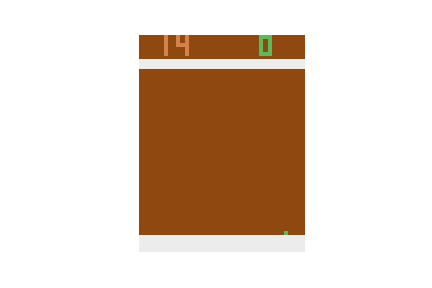
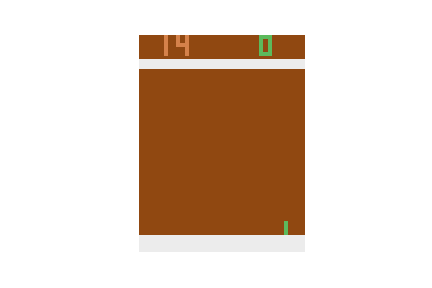
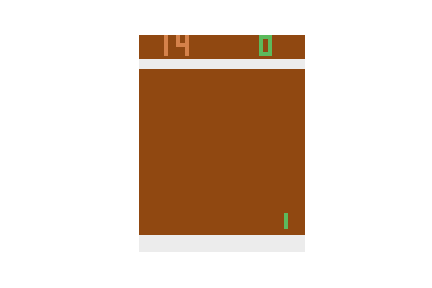
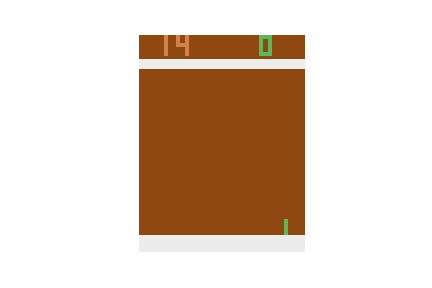
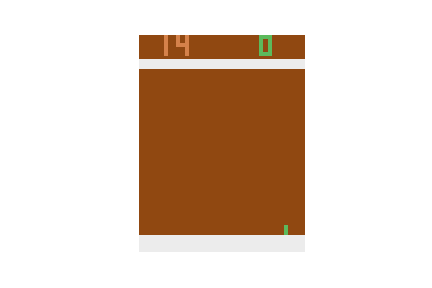
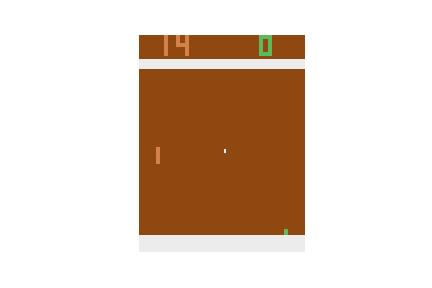
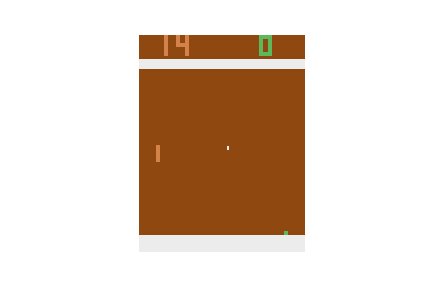
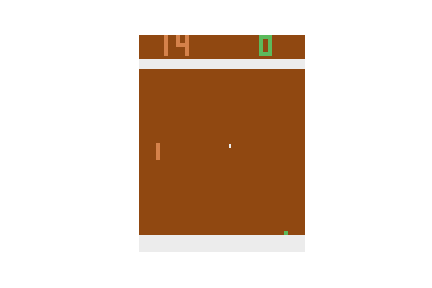
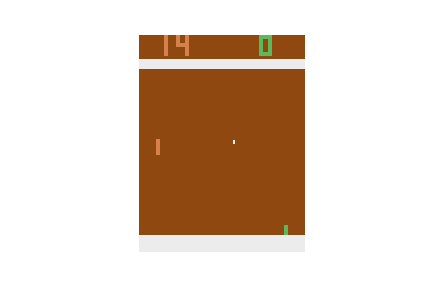
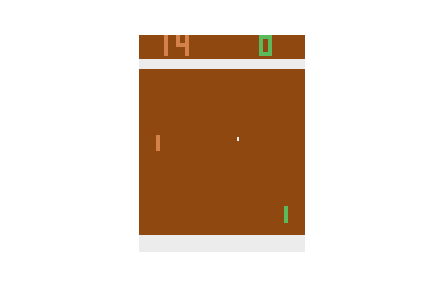
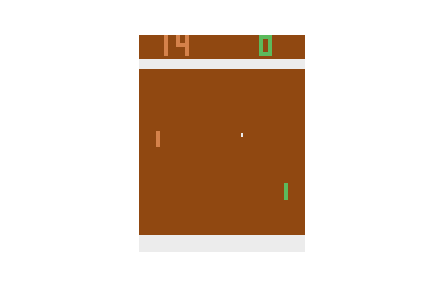
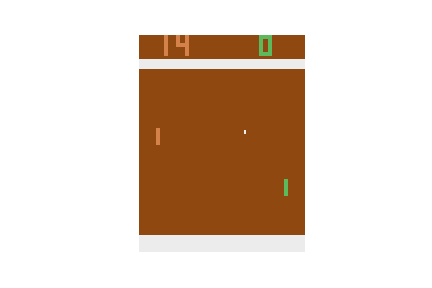
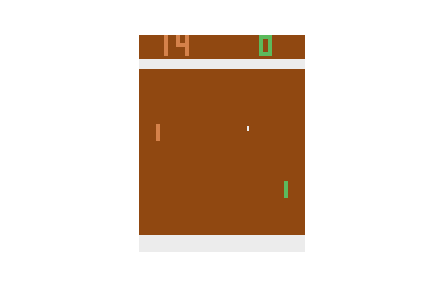
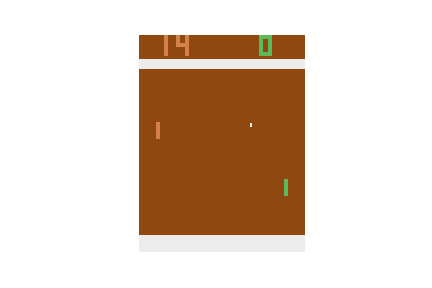
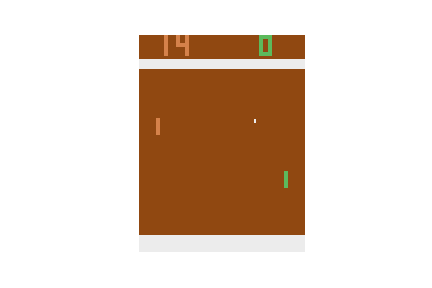
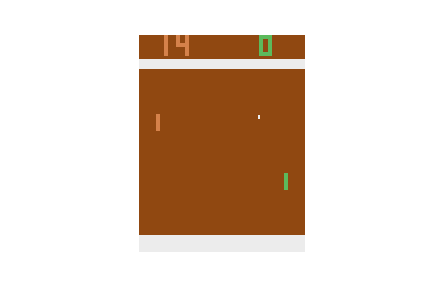
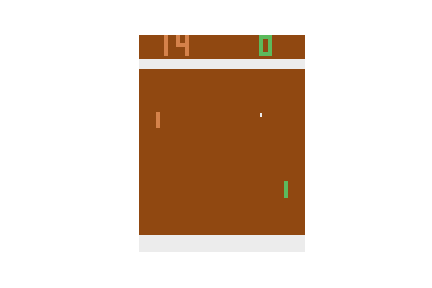
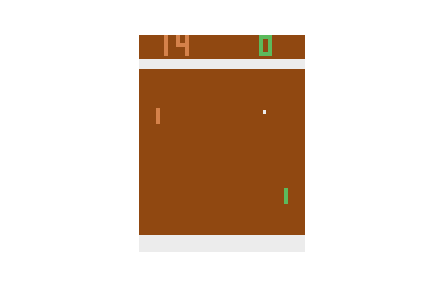
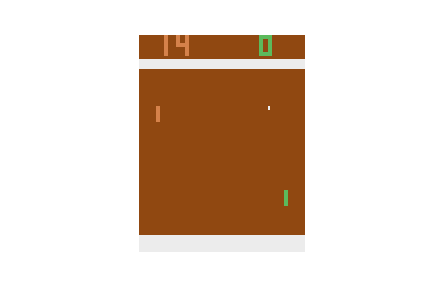
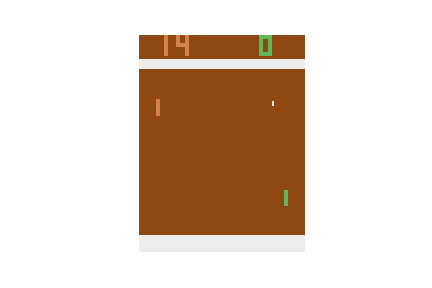
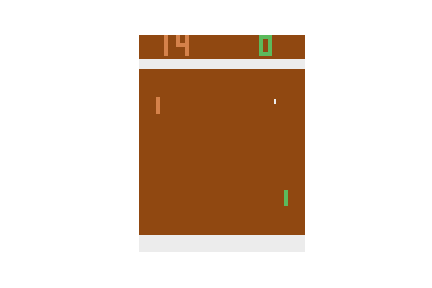
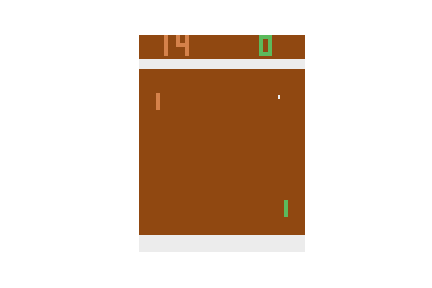
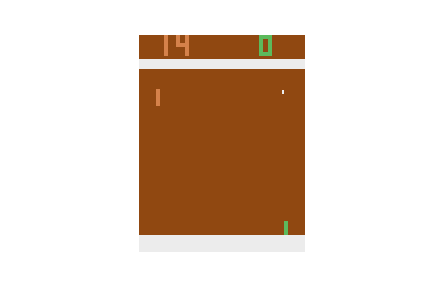
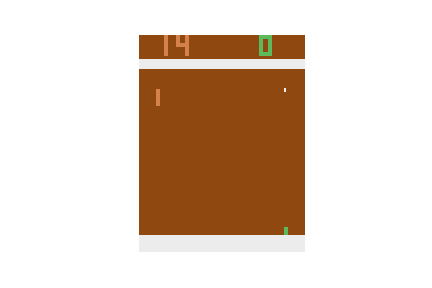
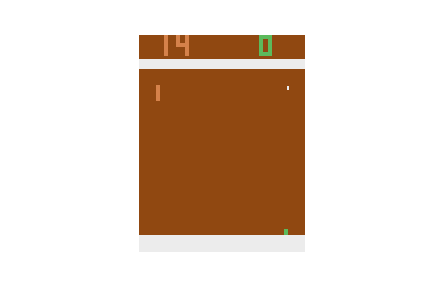
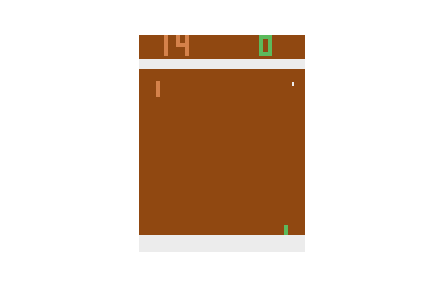
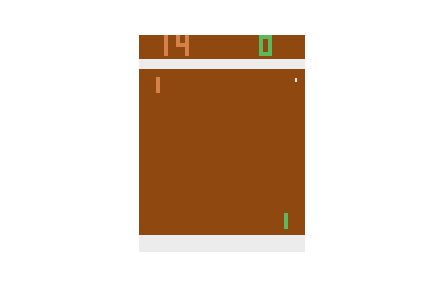
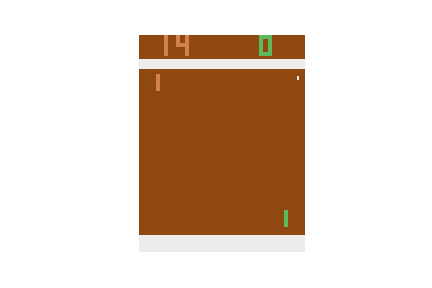
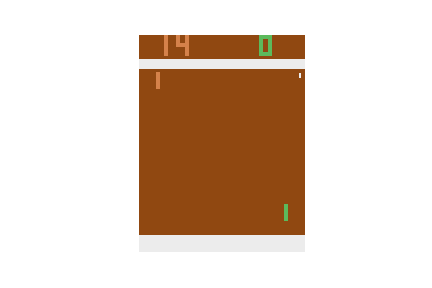
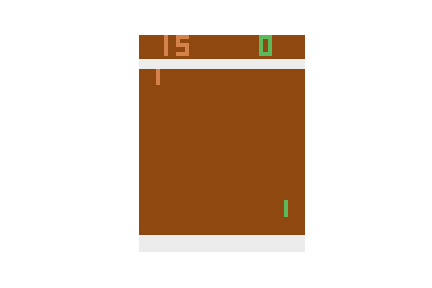
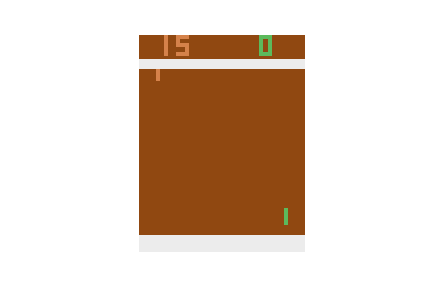
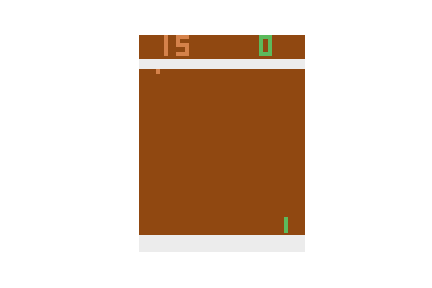
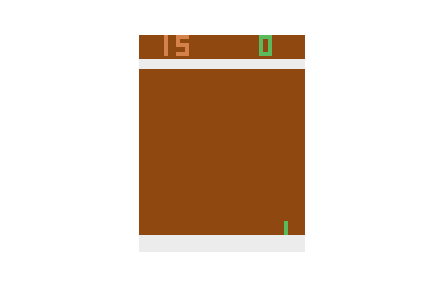
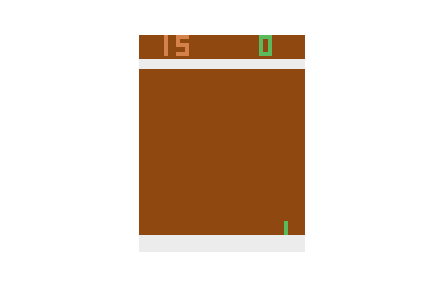
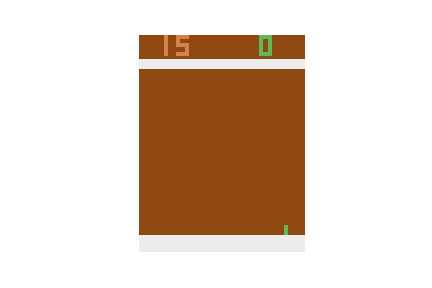
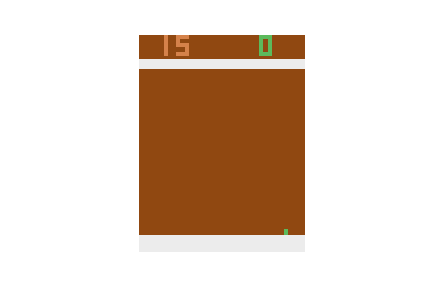
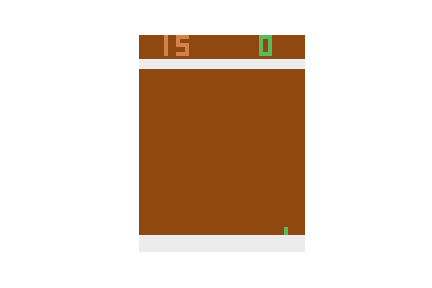
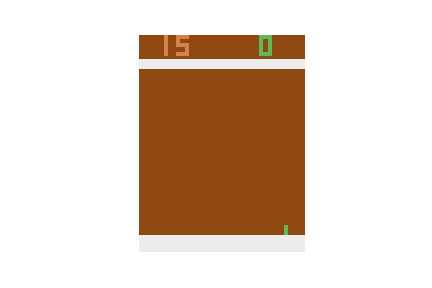
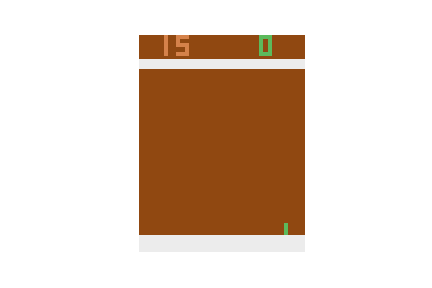
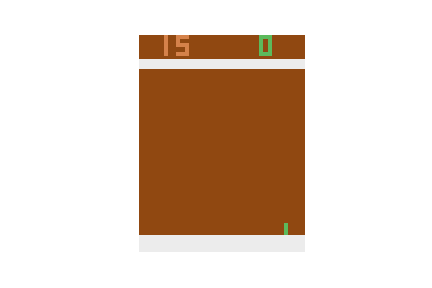
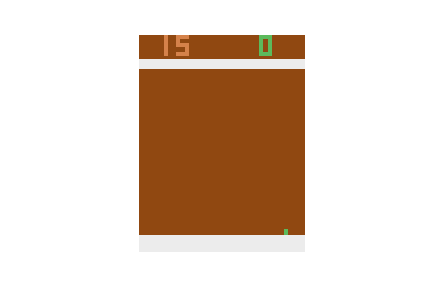
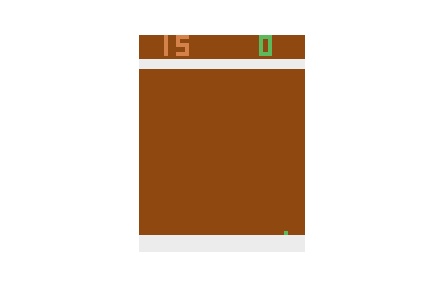
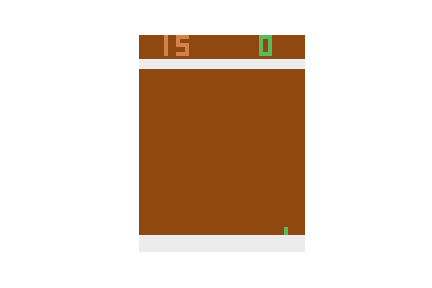
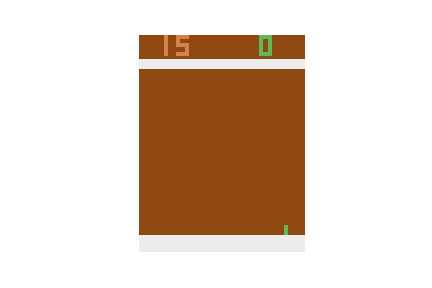
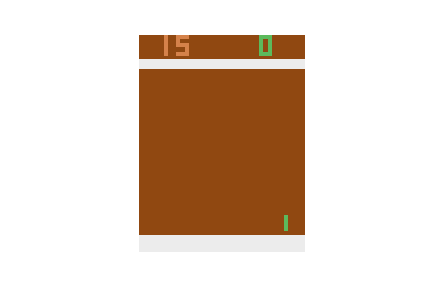
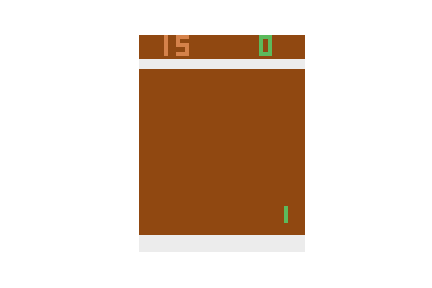
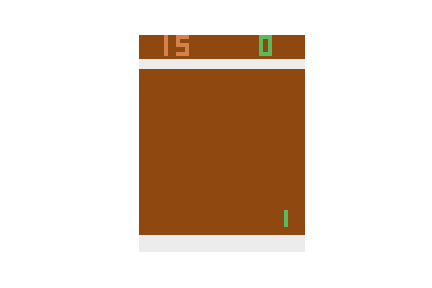
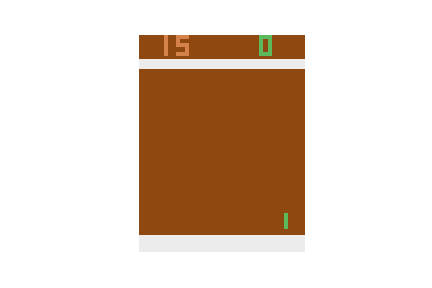
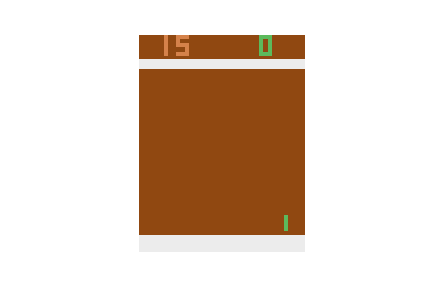
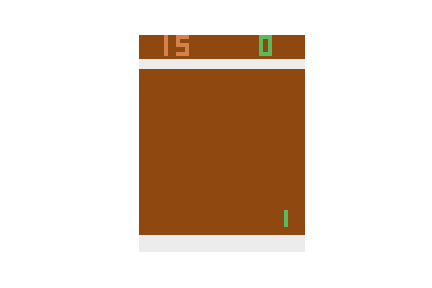
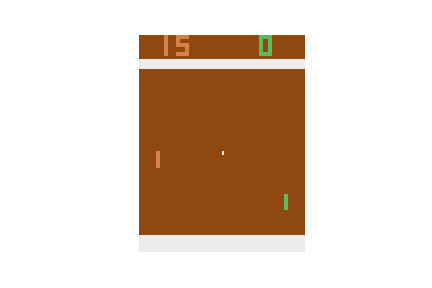
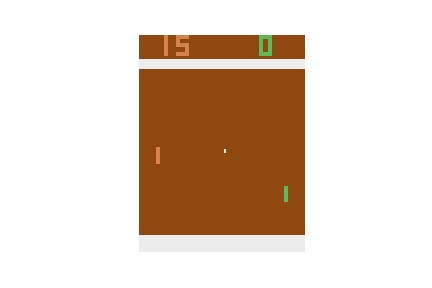
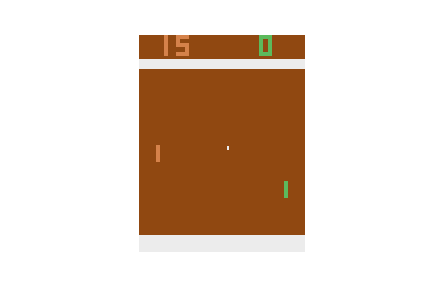
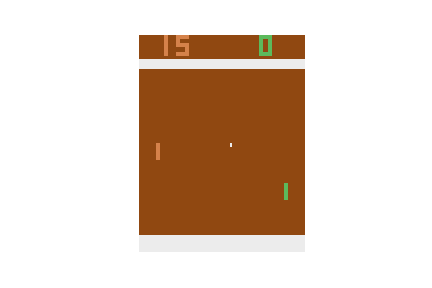
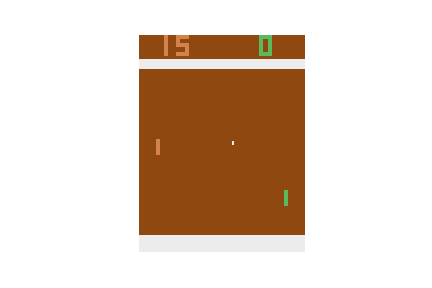
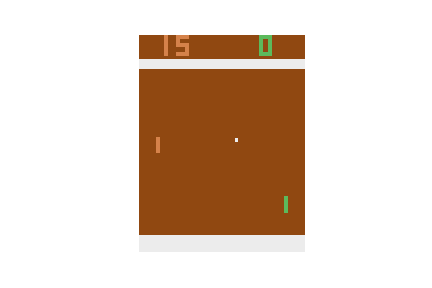
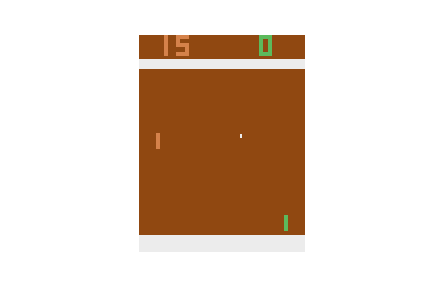
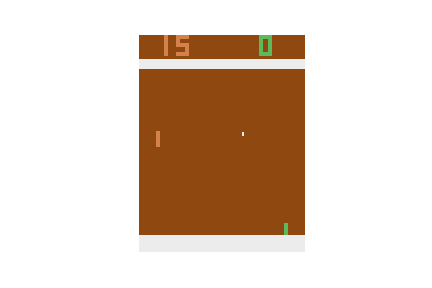
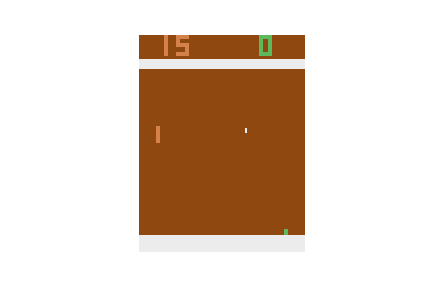
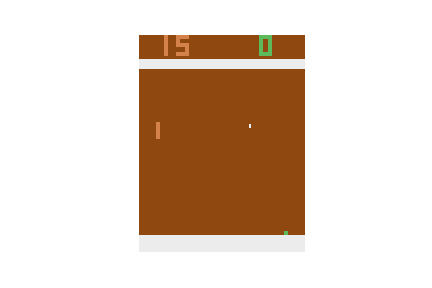
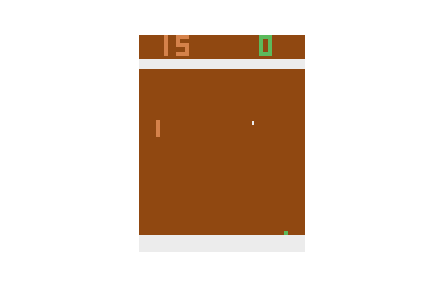
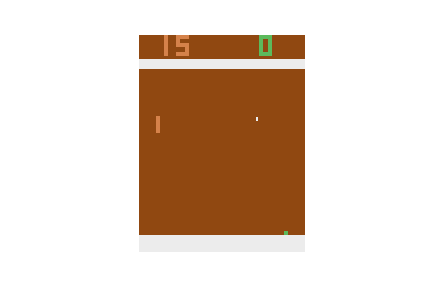
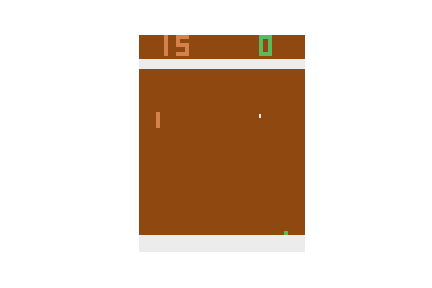
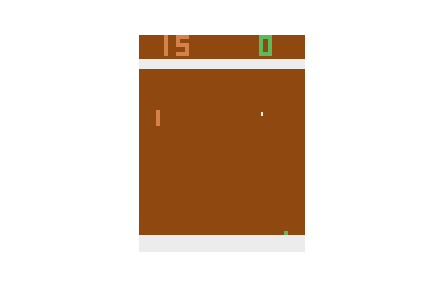
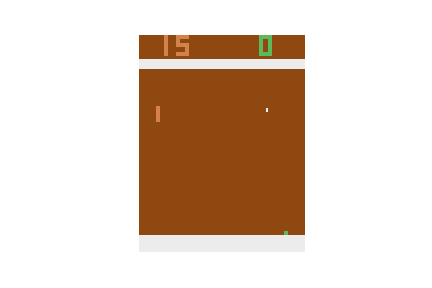
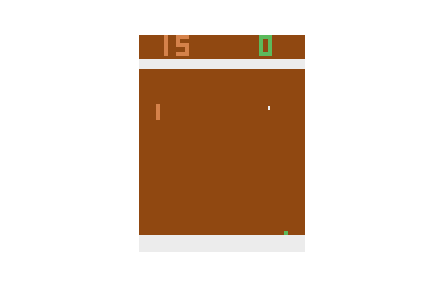
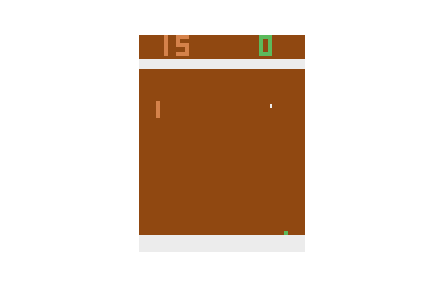
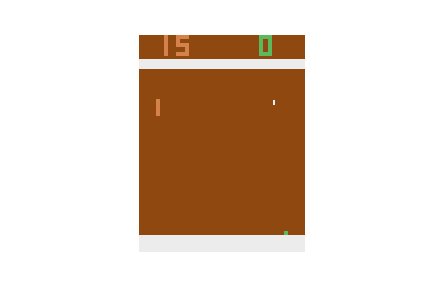
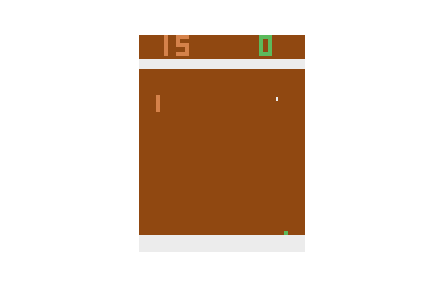
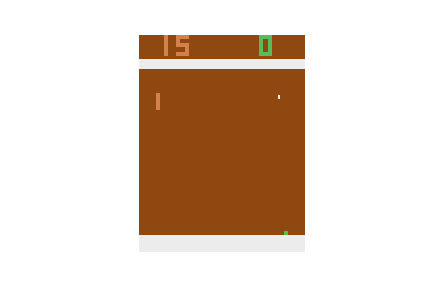
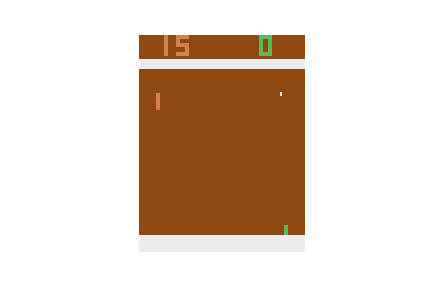
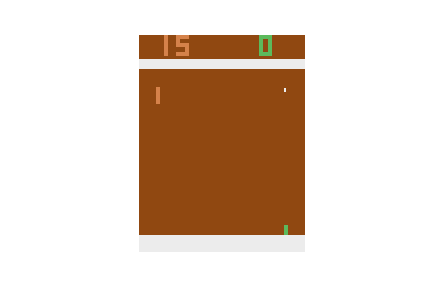
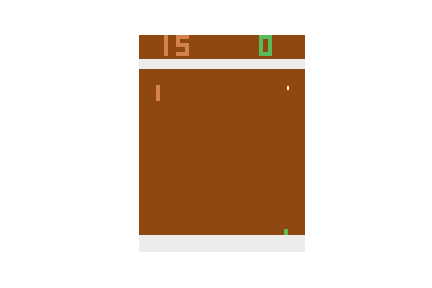
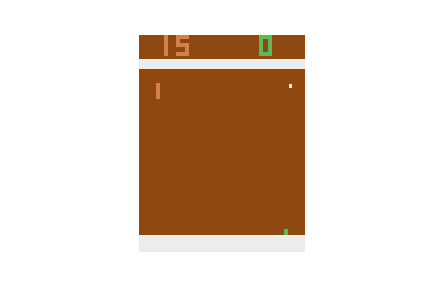
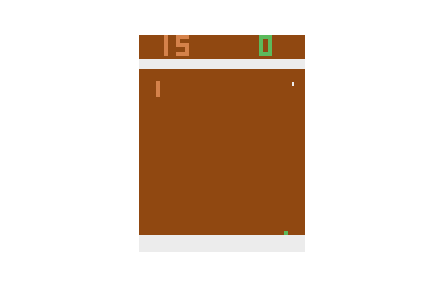
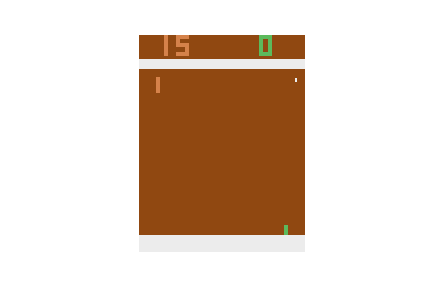
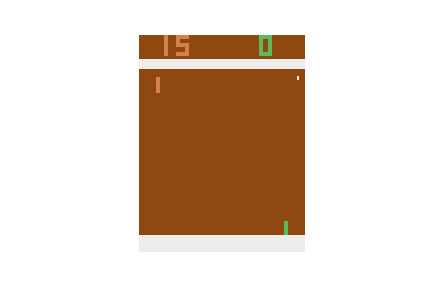
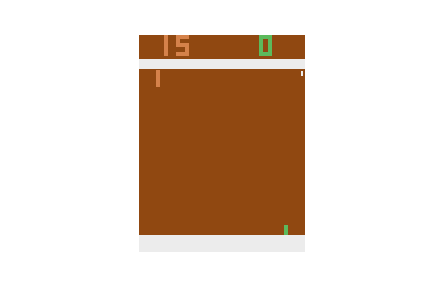
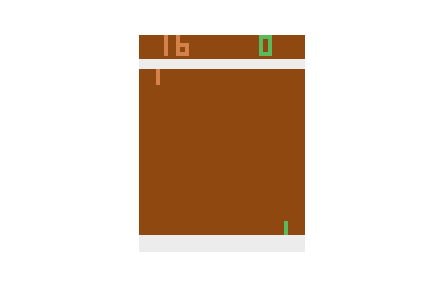
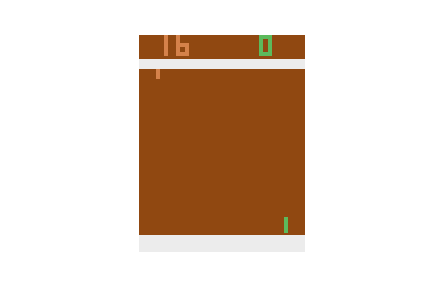
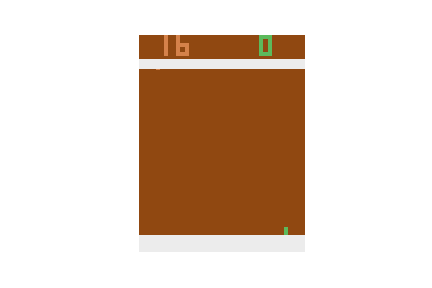
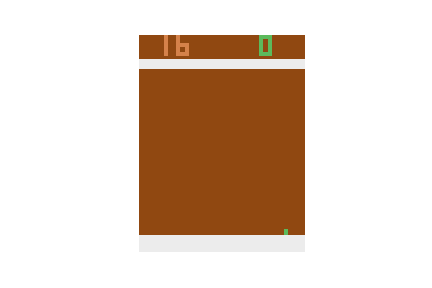
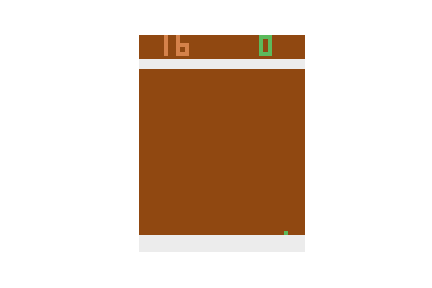
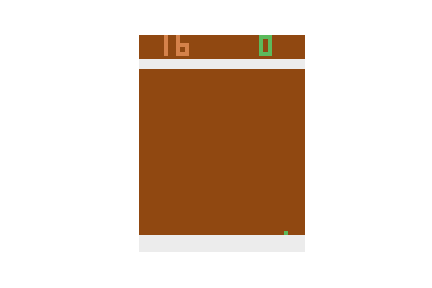
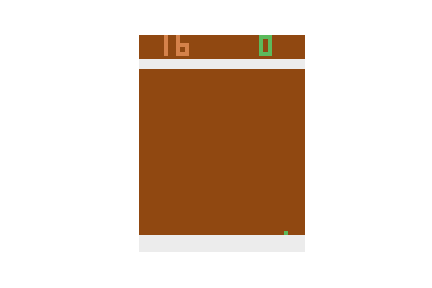
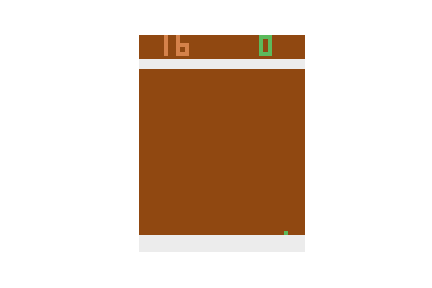
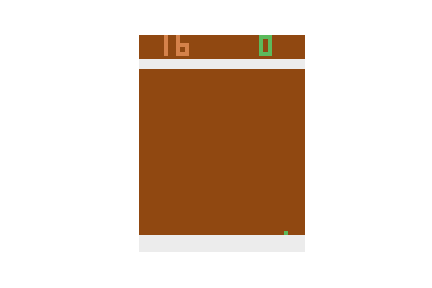
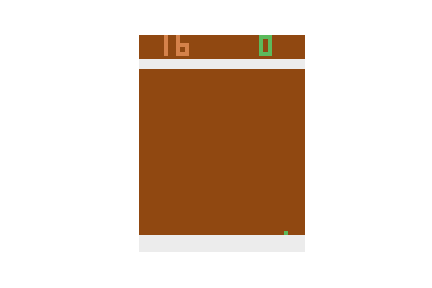
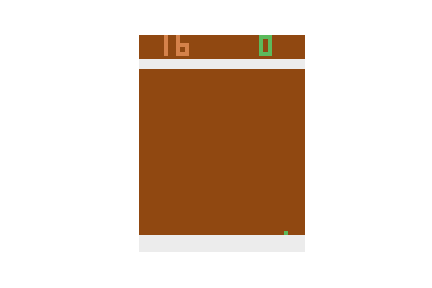
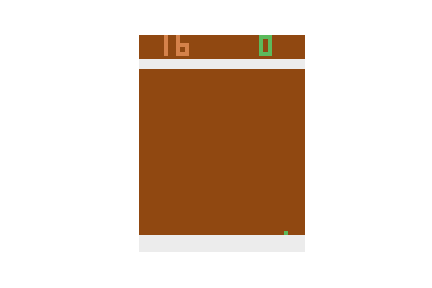
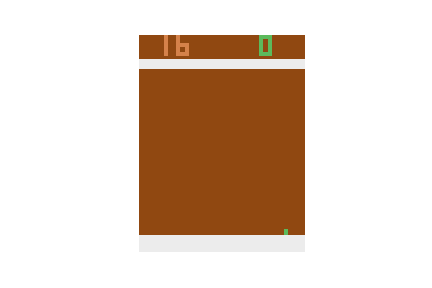
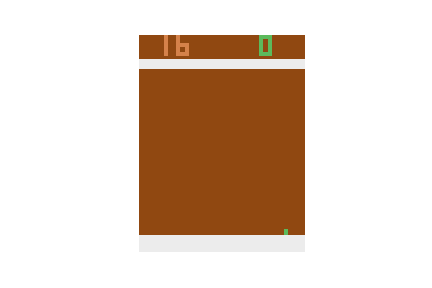
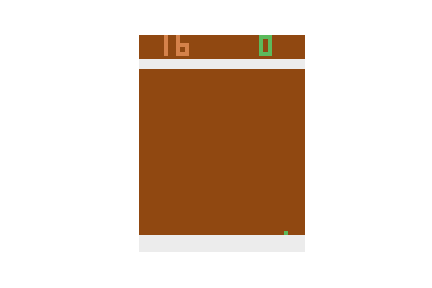
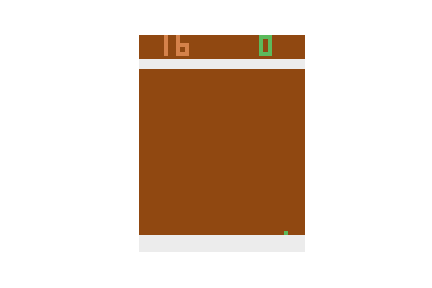
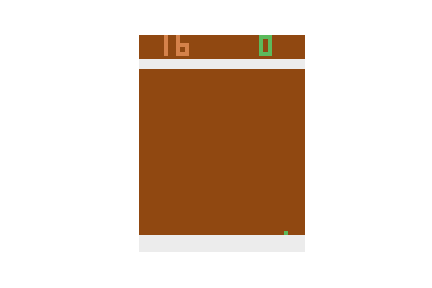
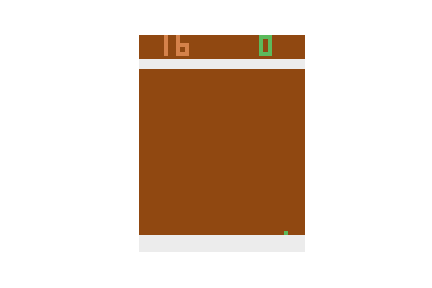
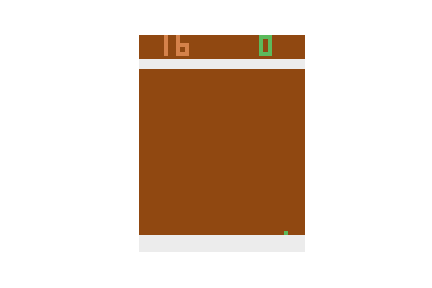
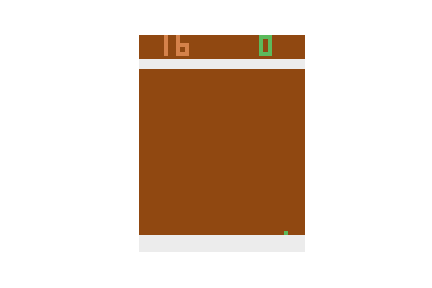
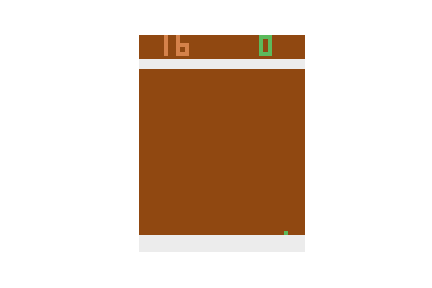
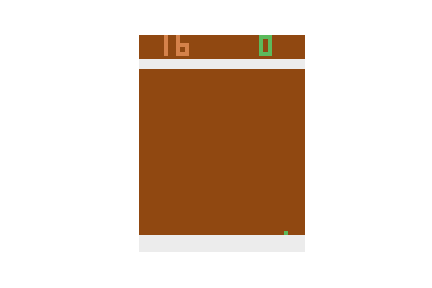
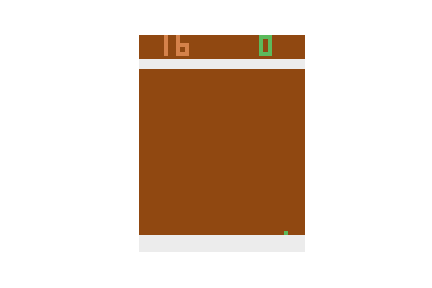
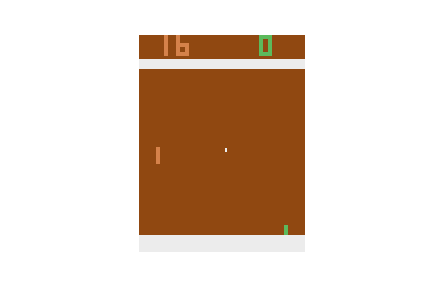
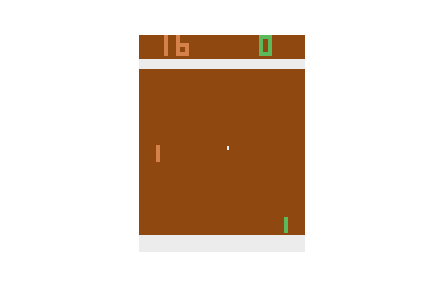
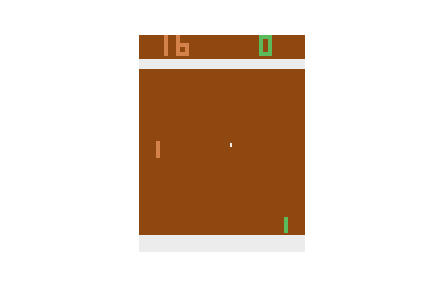
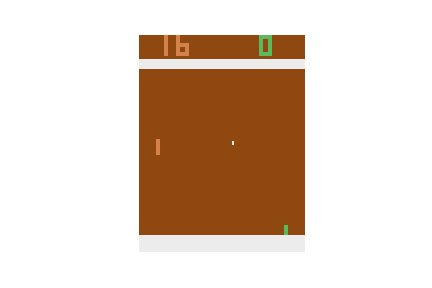
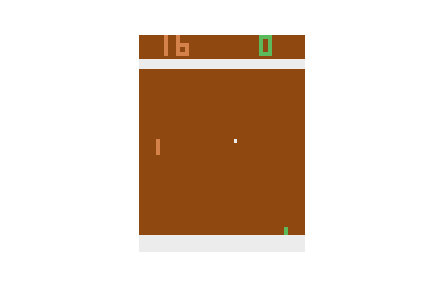
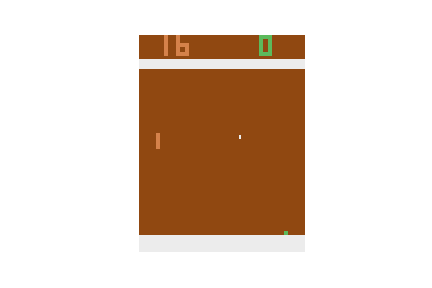
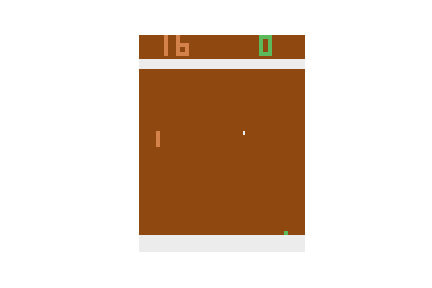
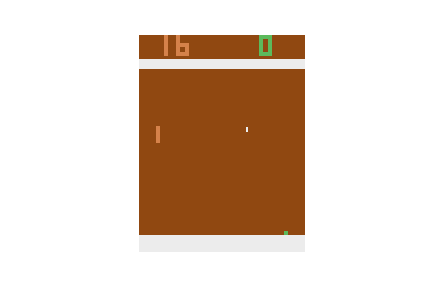
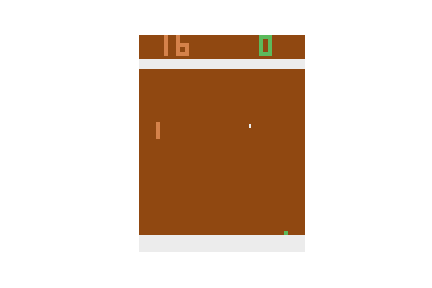
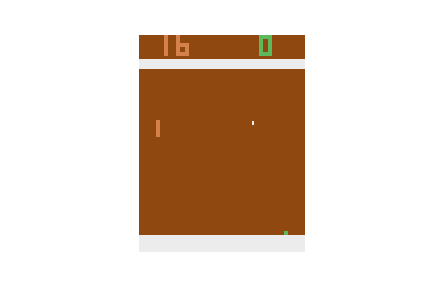
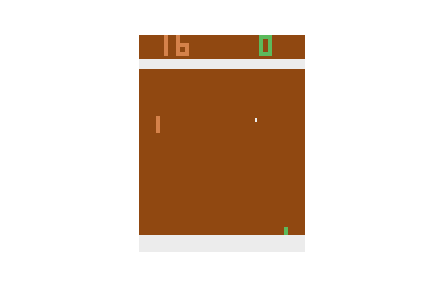
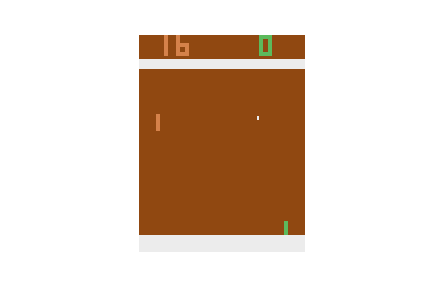
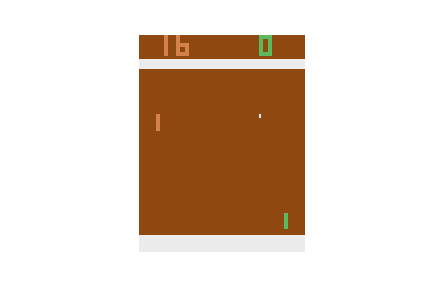
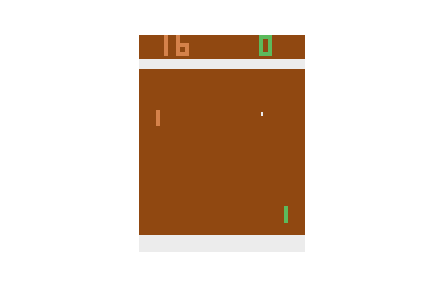
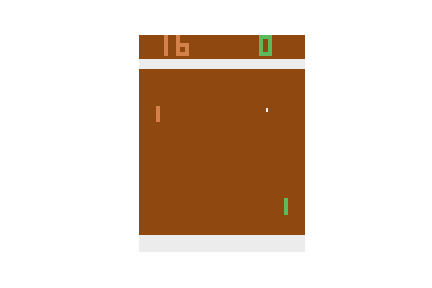
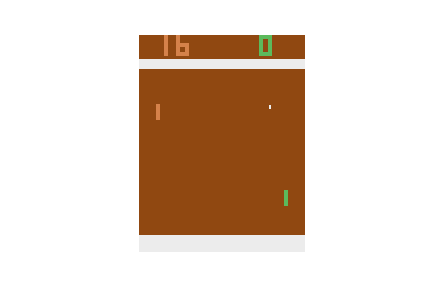
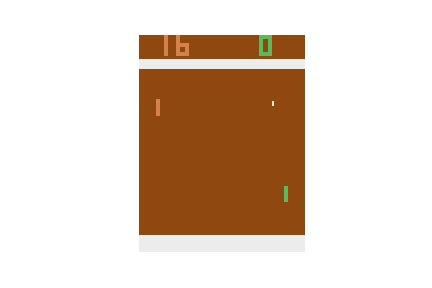
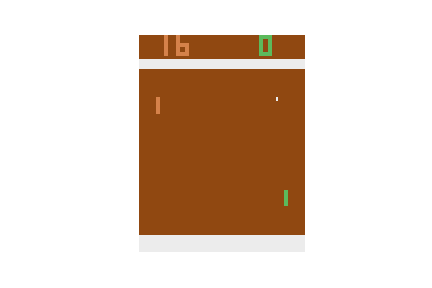
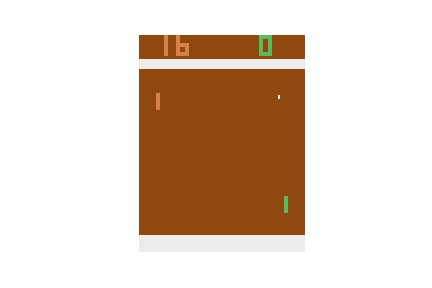
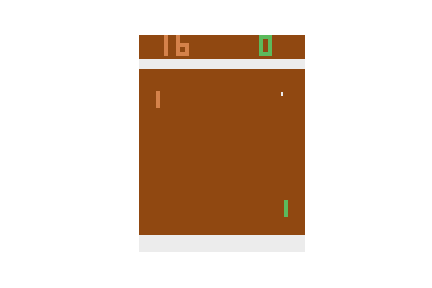
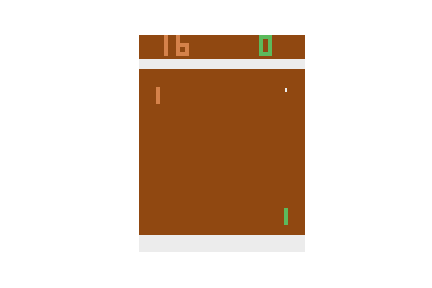
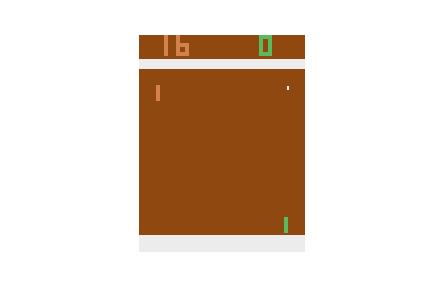
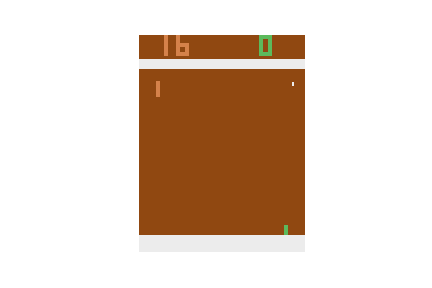
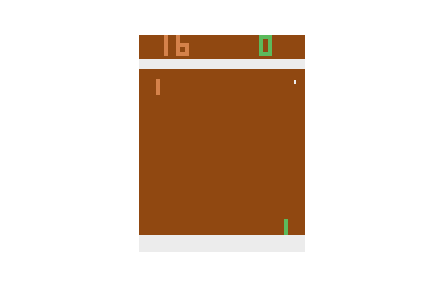
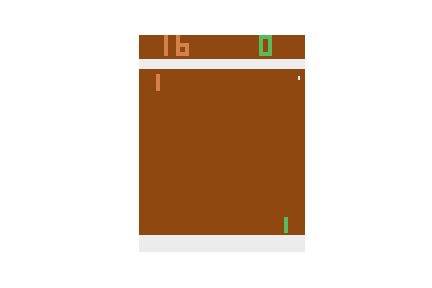
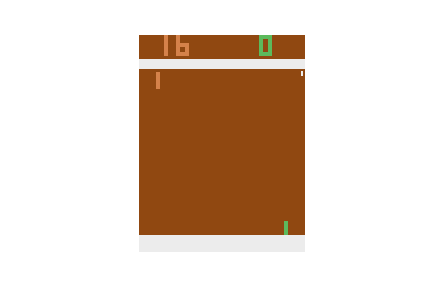
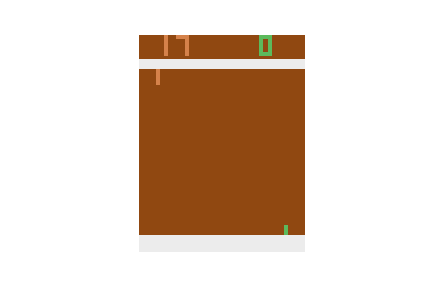
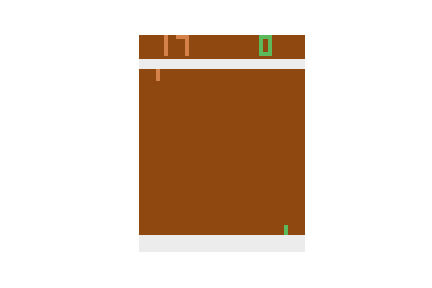
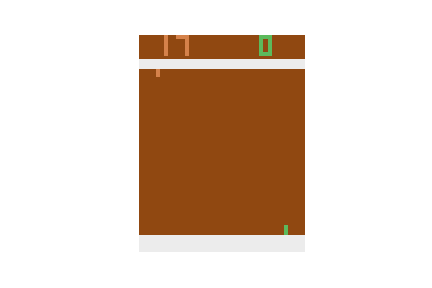
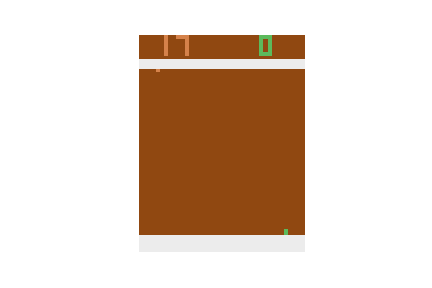
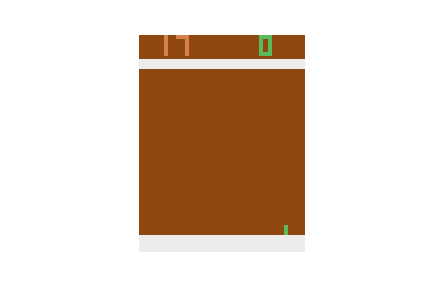
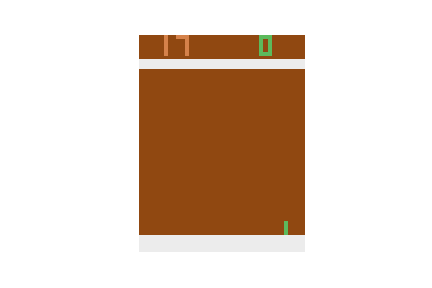
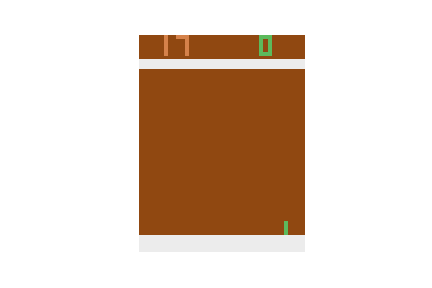
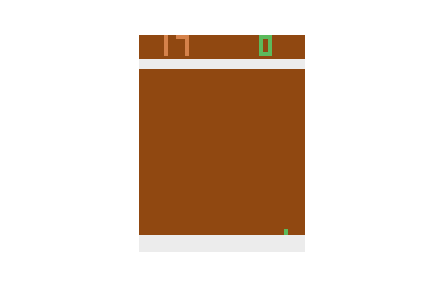
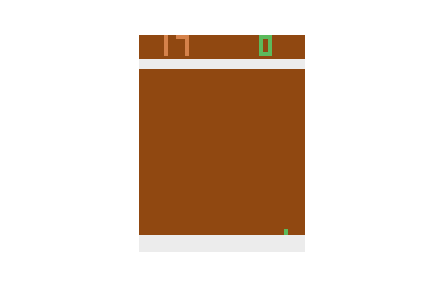
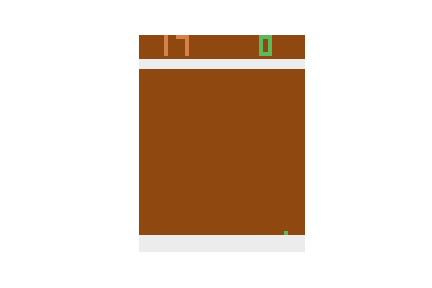
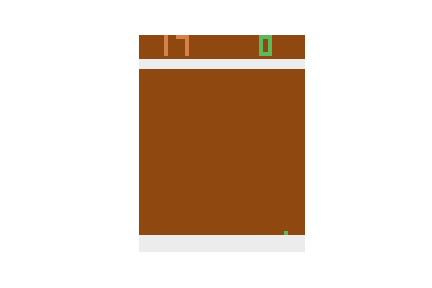
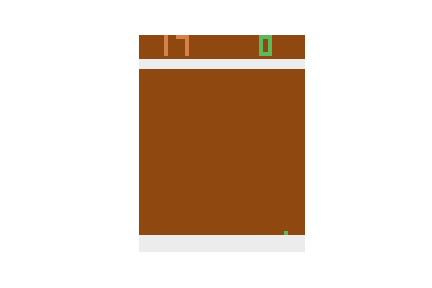
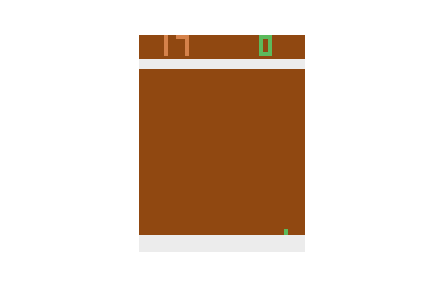
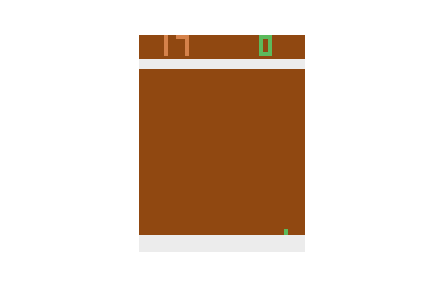
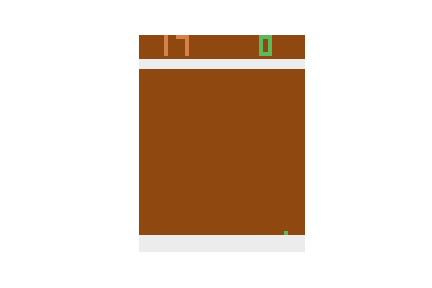
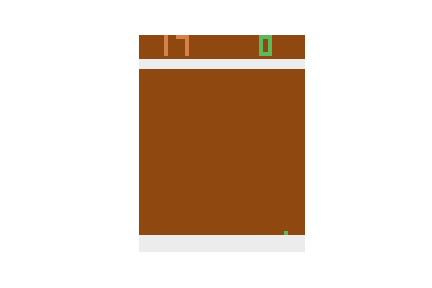
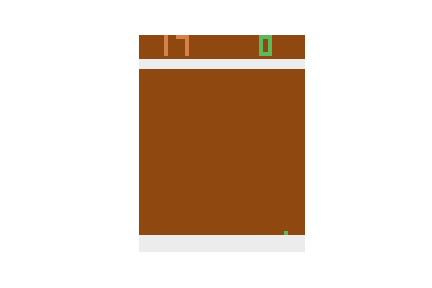
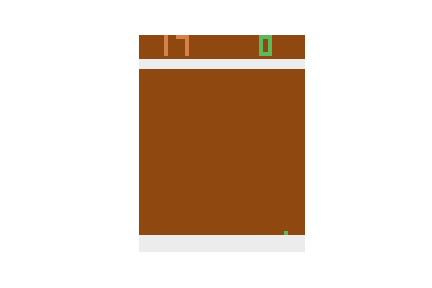
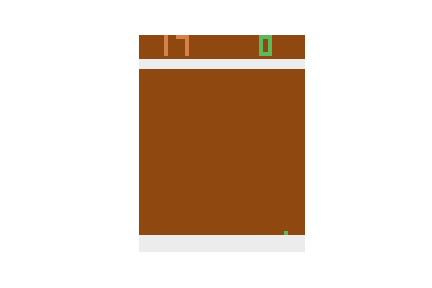
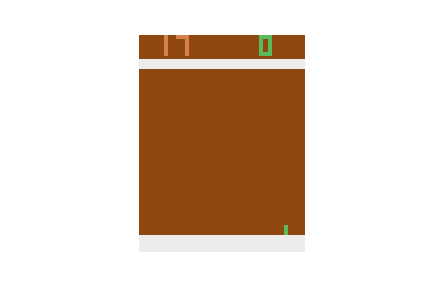
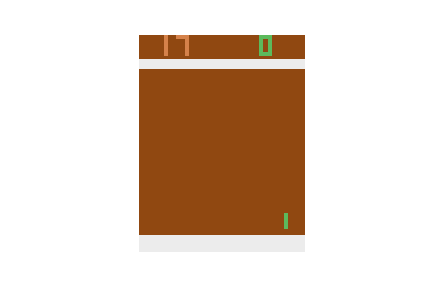
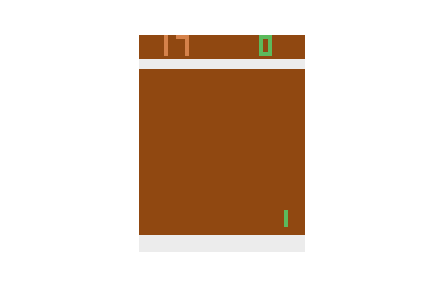
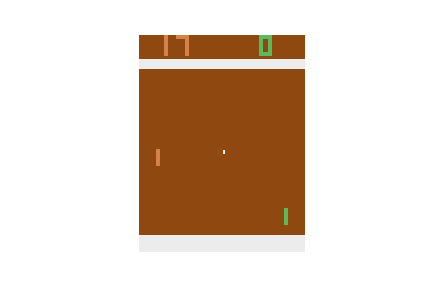
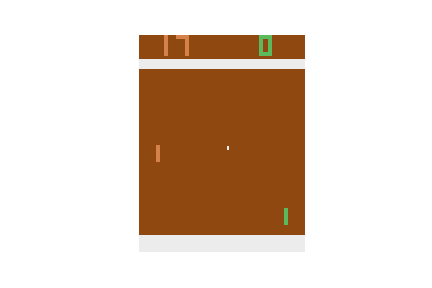
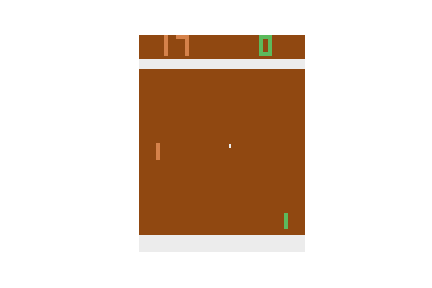
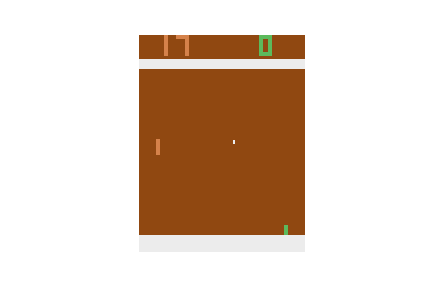
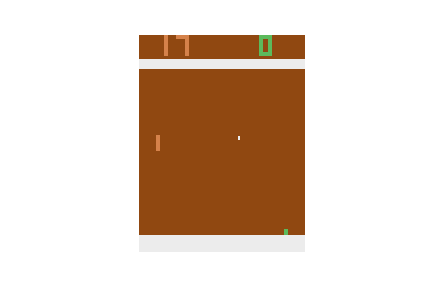
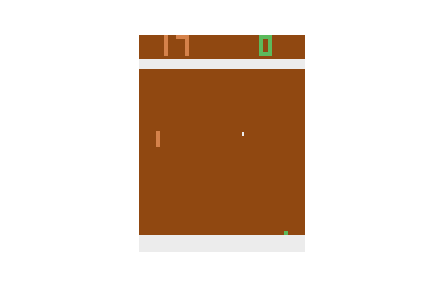
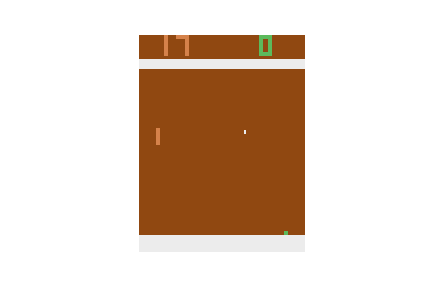
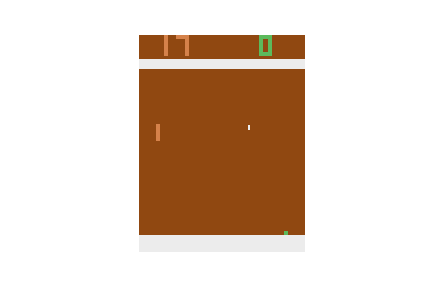
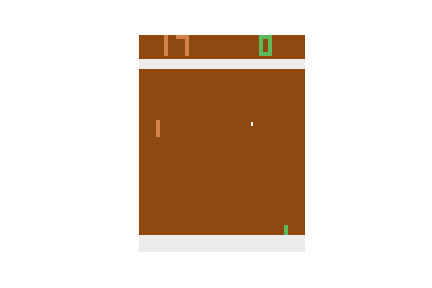
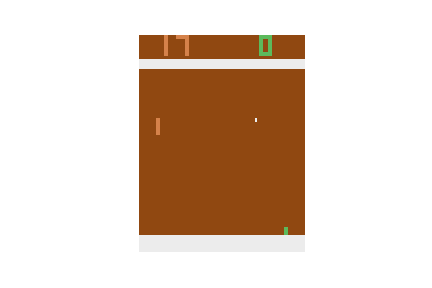
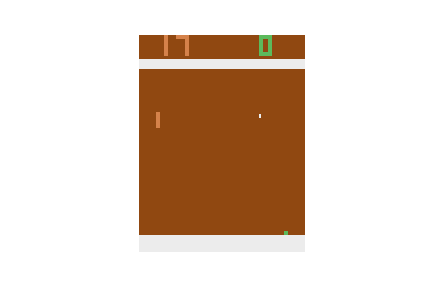
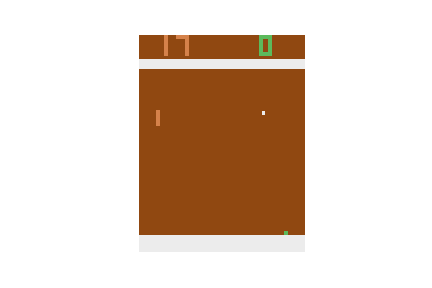
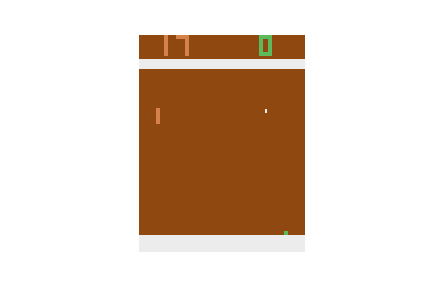
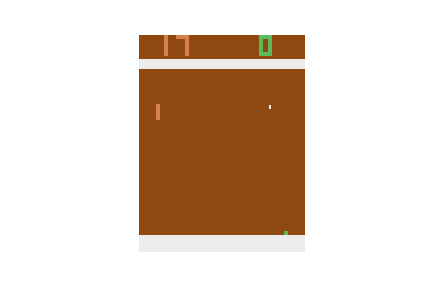
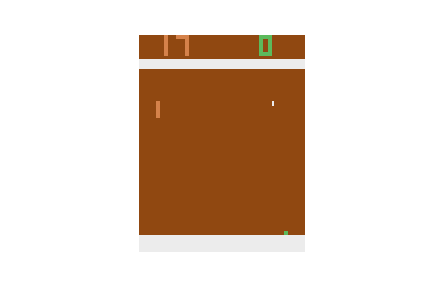
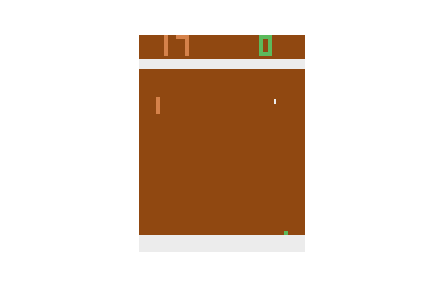
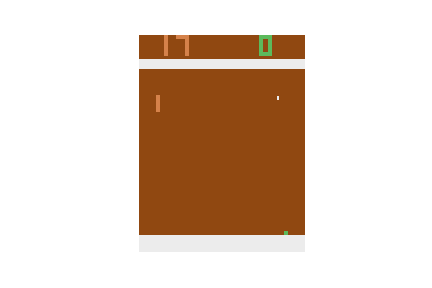
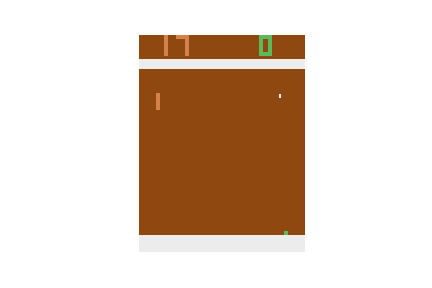
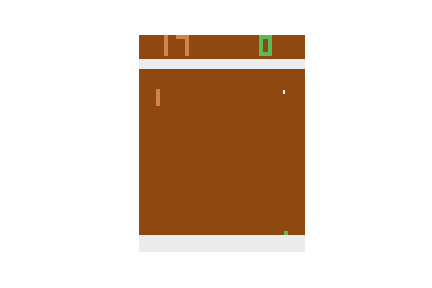
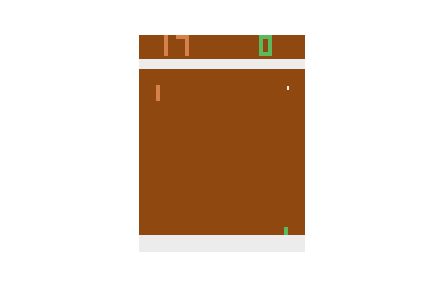
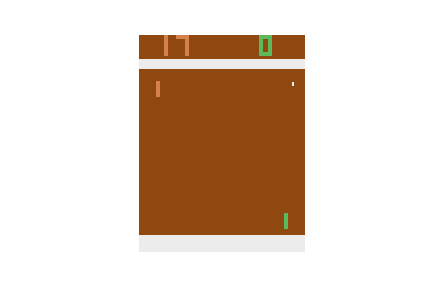
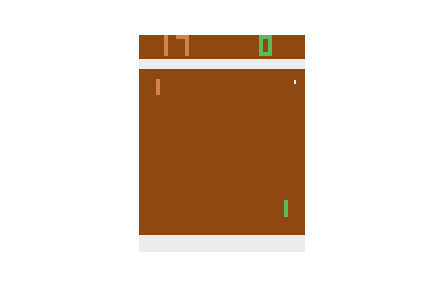
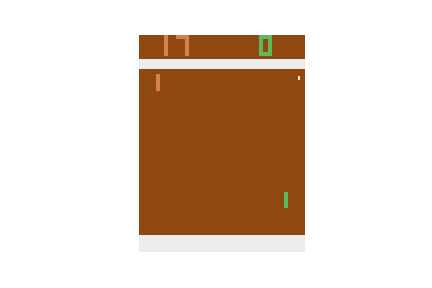
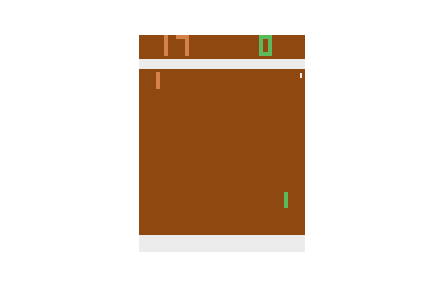
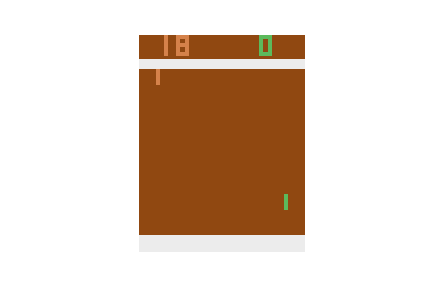
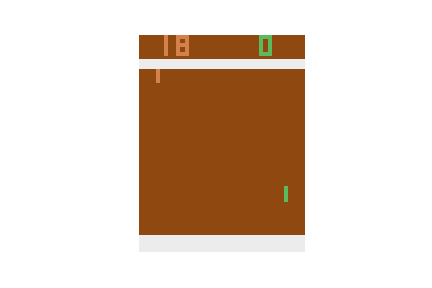
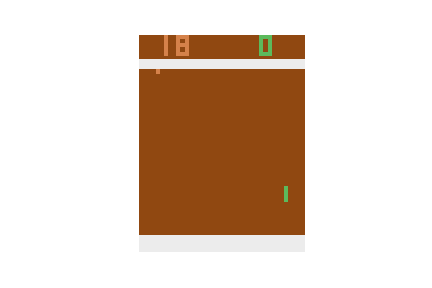
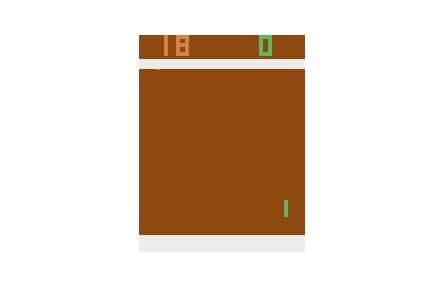
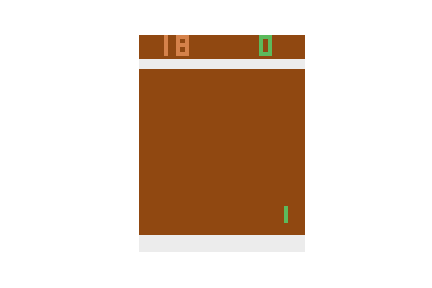
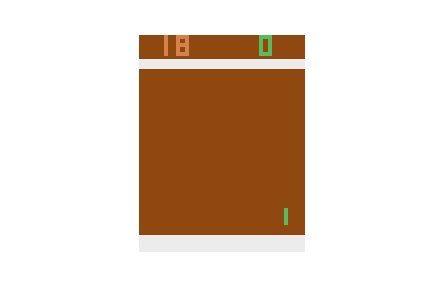
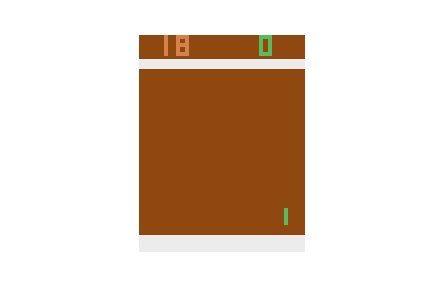
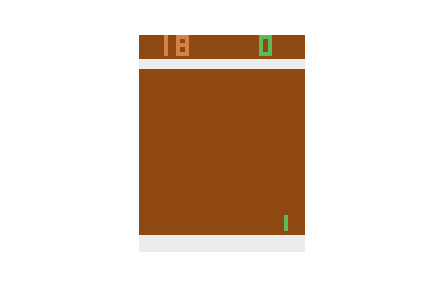
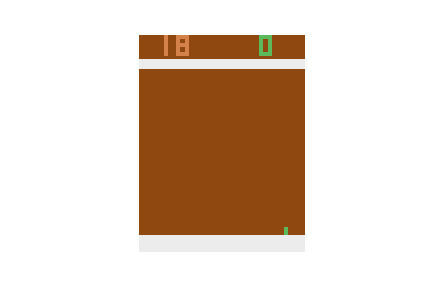
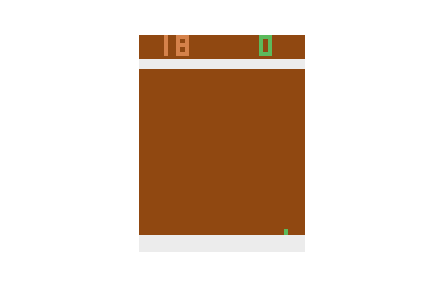
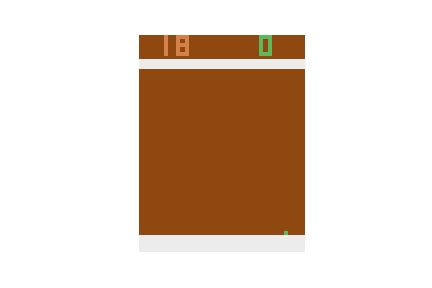
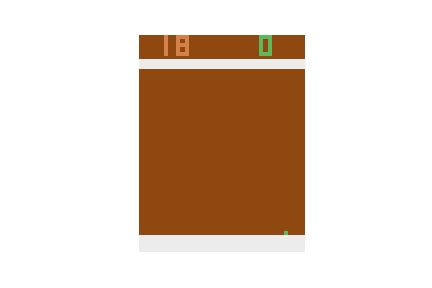
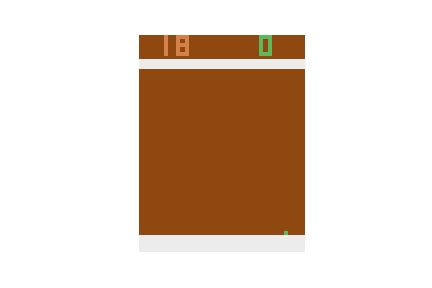
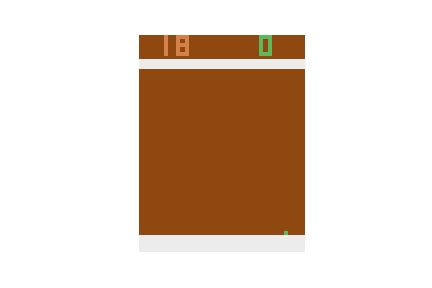
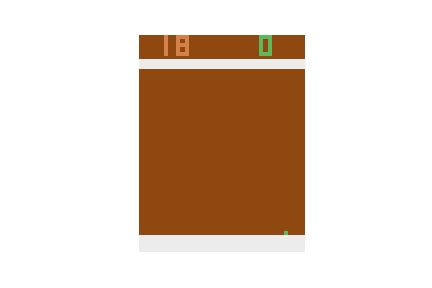
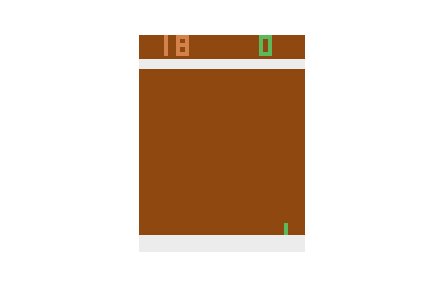
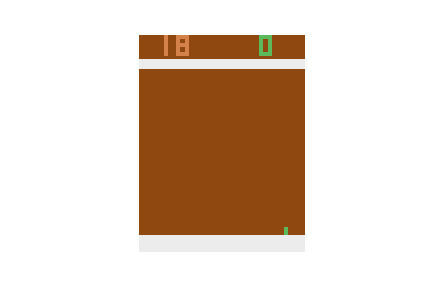
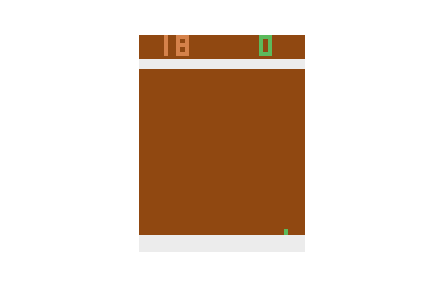
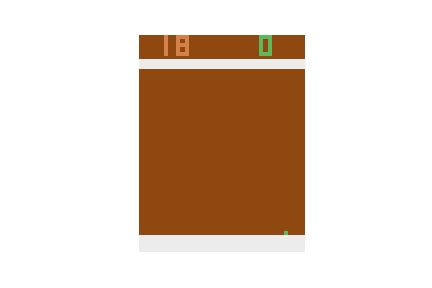
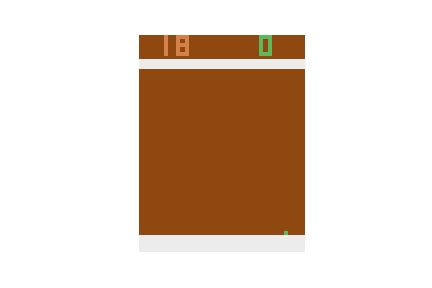
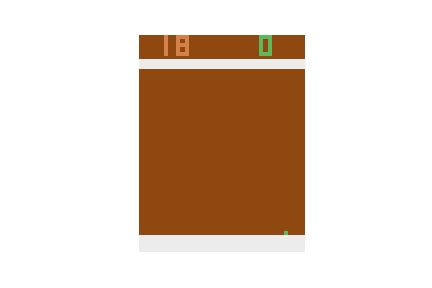
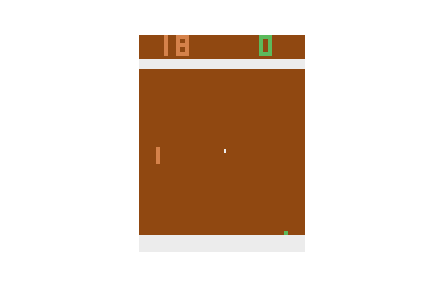
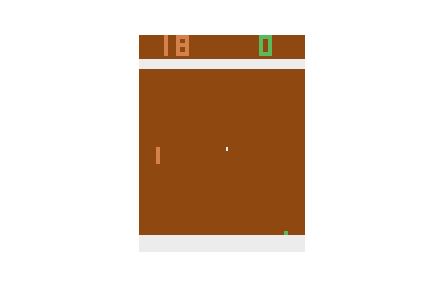
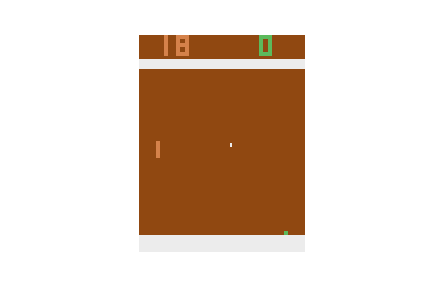
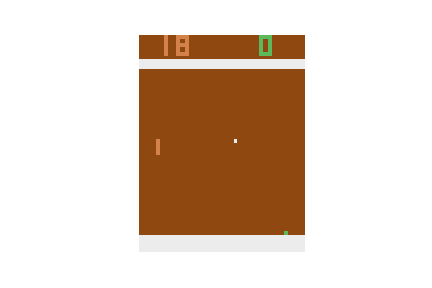
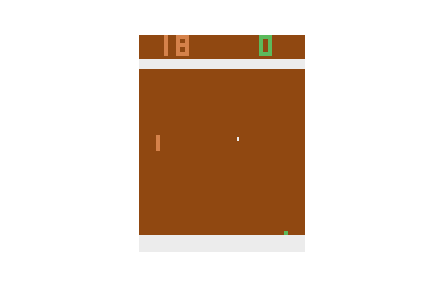
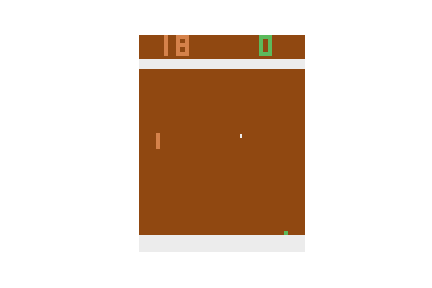
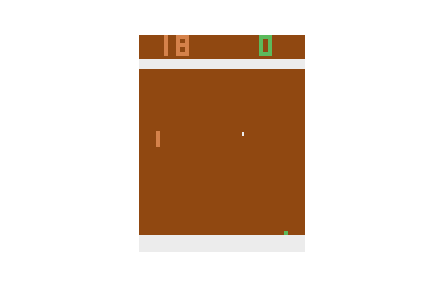
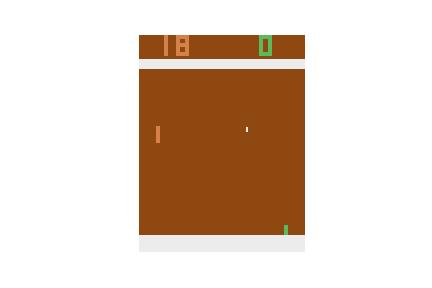
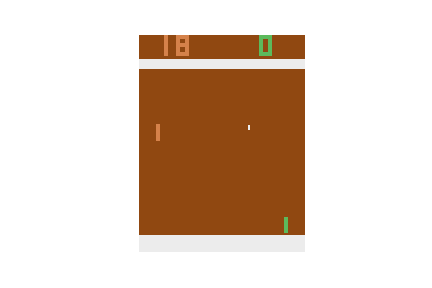
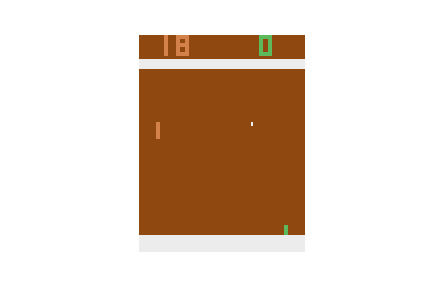
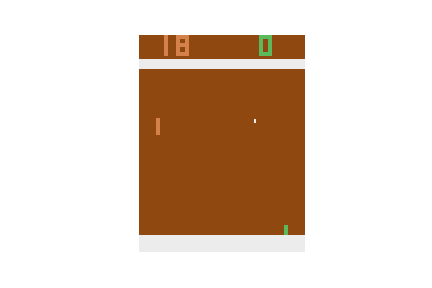
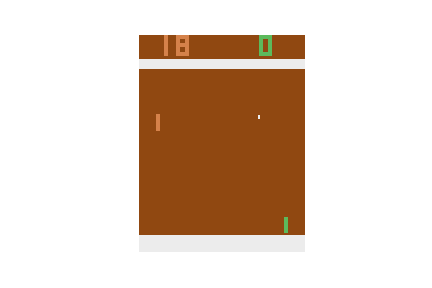
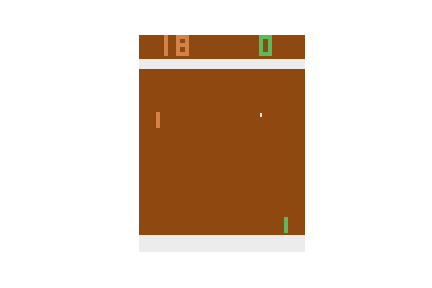
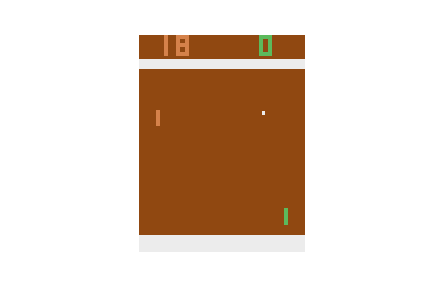
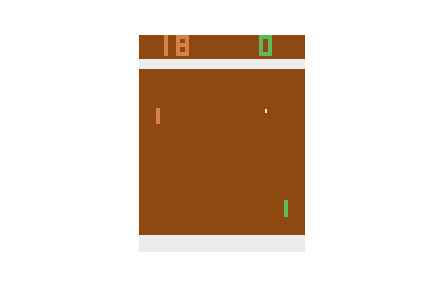
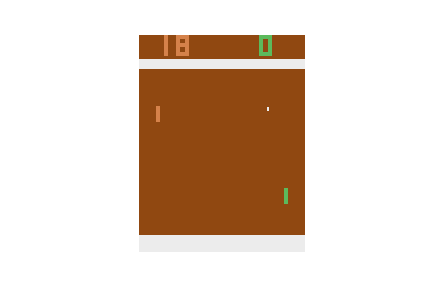
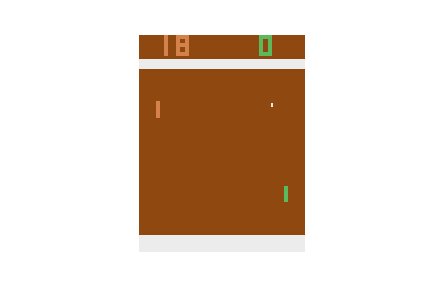
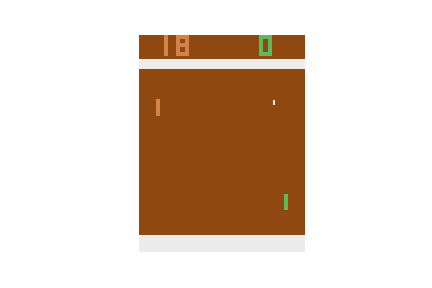
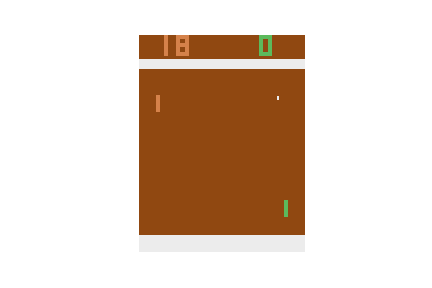
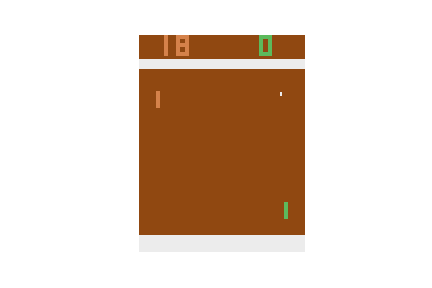
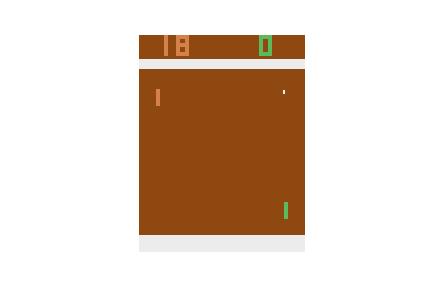
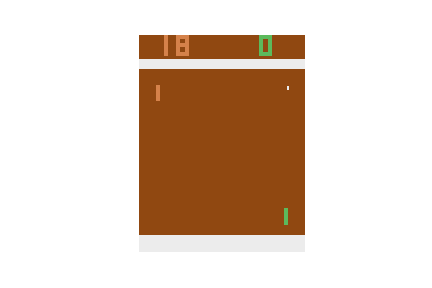
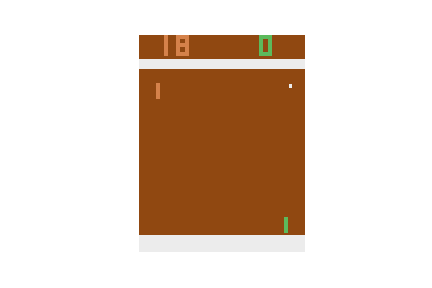
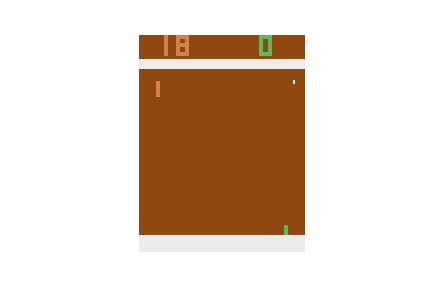
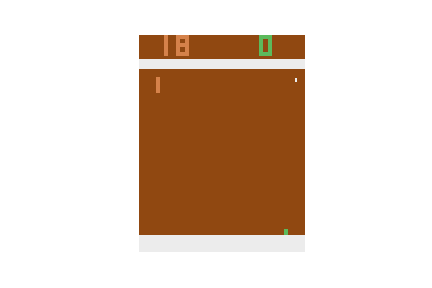
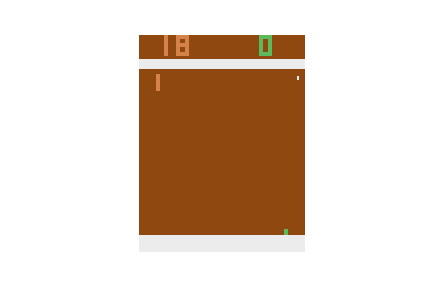
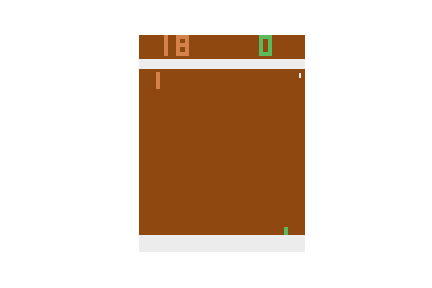
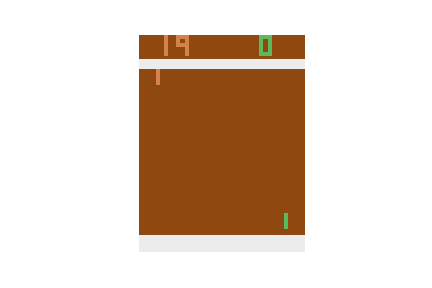
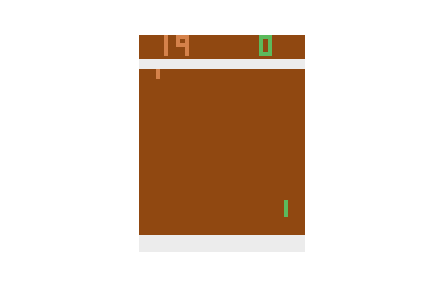
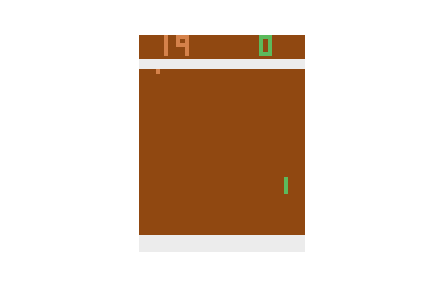
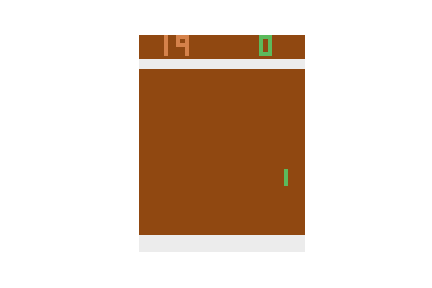
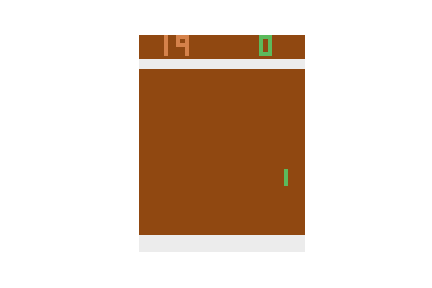
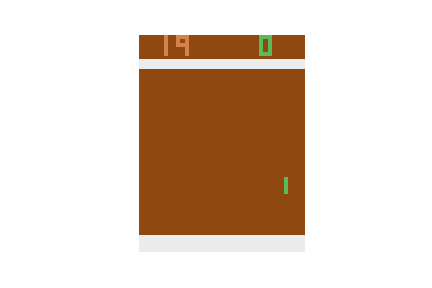
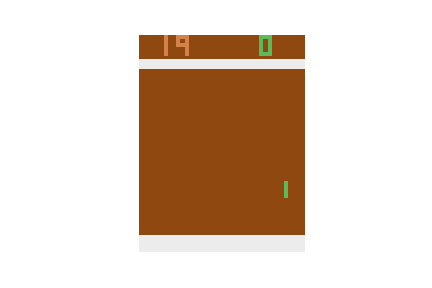
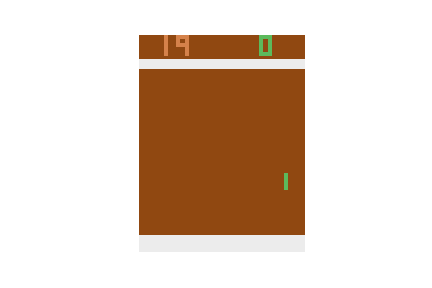
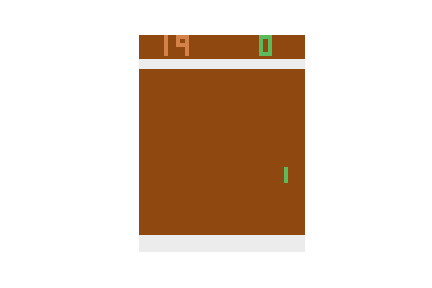
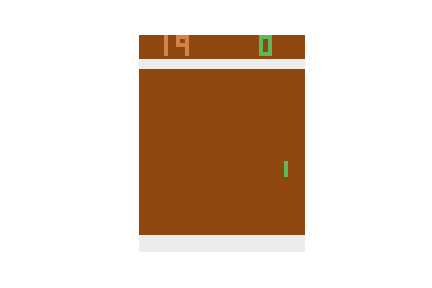
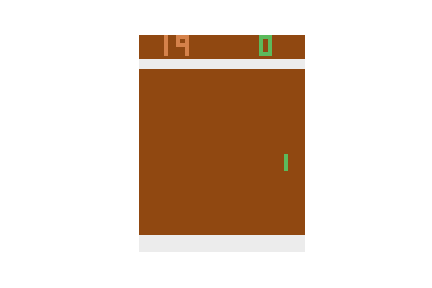
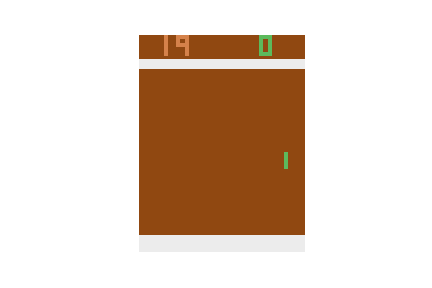
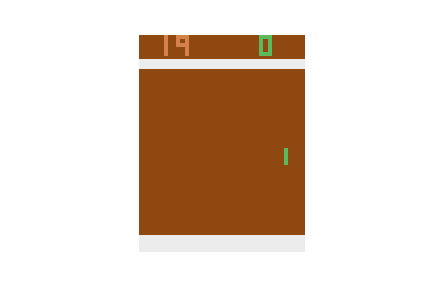
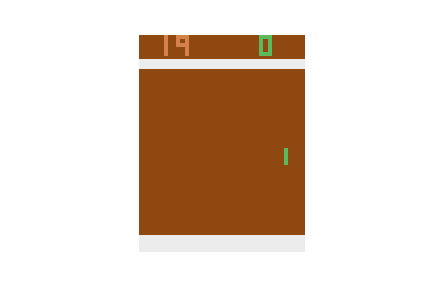
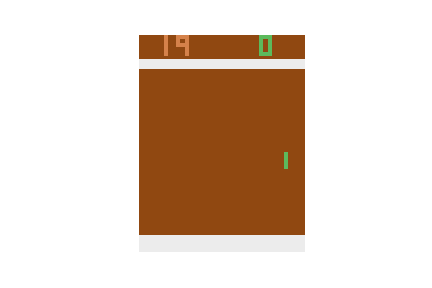
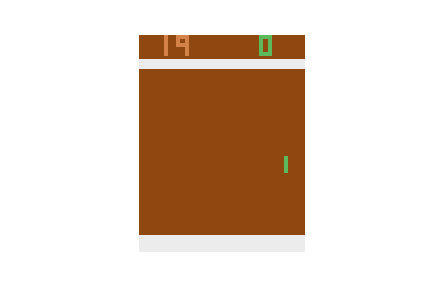
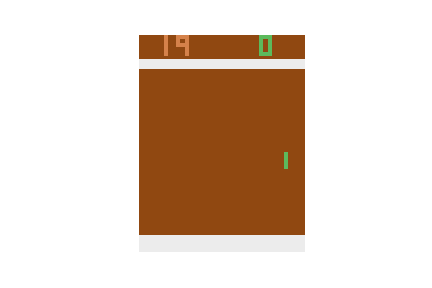
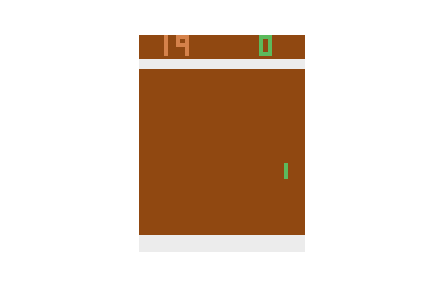
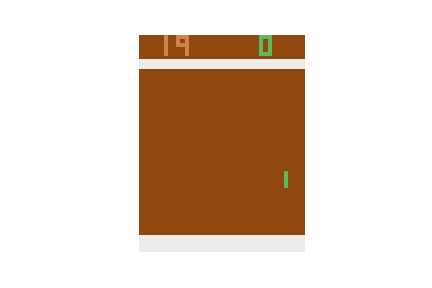
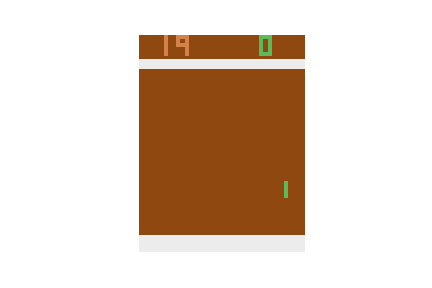
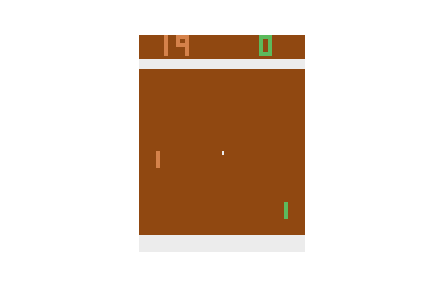
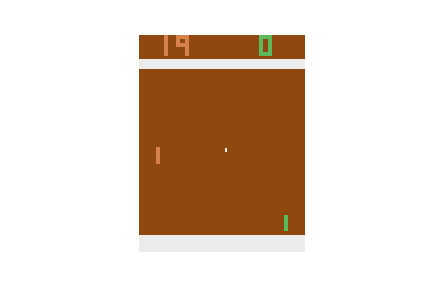
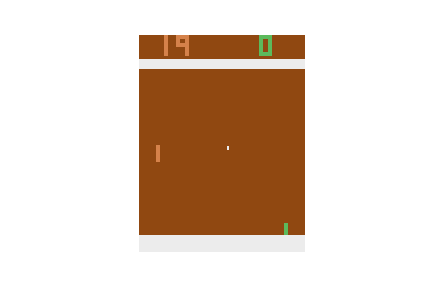
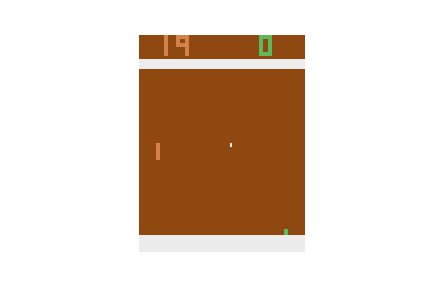
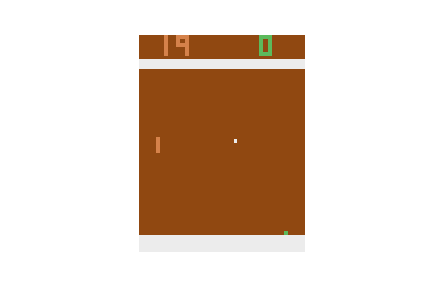
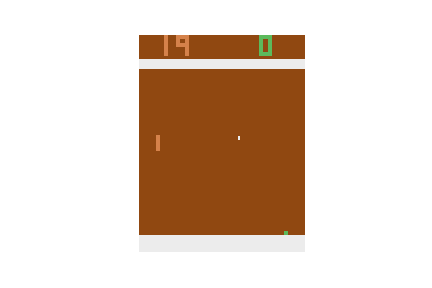
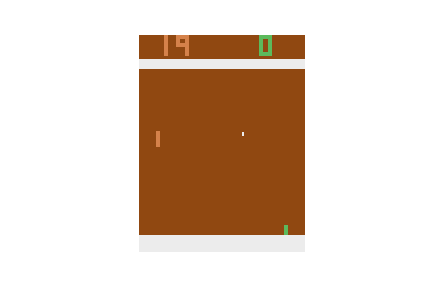
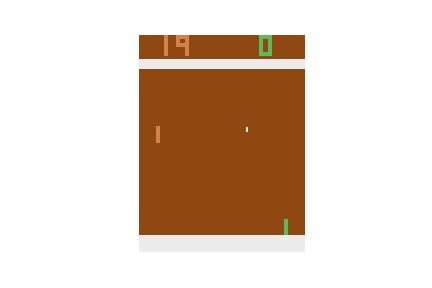
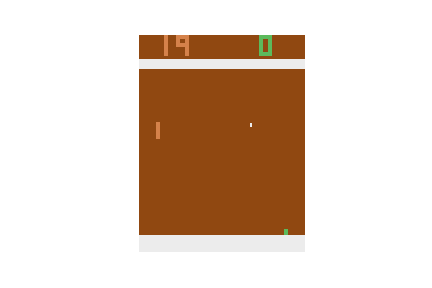
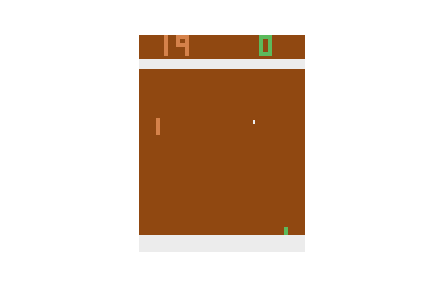
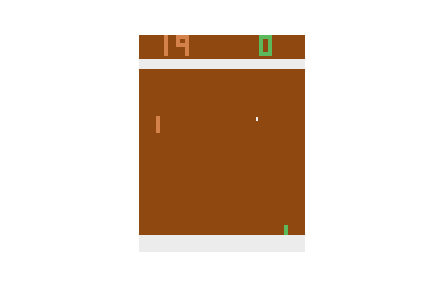
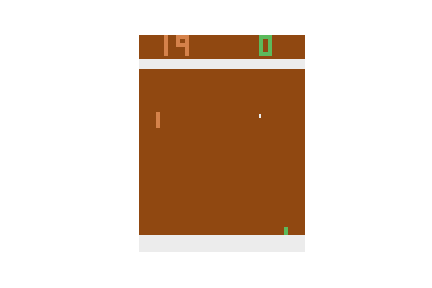
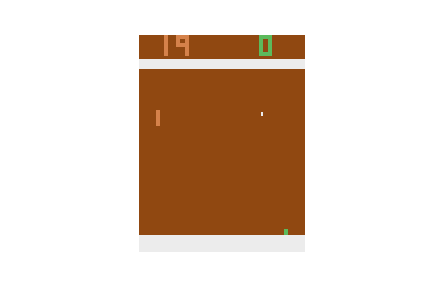
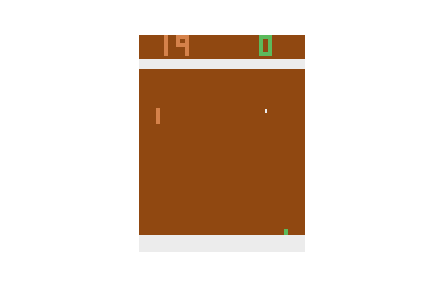
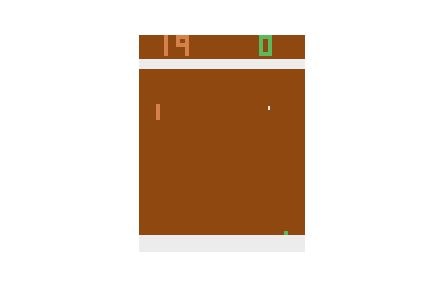
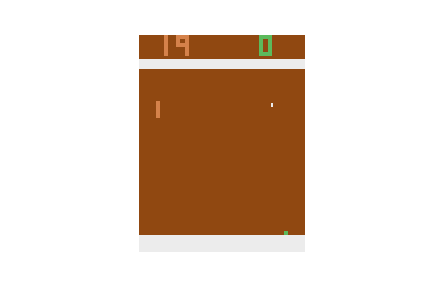
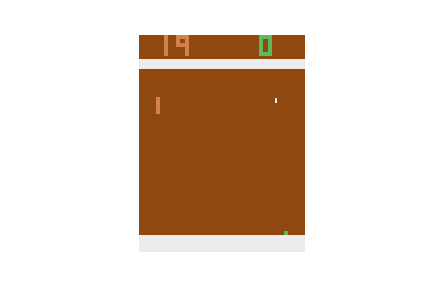
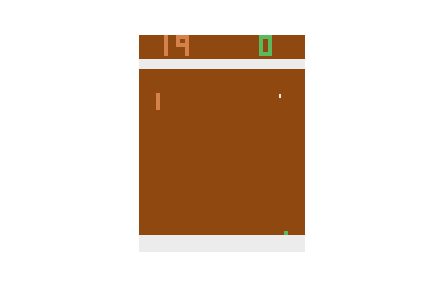
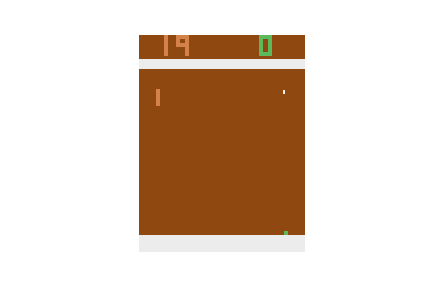
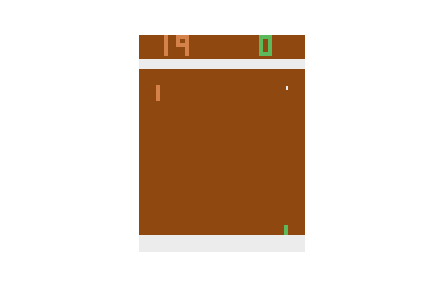
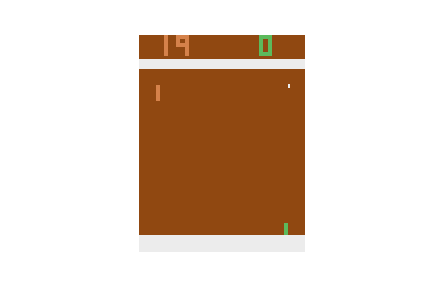
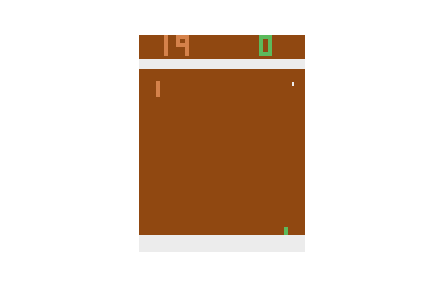
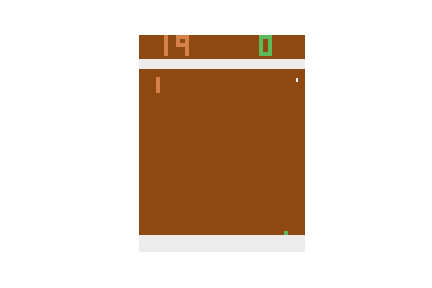
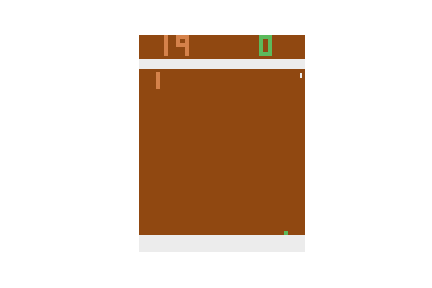
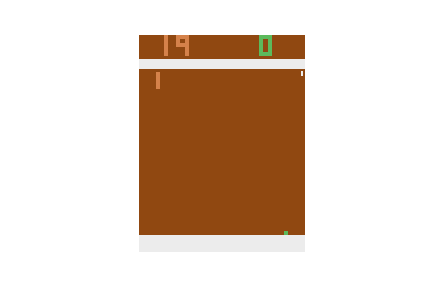
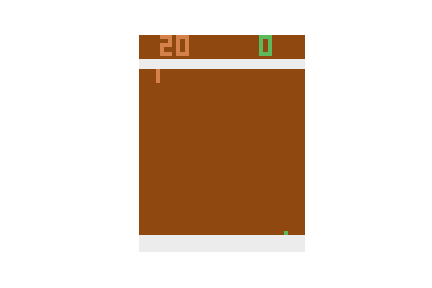
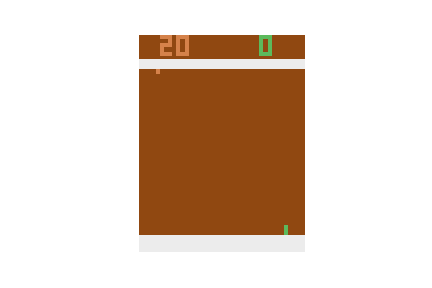
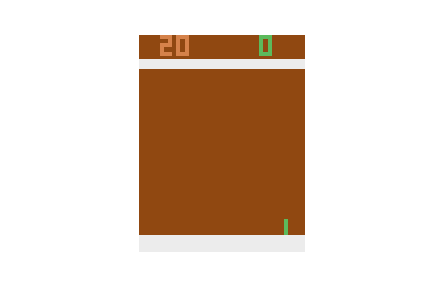
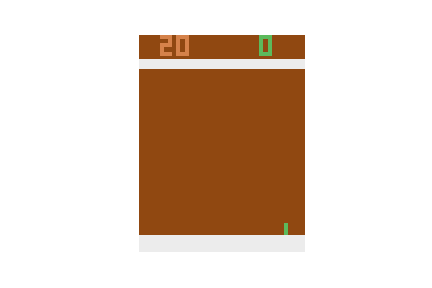
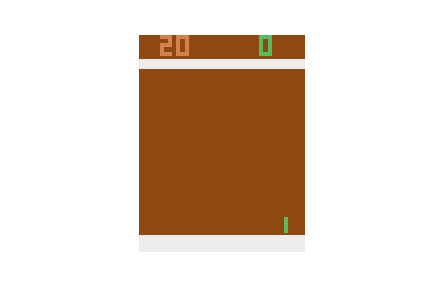
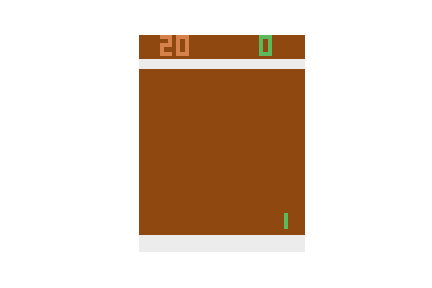
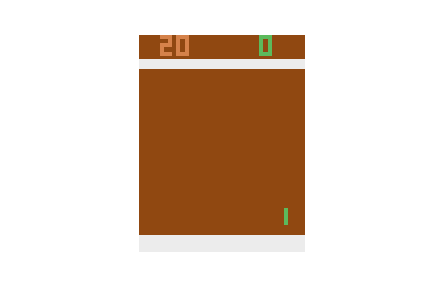
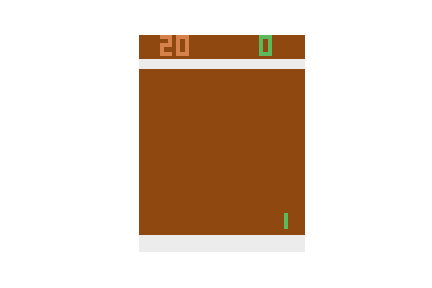
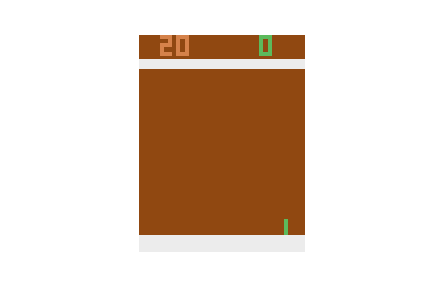
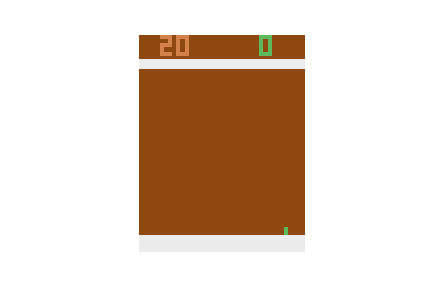
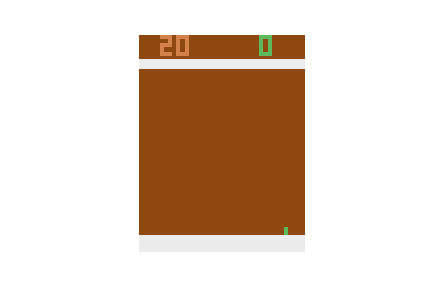
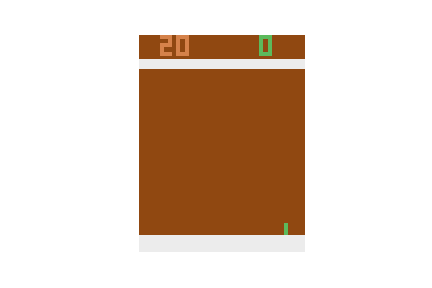
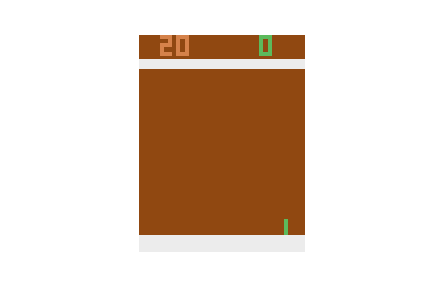
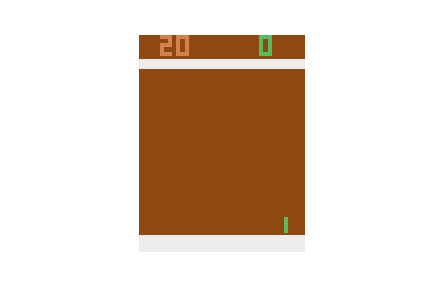
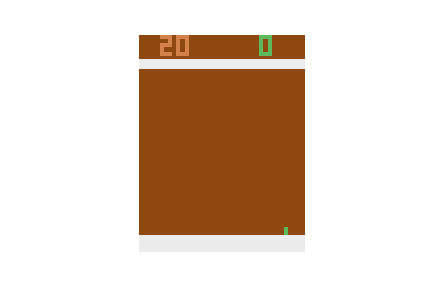
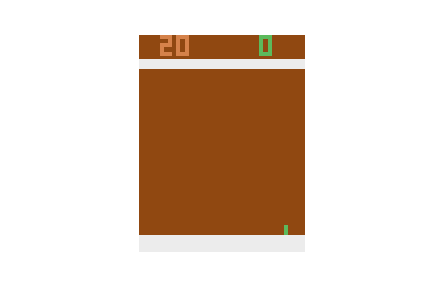
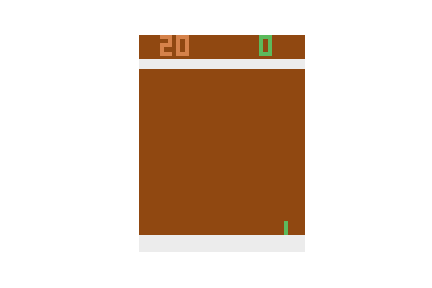
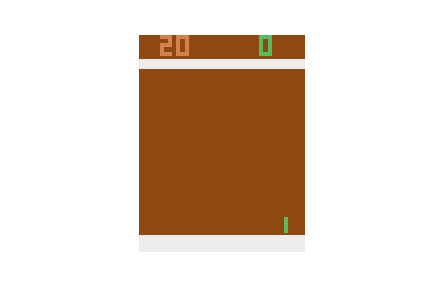
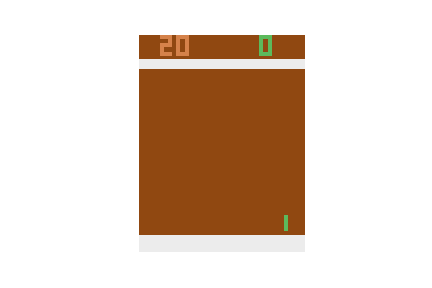
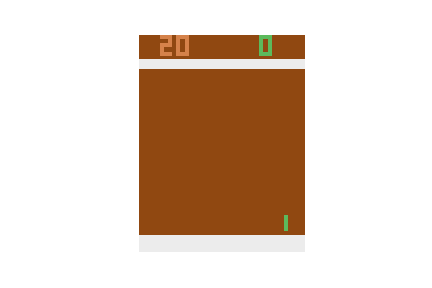
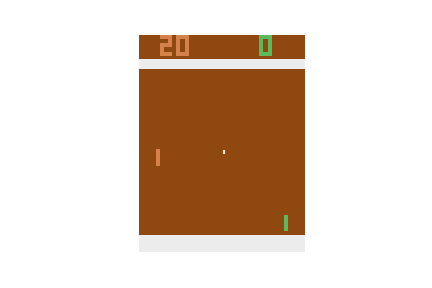
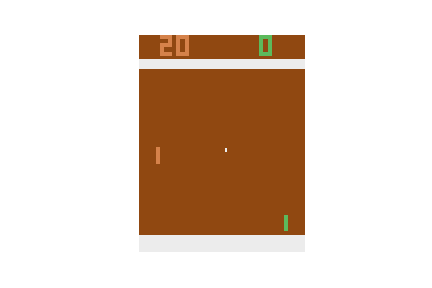
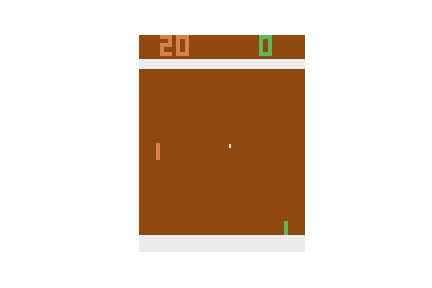
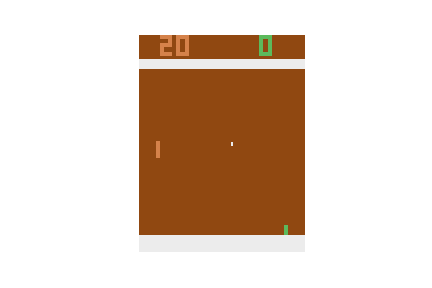
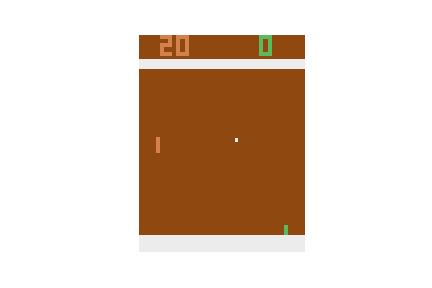
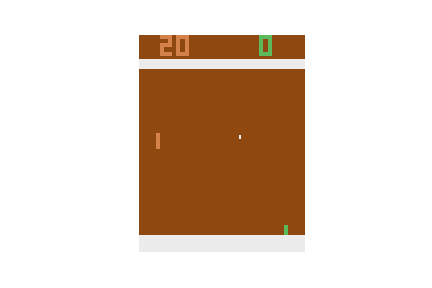
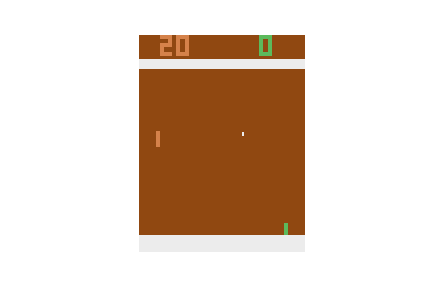
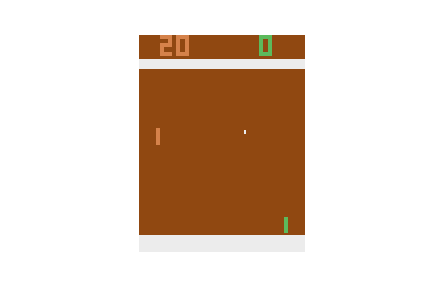
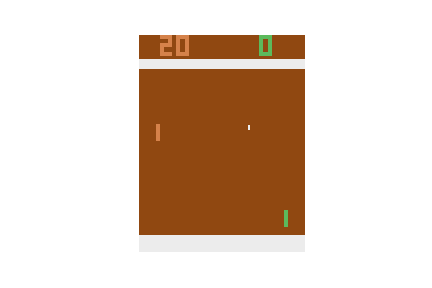
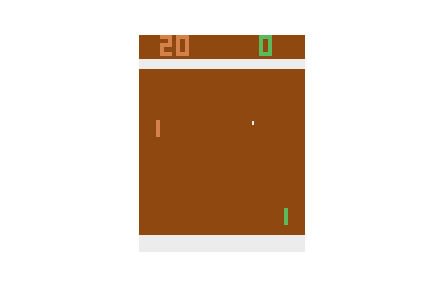
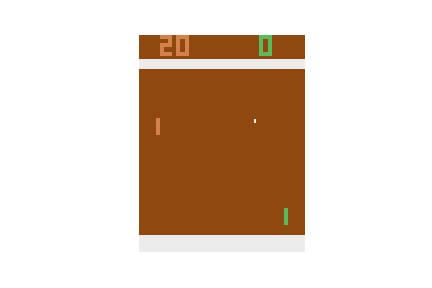
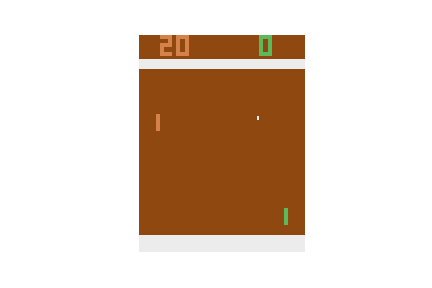
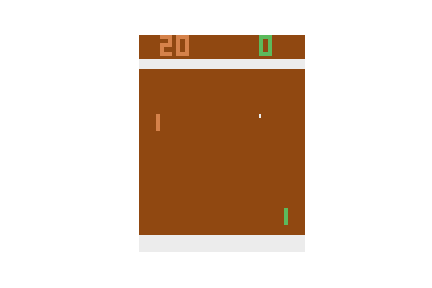
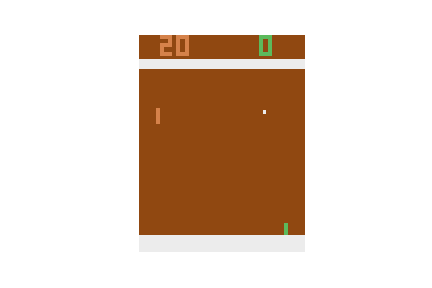
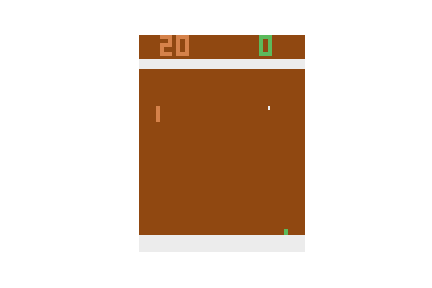
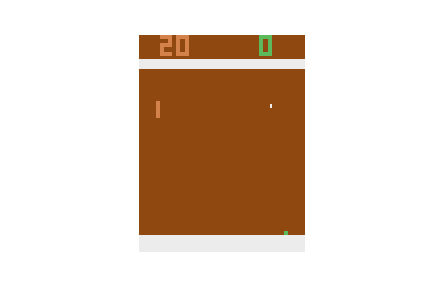
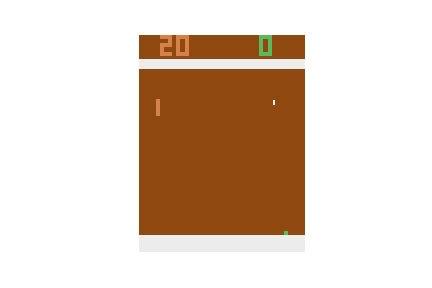
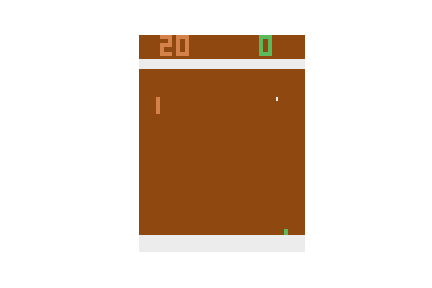
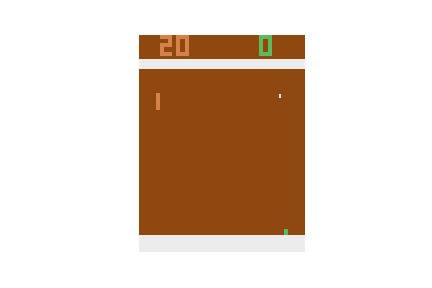
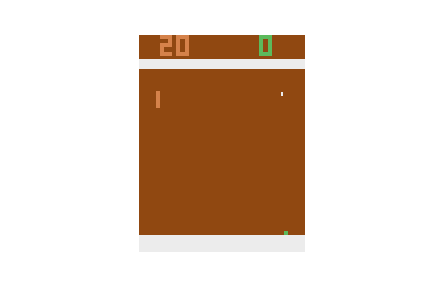
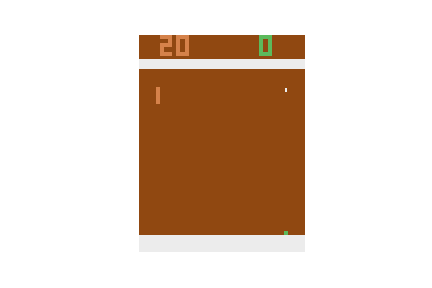
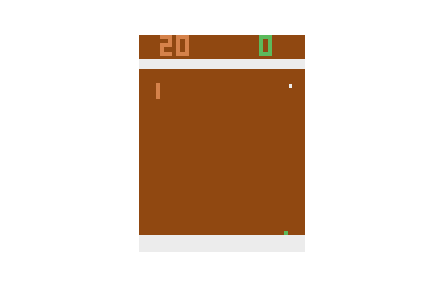
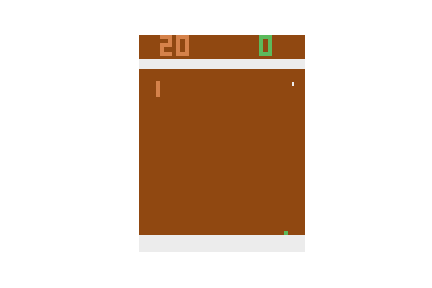
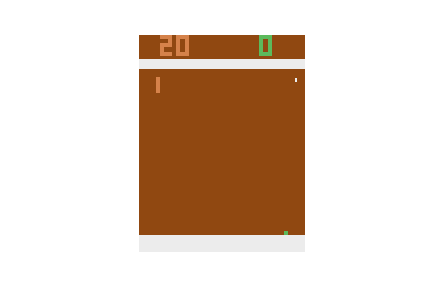
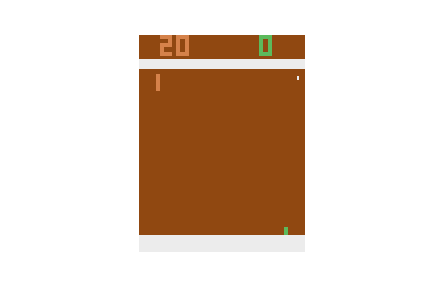
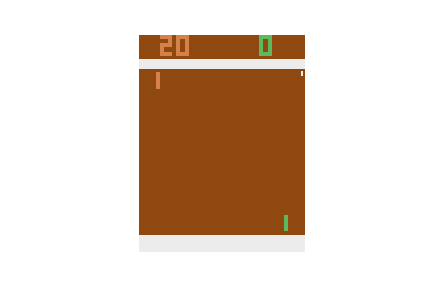
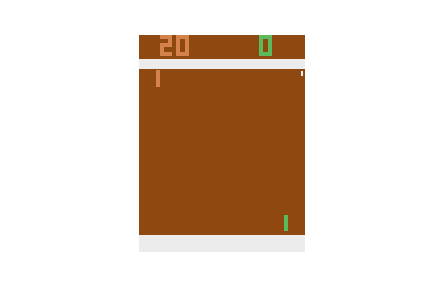

In [6]:
agent.display_game(29)

Game reward


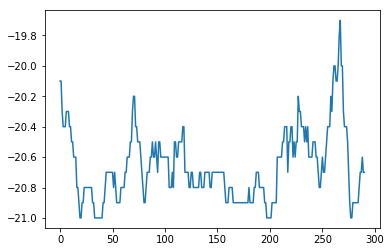

Policy epsilon


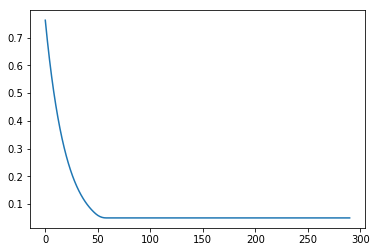

Learning rate


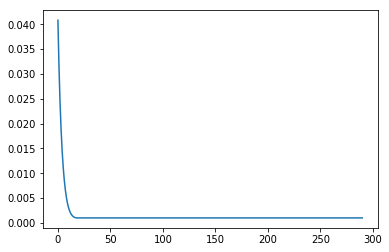

In [7]:
training_history = np.array(agent.training_history)
average_n_games = agent.group_n_games
print("Game reward")
plt.plot(np.convolve(training_history[:,0], np.ones((average_n_games,))/average_n_games, mode='valid'))
plt.show()
print("Policy epsilon")
plt.plot(np.convolve(training_history[:,1], np.ones((average_n_games,))/average_n_games, mode='valid'))
plt.show()
print("Learning rate")
plt.plot(np.convolve(training_history[:,2], np.ones((average_n_games,))/average_n_games, mode='valid'))
plt.show()

In [8]:
import pickle

torch.save(agent.brain.Q.state_dict(), "saved_pong_weights.data")
with open('saved_pong_history.pickle', 'wb') as handle:
    pickle.dump([agent.game_frames, agent.game_info], handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load and Run Model

In [9]:
import pickle

agent = Agent()
agent.brain.Q.load_state_dict(torch.load("saved_pong_weights.data"))
with open('saved_pong_history.pickle', 'rb') as handle:
    saved_info = pickle.load(handle)
    agent.game_frames = saved_info[0]
    agent.game_info = saved_info [1]

In [ ]:
agent.display_game(0)

quality, action
[133.21126 137.96597 195.755   133.03462 147.24059 128.70894] 2
[133.68217 139.22177 197.38138 134.50847 148.79971 129.76376] 0
[133.57976 139.6344  197.86102 135.08345 149.38739 130.06935] 5
[133.3041  139.56584 197.71904 135.0912  149.37556 129.97192] 1
[133.42111 139.32953 197.45676 134.7413  149.02187 129.8062 ] 2
[133.46469 139.28215 197.40845 134.66405 148.94507 129.77618] 2
[133.87881 139.33101 197.55598 134.58176 148.88971 129.88034] 4
[133.44777 139.99854 198.27545 135.60559 149.91821 130.33241] 3
[133.87984 139.96248 198.3236  135.40605 149.74283 130.37317] 5
[133.6699  139.58253 197.81717 134.98393 149.29088 130.04326] 2
[134.2035  139.06519 197.30205 134.12004 148.43527 129.72472] 5
[133.86635 139.12897 197.3078  134.3223  148.6203  129.72072] 5
[133.93979 138.94002 197.09381 134.04964 148.34341 129.58502] 3
[134.41193 138.55501 196.72641 133.38025 147.68468 129.35992] 2
[134.50928 138.25284 196.37991 132.95128 147.24776 129.1397 ] 2
[134.58447 138.21468 196

[159.7394  165.34868 234.67883 159.43509 176.47096 154.30222] 2
[159.18344 164.13524 233.08585 158.04655 174.994   153.26688] 2
[159.83492 165.1127  234.41238 159.0932  176.12402 154.13335] 1
[159.21335 165.1203  234.2893  159.32243 176.31653 154.04016] 2
[159.42926 164.9361  234.11142 159.00568 176.00427 153.93088] 2
[159.30885 164.88431 234.02286 158.98055 175.96959 153.87128] 3
[159.14403 164.81125 233.89899 158.94331 175.91917 153.78801] 0
[159.03555 164.70285 233.74417 158.84001 175.80447 153.68614] 5
[158.92111 164.62277 233.62247 158.7758  175.72978 153.6054 ] 1
[158.41995 164.68214 233.58795 159.03015 175.95695 153.57182] 3
[158.70163 164.18652 233.04562 158.28354 175.20456 153.23006] 0
[158.10788 163.24184 231.7712  157.25932 174.1019  152.39836] 2
[157.86276 163.03398 231.46643 157.07434 173.89284 152.19713] 5
[157.11948 163.24104 231.55983 157.60701 174.39056 152.24013] 2
[154.57155 159.30875 226.23874 153.37064 169.8231  148.76599] 2
[154.82721 159.53667 226.57013 153.57808

[155.71559 160.71379 228.18973 154.80188 171.3866  150.04459] 5
[155.98679 160.871   228.4385  154.91151 171.51956 150.21048] 4
[153.55739 158.48743 225.02475 152.65585 169.01039 147.9635 ] 2
[154.8414  159.48181 226.5065  153.50143 169.97787 148.94405] 5
[154.58412 159.6571  226.66473 153.82112 170.29019 149.03976] 2
[156.99092 161.08768 228.91557 154.84021 171.51804 150.53963] 2
[157.23784 161.21593 229.124   154.92056 171.61897 150.67906] 5
[155.20145 159.97769 227.18576 154.022   170.5425  149.38832] 3
[155.16618 159.0245  226.0199  152.78964 169.26463 148.63905] 4
[154.96536 159.18903 226.17706 153.07533 169.54585 148.73538] 3
[158.75842 162.64206 231.1808  156.24652 173.10062 152.03416] 1
[158.62462 162.88147 231.44325 156.60638 173.4634  152.1996 ] 5
[156.34247 160.41324 227.95793 154.1882  170.79663 149.91005] 4
[156.47789 160.42073 227.99586 154.15022 170.76707 149.9375 ] 2
[159.62865 163.06262 231.8771  156.4887  173.41386 152.50102] 1
[158.70903 162.28888 230.74109 155.80273

[160.39537 165.37529 234.8508  159.2384  176.31464 154.42757] 2
[159.47682 164.29474 233.34213 158.15132 175.12355 153.4381 ] 3
[159.36856 164.25745 233.27376 158.14084 175.10489 153.39174] 2
[159.22195 164.20612 233.18019 158.12555 175.0785  153.32832] 2
[158.98112 164.10257 233.00308 158.07527 175.00916 153.20912] 0
[158.8607  164.05078 232.91452 158.05014 174.97449 153.14952] 4
[158.31514 164.0889  232.8447  158.29239 175.18591 153.09227] 1
[158.19472 164.03711 232.75613 158.26726 175.15123 153.03267] 5
[158.02992 163.96407 232.6323  158.23001 175.10083 152.9494 ] 5
[157.90594 163.93167 232.56651 158.23143 175.09338 152.90434] 0
[158.86313 164.52864 233.49576 158.67334 175.61958 153.52272] 1
[157.65903 163.63727 232.1562  157.9341  174.76788 152.6353 ] 4
[158.1032  164.56938 233.38351 158.99466 175.89742 153.43333] 3
[158.4276  164.49359 233.36044 158.7812  175.69986 153.42592] 2
[157.48251 163.43384 231.8714  157.73068 174.54468 152.44844] 5
[157.67366 164.50603 233.21507 159.06346

[157.55951 161.26666 229.25412 154.87334 171.59325 150.76994] 2
[158.05775 161.24794 229.33743 154.6731  171.42188 150.83478] 0
[158.34499 161.41484 229.6014  154.78972 171.56323 151.01079] 2
[158.59357 163.70178 232.43353 157.68861 174.58112 152.83464] 2
[158.55377 163.69226 232.41348 157.69023 174.57991 152.82088] 1
[158.76671 164.77211 233.77109 159.02531 175.97688 153.69728] 2
[159.03917 164.62366 233.64868 158.7353  175.69638 153.62492] 4
[157.81593 163.68477 232.24731 157.94075 174.78609 152.69737] 2
[158.0884  163.53632 232.12491 157.65076 174.50557 152.625  ] 1
[157.59332 163.60294 232.1005  157.91243 174.74075 152.59804] 2
[157.80923 163.41873 231.92258 157.59569 174.4285  152.48875] 0
[157.68883 163.36694 231.83403 157.57054 174.39383 152.42915] 2
[157.5684  163.31517 231.74547 157.54541 174.35913 152.36955] 5
[157.06723 163.37456 231.71095 157.79979 174.58632 152.33597] 4
[157.71872 164.352   233.03749 158.84642 175.71634 153.20244] 4
[156.782   163.24973 231.49854 157.73741